# Question 1

### Train and validate your own n-layer Neural Network on the Apparel dataset to predict the class label of a given apparel. You are free to choose the hyper-parameters, training strategy to handle large number of training data (Hint: Batch Size) architecture - number of hidden layers, number of nodes in each hidden layer etc.

## Importing libraries


In [10]:
import numpy as np
import pandas as pd
import math as mt
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score



## Utility Functions

NeuralNetwork class

In [11]:
class NeuralNetwork:
    def __init__(self,input_size,output_size, No_HL, h_LS , activation = "sigmoid"):
        self.input_LS = input_size
        self.hidden_LS = h_LS
        self.output_LS = output_size
        self.No_HLayers = No_HL 
        self.W = np.empty(self.No_HLayers + 1, dtype = object)
        self.B = np.empty(self.No_HLayers + 1, dtype = object)
        self.H_in = np.empty(self.No_HLayers + 1, dtype = object)
        self.H_out = np.empty(self.No_HLayers + 2, dtype = object)
        self.w_grad = np.empty(self.No_HLayers + 1, dtype = object)
        self.b_grad = np.empty(self.No_HLayers + 1, dtype = object)
        
        bound = np.sqrt(1./self.input_LS)

        self.W[0] = np.random.uniform(-bound,bound,(self.input_LS, self.hidden_LS))
        self.B[0] = np.random.uniform(-bound,bound,(1, self.hidden_LS))
        
        for i in range(1, len(self.W)-1):
            self.W[i] = np.random.uniform(-bound,bound,(self.hidden_LS, self.hidden_LS))
            self.B[i] = np.random.uniform(-bound,bound,(1, self.hidden_LS))
        
        self.W[len(self.W)-1] = np.random.uniform(-bound,bound,(self.hidden_LS,self.output_LS))
        self.B[len(self.B)-1] = np.random.uniform(-bound,bound,(1, self.output_LS))
        self.activation = activation

    def ReLU(self, z):
        return z * (z > 0)

    def delta_ReLU(self, z):
        return 1. * (z > 0)
    
    def tanh(self, z):
        return np.tanh(z)

    def delta_tanh(self, z):
        return 1. - z * z
    
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def delta_sigmoid(self, z):
        return z * (1 - z)
    
    def softmax(self, y_hat):
        tmp = y_hat - y_hat.max(axis=1).reshape(-1, 1)
        exp_tmp = np.exp(tmp)
        return exp_tmp / exp_tmp.sum(axis=1).reshape(-1, 1)
    
    
    def forwardprop(self, X):
        self.H_out[0] = X
        for i in range(0,len(self.W)):
            self.H_in[i] = np.dot(self.H_out[i], self.W[i]) + self.B[i]
            if i != len(self.W) - 1:
                if self.activation == "sigmoid":
                    self.H_out[i + 1] = self.sigmoid(self.H_in[i])
                elif self.activation == "ReLU": 
                    self.H_out[i + 1] = self.ReLU(self.H_in[i])
                elif self.activation == "tanh": 
                    self.H_out[i + 1] = self.tanh(self.H_in[i])
            else:
                self.H_out[i + 1] = self.softmax(self.H_in[i])
        self.yHat = self.H_out[len(self.W)]
        return self.yHat

    def backprop(self, X, error, LR = 0.01):  
        m = X.shape[0]
        err2 = error
        for i in range(len(self.w_grad) - 1, 0, -1):
            self.w_grad[i] = LR * np.dot(self.H_out[i].T,err2)/m
            self.b_grad[i] = LR * np.average(err2, axis=0)
            err2 = np.dot(err2, self.W[i].T)
            if self.activation == "sigmoid":
                err2 *= self.delta_sigmoid(self.H_out[i])
            elif self.activation == "ReLU": 
                err2 *= self.delta_ReLU(self.H_out[i])
            elif self.activation == "tanh": 
                err2 *= self.delta_tanh(self.H_out[i]) 
        self.w_grad[0] = LR * np.dot(self.H_out[0].T, err2)/m
        self.b_grad[0] = LR * np.average(err2, axis=0)

    def grad_update(self, m, l2 = 0):
        self.W += self.w_grad - (l2 * self.W)/m
        self.B += self.b_grad
        
    def fit(self, X, y, epoch = 10, LR = 0.01, cost_check = False, batch = False, batch_size = -1, l2 = 0):
        cost = []
        if batch_size == -1:
            batch_size = X.shape[0]
            batch = False
        XList = []
        yList = []
        if batch:
            XList = [X[i : i + batch_size][:] for i in range(0,X.shape[0], batch_size)]
            yList = [y[i : i + batch_size][:] for i in range(0,y.shape[0], batch_size)]    
        else:
            XList.append(X)
            yList.append(y)
        
        for i in range(epoch):
            itr = 0
            y_hatList = []
            for XL,yL in zip(XList, yList):
                y_hat = self.forwardprop(XL)
                error = yL - y_hat
                self.backprop(XL, error, LR)
                self.grad_update(yL.shape[0], l2)
                y_hatList += list(y_hat)
                print("epoch: ",i ,"iteration: ",itr)
                itr += 1
            if cost_check:
                y_hatList = np.clip(y_hatList, 0.00001, 0.99999)
                cost.append(-np.sum(y * np.log(y_hatList))/y.shape[0])
                print("cost[",i,"]: " , cost[i])
             
        return cost
    
    def predict(self, X):
        y_hat = self.forwardprop(X)
        return np.argmax(y_hat, axis=1)
        
            

### Reading the Data Set


In [12]:
output_file = "./../input_data/Apparel/apparel-trainval.csv"
dataSet = pd.read_csv(output_file)
Class = "label"
columns = list(dataSet.columns)
X = dataSet[columns[1:]].values
y = dataSet[[Class]].values


### Spliting the data set for train and test data randomly

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


### OneHotEncoding the class labels

In [14]:
ohe = OneHotEncoder(n_values=10)
y_train_enc = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()


/Users/martian/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)


### Neural Network object 
#### NeuralNetwork(input_size, output_size, No of hidden layers, No of neurons per layer ,  activation function = "sigmoid")
 * For best results use NeuralNetwork(input_size, output_size, No of hidden layers = 2, No of neurons per layer = 500 ,  activation function = "sigmoid")

In [15]:
NN = NeuralNetwork(X_train.shape[1] , 10, 2, 500, activation = "sigmoid")

### Fitting the model
#### NN.fit(Feature set, output class, epoch = 10, Learning Rate = 0.01, cost_check = False, batch = False, batch_size = -1, l2 = 0)
* For best results use NN.fit(Feature set, output class, epoch = 1000, Learning Rate = 0.1, cost_check=True, batch = True, batch_size = 500)

In [81]:
costs = NN.fit(X_train, y_train_enc, 1000, 0.1, cost_check=True, batch = True, batch_size = 500)

epoch:  0 iteration:  0
epoch:  0 iteration:  1
epoch:  0 iteration:  2
epoch:  0 iteration:  3
epoch:  0 iteration:  4
epoch:  0 iteration:  5
epoch:  0 iteration:  6
epoch:  0 iteration:  7
epoch:  0 iteration:  8
epoch:  0 iteration:  9
epoch:  0 iteration:  10
epoch:  0 iteration:  11
epoch:  0 iteration:  12
epoch:  0 iteration:  13
epoch:  0 iteration:  14
epoch:  0 iteration:  15
epoch:  0 iteration:  16
epoch:  0 iteration:  17
epoch:  0 iteration:  18
epoch:  0 iteration:  19
epoch:  0 iteration:  20
epoch:  0 iteration:  21
epoch:  0 iteration:  22
epoch:  0 iteration:  23
epoch:  0 iteration:  24
epoch:  0 iteration:  25
epoch:  0 iteration:  26
epoch:  0 iteration:  27
epoch:  0 iteration:  28
epoch:  0 iteration:  29
epoch:  0 iteration:  30
epoch:  0 iteration:  31
epoch:  0 iteration:  32
epoch:  0 iteration:  33
epoch:  0 iteration:  34
epoch:  0 iteration:  35
epoch:  0 iteration:  36
epoch:  0 iteration:  37
epoch:  0 iteration:  38
epoch:  0 iteration:  39
epoch:  0 

epoch:  3 iteration:  40
epoch:  3 iteration:  41
epoch:  3 iteration:  42
epoch:  3 iteration:  43
epoch:  3 iteration:  44
epoch:  3 iteration:  45
epoch:  3 iteration:  46
epoch:  3 iteration:  47
epoch:  3 iteration:  48
epoch:  3 iteration:  49
epoch:  3 iteration:  50
epoch:  3 iteration:  51
epoch:  3 iteration:  52
epoch:  3 iteration:  53
epoch:  3 iteration:  54
epoch:  3 iteration:  55
epoch:  3 iteration:  56
epoch:  3 iteration:  57
epoch:  3 iteration:  58
epoch:  3 iteration:  59
epoch:  3 iteration:  60
epoch:  3 iteration:  61
epoch:  3 iteration:  62
epoch:  3 iteration:  63
epoch:  3 iteration:  64
epoch:  3 iteration:  65
epoch:  3 iteration:  66
epoch:  3 iteration:  67
epoch:  3 iteration:  68
epoch:  3 iteration:  69
epoch:  3 iteration:  70
epoch:  3 iteration:  71
epoch:  3 iteration:  72
epoch:  3 iteration:  73
epoch:  3 iteration:  74
epoch:  3 iteration:  75
epoch:  3 iteration:  76
epoch:  3 iteration:  77
epoch:  3 iteration:  78
epoch:  3 iteration:  79


epoch:  6 iteration:  78
epoch:  6 iteration:  79
epoch:  6 iteration:  80
epoch:  6 iteration:  81
epoch:  6 iteration:  82
epoch:  6 iteration:  83
epoch:  6 iteration:  84
epoch:  6 iteration:  85
epoch:  6 iteration:  86
epoch:  6 iteration:  87
epoch:  6 iteration:  88
epoch:  6 iteration:  89
epoch:  6 iteration:  90
epoch:  6 iteration:  91
epoch:  6 iteration:  92
epoch:  6 iteration:  93
epoch:  6 iteration:  94
epoch:  6 iteration:  95
cost[ 6 ]:  0.5237679992826726
epoch:  7 iteration:  0
epoch:  7 iteration:  1
epoch:  7 iteration:  2
epoch:  7 iteration:  3
epoch:  7 iteration:  4
epoch:  7 iteration:  5
epoch:  7 iteration:  6
epoch:  7 iteration:  7
epoch:  7 iteration:  8
epoch:  7 iteration:  9
epoch:  7 iteration:  10
epoch:  7 iteration:  11
epoch:  7 iteration:  12
epoch:  7 iteration:  13
epoch:  7 iteration:  14
epoch:  7 iteration:  15
epoch:  7 iteration:  16
epoch:  7 iteration:  17
epoch:  7 iteration:  18
epoch:  7 iteration:  19
epoch:  7 iteration:  20
epoc

epoch:  10 iteration:  24
epoch:  10 iteration:  25
epoch:  10 iteration:  26
epoch:  10 iteration:  27
epoch:  10 iteration:  28
epoch:  10 iteration:  29
epoch:  10 iteration:  30
epoch:  10 iteration:  31
epoch:  10 iteration:  32
epoch:  10 iteration:  33
epoch:  10 iteration:  34
epoch:  10 iteration:  35
epoch:  10 iteration:  36
epoch:  10 iteration:  37
epoch:  10 iteration:  38
epoch:  10 iteration:  39
epoch:  10 iteration:  40
epoch:  10 iteration:  41
epoch:  10 iteration:  42
epoch:  10 iteration:  43
epoch:  10 iteration:  44
epoch:  10 iteration:  45
epoch:  10 iteration:  46
epoch:  10 iteration:  47
epoch:  10 iteration:  48
epoch:  10 iteration:  49
epoch:  10 iteration:  50
epoch:  10 iteration:  51
epoch:  10 iteration:  52
epoch:  10 iteration:  53
epoch:  10 iteration:  54
epoch:  10 iteration:  55
epoch:  10 iteration:  56
epoch:  10 iteration:  57
epoch:  10 iteration:  58
epoch:  10 iteration:  59
epoch:  10 iteration:  60
epoch:  10 iteration:  61
epoch:  10 i

epoch:  13 iteration:  57
epoch:  13 iteration:  58
epoch:  13 iteration:  59
epoch:  13 iteration:  60
epoch:  13 iteration:  61
epoch:  13 iteration:  62
epoch:  13 iteration:  63
epoch:  13 iteration:  64
epoch:  13 iteration:  65
epoch:  13 iteration:  66
epoch:  13 iteration:  67
epoch:  13 iteration:  68
epoch:  13 iteration:  69
epoch:  13 iteration:  70
epoch:  13 iteration:  71
epoch:  13 iteration:  72
epoch:  13 iteration:  73
epoch:  13 iteration:  74
epoch:  13 iteration:  75
epoch:  13 iteration:  76
epoch:  13 iteration:  77
epoch:  13 iteration:  78
epoch:  13 iteration:  79
epoch:  13 iteration:  80
epoch:  13 iteration:  81
epoch:  13 iteration:  82
epoch:  13 iteration:  83
epoch:  13 iteration:  84
epoch:  13 iteration:  85
epoch:  13 iteration:  86
epoch:  13 iteration:  87
epoch:  13 iteration:  88
epoch:  13 iteration:  89
epoch:  13 iteration:  90
epoch:  13 iteration:  91
epoch:  13 iteration:  92
epoch:  13 iteration:  93
epoch:  13 iteration:  94
epoch:  13 i

epoch:  16 iteration:  83
epoch:  16 iteration:  84
epoch:  16 iteration:  85
epoch:  16 iteration:  86
epoch:  16 iteration:  87
epoch:  16 iteration:  88
epoch:  16 iteration:  89
epoch:  16 iteration:  90
epoch:  16 iteration:  91
epoch:  16 iteration:  92
epoch:  16 iteration:  93
epoch:  16 iteration:  94
epoch:  16 iteration:  95
cost[ 16 ]:  0.49808062507547396
epoch:  17 iteration:  0
epoch:  17 iteration:  1
epoch:  17 iteration:  2
epoch:  17 iteration:  3
epoch:  17 iteration:  4
epoch:  17 iteration:  5
epoch:  17 iteration:  6
epoch:  17 iteration:  7
epoch:  17 iteration:  8
epoch:  17 iteration:  9
epoch:  17 iteration:  10
epoch:  17 iteration:  11
epoch:  17 iteration:  12
epoch:  17 iteration:  13
epoch:  17 iteration:  14
epoch:  17 iteration:  15
epoch:  17 iteration:  16
epoch:  17 iteration:  17
epoch:  17 iteration:  18
epoch:  17 iteration:  19
epoch:  17 iteration:  20
epoch:  17 iteration:  21
epoch:  17 iteration:  22
epoch:  17 iteration:  23
epoch:  17 iter

epoch:  20 iteration:  11
epoch:  20 iteration:  12
epoch:  20 iteration:  13
epoch:  20 iteration:  14
epoch:  20 iteration:  15
epoch:  20 iteration:  16
epoch:  20 iteration:  17
epoch:  20 iteration:  18
epoch:  20 iteration:  19
epoch:  20 iteration:  20
epoch:  20 iteration:  21
epoch:  20 iteration:  22
epoch:  20 iteration:  23
epoch:  20 iteration:  24
epoch:  20 iteration:  25
epoch:  20 iteration:  26
epoch:  20 iteration:  27
epoch:  20 iteration:  28
epoch:  20 iteration:  29
epoch:  20 iteration:  30
epoch:  20 iteration:  31
epoch:  20 iteration:  32
epoch:  20 iteration:  33
epoch:  20 iteration:  34
epoch:  20 iteration:  35
epoch:  20 iteration:  36
epoch:  20 iteration:  37
epoch:  20 iteration:  38
epoch:  20 iteration:  39
epoch:  20 iteration:  40
epoch:  20 iteration:  41
epoch:  20 iteration:  42
epoch:  20 iteration:  43
epoch:  20 iteration:  44
epoch:  20 iteration:  45
epoch:  20 iteration:  46
epoch:  20 iteration:  47
epoch:  20 iteration:  48
epoch:  20 i

epoch:  23 iteration:  38
epoch:  23 iteration:  39
epoch:  23 iteration:  40
epoch:  23 iteration:  41
epoch:  23 iteration:  42
epoch:  23 iteration:  43
epoch:  23 iteration:  44
epoch:  23 iteration:  45
epoch:  23 iteration:  46
epoch:  23 iteration:  47
epoch:  23 iteration:  48
epoch:  23 iteration:  49
epoch:  23 iteration:  50
epoch:  23 iteration:  51
epoch:  23 iteration:  52
epoch:  23 iteration:  53
epoch:  23 iteration:  54
epoch:  23 iteration:  55
epoch:  23 iteration:  56
epoch:  23 iteration:  57
epoch:  23 iteration:  58
epoch:  23 iteration:  59
epoch:  23 iteration:  60
epoch:  23 iteration:  61
epoch:  23 iteration:  62
epoch:  23 iteration:  63
epoch:  23 iteration:  64
epoch:  23 iteration:  65
epoch:  23 iteration:  66
epoch:  23 iteration:  67
epoch:  23 iteration:  68
epoch:  23 iteration:  69
epoch:  23 iteration:  70
epoch:  23 iteration:  71
epoch:  23 iteration:  72
epoch:  23 iteration:  73
epoch:  23 iteration:  74
epoch:  23 iteration:  75
epoch:  23 i

epoch:  26 iteration:  65
epoch:  26 iteration:  66
epoch:  26 iteration:  67
epoch:  26 iteration:  68
epoch:  26 iteration:  69
epoch:  26 iteration:  70
epoch:  26 iteration:  71
epoch:  26 iteration:  72
epoch:  26 iteration:  73
epoch:  26 iteration:  74
epoch:  26 iteration:  75
epoch:  26 iteration:  76
epoch:  26 iteration:  77
epoch:  26 iteration:  78
epoch:  26 iteration:  79
epoch:  26 iteration:  80
epoch:  26 iteration:  81
epoch:  26 iteration:  82
epoch:  26 iteration:  83
epoch:  26 iteration:  84
epoch:  26 iteration:  85
epoch:  26 iteration:  86
epoch:  26 iteration:  87
epoch:  26 iteration:  88
epoch:  26 iteration:  89
epoch:  26 iteration:  90
epoch:  26 iteration:  91
epoch:  26 iteration:  92
epoch:  26 iteration:  93
epoch:  26 iteration:  94
epoch:  26 iteration:  95
cost[ 26 ]:  0.5063425641486696
epoch:  27 iteration:  0
epoch:  27 iteration:  1
epoch:  27 iteration:  2
epoch:  27 iteration:  3
epoch:  27 iteration:  4
epoch:  27 iteration:  5
epoch:  27 i

epoch:  29 iteration:  91
epoch:  29 iteration:  92
epoch:  29 iteration:  93
epoch:  29 iteration:  94
epoch:  29 iteration:  95
cost[ 29 ]:  0.5208317766137938
epoch:  30 iteration:  0
epoch:  30 iteration:  1
epoch:  30 iteration:  2
epoch:  30 iteration:  3
epoch:  30 iteration:  4
epoch:  30 iteration:  5
epoch:  30 iteration:  6
epoch:  30 iteration:  7
epoch:  30 iteration:  8
epoch:  30 iteration:  9
epoch:  30 iteration:  10
epoch:  30 iteration:  11
epoch:  30 iteration:  12
epoch:  30 iteration:  13
epoch:  30 iteration:  14
epoch:  30 iteration:  15
epoch:  30 iteration:  16
epoch:  30 iteration:  17
epoch:  30 iteration:  18
epoch:  30 iteration:  19
epoch:  30 iteration:  20
epoch:  30 iteration:  21
epoch:  30 iteration:  22
epoch:  30 iteration:  23
epoch:  30 iteration:  24
epoch:  30 iteration:  25
epoch:  30 iteration:  26
epoch:  30 iteration:  27
epoch:  30 iteration:  28
epoch:  30 iteration:  29
epoch:  30 iteration:  30
epoch:  30 iteration:  31
epoch:  30 itera

epoch:  33 iteration:  25
epoch:  33 iteration:  26
epoch:  33 iteration:  27
epoch:  33 iteration:  28
epoch:  33 iteration:  29
epoch:  33 iteration:  30
epoch:  33 iteration:  31
epoch:  33 iteration:  32
epoch:  33 iteration:  33
epoch:  33 iteration:  34
epoch:  33 iteration:  35
epoch:  33 iteration:  36
epoch:  33 iteration:  37
epoch:  33 iteration:  38
epoch:  33 iteration:  39
epoch:  33 iteration:  40
epoch:  33 iteration:  41
epoch:  33 iteration:  42
epoch:  33 iteration:  43
epoch:  33 iteration:  44
epoch:  33 iteration:  45
epoch:  33 iteration:  46
epoch:  33 iteration:  47
epoch:  33 iteration:  48
epoch:  33 iteration:  49
epoch:  33 iteration:  50
epoch:  33 iteration:  51
epoch:  33 iteration:  52
epoch:  33 iteration:  53
epoch:  33 iteration:  54
epoch:  33 iteration:  55
epoch:  33 iteration:  56
epoch:  33 iteration:  57
epoch:  33 iteration:  58
epoch:  33 iteration:  59
epoch:  33 iteration:  60
epoch:  33 iteration:  61
epoch:  33 iteration:  62
epoch:  33 i

epoch:  36 iteration:  52
epoch:  36 iteration:  53
epoch:  36 iteration:  54
epoch:  36 iteration:  55
epoch:  36 iteration:  56
epoch:  36 iteration:  57
epoch:  36 iteration:  58
epoch:  36 iteration:  59
epoch:  36 iteration:  60
epoch:  36 iteration:  61
epoch:  36 iteration:  62
epoch:  36 iteration:  63
epoch:  36 iteration:  64
epoch:  36 iteration:  65
epoch:  36 iteration:  66
epoch:  36 iteration:  67
epoch:  36 iteration:  68
epoch:  36 iteration:  69
epoch:  36 iteration:  70
epoch:  36 iteration:  71
epoch:  36 iteration:  72
epoch:  36 iteration:  73
epoch:  36 iteration:  74
epoch:  36 iteration:  75
epoch:  36 iteration:  76
epoch:  36 iteration:  77
epoch:  36 iteration:  78
epoch:  36 iteration:  79
epoch:  36 iteration:  80
epoch:  36 iteration:  81
epoch:  36 iteration:  82
epoch:  36 iteration:  83
epoch:  36 iteration:  84
epoch:  36 iteration:  85
epoch:  36 iteration:  86
epoch:  36 iteration:  87
epoch:  36 iteration:  88
epoch:  36 iteration:  89
epoch:  36 i

epoch:  39 iteration:  79
epoch:  39 iteration:  80
epoch:  39 iteration:  81
epoch:  39 iteration:  82
epoch:  39 iteration:  83
epoch:  39 iteration:  84
epoch:  39 iteration:  85
epoch:  39 iteration:  86
epoch:  39 iteration:  87
epoch:  39 iteration:  88
epoch:  39 iteration:  89
epoch:  39 iteration:  90
epoch:  39 iteration:  91
epoch:  39 iteration:  92
epoch:  39 iteration:  93
epoch:  39 iteration:  94
epoch:  39 iteration:  95
cost[ 39 ]:  0.5226010721078234
epoch:  40 iteration:  0
epoch:  40 iteration:  1
epoch:  40 iteration:  2
epoch:  40 iteration:  3
epoch:  40 iteration:  4
epoch:  40 iteration:  5
epoch:  40 iteration:  6
epoch:  40 iteration:  7
epoch:  40 iteration:  8
epoch:  40 iteration:  9
epoch:  40 iteration:  10
epoch:  40 iteration:  11
epoch:  40 iteration:  12
epoch:  40 iteration:  13
epoch:  40 iteration:  14
epoch:  40 iteration:  15
epoch:  40 iteration:  16
epoch:  40 iteration:  17
epoch:  40 iteration:  18
epoch:  40 iteration:  19
epoch:  40 itera

epoch:  43 iteration:  8
epoch:  43 iteration:  9
epoch:  43 iteration:  10
epoch:  43 iteration:  11
epoch:  43 iteration:  12
epoch:  43 iteration:  13
epoch:  43 iteration:  14
epoch:  43 iteration:  15
epoch:  43 iteration:  16
epoch:  43 iteration:  17
epoch:  43 iteration:  18
epoch:  43 iteration:  19
epoch:  43 iteration:  20
epoch:  43 iteration:  21
epoch:  43 iteration:  22
epoch:  43 iteration:  23
epoch:  43 iteration:  24
epoch:  43 iteration:  25
epoch:  43 iteration:  26
epoch:  43 iteration:  27
epoch:  43 iteration:  28
epoch:  43 iteration:  29
epoch:  43 iteration:  30
epoch:  43 iteration:  31
epoch:  43 iteration:  32
epoch:  43 iteration:  33
epoch:  43 iteration:  34
epoch:  43 iteration:  35
epoch:  43 iteration:  36
epoch:  43 iteration:  37
epoch:  43 iteration:  38
epoch:  43 iteration:  39
epoch:  43 iteration:  40
epoch:  43 iteration:  41
epoch:  43 iteration:  42
epoch:  43 iteration:  43
epoch:  43 iteration:  44
epoch:  43 iteration:  45
epoch:  43 ite

epoch:  46 iteration:  35
epoch:  46 iteration:  36
epoch:  46 iteration:  37
epoch:  46 iteration:  38
epoch:  46 iteration:  39
epoch:  46 iteration:  40
epoch:  46 iteration:  41
epoch:  46 iteration:  42
epoch:  46 iteration:  43
epoch:  46 iteration:  44
epoch:  46 iteration:  45
epoch:  46 iteration:  46
epoch:  46 iteration:  47
epoch:  46 iteration:  48
epoch:  46 iteration:  49
epoch:  46 iteration:  50
epoch:  46 iteration:  51
epoch:  46 iteration:  52
epoch:  46 iteration:  53
epoch:  46 iteration:  54
epoch:  46 iteration:  55
epoch:  46 iteration:  56
epoch:  46 iteration:  57
epoch:  46 iteration:  58
epoch:  46 iteration:  59
epoch:  46 iteration:  60
epoch:  46 iteration:  61
epoch:  46 iteration:  62
epoch:  46 iteration:  63
epoch:  46 iteration:  64
epoch:  46 iteration:  65
epoch:  46 iteration:  66
epoch:  46 iteration:  67
epoch:  46 iteration:  68
epoch:  46 iteration:  69
epoch:  46 iteration:  70
epoch:  46 iteration:  71
epoch:  46 iteration:  72
epoch:  46 i

epoch:  49 iteration:  63
epoch:  49 iteration:  64
epoch:  49 iteration:  65
epoch:  49 iteration:  66
epoch:  49 iteration:  67
epoch:  49 iteration:  68
epoch:  49 iteration:  69
epoch:  49 iteration:  70
epoch:  49 iteration:  71
epoch:  49 iteration:  72
epoch:  49 iteration:  73
epoch:  49 iteration:  74
epoch:  49 iteration:  75
epoch:  49 iteration:  76
epoch:  49 iteration:  77
epoch:  49 iteration:  78
epoch:  49 iteration:  79
epoch:  49 iteration:  80
epoch:  49 iteration:  81
epoch:  49 iteration:  82
epoch:  49 iteration:  83
epoch:  49 iteration:  84
epoch:  49 iteration:  85
epoch:  49 iteration:  86
epoch:  49 iteration:  87
epoch:  49 iteration:  88
epoch:  49 iteration:  89
epoch:  49 iteration:  90
epoch:  49 iteration:  91
epoch:  49 iteration:  92
epoch:  49 iteration:  93
epoch:  49 iteration:  94
epoch:  49 iteration:  95
cost[ 49 ]:  0.5282491632772328
epoch:  50 iteration:  0
epoch:  50 iteration:  1
epoch:  50 iteration:  2
epoch:  50 iteration:  3
epoch:  50

epoch:  52 iteration:  90
epoch:  52 iteration:  91
epoch:  52 iteration:  92
epoch:  52 iteration:  93
epoch:  52 iteration:  94
epoch:  52 iteration:  95
cost[ 52 ]:  0.5352768366781746
epoch:  53 iteration:  0
epoch:  53 iteration:  1
epoch:  53 iteration:  2
epoch:  53 iteration:  3
epoch:  53 iteration:  4
epoch:  53 iteration:  5
epoch:  53 iteration:  6
epoch:  53 iteration:  7
epoch:  53 iteration:  8
epoch:  53 iteration:  9
epoch:  53 iteration:  10
epoch:  53 iteration:  11
epoch:  53 iteration:  12
epoch:  53 iteration:  13
epoch:  53 iteration:  14
epoch:  53 iteration:  15
epoch:  53 iteration:  16
epoch:  53 iteration:  17
epoch:  53 iteration:  18
epoch:  53 iteration:  19
epoch:  53 iteration:  20
epoch:  53 iteration:  21
epoch:  53 iteration:  22
epoch:  53 iteration:  23
epoch:  53 iteration:  24
epoch:  53 iteration:  25
epoch:  53 iteration:  26
epoch:  53 iteration:  27
epoch:  53 iteration:  28
epoch:  53 iteration:  29
epoch:  53 iteration:  30
epoch:  53 itera

epoch:  56 iteration:  24
epoch:  56 iteration:  25
epoch:  56 iteration:  26
epoch:  56 iteration:  27
epoch:  56 iteration:  28
epoch:  56 iteration:  29
epoch:  56 iteration:  30
epoch:  56 iteration:  31
epoch:  56 iteration:  32
epoch:  56 iteration:  33
epoch:  56 iteration:  34
epoch:  56 iteration:  35
epoch:  56 iteration:  36
epoch:  56 iteration:  37
epoch:  56 iteration:  38
epoch:  56 iteration:  39
epoch:  56 iteration:  40
epoch:  56 iteration:  41
epoch:  56 iteration:  42
epoch:  56 iteration:  43
epoch:  56 iteration:  44
epoch:  56 iteration:  45
epoch:  56 iteration:  46
epoch:  56 iteration:  47
epoch:  56 iteration:  48
epoch:  56 iteration:  49
epoch:  56 iteration:  50
epoch:  56 iteration:  51
epoch:  56 iteration:  52
epoch:  56 iteration:  53
epoch:  56 iteration:  54
epoch:  56 iteration:  55
epoch:  56 iteration:  56
epoch:  56 iteration:  57
epoch:  56 iteration:  58
epoch:  56 iteration:  59
epoch:  56 iteration:  60
epoch:  56 iteration:  61
epoch:  56 i

epoch:  59 iteration:  55
epoch:  59 iteration:  56
epoch:  59 iteration:  57
epoch:  59 iteration:  58
epoch:  59 iteration:  59
epoch:  59 iteration:  60
epoch:  59 iteration:  61
epoch:  59 iteration:  62
epoch:  59 iteration:  63
epoch:  59 iteration:  64
epoch:  59 iteration:  65
epoch:  59 iteration:  66
epoch:  59 iteration:  67
epoch:  59 iteration:  68
epoch:  59 iteration:  69
epoch:  59 iteration:  70
epoch:  59 iteration:  71
epoch:  59 iteration:  72
epoch:  59 iteration:  73
epoch:  59 iteration:  74
epoch:  59 iteration:  75
epoch:  59 iteration:  76
epoch:  59 iteration:  77
epoch:  59 iteration:  78
epoch:  59 iteration:  79
epoch:  59 iteration:  80
epoch:  59 iteration:  81
epoch:  59 iteration:  82
epoch:  59 iteration:  83
epoch:  59 iteration:  84
epoch:  59 iteration:  85
epoch:  59 iteration:  86
epoch:  59 iteration:  87
epoch:  59 iteration:  88
epoch:  59 iteration:  89
epoch:  59 iteration:  90
epoch:  59 iteration:  91
epoch:  59 iteration:  92
epoch:  59 i

epoch:  62 iteration:  87
epoch:  62 iteration:  88
epoch:  62 iteration:  89
epoch:  62 iteration:  90
epoch:  62 iteration:  91
epoch:  62 iteration:  92
epoch:  62 iteration:  93
epoch:  62 iteration:  94
epoch:  62 iteration:  95
cost[ 62 ]:  0.5204645386072374
epoch:  63 iteration:  0
epoch:  63 iteration:  1
epoch:  63 iteration:  2
epoch:  63 iteration:  3
epoch:  63 iteration:  4
epoch:  63 iteration:  5
epoch:  63 iteration:  6
epoch:  63 iteration:  7
epoch:  63 iteration:  8
epoch:  63 iteration:  9
epoch:  63 iteration:  10
epoch:  63 iteration:  11
epoch:  63 iteration:  12
epoch:  63 iteration:  13
epoch:  63 iteration:  14
epoch:  63 iteration:  15
epoch:  63 iteration:  16
epoch:  63 iteration:  17
epoch:  63 iteration:  18
epoch:  63 iteration:  19
epoch:  63 iteration:  20
epoch:  63 iteration:  21
epoch:  63 iteration:  22
epoch:  63 iteration:  23
epoch:  63 iteration:  24
epoch:  63 iteration:  25
epoch:  63 iteration:  26
epoch:  63 iteration:  27
epoch:  63 itera

epoch:  66 iteration:  21
epoch:  66 iteration:  22
epoch:  66 iteration:  23
epoch:  66 iteration:  24
epoch:  66 iteration:  25
epoch:  66 iteration:  26
epoch:  66 iteration:  27
epoch:  66 iteration:  28
epoch:  66 iteration:  29
epoch:  66 iteration:  30
epoch:  66 iteration:  31
epoch:  66 iteration:  32
epoch:  66 iteration:  33
epoch:  66 iteration:  34
epoch:  66 iteration:  35
epoch:  66 iteration:  36
epoch:  66 iteration:  37
epoch:  66 iteration:  38
epoch:  66 iteration:  39
epoch:  66 iteration:  40
epoch:  66 iteration:  41
epoch:  66 iteration:  42
epoch:  66 iteration:  43
epoch:  66 iteration:  44
epoch:  66 iteration:  45
epoch:  66 iteration:  46
epoch:  66 iteration:  47
epoch:  66 iteration:  48
epoch:  66 iteration:  49
epoch:  66 iteration:  50
epoch:  66 iteration:  51
epoch:  66 iteration:  52
epoch:  66 iteration:  53
epoch:  66 iteration:  54
epoch:  66 iteration:  55
epoch:  66 iteration:  56
epoch:  66 iteration:  57
epoch:  66 iteration:  58
epoch:  66 i

epoch:  69 iteration:  46
epoch:  69 iteration:  47
epoch:  69 iteration:  48
epoch:  69 iteration:  49
epoch:  69 iteration:  50
epoch:  69 iteration:  51
epoch:  69 iteration:  52
epoch:  69 iteration:  53
epoch:  69 iteration:  54
epoch:  69 iteration:  55
epoch:  69 iteration:  56
epoch:  69 iteration:  57
epoch:  69 iteration:  58
epoch:  69 iteration:  59
epoch:  69 iteration:  60
epoch:  69 iteration:  61
epoch:  69 iteration:  62
epoch:  69 iteration:  63
epoch:  69 iteration:  64
epoch:  69 iteration:  65
epoch:  69 iteration:  66
epoch:  69 iteration:  67
epoch:  69 iteration:  68
epoch:  69 iteration:  69
epoch:  69 iteration:  70
epoch:  69 iteration:  71
epoch:  69 iteration:  72
epoch:  69 iteration:  73
epoch:  69 iteration:  74
epoch:  69 iteration:  75
epoch:  69 iteration:  76
epoch:  69 iteration:  77
epoch:  69 iteration:  78
epoch:  69 iteration:  79
epoch:  69 iteration:  80
epoch:  69 iteration:  81
epoch:  69 iteration:  82
epoch:  69 iteration:  83
epoch:  69 i

epoch:  72 iteration:  79
epoch:  72 iteration:  80
epoch:  72 iteration:  81
epoch:  72 iteration:  82
epoch:  72 iteration:  83
epoch:  72 iteration:  84
epoch:  72 iteration:  85
epoch:  72 iteration:  86
epoch:  72 iteration:  87
epoch:  72 iteration:  88
epoch:  72 iteration:  89
epoch:  72 iteration:  90
epoch:  72 iteration:  91
epoch:  72 iteration:  92
epoch:  72 iteration:  93
epoch:  72 iteration:  94
epoch:  72 iteration:  95
cost[ 72 ]:  0.5182455112733101
epoch:  73 iteration:  0
epoch:  73 iteration:  1
epoch:  73 iteration:  2
epoch:  73 iteration:  3
epoch:  73 iteration:  4
epoch:  73 iteration:  5
epoch:  73 iteration:  6
epoch:  73 iteration:  7
epoch:  73 iteration:  8
epoch:  73 iteration:  9
epoch:  73 iteration:  10
epoch:  73 iteration:  11
epoch:  73 iteration:  12
epoch:  73 iteration:  13
epoch:  73 iteration:  14
epoch:  73 iteration:  15
epoch:  73 iteration:  16
epoch:  73 iteration:  17
epoch:  73 iteration:  18
epoch:  73 iteration:  19
epoch:  73 itera

epoch:  76 iteration:  7
epoch:  76 iteration:  8
epoch:  76 iteration:  9
epoch:  76 iteration:  10
epoch:  76 iteration:  11
epoch:  76 iteration:  12
epoch:  76 iteration:  13
epoch:  76 iteration:  14
epoch:  76 iteration:  15
epoch:  76 iteration:  16
epoch:  76 iteration:  17
epoch:  76 iteration:  18
epoch:  76 iteration:  19
epoch:  76 iteration:  20
epoch:  76 iteration:  21
epoch:  76 iteration:  22
epoch:  76 iteration:  23
epoch:  76 iteration:  24
epoch:  76 iteration:  25
epoch:  76 iteration:  26
epoch:  76 iteration:  27
epoch:  76 iteration:  28
epoch:  76 iteration:  29
epoch:  76 iteration:  30
epoch:  76 iteration:  31
epoch:  76 iteration:  32
epoch:  76 iteration:  33
epoch:  76 iteration:  34
epoch:  76 iteration:  35
epoch:  76 iteration:  36
epoch:  76 iteration:  37
epoch:  76 iteration:  38
epoch:  76 iteration:  39
epoch:  76 iteration:  40
epoch:  76 iteration:  41
epoch:  76 iteration:  42
epoch:  76 iteration:  43
epoch:  76 iteration:  44
epoch:  76 iter

epoch:  79 iteration:  37
epoch:  79 iteration:  38
epoch:  79 iteration:  39
epoch:  79 iteration:  40
epoch:  79 iteration:  41
epoch:  79 iteration:  42
epoch:  79 iteration:  43
epoch:  79 iteration:  44
epoch:  79 iteration:  45
epoch:  79 iteration:  46
epoch:  79 iteration:  47
epoch:  79 iteration:  48
epoch:  79 iteration:  49
epoch:  79 iteration:  50
epoch:  79 iteration:  51
epoch:  79 iteration:  52
epoch:  79 iteration:  53
epoch:  79 iteration:  54
epoch:  79 iteration:  55
epoch:  79 iteration:  56
epoch:  79 iteration:  57
epoch:  79 iteration:  58
epoch:  79 iteration:  59
epoch:  79 iteration:  60
epoch:  79 iteration:  61
epoch:  79 iteration:  62
epoch:  79 iteration:  63
epoch:  79 iteration:  64
epoch:  79 iteration:  65
epoch:  79 iteration:  66
epoch:  79 iteration:  67
epoch:  79 iteration:  68
epoch:  79 iteration:  69
epoch:  79 iteration:  70
epoch:  79 iteration:  71
epoch:  79 iteration:  72
epoch:  79 iteration:  73
epoch:  79 iteration:  74
epoch:  79 i

epoch:  82 iteration:  66
epoch:  82 iteration:  67
epoch:  82 iteration:  68
epoch:  82 iteration:  69
epoch:  82 iteration:  70
epoch:  82 iteration:  71
epoch:  82 iteration:  72
epoch:  82 iteration:  73
epoch:  82 iteration:  74
epoch:  82 iteration:  75
epoch:  82 iteration:  76
epoch:  82 iteration:  77
epoch:  82 iteration:  78
epoch:  82 iteration:  79
epoch:  82 iteration:  80
epoch:  82 iteration:  81
epoch:  82 iteration:  82
epoch:  82 iteration:  83
epoch:  82 iteration:  84
epoch:  82 iteration:  85
epoch:  82 iteration:  86
epoch:  82 iteration:  87
epoch:  82 iteration:  88
epoch:  82 iteration:  89
epoch:  82 iteration:  90
epoch:  82 iteration:  91
epoch:  82 iteration:  92
epoch:  82 iteration:  93
epoch:  82 iteration:  94
epoch:  82 iteration:  95
cost[ 82 ]:  0.5346685918826343
epoch:  83 iteration:  0
epoch:  83 iteration:  1
epoch:  83 iteration:  2
epoch:  83 iteration:  3
epoch:  83 iteration:  4
epoch:  83 iteration:  5
epoch:  83 iteration:  6
epoch:  83 it

epoch:  85 iteration:  95
cost[ 85 ]:  0.5405084359656195
epoch:  86 iteration:  0
epoch:  86 iteration:  1
epoch:  86 iteration:  2
epoch:  86 iteration:  3
epoch:  86 iteration:  4
epoch:  86 iteration:  5
epoch:  86 iteration:  6
epoch:  86 iteration:  7
epoch:  86 iteration:  8
epoch:  86 iteration:  9
epoch:  86 iteration:  10
epoch:  86 iteration:  11
epoch:  86 iteration:  12
epoch:  86 iteration:  13
epoch:  86 iteration:  14
epoch:  86 iteration:  15
epoch:  86 iteration:  16
epoch:  86 iteration:  17
epoch:  86 iteration:  18
epoch:  86 iteration:  19
epoch:  86 iteration:  20
epoch:  86 iteration:  21
epoch:  86 iteration:  22
epoch:  86 iteration:  23
epoch:  86 iteration:  24
epoch:  86 iteration:  25
epoch:  86 iteration:  26
epoch:  86 iteration:  27
epoch:  86 iteration:  28
epoch:  86 iteration:  29
epoch:  86 iteration:  30
epoch:  86 iteration:  31
epoch:  86 iteration:  32
epoch:  86 iteration:  33
epoch:  86 iteration:  34
epoch:  86 iteration:  35
epoch:  86 itera

epoch:  89 iteration:  24
epoch:  89 iteration:  25
epoch:  89 iteration:  26
epoch:  89 iteration:  27
epoch:  89 iteration:  28
epoch:  89 iteration:  29
epoch:  89 iteration:  30
epoch:  89 iteration:  31
epoch:  89 iteration:  32
epoch:  89 iteration:  33
epoch:  89 iteration:  34
epoch:  89 iteration:  35
epoch:  89 iteration:  36
epoch:  89 iteration:  37
epoch:  89 iteration:  38
epoch:  89 iteration:  39
epoch:  89 iteration:  40
epoch:  89 iteration:  41
epoch:  89 iteration:  42
epoch:  89 iteration:  43
epoch:  89 iteration:  44
epoch:  89 iteration:  45
epoch:  89 iteration:  46
epoch:  89 iteration:  47
epoch:  89 iteration:  48
epoch:  89 iteration:  49
epoch:  89 iteration:  50
epoch:  89 iteration:  51
epoch:  89 iteration:  52
epoch:  89 iteration:  53
epoch:  89 iteration:  54
epoch:  89 iteration:  55
epoch:  89 iteration:  56
epoch:  89 iteration:  57
epoch:  89 iteration:  58
epoch:  89 iteration:  59
epoch:  89 iteration:  60
epoch:  89 iteration:  61
epoch:  89 i

epoch:  92 iteration:  49
epoch:  92 iteration:  50
epoch:  92 iteration:  51
epoch:  92 iteration:  52
epoch:  92 iteration:  53
epoch:  92 iteration:  54
epoch:  92 iteration:  55
epoch:  92 iteration:  56
epoch:  92 iteration:  57
epoch:  92 iteration:  58
epoch:  92 iteration:  59
epoch:  92 iteration:  60
epoch:  92 iteration:  61
epoch:  92 iteration:  62
epoch:  92 iteration:  63
epoch:  92 iteration:  64
epoch:  92 iteration:  65
epoch:  92 iteration:  66
epoch:  92 iteration:  67
epoch:  92 iteration:  68
epoch:  92 iteration:  69
epoch:  92 iteration:  70
epoch:  92 iteration:  71
epoch:  92 iteration:  72
epoch:  92 iteration:  73
epoch:  92 iteration:  74
epoch:  92 iteration:  75
epoch:  92 iteration:  76
epoch:  92 iteration:  77
epoch:  92 iteration:  78
epoch:  92 iteration:  79
epoch:  92 iteration:  80
epoch:  92 iteration:  81
epoch:  92 iteration:  82
epoch:  92 iteration:  83
epoch:  92 iteration:  84
epoch:  92 iteration:  85
epoch:  92 iteration:  86
epoch:  92 i

epoch:  95 iteration:  80
epoch:  95 iteration:  81
epoch:  95 iteration:  82
epoch:  95 iteration:  83
epoch:  95 iteration:  84
epoch:  95 iteration:  85
epoch:  95 iteration:  86
epoch:  95 iteration:  87
epoch:  95 iteration:  88
epoch:  95 iteration:  89
epoch:  95 iteration:  90
epoch:  95 iteration:  91
epoch:  95 iteration:  92
epoch:  95 iteration:  93
epoch:  95 iteration:  94
epoch:  95 iteration:  95
cost[ 95 ]:  0.5222169429037565
epoch:  96 iteration:  0
epoch:  96 iteration:  1
epoch:  96 iteration:  2
epoch:  96 iteration:  3
epoch:  96 iteration:  4
epoch:  96 iteration:  5
epoch:  96 iteration:  6
epoch:  96 iteration:  7
epoch:  96 iteration:  8
epoch:  96 iteration:  9
epoch:  96 iteration:  10
epoch:  96 iteration:  11
epoch:  96 iteration:  12
epoch:  96 iteration:  13
epoch:  96 iteration:  14
epoch:  96 iteration:  15
epoch:  96 iteration:  16
epoch:  96 iteration:  17
epoch:  96 iteration:  18
epoch:  96 iteration:  19
epoch:  96 iteration:  20
epoch:  96 itera

epoch:  99 iteration:  8
epoch:  99 iteration:  9
epoch:  99 iteration:  10
epoch:  99 iteration:  11
epoch:  99 iteration:  12
epoch:  99 iteration:  13
epoch:  99 iteration:  14
epoch:  99 iteration:  15
epoch:  99 iteration:  16
epoch:  99 iteration:  17
epoch:  99 iteration:  18
epoch:  99 iteration:  19
epoch:  99 iteration:  20
epoch:  99 iteration:  21
epoch:  99 iteration:  22
epoch:  99 iteration:  23
epoch:  99 iteration:  24
epoch:  99 iteration:  25
epoch:  99 iteration:  26
epoch:  99 iteration:  27
epoch:  99 iteration:  28
epoch:  99 iteration:  29
epoch:  99 iteration:  30
epoch:  99 iteration:  31
epoch:  99 iteration:  32
epoch:  99 iteration:  33
epoch:  99 iteration:  34
epoch:  99 iteration:  35
epoch:  99 iteration:  36
epoch:  99 iteration:  37
epoch:  99 iteration:  38
epoch:  99 iteration:  39
epoch:  99 iteration:  40
epoch:  99 iteration:  41
epoch:  99 iteration:  42
epoch:  99 iteration:  43
epoch:  99 iteration:  44
epoch:  99 iteration:  45
epoch:  99 ite

epoch:  102 iteration:  26
epoch:  102 iteration:  27
epoch:  102 iteration:  28
epoch:  102 iteration:  29
epoch:  102 iteration:  30
epoch:  102 iteration:  31
epoch:  102 iteration:  32
epoch:  102 iteration:  33
epoch:  102 iteration:  34
epoch:  102 iteration:  35
epoch:  102 iteration:  36
epoch:  102 iteration:  37
epoch:  102 iteration:  38
epoch:  102 iteration:  39
epoch:  102 iteration:  40
epoch:  102 iteration:  41
epoch:  102 iteration:  42
epoch:  102 iteration:  43
epoch:  102 iteration:  44
epoch:  102 iteration:  45
epoch:  102 iteration:  46
epoch:  102 iteration:  47
epoch:  102 iteration:  48
epoch:  102 iteration:  49
epoch:  102 iteration:  50
epoch:  102 iteration:  51
epoch:  102 iteration:  52
epoch:  102 iteration:  53
epoch:  102 iteration:  54
epoch:  102 iteration:  55
epoch:  102 iteration:  56
epoch:  102 iteration:  57
epoch:  102 iteration:  58
epoch:  102 iteration:  59
epoch:  102 iteration:  60
epoch:  102 iteration:  61
epoch:  102 iteration:  62
e

epoch:  105 iteration:  45
epoch:  105 iteration:  46
epoch:  105 iteration:  47
epoch:  105 iteration:  48
epoch:  105 iteration:  49
epoch:  105 iteration:  50
epoch:  105 iteration:  51
epoch:  105 iteration:  52
epoch:  105 iteration:  53
epoch:  105 iteration:  54
epoch:  105 iteration:  55
epoch:  105 iteration:  56
epoch:  105 iteration:  57
epoch:  105 iteration:  58
epoch:  105 iteration:  59
epoch:  105 iteration:  60
epoch:  105 iteration:  61
epoch:  105 iteration:  62
epoch:  105 iteration:  63
epoch:  105 iteration:  64
epoch:  105 iteration:  65
epoch:  105 iteration:  66
epoch:  105 iteration:  67
epoch:  105 iteration:  68
epoch:  105 iteration:  69
epoch:  105 iteration:  70
epoch:  105 iteration:  71
epoch:  105 iteration:  72
epoch:  105 iteration:  73
epoch:  105 iteration:  74
epoch:  105 iteration:  75
epoch:  105 iteration:  76
epoch:  105 iteration:  77
epoch:  105 iteration:  78
epoch:  105 iteration:  79
epoch:  105 iteration:  80
epoch:  105 iteration:  81
e

epoch:  108 iteration:  61
epoch:  108 iteration:  62
epoch:  108 iteration:  63
epoch:  108 iteration:  64
epoch:  108 iteration:  65
epoch:  108 iteration:  66
epoch:  108 iteration:  67
epoch:  108 iteration:  68
epoch:  108 iteration:  69
epoch:  108 iteration:  70
epoch:  108 iteration:  71
epoch:  108 iteration:  72
epoch:  108 iteration:  73
epoch:  108 iteration:  74
epoch:  108 iteration:  75
epoch:  108 iteration:  76
epoch:  108 iteration:  77
epoch:  108 iteration:  78
epoch:  108 iteration:  79
epoch:  108 iteration:  80
epoch:  108 iteration:  81
epoch:  108 iteration:  82
epoch:  108 iteration:  83
epoch:  108 iteration:  84
epoch:  108 iteration:  85
epoch:  108 iteration:  86
epoch:  108 iteration:  87
epoch:  108 iteration:  88
epoch:  108 iteration:  89
epoch:  108 iteration:  90
epoch:  108 iteration:  91
epoch:  108 iteration:  92
epoch:  108 iteration:  93
epoch:  108 iteration:  94
epoch:  108 iteration:  95
cost[ 108 ]:  0.5328278280077485
epoch:  109 iteration:

epoch:  111 iteration:  75
epoch:  111 iteration:  76
epoch:  111 iteration:  77
epoch:  111 iteration:  78
epoch:  111 iteration:  79
epoch:  111 iteration:  80
epoch:  111 iteration:  81
epoch:  111 iteration:  82
epoch:  111 iteration:  83
epoch:  111 iteration:  84
epoch:  111 iteration:  85
epoch:  111 iteration:  86
epoch:  111 iteration:  87
epoch:  111 iteration:  88
epoch:  111 iteration:  89
epoch:  111 iteration:  90
epoch:  111 iteration:  91
epoch:  111 iteration:  92
epoch:  111 iteration:  93
epoch:  111 iteration:  94
epoch:  111 iteration:  95
cost[ 111 ]:  0.5303005965867681
epoch:  112 iteration:  0
epoch:  112 iteration:  1
epoch:  112 iteration:  2
epoch:  112 iteration:  3
epoch:  112 iteration:  4
epoch:  112 iteration:  5
epoch:  112 iteration:  6
epoch:  112 iteration:  7
epoch:  112 iteration:  8
epoch:  112 iteration:  9
epoch:  112 iteration:  10
epoch:  112 iteration:  11
epoch:  112 iteration:  12
epoch:  112 iteration:  13
epoch:  112 iteration:  14
epoch

epoch:  114 iteration:  90
epoch:  114 iteration:  91
epoch:  114 iteration:  92
epoch:  114 iteration:  93
epoch:  114 iteration:  94
epoch:  114 iteration:  95
cost[ 114 ]:  0.5284087063622462
epoch:  115 iteration:  0
epoch:  115 iteration:  1
epoch:  115 iteration:  2
epoch:  115 iteration:  3
epoch:  115 iteration:  4
epoch:  115 iteration:  5
epoch:  115 iteration:  6
epoch:  115 iteration:  7
epoch:  115 iteration:  8
epoch:  115 iteration:  9
epoch:  115 iteration:  10
epoch:  115 iteration:  11
epoch:  115 iteration:  12
epoch:  115 iteration:  13
epoch:  115 iteration:  14
epoch:  115 iteration:  15
epoch:  115 iteration:  16
epoch:  115 iteration:  17
epoch:  115 iteration:  18
epoch:  115 iteration:  19
epoch:  115 iteration:  20
epoch:  115 iteration:  21
epoch:  115 iteration:  22
epoch:  115 iteration:  23
epoch:  115 iteration:  24
epoch:  115 iteration:  25
epoch:  115 iteration:  26
epoch:  115 iteration:  27
epoch:  115 iteration:  28
epoch:  115 iteration:  29
epoch

epoch:  118 iteration:  11
epoch:  118 iteration:  12
epoch:  118 iteration:  13
epoch:  118 iteration:  14
epoch:  118 iteration:  15
epoch:  118 iteration:  16
epoch:  118 iteration:  17
epoch:  118 iteration:  18
epoch:  118 iteration:  19
epoch:  118 iteration:  20
epoch:  118 iteration:  21
epoch:  118 iteration:  22
epoch:  118 iteration:  23
epoch:  118 iteration:  24
epoch:  118 iteration:  25
epoch:  118 iteration:  26
epoch:  118 iteration:  27
epoch:  118 iteration:  28
epoch:  118 iteration:  29
epoch:  118 iteration:  30
epoch:  118 iteration:  31
epoch:  118 iteration:  32
epoch:  118 iteration:  33
epoch:  118 iteration:  34
epoch:  118 iteration:  35
epoch:  118 iteration:  36
epoch:  118 iteration:  37
epoch:  118 iteration:  38
epoch:  118 iteration:  39
epoch:  118 iteration:  40
epoch:  118 iteration:  41
epoch:  118 iteration:  42
epoch:  118 iteration:  43
epoch:  118 iteration:  44
epoch:  118 iteration:  45
epoch:  118 iteration:  46
epoch:  118 iteration:  47
e

epoch:  121 iteration:  28
epoch:  121 iteration:  29
epoch:  121 iteration:  30
epoch:  121 iteration:  31
epoch:  121 iteration:  32
epoch:  121 iteration:  33
epoch:  121 iteration:  34
epoch:  121 iteration:  35
epoch:  121 iteration:  36
epoch:  121 iteration:  37
epoch:  121 iteration:  38
epoch:  121 iteration:  39
epoch:  121 iteration:  40
epoch:  121 iteration:  41
epoch:  121 iteration:  42
epoch:  121 iteration:  43
epoch:  121 iteration:  44
epoch:  121 iteration:  45
epoch:  121 iteration:  46
epoch:  121 iteration:  47
epoch:  121 iteration:  48
epoch:  121 iteration:  49
epoch:  121 iteration:  50
epoch:  121 iteration:  51
epoch:  121 iteration:  52
epoch:  121 iteration:  53
epoch:  121 iteration:  54
epoch:  121 iteration:  55
epoch:  121 iteration:  56
epoch:  121 iteration:  57
epoch:  121 iteration:  58
epoch:  121 iteration:  59
epoch:  121 iteration:  60
epoch:  121 iteration:  61
epoch:  121 iteration:  62
epoch:  121 iteration:  63
epoch:  121 iteration:  64
e

epoch:  124 iteration:  43
epoch:  124 iteration:  44
epoch:  124 iteration:  45
epoch:  124 iteration:  46
epoch:  124 iteration:  47
epoch:  124 iteration:  48
epoch:  124 iteration:  49
epoch:  124 iteration:  50
epoch:  124 iteration:  51
epoch:  124 iteration:  52
epoch:  124 iteration:  53
epoch:  124 iteration:  54
epoch:  124 iteration:  55
epoch:  124 iteration:  56
epoch:  124 iteration:  57
epoch:  124 iteration:  58
epoch:  124 iteration:  59
epoch:  124 iteration:  60
epoch:  124 iteration:  61
epoch:  124 iteration:  62
epoch:  124 iteration:  63
epoch:  124 iteration:  64
epoch:  124 iteration:  65
epoch:  124 iteration:  66
epoch:  124 iteration:  67
epoch:  124 iteration:  68
epoch:  124 iteration:  69
epoch:  124 iteration:  70
epoch:  124 iteration:  71
epoch:  124 iteration:  72
epoch:  124 iteration:  73
epoch:  124 iteration:  74
epoch:  124 iteration:  75
epoch:  124 iteration:  76
epoch:  124 iteration:  77
epoch:  124 iteration:  78
epoch:  124 iteration:  79
e

epoch:  127 iteration:  61
epoch:  127 iteration:  62
epoch:  127 iteration:  63
epoch:  127 iteration:  64
epoch:  127 iteration:  65
epoch:  127 iteration:  66
epoch:  127 iteration:  67
epoch:  127 iteration:  68
epoch:  127 iteration:  69
epoch:  127 iteration:  70
epoch:  127 iteration:  71
epoch:  127 iteration:  72
epoch:  127 iteration:  73
epoch:  127 iteration:  74
epoch:  127 iteration:  75
epoch:  127 iteration:  76
epoch:  127 iteration:  77
epoch:  127 iteration:  78
epoch:  127 iteration:  79
epoch:  127 iteration:  80
epoch:  127 iteration:  81
epoch:  127 iteration:  82
epoch:  127 iteration:  83
epoch:  127 iteration:  84
epoch:  127 iteration:  85
epoch:  127 iteration:  86
epoch:  127 iteration:  87
epoch:  127 iteration:  88
epoch:  127 iteration:  89
epoch:  127 iteration:  90
epoch:  127 iteration:  91
epoch:  127 iteration:  92
epoch:  127 iteration:  93
epoch:  127 iteration:  94
epoch:  127 iteration:  95
cost[ 127 ]:  0.5479453841928176
epoch:  128 iteration:

epoch:  130 iteration:  78
epoch:  130 iteration:  79
epoch:  130 iteration:  80
epoch:  130 iteration:  81
epoch:  130 iteration:  82
epoch:  130 iteration:  83
epoch:  130 iteration:  84
epoch:  130 iteration:  85
epoch:  130 iteration:  86
epoch:  130 iteration:  87
epoch:  130 iteration:  88
epoch:  130 iteration:  89
epoch:  130 iteration:  90
epoch:  130 iteration:  91
epoch:  130 iteration:  92
epoch:  130 iteration:  93
epoch:  130 iteration:  94
epoch:  130 iteration:  95
cost[ 130 ]:  0.5331299439879125
epoch:  131 iteration:  0
epoch:  131 iteration:  1
epoch:  131 iteration:  2
epoch:  131 iteration:  3
epoch:  131 iteration:  4
epoch:  131 iteration:  5
epoch:  131 iteration:  6
epoch:  131 iteration:  7
epoch:  131 iteration:  8
epoch:  131 iteration:  9
epoch:  131 iteration:  10
epoch:  131 iteration:  11
epoch:  131 iteration:  12
epoch:  131 iteration:  13
epoch:  131 iteration:  14
epoch:  131 iteration:  15
epoch:  131 iteration:  16
epoch:  131 iteration:  17
epoch

epoch:  133 iteration:  91
epoch:  133 iteration:  92
epoch:  133 iteration:  93
epoch:  133 iteration:  94
epoch:  133 iteration:  95
cost[ 133 ]:  0.5221237801323295
epoch:  134 iteration:  0
epoch:  134 iteration:  1
epoch:  134 iteration:  2
epoch:  134 iteration:  3
epoch:  134 iteration:  4
epoch:  134 iteration:  5
epoch:  134 iteration:  6
epoch:  134 iteration:  7
epoch:  134 iteration:  8
epoch:  134 iteration:  9
epoch:  134 iteration:  10
epoch:  134 iteration:  11
epoch:  134 iteration:  12
epoch:  134 iteration:  13
epoch:  134 iteration:  14
epoch:  134 iteration:  15
epoch:  134 iteration:  16
epoch:  134 iteration:  17
epoch:  134 iteration:  18
epoch:  134 iteration:  19
epoch:  134 iteration:  20
epoch:  134 iteration:  21
epoch:  134 iteration:  22
epoch:  134 iteration:  23
epoch:  134 iteration:  24
epoch:  134 iteration:  25
epoch:  134 iteration:  26
epoch:  134 iteration:  27
epoch:  134 iteration:  28
epoch:  134 iteration:  29
epoch:  134 iteration:  30
epoch

epoch:  137 iteration:  7
epoch:  137 iteration:  8
epoch:  137 iteration:  9
epoch:  137 iteration:  10
epoch:  137 iteration:  11
epoch:  137 iteration:  12
epoch:  137 iteration:  13
epoch:  137 iteration:  14
epoch:  137 iteration:  15
epoch:  137 iteration:  16
epoch:  137 iteration:  17
epoch:  137 iteration:  18
epoch:  137 iteration:  19
epoch:  137 iteration:  20
epoch:  137 iteration:  21
epoch:  137 iteration:  22
epoch:  137 iteration:  23
epoch:  137 iteration:  24
epoch:  137 iteration:  25
epoch:  137 iteration:  26
epoch:  137 iteration:  27
epoch:  137 iteration:  28
epoch:  137 iteration:  29
epoch:  137 iteration:  30
epoch:  137 iteration:  31
epoch:  137 iteration:  32
epoch:  137 iteration:  33
epoch:  137 iteration:  34
epoch:  137 iteration:  35
epoch:  137 iteration:  36
epoch:  137 iteration:  37
epoch:  137 iteration:  38
epoch:  137 iteration:  39
epoch:  137 iteration:  40
epoch:  137 iteration:  41
epoch:  137 iteration:  42
epoch:  137 iteration:  43
epoc

epoch:  140 iteration:  24
epoch:  140 iteration:  25
epoch:  140 iteration:  26
epoch:  140 iteration:  27
epoch:  140 iteration:  28
epoch:  140 iteration:  29
epoch:  140 iteration:  30
epoch:  140 iteration:  31
epoch:  140 iteration:  32
epoch:  140 iteration:  33
epoch:  140 iteration:  34
epoch:  140 iteration:  35
epoch:  140 iteration:  36
epoch:  140 iteration:  37
epoch:  140 iteration:  38
epoch:  140 iteration:  39
epoch:  140 iteration:  40
epoch:  140 iteration:  41
epoch:  140 iteration:  42
epoch:  140 iteration:  43
epoch:  140 iteration:  44
epoch:  140 iteration:  45
epoch:  140 iteration:  46
epoch:  140 iteration:  47
epoch:  140 iteration:  48
epoch:  140 iteration:  49
epoch:  140 iteration:  50
epoch:  140 iteration:  51
epoch:  140 iteration:  52
epoch:  140 iteration:  53
epoch:  140 iteration:  54
epoch:  140 iteration:  55
epoch:  140 iteration:  56
epoch:  140 iteration:  57
epoch:  140 iteration:  58
epoch:  140 iteration:  59
epoch:  140 iteration:  60
e

epoch:  143 iteration:  43
epoch:  143 iteration:  44
epoch:  143 iteration:  45
epoch:  143 iteration:  46
epoch:  143 iteration:  47
epoch:  143 iteration:  48
epoch:  143 iteration:  49
epoch:  143 iteration:  50
epoch:  143 iteration:  51
epoch:  143 iteration:  52
epoch:  143 iteration:  53
epoch:  143 iteration:  54
epoch:  143 iteration:  55
epoch:  143 iteration:  56
epoch:  143 iteration:  57
epoch:  143 iteration:  58
epoch:  143 iteration:  59
epoch:  143 iteration:  60
epoch:  143 iteration:  61
epoch:  143 iteration:  62
epoch:  143 iteration:  63
epoch:  143 iteration:  64
epoch:  143 iteration:  65
epoch:  143 iteration:  66
epoch:  143 iteration:  67
epoch:  143 iteration:  68
epoch:  143 iteration:  69
epoch:  143 iteration:  70
epoch:  143 iteration:  71
epoch:  143 iteration:  72
epoch:  143 iteration:  73
epoch:  143 iteration:  74
epoch:  143 iteration:  75
epoch:  143 iteration:  76
epoch:  143 iteration:  77
epoch:  143 iteration:  78
epoch:  143 iteration:  79
e

epoch:  146 iteration:  61
epoch:  146 iteration:  62
epoch:  146 iteration:  63
epoch:  146 iteration:  64
epoch:  146 iteration:  65
epoch:  146 iteration:  66
epoch:  146 iteration:  67
epoch:  146 iteration:  68
epoch:  146 iteration:  69
epoch:  146 iteration:  70
epoch:  146 iteration:  71
epoch:  146 iteration:  72
epoch:  146 iteration:  73
epoch:  146 iteration:  74
epoch:  146 iteration:  75
epoch:  146 iteration:  76
epoch:  146 iteration:  77
epoch:  146 iteration:  78
epoch:  146 iteration:  79
epoch:  146 iteration:  80
epoch:  146 iteration:  81
epoch:  146 iteration:  82
epoch:  146 iteration:  83
epoch:  146 iteration:  84
epoch:  146 iteration:  85
epoch:  146 iteration:  86
epoch:  146 iteration:  87
epoch:  146 iteration:  88
epoch:  146 iteration:  89
epoch:  146 iteration:  90
epoch:  146 iteration:  91
epoch:  146 iteration:  92
epoch:  146 iteration:  93
epoch:  146 iteration:  94
epoch:  146 iteration:  95
cost[ 146 ]:  0.50431241804786
epoch:  147 iteration:  

epoch:  149 iteration:  75
epoch:  149 iteration:  76
epoch:  149 iteration:  77
epoch:  149 iteration:  78
epoch:  149 iteration:  79
epoch:  149 iteration:  80
epoch:  149 iteration:  81
epoch:  149 iteration:  82
epoch:  149 iteration:  83
epoch:  149 iteration:  84
epoch:  149 iteration:  85
epoch:  149 iteration:  86
epoch:  149 iteration:  87
epoch:  149 iteration:  88
epoch:  149 iteration:  89
epoch:  149 iteration:  90
epoch:  149 iteration:  91
epoch:  149 iteration:  92
epoch:  149 iteration:  93
epoch:  149 iteration:  94
epoch:  149 iteration:  95
cost[ 149 ]:  0.5149012577769254
epoch:  150 iteration:  0
epoch:  150 iteration:  1
epoch:  150 iteration:  2
epoch:  150 iteration:  3
epoch:  150 iteration:  4
epoch:  150 iteration:  5
epoch:  150 iteration:  6
epoch:  150 iteration:  7
epoch:  150 iteration:  8
epoch:  150 iteration:  9
epoch:  150 iteration:  10
epoch:  150 iteration:  11
epoch:  150 iteration:  12
epoch:  150 iteration:  13
epoch:  150 iteration:  14
epoch

epoch:  152 iteration:  88
epoch:  152 iteration:  89
epoch:  152 iteration:  90
epoch:  152 iteration:  91
epoch:  152 iteration:  92
epoch:  152 iteration:  93
epoch:  152 iteration:  94
epoch:  152 iteration:  95
cost[ 152 ]:  0.5181596743466352
epoch:  153 iteration:  0
epoch:  153 iteration:  1
epoch:  153 iteration:  2
epoch:  153 iteration:  3
epoch:  153 iteration:  4
epoch:  153 iteration:  5
epoch:  153 iteration:  6
epoch:  153 iteration:  7
epoch:  153 iteration:  8
epoch:  153 iteration:  9
epoch:  153 iteration:  10
epoch:  153 iteration:  11
epoch:  153 iteration:  12
epoch:  153 iteration:  13
epoch:  153 iteration:  14
epoch:  153 iteration:  15
epoch:  153 iteration:  16
epoch:  153 iteration:  17
epoch:  153 iteration:  18
epoch:  153 iteration:  19
epoch:  153 iteration:  20
epoch:  153 iteration:  21
epoch:  153 iteration:  22
epoch:  153 iteration:  23
epoch:  153 iteration:  24
epoch:  153 iteration:  25
epoch:  153 iteration:  26
epoch:  153 iteration:  27
epoch

epoch:  156 iteration:  11
epoch:  156 iteration:  12
epoch:  156 iteration:  13
epoch:  156 iteration:  14
epoch:  156 iteration:  15
epoch:  156 iteration:  16
epoch:  156 iteration:  17
epoch:  156 iteration:  18
epoch:  156 iteration:  19
epoch:  156 iteration:  20
epoch:  156 iteration:  21
epoch:  156 iteration:  22
epoch:  156 iteration:  23
epoch:  156 iteration:  24
epoch:  156 iteration:  25
epoch:  156 iteration:  26
epoch:  156 iteration:  27
epoch:  156 iteration:  28
epoch:  156 iteration:  29
epoch:  156 iteration:  30
epoch:  156 iteration:  31
epoch:  156 iteration:  32
epoch:  156 iteration:  33
epoch:  156 iteration:  34
epoch:  156 iteration:  35
epoch:  156 iteration:  36
epoch:  156 iteration:  37
epoch:  156 iteration:  38
epoch:  156 iteration:  39
epoch:  156 iteration:  40
epoch:  156 iteration:  41
epoch:  156 iteration:  42
epoch:  156 iteration:  43
epoch:  156 iteration:  44
epoch:  156 iteration:  45
epoch:  156 iteration:  46
epoch:  156 iteration:  47
e

epoch:  159 iteration:  25
epoch:  159 iteration:  26
epoch:  159 iteration:  27
epoch:  159 iteration:  28
epoch:  159 iteration:  29
epoch:  159 iteration:  30
epoch:  159 iteration:  31
epoch:  159 iteration:  32
epoch:  159 iteration:  33
epoch:  159 iteration:  34
epoch:  159 iteration:  35
epoch:  159 iteration:  36
epoch:  159 iteration:  37
epoch:  159 iteration:  38
epoch:  159 iteration:  39
epoch:  159 iteration:  40
epoch:  159 iteration:  41
epoch:  159 iteration:  42
epoch:  159 iteration:  43
epoch:  159 iteration:  44
epoch:  159 iteration:  45
epoch:  159 iteration:  46
epoch:  159 iteration:  47
epoch:  159 iteration:  48
epoch:  159 iteration:  49
epoch:  159 iteration:  50
epoch:  159 iteration:  51
epoch:  159 iteration:  52
epoch:  159 iteration:  53
epoch:  159 iteration:  54
epoch:  159 iteration:  55
epoch:  159 iteration:  56
epoch:  159 iteration:  57
epoch:  159 iteration:  58
epoch:  159 iteration:  59
epoch:  159 iteration:  60
epoch:  159 iteration:  61
e

epoch:  162 iteration:  42
epoch:  162 iteration:  43
epoch:  162 iteration:  44
epoch:  162 iteration:  45
epoch:  162 iteration:  46
epoch:  162 iteration:  47
epoch:  162 iteration:  48
epoch:  162 iteration:  49
epoch:  162 iteration:  50
epoch:  162 iteration:  51
epoch:  162 iteration:  52
epoch:  162 iteration:  53
epoch:  162 iteration:  54
epoch:  162 iteration:  55
epoch:  162 iteration:  56
epoch:  162 iteration:  57
epoch:  162 iteration:  58
epoch:  162 iteration:  59
epoch:  162 iteration:  60
epoch:  162 iteration:  61
epoch:  162 iteration:  62
epoch:  162 iteration:  63
epoch:  162 iteration:  64
epoch:  162 iteration:  65
epoch:  162 iteration:  66
epoch:  162 iteration:  67
epoch:  162 iteration:  68
epoch:  162 iteration:  69
epoch:  162 iteration:  70
epoch:  162 iteration:  71
epoch:  162 iteration:  72
epoch:  162 iteration:  73
epoch:  162 iteration:  74
epoch:  162 iteration:  75
epoch:  162 iteration:  76
epoch:  162 iteration:  77
epoch:  162 iteration:  78
e

epoch:  165 iteration:  58
epoch:  165 iteration:  59
epoch:  165 iteration:  60
epoch:  165 iteration:  61
epoch:  165 iteration:  62
epoch:  165 iteration:  63
epoch:  165 iteration:  64
epoch:  165 iteration:  65
epoch:  165 iteration:  66
epoch:  165 iteration:  67
epoch:  165 iteration:  68
epoch:  165 iteration:  69
epoch:  165 iteration:  70
epoch:  165 iteration:  71
epoch:  165 iteration:  72
epoch:  165 iteration:  73
epoch:  165 iteration:  74
epoch:  165 iteration:  75
epoch:  165 iteration:  76
epoch:  165 iteration:  77
epoch:  165 iteration:  78
epoch:  165 iteration:  79
epoch:  165 iteration:  80
epoch:  165 iteration:  81
epoch:  165 iteration:  82
epoch:  165 iteration:  83
epoch:  165 iteration:  84
epoch:  165 iteration:  85
epoch:  165 iteration:  86
epoch:  165 iteration:  87
epoch:  165 iteration:  88
epoch:  165 iteration:  89
epoch:  165 iteration:  90
epoch:  165 iteration:  91
epoch:  165 iteration:  92
epoch:  165 iteration:  93
epoch:  165 iteration:  94
e

epoch:  168 iteration:  78
epoch:  168 iteration:  79
epoch:  168 iteration:  80
epoch:  168 iteration:  81
epoch:  168 iteration:  82
epoch:  168 iteration:  83
epoch:  168 iteration:  84
epoch:  168 iteration:  85
epoch:  168 iteration:  86
epoch:  168 iteration:  87
epoch:  168 iteration:  88
epoch:  168 iteration:  89
epoch:  168 iteration:  90
epoch:  168 iteration:  91
epoch:  168 iteration:  92
epoch:  168 iteration:  93
epoch:  168 iteration:  94
epoch:  168 iteration:  95
cost[ 168 ]:  0.5165594114919287
epoch:  169 iteration:  0
epoch:  169 iteration:  1
epoch:  169 iteration:  2
epoch:  169 iteration:  3
epoch:  169 iteration:  4
epoch:  169 iteration:  5
epoch:  169 iteration:  6
epoch:  169 iteration:  7
epoch:  169 iteration:  8
epoch:  169 iteration:  9
epoch:  169 iteration:  10
epoch:  169 iteration:  11
epoch:  169 iteration:  12
epoch:  169 iteration:  13
epoch:  169 iteration:  14
epoch:  169 iteration:  15
epoch:  169 iteration:  16
epoch:  169 iteration:  17
epoch

epoch:  171 iteration:  91
epoch:  171 iteration:  92
epoch:  171 iteration:  93
epoch:  171 iteration:  94
epoch:  171 iteration:  95
cost[ 171 ]:  0.5139569935547461
epoch:  172 iteration:  0
epoch:  172 iteration:  1
epoch:  172 iteration:  2
epoch:  172 iteration:  3
epoch:  172 iteration:  4
epoch:  172 iteration:  5
epoch:  172 iteration:  6
epoch:  172 iteration:  7
epoch:  172 iteration:  8
epoch:  172 iteration:  9
epoch:  172 iteration:  10
epoch:  172 iteration:  11
epoch:  172 iteration:  12
epoch:  172 iteration:  13
epoch:  172 iteration:  14
epoch:  172 iteration:  15
epoch:  172 iteration:  16
epoch:  172 iteration:  17
epoch:  172 iteration:  18
epoch:  172 iteration:  19
epoch:  172 iteration:  20
epoch:  172 iteration:  21
epoch:  172 iteration:  22
epoch:  172 iteration:  23
epoch:  172 iteration:  24
epoch:  172 iteration:  25
epoch:  172 iteration:  26
epoch:  172 iteration:  27
epoch:  172 iteration:  28
epoch:  172 iteration:  29
epoch:  172 iteration:  30
epoch

epoch:  175 iteration:  9
epoch:  175 iteration:  10
epoch:  175 iteration:  11
epoch:  175 iteration:  12
epoch:  175 iteration:  13
epoch:  175 iteration:  14
epoch:  175 iteration:  15
epoch:  175 iteration:  16
epoch:  175 iteration:  17
epoch:  175 iteration:  18
epoch:  175 iteration:  19
epoch:  175 iteration:  20
epoch:  175 iteration:  21
epoch:  175 iteration:  22
epoch:  175 iteration:  23
epoch:  175 iteration:  24
epoch:  175 iteration:  25
epoch:  175 iteration:  26
epoch:  175 iteration:  27
epoch:  175 iteration:  28
epoch:  175 iteration:  29
epoch:  175 iteration:  30
epoch:  175 iteration:  31
epoch:  175 iteration:  32
epoch:  175 iteration:  33
epoch:  175 iteration:  34
epoch:  175 iteration:  35
epoch:  175 iteration:  36
epoch:  175 iteration:  37
epoch:  175 iteration:  38
epoch:  175 iteration:  39
epoch:  175 iteration:  40
epoch:  175 iteration:  41
epoch:  175 iteration:  42
epoch:  175 iteration:  43
epoch:  175 iteration:  44
epoch:  175 iteration:  45
ep

epoch:  178 iteration:  25
epoch:  178 iteration:  26
epoch:  178 iteration:  27
epoch:  178 iteration:  28
epoch:  178 iteration:  29
epoch:  178 iteration:  30
epoch:  178 iteration:  31
epoch:  178 iteration:  32
epoch:  178 iteration:  33
epoch:  178 iteration:  34
epoch:  178 iteration:  35
epoch:  178 iteration:  36
epoch:  178 iteration:  37
epoch:  178 iteration:  38
epoch:  178 iteration:  39
epoch:  178 iteration:  40
epoch:  178 iteration:  41
epoch:  178 iteration:  42
epoch:  178 iteration:  43
epoch:  178 iteration:  44
epoch:  178 iteration:  45
epoch:  178 iteration:  46
epoch:  178 iteration:  47
epoch:  178 iteration:  48
epoch:  178 iteration:  49
epoch:  178 iteration:  50
epoch:  178 iteration:  51
epoch:  178 iteration:  52
epoch:  178 iteration:  53
epoch:  178 iteration:  54
epoch:  178 iteration:  55
epoch:  178 iteration:  56
epoch:  178 iteration:  57
epoch:  178 iteration:  58
epoch:  178 iteration:  59
epoch:  178 iteration:  60
epoch:  178 iteration:  61
e

epoch:  181 iteration:  39
epoch:  181 iteration:  40
epoch:  181 iteration:  41
epoch:  181 iteration:  42
epoch:  181 iteration:  43
epoch:  181 iteration:  44
epoch:  181 iteration:  45
epoch:  181 iteration:  46
epoch:  181 iteration:  47
epoch:  181 iteration:  48
epoch:  181 iteration:  49
epoch:  181 iteration:  50
epoch:  181 iteration:  51
epoch:  181 iteration:  52
epoch:  181 iteration:  53
epoch:  181 iteration:  54
epoch:  181 iteration:  55
epoch:  181 iteration:  56
epoch:  181 iteration:  57
epoch:  181 iteration:  58
epoch:  181 iteration:  59
epoch:  181 iteration:  60
epoch:  181 iteration:  61
epoch:  181 iteration:  62
epoch:  181 iteration:  63
epoch:  181 iteration:  64
epoch:  181 iteration:  65
epoch:  181 iteration:  66
epoch:  181 iteration:  67
epoch:  181 iteration:  68
epoch:  181 iteration:  69
epoch:  181 iteration:  70
epoch:  181 iteration:  71
epoch:  181 iteration:  72
epoch:  181 iteration:  73
epoch:  181 iteration:  74
epoch:  181 iteration:  75
e

epoch:  184 iteration:  57
epoch:  184 iteration:  58
epoch:  184 iteration:  59
epoch:  184 iteration:  60
epoch:  184 iteration:  61
epoch:  184 iteration:  62
epoch:  184 iteration:  63
epoch:  184 iteration:  64
epoch:  184 iteration:  65
epoch:  184 iteration:  66
epoch:  184 iteration:  67
epoch:  184 iteration:  68
epoch:  184 iteration:  69
epoch:  184 iteration:  70
epoch:  184 iteration:  71
epoch:  184 iteration:  72
epoch:  184 iteration:  73
epoch:  184 iteration:  74
epoch:  184 iteration:  75
epoch:  184 iteration:  76
epoch:  184 iteration:  77
epoch:  184 iteration:  78
epoch:  184 iteration:  79
epoch:  184 iteration:  80
epoch:  184 iteration:  81
epoch:  184 iteration:  82
epoch:  184 iteration:  83
epoch:  184 iteration:  84
epoch:  184 iteration:  85
epoch:  184 iteration:  86
epoch:  184 iteration:  87
epoch:  184 iteration:  88
epoch:  184 iteration:  89
epoch:  184 iteration:  90
epoch:  184 iteration:  91
epoch:  184 iteration:  92
epoch:  184 iteration:  93
e

epoch:  187 iteration:  77
epoch:  187 iteration:  78
epoch:  187 iteration:  79
epoch:  187 iteration:  80
epoch:  187 iteration:  81
epoch:  187 iteration:  82
epoch:  187 iteration:  83
epoch:  187 iteration:  84
epoch:  187 iteration:  85
epoch:  187 iteration:  86
epoch:  187 iteration:  87
epoch:  187 iteration:  88
epoch:  187 iteration:  89
epoch:  187 iteration:  90
epoch:  187 iteration:  91
epoch:  187 iteration:  92
epoch:  187 iteration:  93
epoch:  187 iteration:  94
epoch:  187 iteration:  95
cost[ 187 ]:  0.4877400183900601
epoch:  188 iteration:  0
epoch:  188 iteration:  1
epoch:  188 iteration:  2
epoch:  188 iteration:  3
epoch:  188 iteration:  4
epoch:  188 iteration:  5
epoch:  188 iteration:  6
epoch:  188 iteration:  7
epoch:  188 iteration:  8
epoch:  188 iteration:  9
epoch:  188 iteration:  10
epoch:  188 iteration:  11
epoch:  188 iteration:  12
epoch:  188 iteration:  13
epoch:  188 iteration:  14
epoch:  188 iteration:  15
epoch:  188 iteration:  16
epoch

epoch:  190 iteration:  91
epoch:  190 iteration:  92
epoch:  190 iteration:  93
epoch:  190 iteration:  94
epoch:  190 iteration:  95
cost[ 190 ]:  0.4924622693954327
epoch:  191 iteration:  0
epoch:  191 iteration:  1
epoch:  191 iteration:  2
epoch:  191 iteration:  3
epoch:  191 iteration:  4
epoch:  191 iteration:  5
epoch:  191 iteration:  6
epoch:  191 iteration:  7
epoch:  191 iteration:  8
epoch:  191 iteration:  9
epoch:  191 iteration:  10
epoch:  191 iteration:  11
epoch:  191 iteration:  12
epoch:  191 iteration:  13
epoch:  191 iteration:  14
epoch:  191 iteration:  15
epoch:  191 iteration:  16
epoch:  191 iteration:  17
epoch:  191 iteration:  18
epoch:  191 iteration:  19
epoch:  191 iteration:  20
epoch:  191 iteration:  21
epoch:  191 iteration:  22
epoch:  191 iteration:  23
epoch:  191 iteration:  24
epoch:  191 iteration:  25
epoch:  191 iteration:  26
epoch:  191 iteration:  27
epoch:  191 iteration:  28
epoch:  191 iteration:  29
epoch:  191 iteration:  30
epoch

epoch:  194 iteration:  7
epoch:  194 iteration:  8
epoch:  194 iteration:  9
epoch:  194 iteration:  10
epoch:  194 iteration:  11
epoch:  194 iteration:  12
epoch:  194 iteration:  13
epoch:  194 iteration:  14
epoch:  194 iteration:  15
epoch:  194 iteration:  16
epoch:  194 iteration:  17
epoch:  194 iteration:  18
epoch:  194 iteration:  19
epoch:  194 iteration:  20
epoch:  194 iteration:  21
epoch:  194 iteration:  22
epoch:  194 iteration:  23
epoch:  194 iteration:  24
epoch:  194 iteration:  25
epoch:  194 iteration:  26
epoch:  194 iteration:  27
epoch:  194 iteration:  28
epoch:  194 iteration:  29
epoch:  194 iteration:  30
epoch:  194 iteration:  31
epoch:  194 iteration:  32
epoch:  194 iteration:  33
epoch:  194 iteration:  34
epoch:  194 iteration:  35
epoch:  194 iteration:  36
epoch:  194 iteration:  37
epoch:  194 iteration:  38
epoch:  194 iteration:  39
epoch:  194 iteration:  40
epoch:  194 iteration:  41
epoch:  194 iteration:  42
epoch:  194 iteration:  43
epoc

epoch:  197 iteration:  21
epoch:  197 iteration:  22
epoch:  197 iteration:  23
epoch:  197 iteration:  24
epoch:  197 iteration:  25
epoch:  197 iteration:  26
epoch:  197 iteration:  27
epoch:  197 iteration:  28
epoch:  197 iteration:  29
epoch:  197 iteration:  30
epoch:  197 iteration:  31
epoch:  197 iteration:  32
epoch:  197 iteration:  33
epoch:  197 iteration:  34
epoch:  197 iteration:  35
epoch:  197 iteration:  36
epoch:  197 iteration:  37
epoch:  197 iteration:  38
epoch:  197 iteration:  39
epoch:  197 iteration:  40
epoch:  197 iteration:  41
epoch:  197 iteration:  42
epoch:  197 iteration:  43
epoch:  197 iteration:  44
epoch:  197 iteration:  45
epoch:  197 iteration:  46
epoch:  197 iteration:  47
epoch:  197 iteration:  48
epoch:  197 iteration:  49
epoch:  197 iteration:  50
epoch:  197 iteration:  51
epoch:  197 iteration:  52
epoch:  197 iteration:  53
epoch:  197 iteration:  54
epoch:  197 iteration:  55
epoch:  197 iteration:  56
epoch:  197 iteration:  57
e

epoch:  200 iteration:  41
epoch:  200 iteration:  42
epoch:  200 iteration:  43
epoch:  200 iteration:  44
epoch:  200 iteration:  45
epoch:  200 iteration:  46
epoch:  200 iteration:  47
epoch:  200 iteration:  48
epoch:  200 iteration:  49
epoch:  200 iteration:  50
epoch:  200 iteration:  51
epoch:  200 iteration:  52
epoch:  200 iteration:  53
epoch:  200 iteration:  54
epoch:  200 iteration:  55
epoch:  200 iteration:  56
epoch:  200 iteration:  57
epoch:  200 iteration:  58
epoch:  200 iteration:  59
epoch:  200 iteration:  60
epoch:  200 iteration:  61
epoch:  200 iteration:  62
epoch:  200 iteration:  63
epoch:  200 iteration:  64
epoch:  200 iteration:  65
epoch:  200 iteration:  66
epoch:  200 iteration:  67
epoch:  200 iteration:  68
epoch:  200 iteration:  69
epoch:  200 iteration:  70
epoch:  200 iteration:  71
epoch:  200 iteration:  72
epoch:  200 iteration:  73
epoch:  200 iteration:  74
epoch:  200 iteration:  75
epoch:  200 iteration:  76
epoch:  200 iteration:  77
e

epoch:  203 iteration:  61
epoch:  203 iteration:  62
epoch:  203 iteration:  63
epoch:  203 iteration:  64
epoch:  203 iteration:  65
epoch:  203 iteration:  66
epoch:  203 iteration:  67
epoch:  203 iteration:  68
epoch:  203 iteration:  69
epoch:  203 iteration:  70
epoch:  203 iteration:  71
epoch:  203 iteration:  72
epoch:  203 iteration:  73
epoch:  203 iteration:  74
epoch:  203 iteration:  75
epoch:  203 iteration:  76
epoch:  203 iteration:  77
epoch:  203 iteration:  78
epoch:  203 iteration:  79
epoch:  203 iteration:  80
epoch:  203 iteration:  81
epoch:  203 iteration:  82
epoch:  203 iteration:  83
epoch:  203 iteration:  84
epoch:  203 iteration:  85
epoch:  203 iteration:  86
epoch:  203 iteration:  87
epoch:  203 iteration:  88
epoch:  203 iteration:  89
epoch:  203 iteration:  90
epoch:  203 iteration:  91
epoch:  203 iteration:  92
epoch:  203 iteration:  93
epoch:  203 iteration:  94
epoch:  203 iteration:  95
cost[ 203 ]:  0.48257096992204046
epoch:  204 iteration

epoch:  206 iteration:  76
epoch:  206 iteration:  77
epoch:  206 iteration:  78
epoch:  206 iteration:  79
epoch:  206 iteration:  80
epoch:  206 iteration:  81
epoch:  206 iteration:  82
epoch:  206 iteration:  83
epoch:  206 iteration:  84
epoch:  206 iteration:  85
epoch:  206 iteration:  86
epoch:  206 iteration:  87
epoch:  206 iteration:  88
epoch:  206 iteration:  89
epoch:  206 iteration:  90
epoch:  206 iteration:  91
epoch:  206 iteration:  92
epoch:  206 iteration:  93
epoch:  206 iteration:  94
epoch:  206 iteration:  95
cost[ 206 ]:  0.496304418149152
epoch:  207 iteration:  0
epoch:  207 iteration:  1
epoch:  207 iteration:  2
epoch:  207 iteration:  3
epoch:  207 iteration:  4
epoch:  207 iteration:  5
epoch:  207 iteration:  6
epoch:  207 iteration:  7
epoch:  207 iteration:  8
epoch:  207 iteration:  9
epoch:  207 iteration:  10
epoch:  207 iteration:  11
epoch:  207 iteration:  12
epoch:  207 iteration:  13
epoch:  207 iteration:  14
epoch:  207 iteration:  15
epoch:

epoch:  209 iteration:  91
epoch:  209 iteration:  92
epoch:  209 iteration:  93
epoch:  209 iteration:  94
epoch:  209 iteration:  95
cost[ 209 ]:  0.48790818876558567
epoch:  210 iteration:  0
epoch:  210 iteration:  1
epoch:  210 iteration:  2
epoch:  210 iteration:  3
epoch:  210 iteration:  4
epoch:  210 iteration:  5
epoch:  210 iteration:  6
epoch:  210 iteration:  7
epoch:  210 iteration:  8
epoch:  210 iteration:  9
epoch:  210 iteration:  10
epoch:  210 iteration:  11
epoch:  210 iteration:  12
epoch:  210 iteration:  13
epoch:  210 iteration:  14
epoch:  210 iteration:  15
epoch:  210 iteration:  16
epoch:  210 iteration:  17
epoch:  210 iteration:  18
epoch:  210 iteration:  19
epoch:  210 iteration:  20
epoch:  210 iteration:  21
epoch:  210 iteration:  22
epoch:  210 iteration:  23
epoch:  210 iteration:  24
epoch:  210 iteration:  25
epoch:  210 iteration:  26
epoch:  210 iteration:  27
epoch:  210 iteration:  28
epoch:  210 iteration:  29
epoch:  210 iteration:  30
epoc

epoch:  213 iteration:  7
epoch:  213 iteration:  8
epoch:  213 iteration:  9
epoch:  213 iteration:  10
epoch:  213 iteration:  11
epoch:  213 iteration:  12
epoch:  213 iteration:  13
epoch:  213 iteration:  14
epoch:  213 iteration:  15
epoch:  213 iteration:  16
epoch:  213 iteration:  17
epoch:  213 iteration:  18
epoch:  213 iteration:  19
epoch:  213 iteration:  20
epoch:  213 iteration:  21
epoch:  213 iteration:  22
epoch:  213 iteration:  23
epoch:  213 iteration:  24
epoch:  213 iteration:  25
epoch:  213 iteration:  26
epoch:  213 iteration:  27
epoch:  213 iteration:  28
epoch:  213 iteration:  29
epoch:  213 iteration:  30
epoch:  213 iteration:  31
epoch:  213 iteration:  32
epoch:  213 iteration:  33
epoch:  213 iteration:  34
epoch:  213 iteration:  35
epoch:  213 iteration:  36
epoch:  213 iteration:  37
epoch:  213 iteration:  38
epoch:  213 iteration:  39
epoch:  213 iteration:  40
epoch:  213 iteration:  41
epoch:  213 iteration:  42
epoch:  213 iteration:  43
epoc

epoch:  216 iteration:  27
epoch:  216 iteration:  28
epoch:  216 iteration:  29
epoch:  216 iteration:  30
epoch:  216 iteration:  31
epoch:  216 iteration:  32
epoch:  216 iteration:  33
epoch:  216 iteration:  34
epoch:  216 iteration:  35
epoch:  216 iteration:  36
epoch:  216 iteration:  37
epoch:  216 iteration:  38
epoch:  216 iteration:  39
epoch:  216 iteration:  40
epoch:  216 iteration:  41
epoch:  216 iteration:  42
epoch:  216 iteration:  43
epoch:  216 iteration:  44
epoch:  216 iteration:  45
epoch:  216 iteration:  46
epoch:  216 iteration:  47
epoch:  216 iteration:  48
epoch:  216 iteration:  49
epoch:  216 iteration:  50
epoch:  216 iteration:  51
epoch:  216 iteration:  52
epoch:  216 iteration:  53
epoch:  216 iteration:  54
epoch:  216 iteration:  55
epoch:  216 iteration:  56
epoch:  216 iteration:  57
epoch:  216 iteration:  58
epoch:  216 iteration:  59
epoch:  216 iteration:  60
epoch:  216 iteration:  61
epoch:  216 iteration:  62
epoch:  216 iteration:  63
e

epoch:  219 iteration:  45
epoch:  219 iteration:  46
epoch:  219 iteration:  47
epoch:  219 iteration:  48
epoch:  219 iteration:  49
epoch:  219 iteration:  50
epoch:  219 iteration:  51
epoch:  219 iteration:  52
epoch:  219 iteration:  53
epoch:  219 iteration:  54
epoch:  219 iteration:  55
epoch:  219 iteration:  56
epoch:  219 iteration:  57
epoch:  219 iteration:  58
epoch:  219 iteration:  59
epoch:  219 iteration:  60
epoch:  219 iteration:  61
epoch:  219 iteration:  62
epoch:  219 iteration:  63
epoch:  219 iteration:  64
epoch:  219 iteration:  65
epoch:  219 iteration:  66
epoch:  219 iteration:  67
epoch:  219 iteration:  68
epoch:  219 iteration:  69
epoch:  219 iteration:  70
epoch:  219 iteration:  71
epoch:  219 iteration:  72
epoch:  219 iteration:  73
epoch:  219 iteration:  74
epoch:  219 iteration:  75
epoch:  219 iteration:  76
epoch:  219 iteration:  77
epoch:  219 iteration:  78
epoch:  219 iteration:  79
epoch:  219 iteration:  80
epoch:  219 iteration:  81
e

epoch:  222 iteration:  64
epoch:  222 iteration:  65
epoch:  222 iteration:  66
epoch:  222 iteration:  67
epoch:  222 iteration:  68
epoch:  222 iteration:  69
epoch:  222 iteration:  70
epoch:  222 iteration:  71
epoch:  222 iteration:  72
epoch:  222 iteration:  73
epoch:  222 iteration:  74
epoch:  222 iteration:  75
epoch:  222 iteration:  76
epoch:  222 iteration:  77
epoch:  222 iteration:  78
epoch:  222 iteration:  79
epoch:  222 iteration:  80
epoch:  222 iteration:  81
epoch:  222 iteration:  82
epoch:  222 iteration:  83
epoch:  222 iteration:  84
epoch:  222 iteration:  85
epoch:  222 iteration:  86
epoch:  222 iteration:  87
epoch:  222 iteration:  88
epoch:  222 iteration:  89
epoch:  222 iteration:  90
epoch:  222 iteration:  91
epoch:  222 iteration:  92
epoch:  222 iteration:  93
epoch:  222 iteration:  94
epoch:  222 iteration:  95
cost[ 222 ]:  0.49128112684407266
epoch:  223 iteration:  0
epoch:  223 iteration:  1
epoch:  223 iteration:  2
epoch:  223 iteration:  

epoch:  225 iteration:  84
epoch:  225 iteration:  85
epoch:  225 iteration:  86
epoch:  225 iteration:  87
epoch:  225 iteration:  88
epoch:  225 iteration:  89
epoch:  225 iteration:  90
epoch:  225 iteration:  91
epoch:  225 iteration:  92
epoch:  225 iteration:  93
epoch:  225 iteration:  94
epoch:  225 iteration:  95
cost[ 225 ]:  0.4786652137114539
epoch:  226 iteration:  0
epoch:  226 iteration:  1
epoch:  226 iteration:  2
epoch:  226 iteration:  3
epoch:  226 iteration:  4
epoch:  226 iteration:  5
epoch:  226 iteration:  6
epoch:  226 iteration:  7
epoch:  226 iteration:  8
epoch:  226 iteration:  9
epoch:  226 iteration:  10
epoch:  226 iteration:  11
epoch:  226 iteration:  12
epoch:  226 iteration:  13
epoch:  226 iteration:  14
epoch:  226 iteration:  15
epoch:  226 iteration:  16
epoch:  226 iteration:  17
epoch:  226 iteration:  18
epoch:  226 iteration:  19
epoch:  226 iteration:  20
epoch:  226 iteration:  21
epoch:  226 iteration:  22
epoch:  226 iteration:  23
epoch

epoch:  229 iteration:  1
epoch:  229 iteration:  2
epoch:  229 iteration:  3
epoch:  229 iteration:  4
epoch:  229 iteration:  5
epoch:  229 iteration:  6
epoch:  229 iteration:  7
epoch:  229 iteration:  8
epoch:  229 iteration:  9
epoch:  229 iteration:  10
epoch:  229 iteration:  11
epoch:  229 iteration:  12
epoch:  229 iteration:  13
epoch:  229 iteration:  14
epoch:  229 iteration:  15
epoch:  229 iteration:  16
epoch:  229 iteration:  17
epoch:  229 iteration:  18
epoch:  229 iteration:  19
epoch:  229 iteration:  20
epoch:  229 iteration:  21
epoch:  229 iteration:  22
epoch:  229 iteration:  23
epoch:  229 iteration:  24
epoch:  229 iteration:  25
epoch:  229 iteration:  26
epoch:  229 iteration:  27
epoch:  229 iteration:  28
epoch:  229 iteration:  29
epoch:  229 iteration:  30
epoch:  229 iteration:  31
epoch:  229 iteration:  32
epoch:  229 iteration:  33
epoch:  229 iteration:  34
epoch:  229 iteration:  35
epoch:  229 iteration:  36
epoch:  229 iteration:  37
epoch:  22

epoch:  232 iteration:  23
epoch:  232 iteration:  24
epoch:  232 iteration:  25
epoch:  232 iteration:  26
epoch:  232 iteration:  27
epoch:  232 iteration:  28
epoch:  232 iteration:  29
epoch:  232 iteration:  30
epoch:  232 iteration:  31
epoch:  232 iteration:  32
epoch:  232 iteration:  33
epoch:  232 iteration:  34
epoch:  232 iteration:  35
epoch:  232 iteration:  36
epoch:  232 iteration:  37
epoch:  232 iteration:  38
epoch:  232 iteration:  39
epoch:  232 iteration:  40
epoch:  232 iteration:  41
epoch:  232 iteration:  42
epoch:  232 iteration:  43
epoch:  232 iteration:  44
epoch:  232 iteration:  45
epoch:  232 iteration:  46
epoch:  232 iteration:  47
epoch:  232 iteration:  48
epoch:  232 iteration:  49
epoch:  232 iteration:  50
epoch:  232 iteration:  51
epoch:  232 iteration:  52
epoch:  232 iteration:  53
epoch:  232 iteration:  54
epoch:  232 iteration:  55
epoch:  232 iteration:  56
epoch:  232 iteration:  57
epoch:  232 iteration:  58
epoch:  232 iteration:  59
e

epoch:  235 iteration:  41
epoch:  235 iteration:  42
epoch:  235 iteration:  43
epoch:  235 iteration:  44
epoch:  235 iteration:  45
epoch:  235 iteration:  46
epoch:  235 iteration:  47
epoch:  235 iteration:  48
epoch:  235 iteration:  49
epoch:  235 iteration:  50
epoch:  235 iteration:  51
epoch:  235 iteration:  52
epoch:  235 iteration:  53
epoch:  235 iteration:  54
epoch:  235 iteration:  55
epoch:  235 iteration:  56
epoch:  235 iteration:  57
epoch:  235 iteration:  58
epoch:  235 iteration:  59
epoch:  235 iteration:  60
epoch:  235 iteration:  61
epoch:  235 iteration:  62
epoch:  235 iteration:  63
epoch:  235 iteration:  64
epoch:  235 iteration:  65
epoch:  235 iteration:  66
epoch:  235 iteration:  67
epoch:  235 iteration:  68
epoch:  235 iteration:  69
epoch:  235 iteration:  70
epoch:  235 iteration:  71
epoch:  235 iteration:  72
epoch:  235 iteration:  73
epoch:  235 iteration:  74
epoch:  235 iteration:  75
epoch:  235 iteration:  76
epoch:  235 iteration:  77
e

epoch:  238 iteration:  56
epoch:  238 iteration:  57
epoch:  238 iteration:  58
epoch:  238 iteration:  59
epoch:  238 iteration:  60
epoch:  238 iteration:  61
epoch:  238 iteration:  62
epoch:  238 iteration:  63
epoch:  238 iteration:  64
epoch:  238 iteration:  65
epoch:  238 iteration:  66
epoch:  238 iteration:  67
epoch:  238 iteration:  68
epoch:  238 iteration:  69
epoch:  238 iteration:  70
epoch:  238 iteration:  71
epoch:  238 iteration:  72
epoch:  238 iteration:  73
epoch:  238 iteration:  74
epoch:  238 iteration:  75
epoch:  238 iteration:  76
epoch:  238 iteration:  77
epoch:  238 iteration:  78
epoch:  238 iteration:  79
epoch:  238 iteration:  80
epoch:  238 iteration:  81
epoch:  238 iteration:  82
epoch:  238 iteration:  83
epoch:  238 iteration:  84
epoch:  238 iteration:  85
epoch:  238 iteration:  86
epoch:  238 iteration:  87
epoch:  238 iteration:  88
epoch:  238 iteration:  89
epoch:  238 iteration:  90
epoch:  238 iteration:  91
epoch:  238 iteration:  92
e

epoch:  241 iteration:  74
epoch:  241 iteration:  75
epoch:  241 iteration:  76
epoch:  241 iteration:  77
epoch:  241 iteration:  78
epoch:  241 iteration:  79
epoch:  241 iteration:  80
epoch:  241 iteration:  81
epoch:  241 iteration:  82
epoch:  241 iteration:  83
epoch:  241 iteration:  84
epoch:  241 iteration:  85
epoch:  241 iteration:  86
epoch:  241 iteration:  87
epoch:  241 iteration:  88
epoch:  241 iteration:  89
epoch:  241 iteration:  90
epoch:  241 iteration:  91
epoch:  241 iteration:  92
epoch:  241 iteration:  93
epoch:  241 iteration:  94
epoch:  241 iteration:  95
cost[ 241 ]:  0.525970613274957
epoch:  242 iteration:  0
epoch:  242 iteration:  1
epoch:  242 iteration:  2
epoch:  242 iteration:  3
epoch:  242 iteration:  4
epoch:  242 iteration:  5
epoch:  242 iteration:  6
epoch:  242 iteration:  7
epoch:  242 iteration:  8
epoch:  242 iteration:  9
epoch:  242 iteration:  10
epoch:  242 iteration:  11
epoch:  242 iteration:  12
epoch:  242 iteration:  13
epoch:

epoch:  244 iteration:  92
epoch:  244 iteration:  93
epoch:  244 iteration:  94
epoch:  244 iteration:  95
cost[ 244 ]:  0.4963138781155646
epoch:  245 iteration:  0
epoch:  245 iteration:  1
epoch:  245 iteration:  2
epoch:  245 iteration:  3
epoch:  245 iteration:  4
epoch:  245 iteration:  5
epoch:  245 iteration:  6
epoch:  245 iteration:  7
epoch:  245 iteration:  8
epoch:  245 iteration:  9
epoch:  245 iteration:  10
epoch:  245 iteration:  11
epoch:  245 iteration:  12
epoch:  245 iteration:  13
epoch:  245 iteration:  14
epoch:  245 iteration:  15
epoch:  245 iteration:  16
epoch:  245 iteration:  17
epoch:  245 iteration:  18
epoch:  245 iteration:  19
epoch:  245 iteration:  20
epoch:  245 iteration:  21
epoch:  245 iteration:  22
epoch:  245 iteration:  23
epoch:  245 iteration:  24
epoch:  245 iteration:  25
epoch:  245 iteration:  26
epoch:  245 iteration:  27
epoch:  245 iteration:  28
epoch:  245 iteration:  29
epoch:  245 iteration:  30
epoch:  245 iteration:  31
epoch

epoch:  248 iteration:  12
epoch:  248 iteration:  13
epoch:  248 iteration:  14
epoch:  248 iteration:  15
epoch:  248 iteration:  16
epoch:  248 iteration:  17
epoch:  248 iteration:  18
epoch:  248 iteration:  19
epoch:  248 iteration:  20
epoch:  248 iteration:  21
epoch:  248 iteration:  22
epoch:  248 iteration:  23
epoch:  248 iteration:  24
epoch:  248 iteration:  25
epoch:  248 iteration:  26
epoch:  248 iteration:  27
epoch:  248 iteration:  28
epoch:  248 iteration:  29
epoch:  248 iteration:  30
epoch:  248 iteration:  31
epoch:  248 iteration:  32
epoch:  248 iteration:  33
epoch:  248 iteration:  34
epoch:  248 iteration:  35
epoch:  248 iteration:  36
epoch:  248 iteration:  37
epoch:  248 iteration:  38
epoch:  248 iteration:  39
epoch:  248 iteration:  40
epoch:  248 iteration:  41
epoch:  248 iteration:  42
epoch:  248 iteration:  43
epoch:  248 iteration:  44
epoch:  248 iteration:  45
epoch:  248 iteration:  46
epoch:  248 iteration:  47
epoch:  248 iteration:  48
e

epoch:  251 iteration:  26
epoch:  251 iteration:  27
epoch:  251 iteration:  28
epoch:  251 iteration:  29
epoch:  251 iteration:  30
epoch:  251 iteration:  31
epoch:  251 iteration:  32
epoch:  251 iteration:  33
epoch:  251 iteration:  34
epoch:  251 iteration:  35
epoch:  251 iteration:  36
epoch:  251 iteration:  37
epoch:  251 iteration:  38
epoch:  251 iteration:  39
epoch:  251 iteration:  40
epoch:  251 iteration:  41
epoch:  251 iteration:  42
epoch:  251 iteration:  43
epoch:  251 iteration:  44
epoch:  251 iteration:  45
epoch:  251 iteration:  46
epoch:  251 iteration:  47
epoch:  251 iteration:  48
epoch:  251 iteration:  49
epoch:  251 iteration:  50
epoch:  251 iteration:  51
epoch:  251 iteration:  52
epoch:  251 iteration:  53
epoch:  251 iteration:  54
epoch:  251 iteration:  55
epoch:  251 iteration:  56
epoch:  251 iteration:  57
epoch:  251 iteration:  58
epoch:  251 iteration:  59
epoch:  251 iteration:  60
epoch:  251 iteration:  61
epoch:  251 iteration:  62
e

epoch:  254 iteration:  39
epoch:  254 iteration:  40
epoch:  254 iteration:  41
epoch:  254 iteration:  42
epoch:  254 iteration:  43
epoch:  254 iteration:  44
epoch:  254 iteration:  45
epoch:  254 iteration:  46
epoch:  254 iteration:  47
epoch:  254 iteration:  48
epoch:  254 iteration:  49
epoch:  254 iteration:  50
epoch:  254 iteration:  51
epoch:  254 iteration:  52
epoch:  254 iteration:  53
epoch:  254 iteration:  54
epoch:  254 iteration:  55
epoch:  254 iteration:  56
epoch:  254 iteration:  57
epoch:  254 iteration:  58
epoch:  254 iteration:  59
epoch:  254 iteration:  60
epoch:  254 iteration:  61
epoch:  254 iteration:  62
epoch:  254 iteration:  63
epoch:  254 iteration:  64
epoch:  254 iteration:  65
epoch:  254 iteration:  66
epoch:  254 iteration:  67
epoch:  254 iteration:  68
epoch:  254 iteration:  69
epoch:  254 iteration:  70
epoch:  254 iteration:  71
epoch:  254 iteration:  72
epoch:  254 iteration:  73
epoch:  254 iteration:  74
epoch:  254 iteration:  75
e

epoch:  257 iteration:  56
epoch:  257 iteration:  57
epoch:  257 iteration:  58
epoch:  257 iteration:  59
epoch:  257 iteration:  60
epoch:  257 iteration:  61
epoch:  257 iteration:  62
epoch:  257 iteration:  63
epoch:  257 iteration:  64
epoch:  257 iteration:  65
epoch:  257 iteration:  66
epoch:  257 iteration:  67
epoch:  257 iteration:  68
epoch:  257 iteration:  69
epoch:  257 iteration:  70
epoch:  257 iteration:  71
epoch:  257 iteration:  72
epoch:  257 iteration:  73
epoch:  257 iteration:  74
epoch:  257 iteration:  75
epoch:  257 iteration:  76
epoch:  257 iteration:  77
epoch:  257 iteration:  78
epoch:  257 iteration:  79
epoch:  257 iteration:  80
epoch:  257 iteration:  81
epoch:  257 iteration:  82
epoch:  257 iteration:  83
epoch:  257 iteration:  84
epoch:  257 iteration:  85
epoch:  257 iteration:  86
epoch:  257 iteration:  87
epoch:  257 iteration:  88
epoch:  257 iteration:  89
epoch:  257 iteration:  90
epoch:  257 iteration:  91
epoch:  257 iteration:  92
e

epoch:  260 iteration:  72
epoch:  260 iteration:  73
epoch:  260 iteration:  74
epoch:  260 iteration:  75
epoch:  260 iteration:  76
epoch:  260 iteration:  77
epoch:  260 iteration:  78
epoch:  260 iteration:  79
epoch:  260 iteration:  80
epoch:  260 iteration:  81
epoch:  260 iteration:  82
epoch:  260 iteration:  83
epoch:  260 iteration:  84
epoch:  260 iteration:  85
epoch:  260 iteration:  86
epoch:  260 iteration:  87
epoch:  260 iteration:  88
epoch:  260 iteration:  89
epoch:  260 iteration:  90
epoch:  260 iteration:  91
epoch:  260 iteration:  92
epoch:  260 iteration:  93
epoch:  260 iteration:  94
epoch:  260 iteration:  95
cost[ 260 ]:  0.4949920173320788
epoch:  261 iteration:  0
epoch:  261 iteration:  1
epoch:  261 iteration:  2
epoch:  261 iteration:  3
epoch:  261 iteration:  4
epoch:  261 iteration:  5
epoch:  261 iteration:  6
epoch:  261 iteration:  7
epoch:  261 iteration:  8
epoch:  261 iteration:  9
epoch:  261 iteration:  10
epoch:  261 iteration:  11
epoch

epoch:  263 iteration:  88
epoch:  263 iteration:  89
epoch:  263 iteration:  90
epoch:  263 iteration:  91
epoch:  263 iteration:  92
epoch:  263 iteration:  93
epoch:  263 iteration:  94
epoch:  263 iteration:  95
cost[ 263 ]:  0.4871968435807484
epoch:  264 iteration:  0
epoch:  264 iteration:  1
epoch:  264 iteration:  2
epoch:  264 iteration:  3
epoch:  264 iteration:  4
epoch:  264 iteration:  5
epoch:  264 iteration:  6
epoch:  264 iteration:  7
epoch:  264 iteration:  8
epoch:  264 iteration:  9
epoch:  264 iteration:  10
epoch:  264 iteration:  11
epoch:  264 iteration:  12
epoch:  264 iteration:  13
epoch:  264 iteration:  14
epoch:  264 iteration:  15
epoch:  264 iteration:  16
epoch:  264 iteration:  17
epoch:  264 iteration:  18
epoch:  264 iteration:  19
epoch:  264 iteration:  20
epoch:  264 iteration:  21
epoch:  264 iteration:  22
epoch:  264 iteration:  23
epoch:  264 iteration:  24
epoch:  264 iteration:  25
epoch:  264 iteration:  26
epoch:  264 iteration:  27
epoch

epoch:  267 iteration:  6
epoch:  267 iteration:  7
epoch:  267 iteration:  8
epoch:  267 iteration:  9
epoch:  267 iteration:  10
epoch:  267 iteration:  11
epoch:  267 iteration:  12
epoch:  267 iteration:  13
epoch:  267 iteration:  14
epoch:  267 iteration:  15
epoch:  267 iteration:  16
epoch:  267 iteration:  17
epoch:  267 iteration:  18
epoch:  267 iteration:  19
epoch:  267 iteration:  20
epoch:  267 iteration:  21
epoch:  267 iteration:  22
epoch:  267 iteration:  23
epoch:  267 iteration:  24
epoch:  267 iteration:  25
epoch:  267 iteration:  26
epoch:  267 iteration:  27
epoch:  267 iteration:  28
epoch:  267 iteration:  29
epoch:  267 iteration:  30
epoch:  267 iteration:  31
epoch:  267 iteration:  32
epoch:  267 iteration:  33
epoch:  267 iteration:  34
epoch:  267 iteration:  35
epoch:  267 iteration:  36
epoch:  267 iteration:  37
epoch:  267 iteration:  38
epoch:  267 iteration:  39
epoch:  267 iteration:  40
epoch:  267 iteration:  41
epoch:  267 iteration:  42
epoch

epoch:  270 iteration:  25
epoch:  270 iteration:  26
epoch:  270 iteration:  27
epoch:  270 iteration:  28
epoch:  270 iteration:  29
epoch:  270 iteration:  30
epoch:  270 iteration:  31
epoch:  270 iteration:  32
epoch:  270 iteration:  33
epoch:  270 iteration:  34
epoch:  270 iteration:  35
epoch:  270 iteration:  36
epoch:  270 iteration:  37
epoch:  270 iteration:  38
epoch:  270 iteration:  39
epoch:  270 iteration:  40
epoch:  270 iteration:  41
epoch:  270 iteration:  42
epoch:  270 iteration:  43
epoch:  270 iteration:  44
epoch:  270 iteration:  45
epoch:  270 iteration:  46
epoch:  270 iteration:  47
epoch:  270 iteration:  48
epoch:  270 iteration:  49
epoch:  270 iteration:  50
epoch:  270 iteration:  51
epoch:  270 iteration:  52
epoch:  270 iteration:  53
epoch:  270 iteration:  54
epoch:  270 iteration:  55
epoch:  270 iteration:  56
epoch:  270 iteration:  57
epoch:  270 iteration:  58
epoch:  270 iteration:  59
epoch:  270 iteration:  60
epoch:  270 iteration:  61
e

epoch:  273 iteration:  38
epoch:  273 iteration:  39
epoch:  273 iteration:  40
epoch:  273 iteration:  41
epoch:  273 iteration:  42
epoch:  273 iteration:  43
epoch:  273 iteration:  44
epoch:  273 iteration:  45
epoch:  273 iteration:  46
epoch:  273 iteration:  47
epoch:  273 iteration:  48
epoch:  273 iteration:  49
epoch:  273 iteration:  50
epoch:  273 iteration:  51
epoch:  273 iteration:  52
epoch:  273 iteration:  53
epoch:  273 iteration:  54
epoch:  273 iteration:  55
epoch:  273 iteration:  56
epoch:  273 iteration:  57
epoch:  273 iteration:  58
epoch:  273 iteration:  59
epoch:  273 iteration:  60
epoch:  273 iteration:  61
epoch:  273 iteration:  62
epoch:  273 iteration:  63
epoch:  273 iteration:  64
epoch:  273 iteration:  65
epoch:  273 iteration:  66
epoch:  273 iteration:  67
epoch:  273 iteration:  68
epoch:  273 iteration:  69
epoch:  273 iteration:  70
epoch:  273 iteration:  71
epoch:  273 iteration:  72
epoch:  273 iteration:  73
epoch:  273 iteration:  74
e

epoch:  276 iteration:  53
epoch:  276 iteration:  54
epoch:  276 iteration:  55
epoch:  276 iteration:  56
epoch:  276 iteration:  57
epoch:  276 iteration:  58
epoch:  276 iteration:  59
epoch:  276 iteration:  60
epoch:  276 iteration:  61
epoch:  276 iteration:  62
epoch:  276 iteration:  63
epoch:  276 iteration:  64
epoch:  276 iteration:  65
epoch:  276 iteration:  66
epoch:  276 iteration:  67
epoch:  276 iteration:  68
epoch:  276 iteration:  69
epoch:  276 iteration:  70
epoch:  276 iteration:  71
epoch:  276 iteration:  72
epoch:  276 iteration:  73
epoch:  276 iteration:  74
epoch:  276 iteration:  75
epoch:  276 iteration:  76
epoch:  276 iteration:  77
epoch:  276 iteration:  78
epoch:  276 iteration:  79
epoch:  276 iteration:  80
epoch:  276 iteration:  81
epoch:  276 iteration:  82
epoch:  276 iteration:  83
epoch:  276 iteration:  84
epoch:  276 iteration:  85
epoch:  276 iteration:  86
epoch:  276 iteration:  87
epoch:  276 iteration:  88
epoch:  276 iteration:  89
e

epoch:  279 iteration:  72
epoch:  279 iteration:  73
epoch:  279 iteration:  74
epoch:  279 iteration:  75
epoch:  279 iteration:  76
epoch:  279 iteration:  77
epoch:  279 iteration:  78
epoch:  279 iteration:  79
epoch:  279 iteration:  80
epoch:  279 iteration:  81
epoch:  279 iteration:  82
epoch:  279 iteration:  83
epoch:  279 iteration:  84
epoch:  279 iteration:  85
epoch:  279 iteration:  86
epoch:  279 iteration:  87
epoch:  279 iteration:  88
epoch:  279 iteration:  89
epoch:  279 iteration:  90
epoch:  279 iteration:  91
epoch:  279 iteration:  92
epoch:  279 iteration:  93
epoch:  279 iteration:  94
epoch:  279 iteration:  95
cost[ 279 ]:  0.5416423105764128
epoch:  280 iteration:  0
epoch:  280 iteration:  1
epoch:  280 iteration:  2
epoch:  280 iteration:  3
epoch:  280 iteration:  4
epoch:  280 iteration:  5
epoch:  280 iteration:  6
epoch:  280 iteration:  7
epoch:  280 iteration:  8
epoch:  280 iteration:  9
epoch:  280 iteration:  10
epoch:  280 iteration:  11
epoch

epoch:  282 iteration:  92
epoch:  282 iteration:  93
epoch:  282 iteration:  94
epoch:  282 iteration:  95
cost[ 282 ]:  0.5234641950181905
epoch:  283 iteration:  0
epoch:  283 iteration:  1
epoch:  283 iteration:  2
epoch:  283 iteration:  3
epoch:  283 iteration:  4
epoch:  283 iteration:  5
epoch:  283 iteration:  6
epoch:  283 iteration:  7
epoch:  283 iteration:  8
epoch:  283 iteration:  9
epoch:  283 iteration:  10
epoch:  283 iteration:  11
epoch:  283 iteration:  12
epoch:  283 iteration:  13
epoch:  283 iteration:  14
epoch:  283 iteration:  15
epoch:  283 iteration:  16
epoch:  283 iteration:  17
epoch:  283 iteration:  18
epoch:  283 iteration:  19
epoch:  283 iteration:  20
epoch:  283 iteration:  21
epoch:  283 iteration:  22
epoch:  283 iteration:  23
epoch:  283 iteration:  24
epoch:  283 iteration:  25
epoch:  283 iteration:  26
epoch:  283 iteration:  27
epoch:  283 iteration:  28
epoch:  283 iteration:  29
epoch:  283 iteration:  30
epoch:  283 iteration:  31
epoch

epoch:  286 iteration:  15
epoch:  286 iteration:  16
epoch:  286 iteration:  17
epoch:  286 iteration:  18
epoch:  286 iteration:  19
epoch:  286 iteration:  20
epoch:  286 iteration:  21
epoch:  286 iteration:  22
epoch:  286 iteration:  23
epoch:  286 iteration:  24
epoch:  286 iteration:  25
epoch:  286 iteration:  26
epoch:  286 iteration:  27
epoch:  286 iteration:  28
epoch:  286 iteration:  29
epoch:  286 iteration:  30
epoch:  286 iteration:  31
epoch:  286 iteration:  32
epoch:  286 iteration:  33
epoch:  286 iteration:  34
epoch:  286 iteration:  35
epoch:  286 iteration:  36
epoch:  286 iteration:  37
epoch:  286 iteration:  38
epoch:  286 iteration:  39
epoch:  286 iteration:  40
epoch:  286 iteration:  41
epoch:  286 iteration:  42
epoch:  286 iteration:  43
epoch:  286 iteration:  44
epoch:  286 iteration:  45
epoch:  286 iteration:  46
epoch:  286 iteration:  47
epoch:  286 iteration:  48
epoch:  286 iteration:  49
epoch:  286 iteration:  50
epoch:  286 iteration:  51
e

epoch:  289 iteration:  31
epoch:  289 iteration:  32
epoch:  289 iteration:  33
epoch:  289 iteration:  34
epoch:  289 iteration:  35
epoch:  289 iteration:  36
epoch:  289 iteration:  37
epoch:  289 iteration:  38
epoch:  289 iteration:  39
epoch:  289 iteration:  40
epoch:  289 iteration:  41
epoch:  289 iteration:  42
epoch:  289 iteration:  43
epoch:  289 iteration:  44
epoch:  289 iteration:  45
epoch:  289 iteration:  46
epoch:  289 iteration:  47
epoch:  289 iteration:  48
epoch:  289 iteration:  49
epoch:  289 iteration:  50
epoch:  289 iteration:  51
epoch:  289 iteration:  52
epoch:  289 iteration:  53
epoch:  289 iteration:  54
epoch:  289 iteration:  55
epoch:  289 iteration:  56
epoch:  289 iteration:  57
epoch:  289 iteration:  58
epoch:  289 iteration:  59
epoch:  289 iteration:  60
epoch:  289 iteration:  61
epoch:  289 iteration:  62
epoch:  289 iteration:  63
epoch:  289 iteration:  64
epoch:  289 iteration:  65
epoch:  289 iteration:  66
epoch:  289 iteration:  67
e

epoch:  292 iteration:  44
epoch:  292 iteration:  45
epoch:  292 iteration:  46
epoch:  292 iteration:  47
epoch:  292 iteration:  48
epoch:  292 iteration:  49
epoch:  292 iteration:  50
epoch:  292 iteration:  51
epoch:  292 iteration:  52
epoch:  292 iteration:  53
epoch:  292 iteration:  54
epoch:  292 iteration:  55
epoch:  292 iteration:  56
epoch:  292 iteration:  57
epoch:  292 iteration:  58
epoch:  292 iteration:  59
epoch:  292 iteration:  60
epoch:  292 iteration:  61
epoch:  292 iteration:  62
epoch:  292 iteration:  63
epoch:  292 iteration:  64
epoch:  292 iteration:  65
epoch:  292 iteration:  66
epoch:  292 iteration:  67
epoch:  292 iteration:  68
epoch:  292 iteration:  69
epoch:  292 iteration:  70
epoch:  292 iteration:  71
epoch:  292 iteration:  72
epoch:  292 iteration:  73
epoch:  292 iteration:  74
epoch:  292 iteration:  75
epoch:  292 iteration:  76
epoch:  292 iteration:  77
epoch:  292 iteration:  78
epoch:  292 iteration:  79
epoch:  292 iteration:  80
e

epoch:  295 iteration:  63
epoch:  295 iteration:  64
epoch:  295 iteration:  65
epoch:  295 iteration:  66
epoch:  295 iteration:  67
epoch:  295 iteration:  68
epoch:  295 iteration:  69
epoch:  295 iteration:  70
epoch:  295 iteration:  71
epoch:  295 iteration:  72
epoch:  295 iteration:  73
epoch:  295 iteration:  74
epoch:  295 iteration:  75
epoch:  295 iteration:  76
epoch:  295 iteration:  77
epoch:  295 iteration:  78
epoch:  295 iteration:  79
epoch:  295 iteration:  80
epoch:  295 iteration:  81
epoch:  295 iteration:  82
epoch:  295 iteration:  83
epoch:  295 iteration:  84
epoch:  295 iteration:  85
epoch:  295 iteration:  86
epoch:  295 iteration:  87
epoch:  295 iteration:  88
epoch:  295 iteration:  89
epoch:  295 iteration:  90
epoch:  295 iteration:  91
epoch:  295 iteration:  92
epoch:  295 iteration:  93
epoch:  295 iteration:  94
epoch:  295 iteration:  95
cost[ 295 ]:  0.4921470503227914
epoch:  296 iteration:  0
epoch:  296 iteration:  1
epoch:  296 iteration:  

epoch:  298 iteration:  77
epoch:  298 iteration:  78
epoch:  298 iteration:  79
epoch:  298 iteration:  80
epoch:  298 iteration:  81
epoch:  298 iteration:  82
epoch:  298 iteration:  83
epoch:  298 iteration:  84
epoch:  298 iteration:  85
epoch:  298 iteration:  86
epoch:  298 iteration:  87
epoch:  298 iteration:  88
epoch:  298 iteration:  89
epoch:  298 iteration:  90
epoch:  298 iteration:  91
epoch:  298 iteration:  92
epoch:  298 iteration:  93
epoch:  298 iteration:  94
epoch:  298 iteration:  95
cost[ 298 ]:  0.4878893605233174
epoch:  299 iteration:  0
epoch:  299 iteration:  1
epoch:  299 iteration:  2
epoch:  299 iteration:  3
epoch:  299 iteration:  4
epoch:  299 iteration:  5
epoch:  299 iteration:  6
epoch:  299 iteration:  7
epoch:  299 iteration:  8
epoch:  299 iteration:  9
epoch:  299 iteration:  10
epoch:  299 iteration:  11
epoch:  299 iteration:  12
epoch:  299 iteration:  13
epoch:  299 iteration:  14
epoch:  299 iteration:  15
epoch:  299 iteration:  16
epoch

cost[ 301 ]:  0.4862023811900934
epoch:  302 iteration:  0
epoch:  302 iteration:  1
epoch:  302 iteration:  2
epoch:  302 iteration:  3
epoch:  302 iteration:  4
epoch:  302 iteration:  5
epoch:  302 iteration:  6
epoch:  302 iteration:  7
epoch:  302 iteration:  8
epoch:  302 iteration:  9
epoch:  302 iteration:  10
epoch:  302 iteration:  11
epoch:  302 iteration:  12
epoch:  302 iteration:  13
epoch:  302 iteration:  14
epoch:  302 iteration:  15
epoch:  302 iteration:  16
epoch:  302 iteration:  17
epoch:  302 iteration:  18
epoch:  302 iteration:  19
epoch:  302 iteration:  20
epoch:  302 iteration:  21
epoch:  302 iteration:  22
epoch:  302 iteration:  23
epoch:  302 iteration:  24
epoch:  302 iteration:  25
epoch:  302 iteration:  26
epoch:  302 iteration:  27
epoch:  302 iteration:  28
epoch:  302 iteration:  29
epoch:  302 iteration:  30
epoch:  302 iteration:  31
epoch:  302 iteration:  32
epoch:  302 iteration:  33
epoch:  302 iteration:  34
epoch:  302 iteration:  35
epoch

epoch:  305 iteration:  14
epoch:  305 iteration:  15
epoch:  305 iteration:  16
epoch:  305 iteration:  17
epoch:  305 iteration:  18
epoch:  305 iteration:  19
epoch:  305 iteration:  20
epoch:  305 iteration:  21
epoch:  305 iteration:  22
epoch:  305 iteration:  23
epoch:  305 iteration:  24
epoch:  305 iteration:  25
epoch:  305 iteration:  26
epoch:  305 iteration:  27
epoch:  305 iteration:  28
epoch:  305 iteration:  29
epoch:  305 iteration:  30
epoch:  305 iteration:  31
epoch:  305 iteration:  32
epoch:  305 iteration:  33
epoch:  305 iteration:  34
epoch:  305 iteration:  35
epoch:  305 iteration:  36
epoch:  305 iteration:  37
epoch:  305 iteration:  38
epoch:  305 iteration:  39
epoch:  305 iteration:  40
epoch:  305 iteration:  41
epoch:  305 iteration:  42
epoch:  305 iteration:  43
epoch:  305 iteration:  44
epoch:  305 iteration:  45
epoch:  305 iteration:  46
epoch:  305 iteration:  47
epoch:  305 iteration:  48
epoch:  305 iteration:  49
epoch:  305 iteration:  50
e

epoch:  308 iteration:  29
epoch:  308 iteration:  30
epoch:  308 iteration:  31
epoch:  308 iteration:  32
epoch:  308 iteration:  33
epoch:  308 iteration:  34
epoch:  308 iteration:  35
epoch:  308 iteration:  36
epoch:  308 iteration:  37
epoch:  308 iteration:  38
epoch:  308 iteration:  39
epoch:  308 iteration:  40
epoch:  308 iteration:  41
epoch:  308 iteration:  42
epoch:  308 iteration:  43
epoch:  308 iteration:  44
epoch:  308 iteration:  45
epoch:  308 iteration:  46
epoch:  308 iteration:  47
epoch:  308 iteration:  48
epoch:  308 iteration:  49
epoch:  308 iteration:  50
epoch:  308 iteration:  51
epoch:  308 iteration:  52
epoch:  308 iteration:  53
epoch:  308 iteration:  54
epoch:  308 iteration:  55
epoch:  308 iteration:  56
epoch:  308 iteration:  57
epoch:  308 iteration:  58
epoch:  308 iteration:  59
epoch:  308 iteration:  60
epoch:  308 iteration:  61
epoch:  308 iteration:  62
epoch:  308 iteration:  63
epoch:  308 iteration:  64
epoch:  308 iteration:  65
e

epoch:  311 iteration:  43
epoch:  311 iteration:  44
epoch:  311 iteration:  45
epoch:  311 iteration:  46
epoch:  311 iteration:  47
epoch:  311 iteration:  48
epoch:  311 iteration:  49
epoch:  311 iteration:  50
epoch:  311 iteration:  51
epoch:  311 iteration:  52
epoch:  311 iteration:  53
epoch:  311 iteration:  54
epoch:  311 iteration:  55
epoch:  311 iteration:  56
epoch:  311 iteration:  57
epoch:  311 iteration:  58
epoch:  311 iteration:  59
epoch:  311 iteration:  60
epoch:  311 iteration:  61
epoch:  311 iteration:  62
epoch:  311 iteration:  63
epoch:  311 iteration:  64
epoch:  311 iteration:  65
epoch:  311 iteration:  66
epoch:  311 iteration:  67
epoch:  311 iteration:  68
epoch:  311 iteration:  69
epoch:  311 iteration:  70
epoch:  311 iteration:  71
epoch:  311 iteration:  72
epoch:  311 iteration:  73
epoch:  311 iteration:  74
epoch:  311 iteration:  75
epoch:  311 iteration:  76
epoch:  311 iteration:  77
epoch:  311 iteration:  78
epoch:  311 iteration:  79
e

epoch:  314 iteration:  58
epoch:  314 iteration:  59
epoch:  314 iteration:  60
epoch:  314 iteration:  61
epoch:  314 iteration:  62
epoch:  314 iteration:  63
epoch:  314 iteration:  64
epoch:  314 iteration:  65
epoch:  314 iteration:  66
epoch:  314 iteration:  67
epoch:  314 iteration:  68
epoch:  314 iteration:  69
epoch:  314 iteration:  70
epoch:  314 iteration:  71
epoch:  314 iteration:  72
epoch:  314 iteration:  73
epoch:  314 iteration:  74
epoch:  314 iteration:  75
epoch:  314 iteration:  76
epoch:  314 iteration:  77
epoch:  314 iteration:  78
epoch:  314 iteration:  79
epoch:  314 iteration:  80
epoch:  314 iteration:  81
epoch:  314 iteration:  82
epoch:  314 iteration:  83
epoch:  314 iteration:  84
epoch:  314 iteration:  85
epoch:  314 iteration:  86
epoch:  314 iteration:  87
epoch:  314 iteration:  88
epoch:  314 iteration:  89
epoch:  314 iteration:  90
epoch:  314 iteration:  91
epoch:  314 iteration:  92
epoch:  314 iteration:  93
epoch:  314 iteration:  94
e

epoch:  317 iteration:  75
epoch:  317 iteration:  76
epoch:  317 iteration:  77
epoch:  317 iteration:  78
epoch:  317 iteration:  79
epoch:  317 iteration:  80
epoch:  317 iteration:  81
epoch:  317 iteration:  82
epoch:  317 iteration:  83
epoch:  317 iteration:  84
epoch:  317 iteration:  85
epoch:  317 iteration:  86
epoch:  317 iteration:  87
epoch:  317 iteration:  88
epoch:  317 iteration:  89
epoch:  317 iteration:  90
epoch:  317 iteration:  91
epoch:  317 iteration:  92
epoch:  317 iteration:  93
epoch:  317 iteration:  94
epoch:  317 iteration:  95
cost[ 317 ]:  0.49286187930386494
epoch:  318 iteration:  0
epoch:  318 iteration:  1
epoch:  318 iteration:  2
epoch:  318 iteration:  3
epoch:  318 iteration:  4
epoch:  318 iteration:  5
epoch:  318 iteration:  6
epoch:  318 iteration:  7
epoch:  318 iteration:  8
epoch:  318 iteration:  9
epoch:  318 iteration:  10
epoch:  318 iteration:  11
epoch:  318 iteration:  12
epoch:  318 iteration:  13
epoch:  318 iteration:  14
epoc

epoch:  320 iteration:  90
epoch:  320 iteration:  91
epoch:  320 iteration:  92
epoch:  320 iteration:  93
epoch:  320 iteration:  94
epoch:  320 iteration:  95
cost[ 320 ]:  0.4826568314435579
epoch:  321 iteration:  0
epoch:  321 iteration:  1
epoch:  321 iteration:  2
epoch:  321 iteration:  3
epoch:  321 iteration:  4
epoch:  321 iteration:  5
epoch:  321 iteration:  6
epoch:  321 iteration:  7
epoch:  321 iteration:  8
epoch:  321 iteration:  9
epoch:  321 iteration:  10
epoch:  321 iteration:  11
epoch:  321 iteration:  12
epoch:  321 iteration:  13
epoch:  321 iteration:  14
epoch:  321 iteration:  15
epoch:  321 iteration:  16
epoch:  321 iteration:  17
epoch:  321 iteration:  18
epoch:  321 iteration:  19
epoch:  321 iteration:  20
epoch:  321 iteration:  21
epoch:  321 iteration:  22
epoch:  321 iteration:  23
epoch:  321 iteration:  24
epoch:  321 iteration:  25
epoch:  321 iteration:  26
epoch:  321 iteration:  27
epoch:  321 iteration:  28
epoch:  321 iteration:  29
epoch

epoch:  324 iteration:  9
epoch:  324 iteration:  10
epoch:  324 iteration:  11
epoch:  324 iteration:  12
epoch:  324 iteration:  13
epoch:  324 iteration:  14
epoch:  324 iteration:  15
epoch:  324 iteration:  16
epoch:  324 iteration:  17
epoch:  324 iteration:  18
epoch:  324 iteration:  19
epoch:  324 iteration:  20
epoch:  324 iteration:  21
epoch:  324 iteration:  22
epoch:  324 iteration:  23
epoch:  324 iteration:  24
epoch:  324 iteration:  25
epoch:  324 iteration:  26
epoch:  324 iteration:  27
epoch:  324 iteration:  28
epoch:  324 iteration:  29
epoch:  324 iteration:  30
epoch:  324 iteration:  31
epoch:  324 iteration:  32
epoch:  324 iteration:  33
epoch:  324 iteration:  34
epoch:  324 iteration:  35
epoch:  324 iteration:  36
epoch:  324 iteration:  37
epoch:  324 iteration:  38
epoch:  324 iteration:  39
epoch:  324 iteration:  40
epoch:  324 iteration:  41
epoch:  324 iteration:  42
epoch:  324 iteration:  43
epoch:  324 iteration:  44
epoch:  324 iteration:  45
ep

epoch:  327 iteration:  23
epoch:  327 iteration:  24
epoch:  327 iteration:  25
epoch:  327 iteration:  26
epoch:  327 iteration:  27
epoch:  327 iteration:  28
epoch:  327 iteration:  29
epoch:  327 iteration:  30
epoch:  327 iteration:  31
epoch:  327 iteration:  32
epoch:  327 iteration:  33
epoch:  327 iteration:  34
epoch:  327 iteration:  35
epoch:  327 iteration:  36
epoch:  327 iteration:  37
epoch:  327 iteration:  38
epoch:  327 iteration:  39
epoch:  327 iteration:  40
epoch:  327 iteration:  41
epoch:  327 iteration:  42
epoch:  327 iteration:  43
epoch:  327 iteration:  44
epoch:  327 iteration:  45
epoch:  327 iteration:  46
epoch:  327 iteration:  47
epoch:  327 iteration:  48
epoch:  327 iteration:  49
epoch:  327 iteration:  50
epoch:  327 iteration:  51
epoch:  327 iteration:  52
epoch:  327 iteration:  53
epoch:  327 iteration:  54
epoch:  327 iteration:  55
epoch:  327 iteration:  56
epoch:  327 iteration:  57
epoch:  327 iteration:  58
epoch:  327 iteration:  59
e

epoch:  330 iteration:  36
epoch:  330 iteration:  37
epoch:  330 iteration:  38
epoch:  330 iteration:  39
epoch:  330 iteration:  40
epoch:  330 iteration:  41
epoch:  330 iteration:  42
epoch:  330 iteration:  43
epoch:  330 iteration:  44
epoch:  330 iteration:  45
epoch:  330 iteration:  46
epoch:  330 iteration:  47
epoch:  330 iteration:  48
epoch:  330 iteration:  49
epoch:  330 iteration:  50
epoch:  330 iteration:  51
epoch:  330 iteration:  52
epoch:  330 iteration:  53
epoch:  330 iteration:  54
epoch:  330 iteration:  55
epoch:  330 iteration:  56
epoch:  330 iteration:  57
epoch:  330 iteration:  58
epoch:  330 iteration:  59
epoch:  330 iteration:  60
epoch:  330 iteration:  61
epoch:  330 iteration:  62
epoch:  330 iteration:  63
epoch:  330 iteration:  64
epoch:  330 iteration:  65
epoch:  330 iteration:  66
epoch:  330 iteration:  67
epoch:  330 iteration:  68
epoch:  330 iteration:  69
epoch:  330 iteration:  70
epoch:  330 iteration:  71
epoch:  330 iteration:  72
e

epoch:  333 iteration:  56
epoch:  333 iteration:  57
epoch:  333 iteration:  58
epoch:  333 iteration:  59
epoch:  333 iteration:  60
epoch:  333 iteration:  61
epoch:  333 iteration:  62
epoch:  333 iteration:  63
epoch:  333 iteration:  64
epoch:  333 iteration:  65
epoch:  333 iteration:  66
epoch:  333 iteration:  67
epoch:  333 iteration:  68
epoch:  333 iteration:  69
epoch:  333 iteration:  70
epoch:  333 iteration:  71
epoch:  333 iteration:  72
epoch:  333 iteration:  73
epoch:  333 iteration:  74
epoch:  333 iteration:  75
epoch:  333 iteration:  76
epoch:  333 iteration:  77
epoch:  333 iteration:  78
epoch:  333 iteration:  79
epoch:  333 iteration:  80
epoch:  333 iteration:  81
epoch:  333 iteration:  82
epoch:  333 iteration:  83
epoch:  333 iteration:  84
epoch:  333 iteration:  85
epoch:  333 iteration:  86
epoch:  333 iteration:  87
epoch:  333 iteration:  88
epoch:  333 iteration:  89
epoch:  333 iteration:  90
epoch:  333 iteration:  91
epoch:  333 iteration:  92
e

epoch:  336 iteration:  76
epoch:  336 iteration:  77
epoch:  336 iteration:  78
epoch:  336 iteration:  79
epoch:  336 iteration:  80
epoch:  336 iteration:  81
epoch:  336 iteration:  82
epoch:  336 iteration:  83
epoch:  336 iteration:  84
epoch:  336 iteration:  85
epoch:  336 iteration:  86
epoch:  336 iteration:  87
epoch:  336 iteration:  88
epoch:  336 iteration:  89
epoch:  336 iteration:  90
epoch:  336 iteration:  91
epoch:  336 iteration:  92
epoch:  336 iteration:  93
epoch:  336 iteration:  94
epoch:  336 iteration:  95
cost[ 336 ]:  0.47668265999092463
epoch:  337 iteration:  0
epoch:  337 iteration:  1
epoch:  337 iteration:  2
epoch:  337 iteration:  3
epoch:  337 iteration:  4
epoch:  337 iteration:  5
epoch:  337 iteration:  6
epoch:  337 iteration:  7
epoch:  337 iteration:  8
epoch:  337 iteration:  9
epoch:  337 iteration:  10
epoch:  337 iteration:  11
epoch:  337 iteration:  12
epoch:  337 iteration:  13
epoch:  337 iteration:  14
epoch:  337 iteration:  15
epoc

epoch:  339 iteration:  95
cost[ 339 ]:  0.48342018326208736
epoch:  340 iteration:  0
epoch:  340 iteration:  1
epoch:  340 iteration:  2
epoch:  340 iteration:  3
epoch:  340 iteration:  4
epoch:  340 iteration:  5
epoch:  340 iteration:  6
epoch:  340 iteration:  7
epoch:  340 iteration:  8
epoch:  340 iteration:  9
epoch:  340 iteration:  10
epoch:  340 iteration:  11
epoch:  340 iteration:  12
epoch:  340 iteration:  13
epoch:  340 iteration:  14
epoch:  340 iteration:  15
epoch:  340 iteration:  16
epoch:  340 iteration:  17
epoch:  340 iteration:  18
epoch:  340 iteration:  19
epoch:  340 iteration:  20
epoch:  340 iteration:  21
epoch:  340 iteration:  22
epoch:  340 iteration:  23
epoch:  340 iteration:  24
epoch:  340 iteration:  25
epoch:  340 iteration:  26
epoch:  340 iteration:  27
epoch:  340 iteration:  28
epoch:  340 iteration:  29
epoch:  340 iteration:  30
epoch:  340 iteration:  31
epoch:  340 iteration:  32
epoch:  340 iteration:  33
epoch:  340 iteration:  34
epoc

epoch:  343 iteration:  15
epoch:  343 iteration:  16
epoch:  343 iteration:  17
epoch:  343 iteration:  18
epoch:  343 iteration:  19
epoch:  343 iteration:  20
epoch:  343 iteration:  21
epoch:  343 iteration:  22
epoch:  343 iteration:  23
epoch:  343 iteration:  24
epoch:  343 iteration:  25
epoch:  343 iteration:  26
epoch:  343 iteration:  27
epoch:  343 iteration:  28
epoch:  343 iteration:  29
epoch:  343 iteration:  30
epoch:  343 iteration:  31
epoch:  343 iteration:  32
epoch:  343 iteration:  33
epoch:  343 iteration:  34
epoch:  343 iteration:  35
epoch:  343 iteration:  36
epoch:  343 iteration:  37
epoch:  343 iteration:  38
epoch:  343 iteration:  39
epoch:  343 iteration:  40
epoch:  343 iteration:  41
epoch:  343 iteration:  42
epoch:  343 iteration:  43
epoch:  343 iteration:  44
epoch:  343 iteration:  45
epoch:  343 iteration:  46
epoch:  343 iteration:  47
epoch:  343 iteration:  48
epoch:  343 iteration:  49
epoch:  343 iteration:  50
epoch:  343 iteration:  51
e

epoch:  346 iteration:  32
epoch:  346 iteration:  33
epoch:  346 iteration:  34
epoch:  346 iteration:  35
epoch:  346 iteration:  36
epoch:  346 iteration:  37
epoch:  346 iteration:  38
epoch:  346 iteration:  39
epoch:  346 iteration:  40
epoch:  346 iteration:  41
epoch:  346 iteration:  42
epoch:  346 iteration:  43
epoch:  346 iteration:  44
epoch:  346 iteration:  45
epoch:  346 iteration:  46
epoch:  346 iteration:  47
epoch:  346 iteration:  48
epoch:  346 iteration:  49
epoch:  346 iteration:  50
epoch:  346 iteration:  51
epoch:  346 iteration:  52
epoch:  346 iteration:  53
epoch:  346 iteration:  54
epoch:  346 iteration:  55
epoch:  346 iteration:  56
epoch:  346 iteration:  57
epoch:  346 iteration:  58
epoch:  346 iteration:  59
epoch:  346 iteration:  60
epoch:  346 iteration:  61
epoch:  346 iteration:  62
epoch:  346 iteration:  63
epoch:  346 iteration:  64
epoch:  346 iteration:  65
epoch:  346 iteration:  66
epoch:  346 iteration:  67
epoch:  346 iteration:  68
e

epoch:  349 iteration:  51
epoch:  349 iteration:  52
epoch:  349 iteration:  53
epoch:  349 iteration:  54
epoch:  349 iteration:  55
epoch:  349 iteration:  56
epoch:  349 iteration:  57
epoch:  349 iteration:  58
epoch:  349 iteration:  59
epoch:  349 iteration:  60
epoch:  349 iteration:  61
epoch:  349 iteration:  62
epoch:  349 iteration:  63
epoch:  349 iteration:  64
epoch:  349 iteration:  65
epoch:  349 iteration:  66
epoch:  349 iteration:  67
epoch:  349 iteration:  68
epoch:  349 iteration:  69
epoch:  349 iteration:  70
epoch:  349 iteration:  71
epoch:  349 iteration:  72
epoch:  349 iteration:  73
epoch:  349 iteration:  74
epoch:  349 iteration:  75
epoch:  349 iteration:  76
epoch:  349 iteration:  77
epoch:  349 iteration:  78
epoch:  349 iteration:  79
epoch:  349 iteration:  80
epoch:  349 iteration:  81
epoch:  349 iteration:  82
epoch:  349 iteration:  83
epoch:  349 iteration:  84
epoch:  349 iteration:  85
epoch:  349 iteration:  86
epoch:  349 iteration:  87
e

epoch:  352 iteration:  65
epoch:  352 iteration:  66
epoch:  352 iteration:  67
epoch:  352 iteration:  68
epoch:  352 iteration:  69
epoch:  352 iteration:  70
epoch:  352 iteration:  71
epoch:  352 iteration:  72
epoch:  352 iteration:  73
epoch:  352 iteration:  74
epoch:  352 iteration:  75
epoch:  352 iteration:  76
epoch:  352 iteration:  77
epoch:  352 iteration:  78
epoch:  352 iteration:  79
epoch:  352 iteration:  80
epoch:  352 iteration:  81
epoch:  352 iteration:  82
epoch:  352 iteration:  83
epoch:  352 iteration:  84
epoch:  352 iteration:  85
epoch:  352 iteration:  86
epoch:  352 iteration:  87
epoch:  352 iteration:  88
epoch:  352 iteration:  89
epoch:  352 iteration:  90
epoch:  352 iteration:  91
epoch:  352 iteration:  92
epoch:  352 iteration:  93
epoch:  352 iteration:  94
epoch:  352 iteration:  95
cost[ 352 ]:  0.4870794185044773
epoch:  353 iteration:  0
epoch:  353 iteration:  1
epoch:  353 iteration:  2
epoch:  353 iteration:  3
epoch:  353 iteration:  4


epoch:  355 iteration:  80
epoch:  355 iteration:  81
epoch:  355 iteration:  82
epoch:  355 iteration:  83
epoch:  355 iteration:  84
epoch:  355 iteration:  85
epoch:  355 iteration:  86
epoch:  355 iteration:  87
epoch:  355 iteration:  88
epoch:  355 iteration:  89
epoch:  355 iteration:  90
epoch:  355 iteration:  91
epoch:  355 iteration:  92
epoch:  355 iteration:  93
epoch:  355 iteration:  94
epoch:  355 iteration:  95
cost[ 355 ]:  0.4751691391150406
epoch:  356 iteration:  0
epoch:  356 iteration:  1
epoch:  356 iteration:  2
epoch:  356 iteration:  3
epoch:  356 iteration:  4
epoch:  356 iteration:  5
epoch:  356 iteration:  6
epoch:  356 iteration:  7
epoch:  356 iteration:  8
epoch:  356 iteration:  9
epoch:  356 iteration:  10
epoch:  356 iteration:  11
epoch:  356 iteration:  12
epoch:  356 iteration:  13
epoch:  356 iteration:  14
epoch:  356 iteration:  15
epoch:  356 iteration:  16
epoch:  356 iteration:  17
epoch:  356 iteration:  18
epoch:  356 iteration:  19
epoch

epoch:  358 iteration:  94
epoch:  358 iteration:  95
cost[ 358 ]:  0.4884313671599805
epoch:  359 iteration:  0
epoch:  359 iteration:  1
epoch:  359 iteration:  2
epoch:  359 iteration:  3
epoch:  359 iteration:  4
epoch:  359 iteration:  5
epoch:  359 iteration:  6
epoch:  359 iteration:  7
epoch:  359 iteration:  8
epoch:  359 iteration:  9
epoch:  359 iteration:  10
epoch:  359 iteration:  11
epoch:  359 iteration:  12
epoch:  359 iteration:  13
epoch:  359 iteration:  14
epoch:  359 iteration:  15
epoch:  359 iteration:  16
epoch:  359 iteration:  17
epoch:  359 iteration:  18
epoch:  359 iteration:  19
epoch:  359 iteration:  20
epoch:  359 iteration:  21
epoch:  359 iteration:  22
epoch:  359 iteration:  23
epoch:  359 iteration:  24
epoch:  359 iteration:  25
epoch:  359 iteration:  26
epoch:  359 iteration:  27
epoch:  359 iteration:  28
epoch:  359 iteration:  29
epoch:  359 iteration:  30
epoch:  359 iteration:  31
epoch:  359 iteration:  32
epoch:  359 iteration:  33
epoch

epoch:  362 iteration:  17
epoch:  362 iteration:  18
epoch:  362 iteration:  19
epoch:  362 iteration:  20
epoch:  362 iteration:  21
epoch:  362 iteration:  22
epoch:  362 iteration:  23
epoch:  362 iteration:  24
epoch:  362 iteration:  25
epoch:  362 iteration:  26
epoch:  362 iteration:  27
epoch:  362 iteration:  28
epoch:  362 iteration:  29
epoch:  362 iteration:  30
epoch:  362 iteration:  31
epoch:  362 iteration:  32
epoch:  362 iteration:  33
epoch:  362 iteration:  34
epoch:  362 iteration:  35
epoch:  362 iteration:  36
epoch:  362 iteration:  37
epoch:  362 iteration:  38
epoch:  362 iteration:  39
epoch:  362 iteration:  40
epoch:  362 iteration:  41
epoch:  362 iteration:  42
epoch:  362 iteration:  43
epoch:  362 iteration:  44
epoch:  362 iteration:  45
epoch:  362 iteration:  46
epoch:  362 iteration:  47
epoch:  362 iteration:  48
epoch:  362 iteration:  49
epoch:  362 iteration:  50
epoch:  362 iteration:  51
epoch:  362 iteration:  52
epoch:  362 iteration:  53
e

epoch:  365 iteration:  32
epoch:  365 iteration:  33
epoch:  365 iteration:  34
epoch:  365 iteration:  35
epoch:  365 iteration:  36
epoch:  365 iteration:  37
epoch:  365 iteration:  38
epoch:  365 iteration:  39
epoch:  365 iteration:  40
epoch:  365 iteration:  41
epoch:  365 iteration:  42
epoch:  365 iteration:  43
epoch:  365 iteration:  44
epoch:  365 iteration:  45
epoch:  365 iteration:  46
epoch:  365 iteration:  47
epoch:  365 iteration:  48
epoch:  365 iteration:  49
epoch:  365 iteration:  50
epoch:  365 iteration:  51
epoch:  365 iteration:  52
epoch:  365 iteration:  53
epoch:  365 iteration:  54
epoch:  365 iteration:  55
epoch:  365 iteration:  56
epoch:  365 iteration:  57
epoch:  365 iteration:  58
epoch:  365 iteration:  59
epoch:  365 iteration:  60
epoch:  365 iteration:  61
epoch:  365 iteration:  62
epoch:  365 iteration:  63
epoch:  365 iteration:  64
epoch:  365 iteration:  65
epoch:  365 iteration:  66
epoch:  365 iteration:  67
epoch:  365 iteration:  68
e

epoch:  368 iteration:  52
epoch:  368 iteration:  53
epoch:  368 iteration:  54
epoch:  368 iteration:  55
epoch:  368 iteration:  56
epoch:  368 iteration:  57
epoch:  368 iteration:  58
epoch:  368 iteration:  59
epoch:  368 iteration:  60
epoch:  368 iteration:  61
epoch:  368 iteration:  62
epoch:  368 iteration:  63
epoch:  368 iteration:  64
epoch:  368 iteration:  65
epoch:  368 iteration:  66
epoch:  368 iteration:  67
epoch:  368 iteration:  68
epoch:  368 iteration:  69
epoch:  368 iteration:  70
epoch:  368 iteration:  71
epoch:  368 iteration:  72
epoch:  368 iteration:  73
epoch:  368 iteration:  74
epoch:  368 iteration:  75
epoch:  368 iteration:  76
epoch:  368 iteration:  77
epoch:  368 iteration:  78
epoch:  368 iteration:  79
epoch:  368 iteration:  80
epoch:  368 iteration:  81
epoch:  368 iteration:  82
epoch:  368 iteration:  83
epoch:  368 iteration:  84
epoch:  368 iteration:  85
epoch:  368 iteration:  86
epoch:  368 iteration:  87
epoch:  368 iteration:  88
e

epoch:  371 iteration:  66
epoch:  371 iteration:  67
epoch:  371 iteration:  68
epoch:  371 iteration:  69
epoch:  371 iteration:  70
epoch:  371 iteration:  71
epoch:  371 iteration:  72
epoch:  371 iteration:  73
epoch:  371 iteration:  74
epoch:  371 iteration:  75
epoch:  371 iteration:  76
epoch:  371 iteration:  77
epoch:  371 iteration:  78
epoch:  371 iteration:  79
epoch:  371 iteration:  80
epoch:  371 iteration:  81
epoch:  371 iteration:  82
epoch:  371 iteration:  83
epoch:  371 iteration:  84
epoch:  371 iteration:  85
epoch:  371 iteration:  86
epoch:  371 iteration:  87
epoch:  371 iteration:  88
epoch:  371 iteration:  89
epoch:  371 iteration:  90
epoch:  371 iteration:  91
epoch:  371 iteration:  92
epoch:  371 iteration:  93
epoch:  371 iteration:  94
epoch:  371 iteration:  95
cost[ 371 ]:  0.46496102976172954
epoch:  372 iteration:  0
epoch:  372 iteration:  1
epoch:  372 iteration:  2
epoch:  372 iteration:  3
epoch:  372 iteration:  4
epoch:  372 iteration:  5


epoch:  374 iteration:  79
epoch:  374 iteration:  80
epoch:  374 iteration:  81
epoch:  374 iteration:  82
epoch:  374 iteration:  83
epoch:  374 iteration:  84
epoch:  374 iteration:  85
epoch:  374 iteration:  86
epoch:  374 iteration:  87
epoch:  374 iteration:  88
epoch:  374 iteration:  89
epoch:  374 iteration:  90
epoch:  374 iteration:  91
epoch:  374 iteration:  92
epoch:  374 iteration:  93
epoch:  374 iteration:  94
epoch:  374 iteration:  95
cost[ 374 ]:  0.46158999219014707
epoch:  375 iteration:  0
epoch:  375 iteration:  1
epoch:  375 iteration:  2
epoch:  375 iteration:  3
epoch:  375 iteration:  4
epoch:  375 iteration:  5
epoch:  375 iteration:  6
epoch:  375 iteration:  7
epoch:  375 iteration:  8
epoch:  375 iteration:  9
epoch:  375 iteration:  10
epoch:  375 iteration:  11
epoch:  375 iteration:  12
epoch:  375 iteration:  13
epoch:  375 iteration:  14
epoch:  375 iteration:  15
epoch:  375 iteration:  16
epoch:  375 iteration:  17
epoch:  375 iteration:  18
epoc

epoch:  378 iteration:  0
epoch:  378 iteration:  1
epoch:  378 iteration:  2
epoch:  378 iteration:  3
epoch:  378 iteration:  4
epoch:  378 iteration:  5
epoch:  378 iteration:  6
epoch:  378 iteration:  7
epoch:  378 iteration:  8
epoch:  378 iteration:  9
epoch:  378 iteration:  10
epoch:  378 iteration:  11
epoch:  378 iteration:  12
epoch:  378 iteration:  13
epoch:  378 iteration:  14
epoch:  378 iteration:  15
epoch:  378 iteration:  16
epoch:  378 iteration:  17
epoch:  378 iteration:  18
epoch:  378 iteration:  19
epoch:  378 iteration:  20
epoch:  378 iteration:  21
epoch:  378 iteration:  22
epoch:  378 iteration:  23
epoch:  378 iteration:  24
epoch:  378 iteration:  25
epoch:  378 iteration:  26
epoch:  378 iteration:  27
epoch:  378 iteration:  28
epoch:  378 iteration:  29
epoch:  378 iteration:  30
epoch:  378 iteration:  31
epoch:  378 iteration:  32
epoch:  378 iteration:  33
epoch:  378 iteration:  34
epoch:  378 iteration:  35
epoch:  378 iteration:  36
epoch:  378

epoch:  381 iteration:  22
epoch:  381 iteration:  23
epoch:  381 iteration:  24
epoch:  381 iteration:  25
epoch:  381 iteration:  26
epoch:  381 iteration:  27
epoch:  381 iteration:  28
epoch:  381 iteration:  29
epoch:  381 iteration:  30
epoch:  381 iteration:  31
epoch:  381 iteration:  32
epoch:  381 iteration:  33
epoch:  381 iteration:  34
epoch:  381 iteration:  35
epoch:  381 iteration:  36
epoch:  381 iteration:  37
epoch:  381 iteration:  38
epoch:  381 iteration:  39
epoch:  381 iteration:  40
epoch:  381 iteration:  41
epoch:  381 iteration:  42
epoch:  381 iteration:  43
epoch:  381 iteration:  44
epoch:  381 iteration:  45
epoch:  381 iteration:  46
epoch:  381 iteration:  47
epoch:  381 iteration:  48
epoch:  381 iteration:  49
epoch:  381 iteration:  50
epoch:  381 iteration:  51
epoch:  381 iteration:  52
epoch:  381 iteration:  53
epoch:  381 iteration:  54
epoch:  381 iteration:  55
epoch:  381 iteration:  56
epoch:  381 iteration:  57
epoch:  381 iteration:  58
e

epoch:  384 iteration:  39
epoch:  384 iteration:  40
epoch:  384 iteration:  41
epoch:  384 iteration:  42
epoch:  384 iteration:  43
epoch:  384 iteration:  44
epoch:  384 iteration:  45
epoch:  384 iteration:  46
epoch:  384 iteration:  47
epoch:  384 iteration:  48
epoch:  384 iteration:  49
epoch:  384 iteration:  50
epoch:  384 iteration:  51
epoch:  384 iteration:  52
epoch:  384 iteration:  53
epoch:  384 iteration:  54
epoch:  384 iteration:  55
epoch:  384 iteration:  56
epoch:  384 iteration:  57
epoch:  384 iteration:  58
epoch:  384 iteration:  59
epoch:  384 iteration:  60
epoch:  384 iteration:  61
epoch:  384 iteration:  62
epoch:  384 iteration:  63
epoch:  384 iteration:  64
epoch:  384 iteration:  65
epoch:  384 iteration:  66
epoch:  384 iteration:  67
epoch:  384 iteration:  68
epoch:  384 iteration:  69
epoch:  384 iteration:  70
epoch:  384 iteration:  71
epoch:  384 iteration:  72
epoch:  384 iteration:  73
epoch:  384 iteration:  74
epoch:  384 iteration:  75
e

epoch:  387 iteration:  52
epoch:  387 iteration:  53
epoch:  387 iteration:  54
epoch:  387 iteration:  55
epoch:  387 iteration:  56
epoch:  387 iteration:  57
epoch:  387 iteration:  58
epoch:  387 iteration:  59
epoch:  387 iteration:  60
epoch:  387 iteration:  61
epoch:  387 iteration:  62
epoch:  387 iteration:  63
epoch:  387 iteration:  64
epoch:  387 iteration:  65
epoch:  387 iteration:  66
epoch:  387 iteration:  67
epoch:  387 iteration:  68
epoch:  387 iteration:  69
epoch:  387 iteration:  70
epoch:  387 iteration:  71
epoch:  387 iteration:  72
epoch:  387 iteration:  73
epoch:  387 iteration:  74
epoch:  387 iteration:  75
epoch:  387 iteration:  76
epoch:  387 iteration:  77
epoch:  387 iteration:  78
epoch:  387 iteration:  79
epoch:  387 iteration:  80
epoch:  387 iteration:  81
epoch:  387 iteration:  82
epoch:  387 iteration:  83
epoch:  387 iteration:  84
epoch:  387 iteration:  85
epoch:  387 iteration:  86
epoch:  387 iteration:  87
epoch:  387 iteration:  88
e

epoch:  390 iteration:  69
epoch:  390 iteration:  70
epoch:  390 iteration:  71
epoch:  390 iteration:  72
epoch:  390 iteration:  73
epoch:  390 iteration:  74
epoch:  390 iteration:  75
epoch:  390 iteration:  76
epoch:  390 iteration:  77
epoch:  390 iteration:  78
epoch:  390 iteration:  79
epoch:  390 iteration:  80
epoch:  390 iteration:  81
epoch:  390 iteration:  82
epoch:  390 iteration:  83
epoch:  390 iteration:  84
epoch:  390 iteration:  85
epoch:  390 iteration:  86
epoch:  390 iteration:  87
epoch:  390 iteration:  88
epoch:  390 iteration:  89
epoch:  390 iteration:  90
epoch:  390 iteration:  91
epoch:  390 iteration:  92
epoch:  390 iteration:  93
epoch:  390 iteration:  94
epoch:  390 iteration:  95
cost[ 390 ]:  0.4599244221815558
epoch:  391 iteration:  0
epoch:  391 iteration:  1
epoch:  391 iteration:  2
epoch:  391 iteration:  3
epoch:  391 iteration:  4
epoch:  391 iteration:  5
epoch:  391 iteration:  6
epoch:  391 iteration:  7
epoch:  391 iteration:  8
epoc

epoch:  393 iteration:  84
epoch:  393 iteration:  85
epoch:  393 iteration:  86
epoch:  393 iteration:  87
epoch:  393 iteration:  88
epoch:  393 iteration:  89
epoch:  393 iteration:  90
epoch:  393 iteration:  91
epoch:  393 iteration:  92
epoch:  393 iteration:  93
epoch:  393 iteration:  94
epoch:  393 iteration:  95
cost[ 393 ]:  0.46347097312973423
epoch:  394 iteration:  0
epoch:  394 iteration:  1
epoch:  394 iteration:  2
epoch:  394 iteration:  3
epoch:  394 iteration:  4
epoch:  394 iteration:  5
epoch:  394 iteration:  6
epoch:  394 iteration:  7
epoch:  394 iteration:  8
epoch:  394 iteration:  9
epoch:  394 iteration:  10
epoch:  394 iteration:  11
epoch:  394 iteration:  12
epoch:  394 iteration:  13
epoch:  394 iteration:  14
epoch:  394 iteration:  15
epoch:  394 iteration:  16
epoch:  394 iteration:  17
epoch:  394 iteration:  18
epoch:  394 iteration:  19
epoch:  394 iteration:  20
epoch:  394 iteration:  21
epoch:  394 iteration:  22
epoch:  394 iteration:  23
epoc

epoch:  397 iteration:  5
epoch:  397 iteration:  6
epoch:  397 iteration:  7
epoch:  397 iteration:  8
epoch:  397 iteration:  9
epoch:  397 iteration:  10
epoch:  397 iteration:  11
epoch:  397 iteration:  12
epoch:  397 iteration:  13
epoch:  397 iteration:  14
epoch:  397 iteration:  15
epoch:  397 iteration:  16
epoch:  397 iteration:  17
epoch:  397 iteration:  18
epoch:  397 iteration:  19
epoch:  397 iteration:  20
epoch:  397 iteration:  21
epoch:  397 iteration:  22
epoch:  397 iteration:  23
epoch:  397 iteration:  24
epoch:  397 iteration:  25
epoch:  397 iteration:  26
epoch:  397 iteration:  27
epoch:  397 iteration:  28
epoch:  397 iteration:  29
epoch:  397 iteration:  30
epoch:  397 iteration:  31
epoch:  397 iteration:  32
epoch:  397 iteration:  33
epoch:  397 iteration:  34
epoch:  397 iteration:  35
epoch:  397 iteration:  36
epoch:  397 iteration:  37
epoch:  397 iteration:  38
epoch:  397 iteration:  39
epoch:  397 iteration:  40
epoch:  397 iteration:  41
epoch:

epoch:  400 iteration:  25
epoch:  400 iteration:  26
epoch:  400 iteration:  27
epoch:  400 iteration:  28
epoch:  400 iteration:  29
epoch:  400 iteration:  30
epoch:  400 iteration:  31
epoch:  400 iteration:  32
epoch:  400 iteration:  33
epoch:  400 iteration:  34
epoch:  400 iteration:  35
epoch:  400 iteration:  36
epoch:  400 iteration:  37
epoch:  400 iteration:  38
epoch:  400 iteration:  39
epoch:  400 iteration:  40
epoch:  400 iteration:  41
epoch:  400 iteration:  42
epoch:  400 iteration:  43
epoch:  400 iteration:  44
epoch:  400 iteration:  45
epoch:  400 iteration:  46
epoch:  400 iteration:  47
epoch:  400 iteration:  48
epoch:  400 iteration:  49
epoch:  400 iteration:  50
epoch:  400 iteration:  51
epoch:  400 iteration:  52
epoch:  400 iteration:  53
epoch:  400 iteration:  54
epoch:  400 iteration:  55
epoch:  400 iteration:  56
epoch:  400 iteration:  57
epoch:  400 iteration:  58
epoch:  400 iteration:  59
epoch:  400 iteration:  60
epoch:  400 iteration:  61
e

epoch:  403 iteration:  38
epoch:  403 iteration:  39
epoch:  403 iteration:  40
epoch:  403 iteration:  41
epoch:  403 iteration:  42
epoch:  403 iteration:  43
epoch:  403 iteration:  44
epoch:  403 iteration:  45
epoch:  403 iteration:  46
epoch:  403 iteration:  47
epoch:  403 iteration:  48
epoch:  403 iteration:  49
epoch:  403 iteration:  50
epoch:  403 iteration:  51
epoch:  403 iteration:  52
epoch:  403 iteration:  53
epoch:  403 iteration:  54
epoch:  403 iteration:  55
epoch:  403 iteration:  56
epoch:  403 iteration:  57
epoch:  403 iteration:  58
epoch:  403 iteration:  59
epoch:  403 iteration:  60
epoch:  403 iteration:  61
epoch:  403 iteration:  62
epoch:  403 iteration:  63
epoch:  403 iteration:  64
epoch:  403 iteration:  65
epoch:  403 iteration:  66
epoch:  403 iteration:  67
epoch:  403 iteration:  68
epoch:  403 iteration:  69
epoch:  403 iteration:  70
epoch:  403 iteration:  71
epoch:  403 iteration:  72
epoch:  403 iteration:  73
epoch:  403 iteration:  74
e

epoch:  406 iteration:  53
epoch:  406 iteration:  54
epoch:  406 iteration:  55
epoch:  406 iteration:  56
epoch:  406 iteration:  57
epoch:  406 iteration:  58
epoch:  406 iteration:  59
epoch:  406 iteration:  60
epoch:  406 iteration:  61
epoch:  406 iteration:  62
epoch:  406 iteration:  63
epoch:  406 iteration:  64
epoch:  406 iteration:  65
epoch:  406 iteration:  66
epoch:  406 iteration:  67
epoch:  406 iteration:  68
epoch:  406 iteration:  69
epoch:  406 iteration:  70
epoch:  406 iteration:  71
epoch:  406 iteration:  72
epoch:  406 iteration:  73
epoch:  406 iteration:  74
epoch:  406 iteration:  75
epoch:  406 iteration:  76
epoch:  406 iteration:  77
epoch:  406 iteration:  78
epoch:  406 iteration:  79
epoch:  406 iteration:  80
epoch:  406 iteration:  81
epoch:  406 iteration:  82
epoch:  406 iteration:  83
epoch:  406 iteration:  84
epoch:  406 iteration:  85
epoch:  406 iteration:  86
epoch:  406 iteration:  87
epoch:  406 iteration:  88
epoch:  406 iteration:  89
e

epoch:  409 iteration:  71
epoch:  409 iteration:  72
epoch:  409 iteration:  73
epoch:  409 iteration:  74
epoch:  409 iteration:  75
epoch:  409 iteration:  76
epoch:  409 iteration:  77
epoch:  409 iteration:  78
epoch:  409 iteration:  79
epoch:  409 iteration:  80
epoch:  409 iteration:  81
epoch:  409 iteration:  82
epoch:  409 iteration:  83
epoch:  409 iteration:  84
epoch:  409 iteration:  85
epoch:  409 iteration:  86
epoch:  409 iteration:  87
epoch:  409 iteration:  88
epoch:  409 iteration:  89
epoch:  409 iteration:  90
epoch:  409 iteration:  91
epoch:  409 iteration:  92
epoch:  409 iteration:  93
epoch:  409 iteration:  94
epoch:  409 iteration:  95
cost[ 409 ]:  0.45301068720689275
epoch:  410 iteration:  0
epoch:  410 iteration:  1
epoch:  410 iteration:  2
epoch:  410 iteration:  3
epoch:  410 iteration:  4
epoch:  410 iteration:  5
epoch:  410 iteration:  6
epoch:  410 iteration:  7
epoch:  410 iteration:  8
epoch:  410 iteration:  9
epoch:  410 iteration:  10
epoc

epoch:  412 iteration:  88
epoch:  412 iteration:  89
epoch:  412 iteration:  90
epoch:  412 iteration:  91
epoch:  412 iteration:  92
epoch:  412 iteration:  93
epoch:  412 iteration:  94
epoch:  412 iteration:  95
cost[ 412 ]:  0.4648949542206341
epoch:  413 iteration:  0
epoch:  413 iteration:  1
epoch:  413 iteration:  2
epoch:  413 iteration:  3
epoch:  413 iteration:  4
epoch:  413 iteration:  5
epoch:  413 iteration:  6
epoch:  413 iteration:  7
epoch:  413 iteration:  8
epoch:  413 iteration:  9
epoch:  413 iteration:  10
epoch:  413 iteration:  11
epoch:  413 iteration:  12
epoch:  413 iteration:  13
epoch:  413 iteration:  14
epoch:  413 iteration:  15
epoch:  413 iteration:  16
epoch:  413 iteration:  17
epoch:  413 iteration:  18
epoch:  413 iteration:  19
epoch:  413 iteration:  20
epoch:  413 iteration:  21
epoch:  413 iteration:  22
epoch:  413 iteration:  23
epoch:  413 iteration:  24
epoch:  413 iteration:  25
epoch:  413 iteration:  26
epoch:  413 iteration:  27
epoch

epoch:  416 iteration:  10
epoch:  416 iteration:  11
epoch:  416 iteration:  12
epoch:  416 iteration:  13
epoch:  416 iteration:  14
epoch:  416 iteration:  15
epoch:  416 iteration:  16
epoch:  416 iteration:  17
epoch:  416 iteration:  18
epoch:  416 iteration:  19
epoch:  416 iteration:  20
epoch:  416 iteration:  21
epoch:  416 iteration:  22
epoch:  416 iteration:  23
epoch:  416 iteration:  24
epoch:  416 iteration:  25
epoch:  416 iteration:  26
epoch:  416 iteration:  27
epoch:  416 iteration:  28
epoch:  416 iteration:  29
epoch:  416 iteration:  30
epoch:  416 iteration:  31
epoch:  416 iteration:  32
epoch:  416 iteration:  33
epoch:  416 iteration:  34
epoch:  416 iteration:  35
epoch:  416 iteration:  36
epoch:  416 iteration:  37
epoch:  416 iteration:  38
epoch:  416 iteration:  39
epoch:  416 iteration:  40
epoch:  416 iteration:  41
epoch:  416 iteration:  42
epoch:  416 iteration:  43
epoch:  416 iteration:  44
epoch:  416 iteration:  45
epoch:  416 iteration:  46
e

epoch:  419 iteration:  23
epoch:  419 iteration:  24
epoch:  419 iteration:  25
epoch:  419 iteration:  26
epoch:  419 iteration:  27
epoch:  419 iteration:  28
epoch:  419 iteration:  29
epoch:  419 iteration:  30
epoch:  419 iteration:  31
epoch:  419 iteration:  32
epoch:  419 iteration:  33
epoch:  419 iteration:  34
epoch:  419 iteration:  35
epoch:  419 iteration:  36
epoch:  419 iteration:  37
epoch:  419 iteration:  38
epoch:  419 iteration:  39
epoch:  419 iteration:  40
epoch:  419 iteration:  41
epoch:  419 iteration:  42
epoch:  419 iteration:  43
epoch:  419 iteration:  44
epoch:  419 iteration:  45
epoch:  419 iteration:  46
epoch:  419 iteration:  47
epoch:  419 iteration:  48
epoch:  419 iteration:  49
epoch:  419 iteration:  50
epoch:  419 iteration:  51
epoch:  419 iteration:  52
epoch:  419 iteration:  53
epoch:  419 iteration:  54
epoch:  419 iteration:  55
epoch:  419 iteration:  56
epoch:  419 iteration:  57
epoch:  419 iteration:  58
epoch:  419 iteration:  59
e

epoch:  422 iteration:  36
epoch:  422 iteration:  37
epoch:  422 iteration:  38
epoch:  422 iteration:  39
epoch:  422 iteration:  40
epoch:  422 iteration:  41
epoch:  422 iteration:  42
epoch:  422 iteration:  43
epoch:  422 iteration:  44
epoch:  422 iteration:  45
epoch:  422 iteration:  46
epoch:  422 iteration:  47
epoch:  422 iteration:  48
epoch:  422 iteration:  49
epoch:  422 iteration:  50
epoch:  422 iteration:  51
epoch:  422 iteration:  52
epoch:  422 iteration:  53
epoch:  422 iteration:  54
epoch:  422 iteration:  55
epoch:  422 iteration:  56
epoch:  422 iteration:  57
epoch:  422 iteration:  58
epoch:  422 iteration:  59
epoch:  422 iteration:  60
epoch:  422 iteration:  61
epoch:  422 iteration:  62
epoch:  422 iteration:  63
epoch:  422 iteration:  64
epoch:  422 iteration:  65
epoch:  422 iteration:  66
epoch:  422 iteration:  67
epoch:  422 iteration:  68
epoch:  422 iteration:  69
epoch:  422 iteration:  70
epoch:  422 iteration:  71
epoch:  422 iteration:  72
e

epoch:  425 iteration:  55
epoch:  425 iteration:  56
epoch:  425 iteration:  57
epoch:  425 iteration:  58
epoch:  425 iteration:  59
epoch:  425 iteration:  60
epoch:  425 iteration:  61
epoch:  425 iteration:  62
epoch:  425 iteration:  63
epoch:  425 iteration:  64
epoch:  425 iteration:  65
epoch:  425 iteration:  66
epoch:  425 iteration:  67
epoch:  425 iteration:  68
epoch:  425 iteration:  69
epoch:  425 iteration:  70
epoch:  425 iteration:  71
epoch:  425 iteration:  72
epoch:  425 iteration:  73
epoch:  425 iteration:  74
epoch:  425 iteration:  75
epoch:  425 iteration:  76
epoch:  425 iteration:  77
epoch:  425 iteration:  78
epoch:  425 iteration:  79
epoch:  425 iteration:  80
epoch:  425 iteration:  81
epoch:  425 iteration:  82
epoch:  425 iteration:  83
epoch:  425 iteration:  84
epoch:  425 iteration:  85
epoch:  425 iteration:  86
epoch:  425 iteration:  87
epoch:  425 iteration:  88
epoch:  425 iteration:  89
epoch:  425 iteration:  90
epoch:  425 iteration:  91
e

epoch:  428 iteration:  72
epoch:  428 iteration:  73
epoch:  428 iteration:  74
epoch:  428 iteration:  75
epoch:  428 iteration:  76
epoch:  428 iteration:  77
epoch:  428 iteration:  78
epoch:  428 iteration:  79
epoch:  428 iteration:  80
epoch:  428 iteration:  81
epoch:  428 iteration:  82
epoch:  428 iteration:  83
epoch:  428 iteration:  84
epoch:  428 iteration:  85
epoch:  428 iteration:  86
epoch:  428 iteration:  87
epoch:  428 iteration:  88
epoch:  428 iteration:  89
epoch:  428 iteration:  90
epoch:  428 iteration:  91
epoch:  428 iteration:  92
epoch:  428 iteration:  93
epoch:  428 iteration:  94
epoch:  428 iteration:  95
cost[ 428 ]:  0.47222753802511247
epoch:  429 iteration:  0
epoch:  429 iteration:  1
epoch:  429 iteration:  2
epoch:  429 iteration:  3
epoch:  429 iteration:  4
epoch:  429 iteration:  5
epoch:  429 iteration:  6
epoch:  429 iteration:  7
epoch:  429 iteration:  8
epoch:  429 iteration:  9
epoch:  429 iteration:  10
epoch:  429 iteration:  11
epoc

epoch:  431 iteration:  92
epoch:  431 iteration:  93
epoch:  431 iteration:  94
epoch:  431 iteration:  95
cost[ 431 ]:  0.47607620215660357
epoch:  432 iteration:  0
epoch:  432 iteration:  1
epoch:  432 iteration:  2
epoch:  432 iteration:  3
epoch:  432 iteration:  4
epoch:  432 iteration:  5
epoch:  432 iteration:  6
epoch:  432 iteration:  7
epoch:  432 iteration:  8
epoch:  432 iteration:  9
epoch:  432 iteration:  10
epoch:  432 iteration:  11
epoch:  432 iteration:  12
epoch:  432 iteration:  13
epoch:  432 iteration:  14
epoch:  432 iteration:  15
epoch:  432 iteration:  16
epoch:  432 iteration:  17
epoch:  432 iteration:  18
epoch:  432 iteration:  19
epoch:  432 iteration:  20
epoch:  432 iteration:  21
epoch:  432 iteration:  22
epoch:  432 iteration:  23
epoch:  432 iteration:  24
epoch:  432 iteration:  25
epoch:  432 iteration:  26
epoch:  432 iteration:  27
epoch:  432 iteration:  28
epoch:  432 iteration:  29
epoch:  432 iteration:  30
epoch:  432 iteration:  31
epoc

epoch:  435 iteration:  13
epoch:  435 iteration:  14
epoch:  435 iteration:  15
epoch:  435 iteration:  16
epoch:  435 iteration:  17
epoch:  435 iteration:  18
epoch:  435 iteration:  19
epoch:  435 iteration:  20
epoch:  435 iteration:  21
epoch:  435 iteration:  22
epoch:  435 iteration:  23
epoch:  435 iteration:  24
epoch:  435 iteration:  25
epoch:  435 iteration:  26
epoch:  435 iteration:  27
epoch:  435 iteration:  28
epoch:  435 iteration:  29
epoch:  435 iteration:  30
epoch:  435 iteration:  31
epoch:  435 iteration:  32
epoch:  435 iteration:  33
epoch:  435 iteration:  34
epoch:  435 iteration:  35
epoch:  435 iteration:  36
epoch:  435 iteration:  37
epoch:  435 iteration:  38
epoch:  435 iteration:  39
epoch:  435 iteration:  40
epoch:  435 iteration:  41
epoch:  435 iteration:  42
epoch:  435 iteration:  43
epoch:  435 iteration:  44
epoch:  435 iteration:  45
epoch:  435 iteration:  46
epoch:  435 iteration:  47
epoch:  435 iteration:  48
epoch:  435 iteration:  49
e

epoch:  438 iteration:  30
epoch:  438 iteration:  31
epoch:  438 iteration:  32
epoch:  438 iteration:  33
epoch:  438 iteration:  34
epoch:  438 iteration:  35
epoch:  438 iteration:  36
epoch:  438 iteration:  37
epoch:  438 iteration:  38
epoch:  438 iteration:  39
epoch:  438 iteration:  40
epoch:  438 iteration:  41
epoch:  438 iteration:  42
epoch:  438 iteration:  43
epoch:  438 iteration:  44
epoch:  438 iteration:  45
epoch:  438 iteration:  46
epoch:  438 iteration:  47
epoch:  438 iteration:  48
epoch:  438 iteration:  49
epoch:  438 iteration:  50
epoch:  438 iteration:  51
epoch:  438 iteration:  52
epoch:  438 iteration:  53
epoch:  438 iteration:  54
epoch:  438 iteration:  55
epoch:  438 iteration:  56
epoch:  438 iteration:  57
epoch:  438 iteration:  58
epoch:  438 iteration:  59
epoch:  438 iteration:  60
epoch:  438 iteration:  61
epoch:  438 iteration:  62
epoch:  438 iteration:  63
epoch:  438 iteration:  64
epoch:  438 iteration:  65
epoch:  438 iteration:  66
e

epoch:  441 iteration:  47
epoch:  441 iteration:  48
epoch:  441 iteration:  49
epoch:  441 iteration:  50
epoch:  441 iteration:  51
epoch:  441 iteration:  52
epoch:  441 iteration:  53
epoch:  441 iteration:  54
epoch:  441 iteration:  55
epoch:  441 iteration:  56
epoch:  441 iteration:  57
epoch:  441 iteration:  58
epoch:  441 iteration:  59
epoch:  441 iteration:  60
epoch:  441 iteration:  61
epoch:  441 iteration:  62
epoch:  441 iteration:  63
epoch:  441 iteration:  64
epoch:  441 iteration:  65
epoch:  441 iteration:  66
epoch:  441 iteration:  67
epoch:  441 iteration:  68
epoch:  441 iteration:  69
epoch:  441 iteration:  70
epoch:  441 iteration:  71
epoch:  441 iteration:  72
epoch:  441 iteration:  73
epoch:  441 iteration:  74
epoch:  441 iteration:  75
epoch:  441 iteration:  76
epoch:  441 iteration:  77
epoch:  441 iteration:  78
epoch:  441 iteration:  79
epoch:  441 iteration:  80
epoch:  441 iteration:  81
epoch:  441 iteration:  82
epoch:  441 iteration:  83
e

epoch:  444 iteration:  63
epoch:  444 iteration:  64
epoch:  444 iteration:  65
epoch:  444 iteration:  66
epoch:  444 iteration:  67
epoch:  444 iteration:  68
epoch:  444 iteration:  69
epoch:  444 iteration:  70
epoch:  444 iteration:  71
epoch:  444 iteration:  72
epoch:  444 iteration:  73
epoch:  444 iteration:  74
epoch:  444 iteration:  75
epoch:  444 iteration:  76
epoch:  444 iteration:  77
epoch:  444 iteration:  78
epoch:  444 iteration:  79
epoch:  444 iteration:  80
epoch:  444 iteration:  81
epoch:  444 iteration:  82
epoch:  444 iteration:  83
epoch:  444 iteration:  84
epoch:  444 iteration:  85
epoch:  444 iteration:  86
epoch:  444 iteration:  87
epoch:  444 iteration:  88
epoch:  444 iteration:  89
epoch:  444 iteration:  90
epoch:  444 iteration:  91
epoch:  444 iteration:  92
epoch:  444 iteration:  93
epoch:  444 iteration:  94
epoch:  444 iteration:  95
cost[ 444 ]:  0.4553318327080938
epoch:  445 iteration:  0
epoch:  445 iteration:  1
epoch:  445 iteration:  

epoch:  447 iteration:  77
epoch:  447 iteration:  78
epoch:  447 iteration:  79
epoch:  447 iteration:  80
epoch:  447 iteration:  81
epoch:  447 iteration:  82
epoch:  447 iteration:  83
epoch:  447 iteration:  84
epoch:  447 iteration:  85
epoch:  447 iteration:  86
epoch:  447 iteration:  87
epoch:  447 iteration:  88
epoch:  447 iteration:  89
epoch:  447 iteration:  90
epoch:  447 iteration:  91
epoch:  447 iteration:  92
epoch:  447 iteration:  93
epoch:  447 iteration:  94
epoch:  447 iteration:  95
cost[ 447 ]:  0.45778371958635655
epoch:  448 iteration:  0
epoch:  448 iteration:  1
epoch:  448 iteration:  2
epoch:  448 iteration:  3
epoch:  448 iteration:  4
epoch:  448 iteration:  5
epoch:  448 iteration:  6
epoch:  448 iteration:  7
epoch:  448 iteration:  8
epoch:  448 iteration:  9
epoch:  448 iteration:  10
epoch:  448 iteration:  11
epoch:  448 iteration:  12
epoch:  448 iteration:  13
epoch:  448 iteration:  14
epoch:  448 iteration:  15
epoch:  448 iteration:  16
epoc

cost[ 450 ]:  0.4580694482871329
epoch:  451 iteration:  0
epoch:  451 iteration:  1
epoch:  451 iteration:  2
epoch:  451 iteration:  3
epoch:  451 iteration:  4
epoch:  451 iteration:  5
epoch:  451 iteration:  6
epoch:  451 iteration:  7
epoch:  451 iteration:  8
epoch:  451 iteration:  9
epoch:  451 iteration:  10
epoch:  451 iteration:  11
epoch:  451 iteration:  12
epoch:  451 iteration:  13
epoch:  451 iteration:  14
epoch:  451 iteration:  15
epoch:  451 iteration:  16
epoch:  451 iteration:  17
epoch:  451 iteration:  18
epoch:  451 iteration:  19
epoch:  451 iteration:  20
epoch:  451 iteration:  21
epoch:  451 iteration:  22
epoch:  451 iteration:  23
epoch:  451 iteration:  24
epoch:  451 iteration:  25
epoch:  451 iteration:  26
epoch:  451 iteration:  27
epoch:  451 iteration:  28
epoch:  451 iteration:  29
epoch:  451 iteration:  30
epoch:  451 iteration:  31
epoch:  451 iteration:  32
epoch:  451 iteration:  33
epoch:  451 iteration:  34
epoch:  451 iteration:  35
epoch

epoch:  454 iteration:  17
epoch:  454 iteration:  18
epoch:  454 iteration:  19
epoch:  454 iteration:  20
epoch:  454 iteration:  21
epoch:  454 iteration:  22
epoch:  454 iteration:  23
epoch:  454 iteration:  24
epoch:  454 iteration:  25
epoch:  454 iteration:  26
epoch:  454 iteration:  27
epoch:  454 iteration:  28
epoch:  454 iteration:  29
epoch:  454 iteration:  30
epoch:  454 iteration:  31
epoch:  454 iteration:  32
epoch:  454 iteration:  33
epoch:  454 iteration:  34
epoch:  454 iteration:  35
epoch:  454 iteration:  36
epoch:  454 iteration:  37
epoch:  454 iteration:  38
epoch:  454 iteration:  39
epoch:  454 iteration:  40
epoch:  454 iteration:  41
epoch:  454 iteration:  42
epoch:  454 iteration:  43
epoch:  454 iteration:  44
epoch:  454 iteration:  45
epoch:  454 iteration:  46
epoch:  454 iteration:  47
epoch:  454 iteration:  48
epoch:  454 iteration:  49
epoch:  454 iteration:  50
epoch:  454 iteration:  51
epoch:  454 iteration:  52
epoch:  454 iteration:  53
e

epoch:  457 iteration:  31
epoch:  457 iteration:  32
epoch:  457 iteration:  33
epoch:  457 iteration:  34
epoch:  457 iteration:  35
epoch:  457 iteration:  36
epoch:  457 iteration:  37
epoch:  457 iteration:  38
epoch:  457 iteration:  39
epoch:  457 iteration:  40
epoch:  457 iteration:  41
epoch:  457 iteration:  42
epoch:  457 iteration:  43
epoch:  457 iteration:  44
epoch:  457 iteration:  45
epoch:  457 iteration:  46
epoch:  457 iteration:  47
epoch:  457 iteration:  48
epoch:  457 iteration:  49
epoch:  457 iteration:  50
epoch:  457 iteration:  51
epoch:  457 iteration:  52
epoch:  457 iteration:  53
epoch:  457 iteration:  54
epoch:  457 iteration:  55
epoch:  457 iteration:  56
epoch:  457 iteration:  57
epoch:  457 iteration:  58
epoch:  457 iteration:  59
epoch:  457 iteration:  60
epoch:  457 iteration:  61
epoch:  457 iteration:  62
epoch:  457 iteration:  63
epoch:  457 iteration:  64
epoch:  457 iteration:  65
epoch:  457 iteration:  66
epoch:  457 iteration:  67
e

epoch:  460 iteration:  50
epoch:  460 iteration:  51
epoch:  460 iteration:  52
epoch:  460 iteration:  53
epoch:  460 iteration:  54
epoch:  460 iteration:  55
epoch:  460 iteration:  56
epoch:  460 iteration:  57
epoch:  460 iteration:  58
epoch:  460 iteration:  59
epoch:  460 iteration:  60
epoch:  460 iteration:  61
epoch:  460 iteration:  62
epoch:  460 iteration:  63
epoch:  460 iteration:  64
epoch:  460 iteration:  65
epoch:  460 iteration:  66
epoch:  460 iteration:  67
epoch:  460 iteration:  68
epoch:  460 iteration:  69
epoch:  460 iteration:  70
epoch:  460 iteration:  71
epoch:  460 iteration:  72
epoch:  460 iteration:  73
epoch:  460 iteration:  74
epoch:  460 iteration:  75
epoch:  460 iteration:  76
epoch:  460 iteration:  77
epoch:  460 iteration:  78
epoch:  460 iteration:  79
epoch:  460 iteration:  80
epoch:  460 iteration:  81
epoch:  460 iteration:  82
epoch:  460 iteration:  83
epoch:  460 iteration:  84
epoch:  460 iteration:  85
epoch:  460 iteration:  86
e

epoch:  463 iteration:  68
epoch:  463 iteration:  69
epoch:  463 iteration:  70
epoch:  463 iteration:  71
epoch:  463 iteration:  72
epoch:  463 iteration:  73
epoch:  463 iteration:  74
epoch:  463 iteration:  75
epoch:  463 iteration:  76
epoch:  463 iteration:  77
epoch:  463 iteration:  78
epoch:  463 iteration:  79
epoch:  463 iteration:  80
epoch:  463 iteration:  81
epoch:  463 iteration:  82
epoch:  463 iteration:  83
epoch:  463 iteration:  84
epoch:  463 iteration:  85
epoch:  463 iteration:  86
epoch:  463 iteration:  87
epoch:  463 iteration:  88
epoch:  463 iteration:  89
epoch:  463 iteration:  90
epoch:  463 iteration:  91
epoch:  463 iteration:  92
epoch:  463 iteration:  93
epoch:  463 iteration:  94
epoch:  463 iteration:  95
cost[ 463 ]:  0.47045427997827155
epoch:  464 iteration:  0
epoch:  464 iteration:  1
epoch:  464 iteration:  2
epoch:  464 iteration:  3
epoch:  464 iteration:  4
epoch:  464 iteration:  5
epoch:  464 iteration:  6
epoch:  464 iteration:  7
ep

epoch:  466 iteration:  81
epoch:  466 iteration:  82
epoch:  466 iteration:  83
epoch:  466 iteration:  84
epoch:  466 iteration:  85
epoch:  466 iteration:  86
epoch:  466 iteration:  87
epoch:  466 iteration:  88
epoch:  466 iteration:  89
epoch:  466 iteration:  90
epoch:  466 iteration:  91
epoch:  466 iteration:  92
epoch:  466 iteration:  93
epoch:  466 iteration:  94
epoch:  466 iteration:  95
cost[ 466 ]:  0.46429305168020824
epoch:  467 iteration:  0
epoch:  467 iteration:  1
epoch:  467 iteration:  2
epoch:  467 iteration:  3
epoch:  467 iteration:  4
epoch:  467 iteration:  5
epoch:  467 iteration:  6
epoch:  467 iteration:  7
epoch:  467 iteration:  8
epoch:  467 iteration:  9
epoch:  467 iteration:  10
epoch:  467 iteration:  11
epoch:  467 iteration:  12
epoch:  467 iteration:  13
epoch:  467 iteration:  14
epoch:  467 iteration:  15
epoch:  467 iteration:  16
epoch:  467 iteration:  17
epoch:  467 iteration:  18
epoch:  467 iteration:  19
epoch:  467 iteration:  20
epoc

epoch:  470 iteration:  3
epoch:  470 iteration:  4
epoch:  470 iteration:  5
epoch:  470 iteration:  6
epoch:  470 iteration:  7
epoch:  470 iteration:  8
epoch:  470 iteration:  9
epoch:  470 iteration:  10
epoch:  470 iteration:  11
epoch:  470 iteration:  12
epoch:  470 iteration:  13
epoch:  470 iteration:  14
epoch:  470 iteration:  15
epoch:  470 iteration:  16
epoch:  470 iteration:  17
epoch:  470 iteration:  18
epoch:  470 iteration:  19
epoch:  470 iteration:  20
epoch:  470 iteration:  21
epoch:  470 iteration:  22
epoch:  470 iteration:  23
epoch:  470 iteration:  24
epoch:  470 iteration:  25
epoch:  470 iteration:  26
epoch:  470 iteration:  27
epoch:  470 iteration:  28
epoch:  470 iteration:  29
epoch:  470 iteration:  30
epoch:  470 iteration:  31
epoch:  470 iteration:  32
epoch:  470 iteration:  33
epoch:  470 iteration:  34
epoch:  470 iteration:  35
epoch:  470 iteration:  36
epoch:  470 iteration:  37
epoch:  470 iteration:  38
epoch:  470 iteration:  39
epoch:  

epoch:  473 iteration:  21
epoch:  473 iteration:  22
epoch:  473 iteration:  23
epoch:  473 iteration:  24
epoch:  473 iteration:  25
epoch:  473 iteration:  26
epoch:  473 iteration:  27
epoch:  473 iteration:  28
epoch:  473 iteration:  29
epoch:  473 iteration:  30
epoch:  473 iteration:  31
epoch:  473 iteration:  32
epoch:  473 iteration:  33
epoch:  473 iteration:  34
epoch:  473 iteration:  35
epoch:  473 iteration:  36
epoch:  473 iteration:  37
epoch:  473 iteration:  38
epoch:  473 iteration:  39
epoch:  473 iteration:  40
epoch:  473 iteration:  41
epoch:  473 iteration:  42
epoch:  473 iteration:  43
epoch:  473 iteration:  44
epoch:  473 iteration:  45
epoch:  473 iteration:  46
epoch:  473 iteration:  47
epoch:  473 iteration:  48
epoch:  473 iteration:  49
epoch:  473 iteration:  50
epoch:  473 iteration:  51
epoch:  473 iteration:  52
epoch:  473 iteration:  53
epoch:  473 iteration:  54
epoch:  473 iteration:  55
epoch:  473 iteration:  56
epoch:  473 iteration:  57
e

epoch:  476 iteration:  34
epoch:  476 iteration:  35
epoch:  476 iteration:  36
epoch:  476 iteration:  37
epoch:  476 iteration:  38
epoch:  476 iteration:  39
epoch:  476 iteration:  40
epoch:  476 iteration:  41
epoch:  476 iteration:  42
epoch:  476 iteration:  43
epoch:  476 iteration:  44
epoch:  476 iteration:  45
epoch:  476 iteration:  46
epoch:  476 iteration:  47
epoch:  476 iteration:  48
epoch:  476 iteration:  49
epoch:  476 iteration:  50
epoch:  476 iteration:  51
epoch:  476 iteration:  52
epoch:  476 iteration:  53
epoch:  476 iteration:  54
epoch:  476 iteration:  55
epoch:  476 iteration:  56
epoch:  476 iteration:  57
epoch:  476 iteration:  58
epoch:  476 iteration:  59
epoch:  476 iteration:  60
epoch:  476 iteration:  61
epoch:  476 iteration:  62
epoch:  476 iteration:  63
epoch:  476 iteration:  64
epoch:  476 iteration:  65
epoch:  476 iteration:  66
epoch:  476 iteration:  67
epoch:  476 iteration:  68
epoch:  476 iteration:  69
epoch:  476 iteration:  70
e

epoch:  479 iteration:  52
epoch:  479 iteration:  53
epoch:  479 iteration:  54
epoch:  479 iteration:  55
epoch:  479 iteration:  56
epoch:  479 iteration:  57
epoch:  479 iteration:  58
epoch:  479 iteration:  59
epoch:  479 iteration:  60
epoch:  479 iteration:  61
epoch:  479 iteration:  62
epoch:  479 iteration:  63
epoch:  479 iteration:  64
epoch:  479 iteration:  65
epoch:  479 iteration:  66
epoch:  479 iteration:  67
epoch:  479 iteration:  68
epoch:  479 iteration:  69
epoch:  479 iteration:  70
epoch:  479 iteration:  71
epoch:  479 iteration:  72
epoch:  479 iteration:  73
epoch:  479 iteration:  74
epoch:  479 iteration:  75
epoch:  479 iteration:  76
epoch:  479 iteration:  77
epoch:  479 iteration:  78
epoch:  479 iteration:  79
epoch:  479 iteration:  80
epoch:  479 iteration:  81
epoch:  479 iteration:  82
epoch:  479 iteration:  83
epoch:  479 iteration:  84
epoch:  479 iteration:  85
epoch:  479 iteration:  86
epoch:  479 iteration:  87
epoch:  479 iteration:  88
e

epoch:  482 iteration:  66
epoch:  482 iteration:  67
epoch:  482 iteration:  68
epoch:  482 iteration:  69
epoch:  482 iteration:  70
epoch:  482 iteration:  71
epoch:  482 iteration:  72
epoch:  482 iteration:  73
epoch:  482 iteration:  74
epoch:  482 iteration:  75
epoch:  482 iteration:  76
epoch:  482 iteration:  77
epoch:  482 iteration:  78
epoch:  482 iteration:  79
epoch:  482 iteration:  80
epoch:  482 iteration:  81
epoch:  482 iteration:  82
epoch:  482 iteration:  83
epoch:  482 iteration:  84
epoch:  482 iteration:  85
epoch:  482 iteration:  86
epoch:  482 iteration:  87
epoch:  482 iteration:  88
epoch:  482 iteration:  89
epoch:  482 iteration:  90
epoch:  482 iteration:  91
epoch:  482 iteration:  92
epoch:  482 iteration:  93
epoch:  482 iteration:  94
epoch:  482 iteration:  95
cost[ 482 ]:  0.4476593770376929
epoch:  483 iteration:  0
epoch:  483 iteration:  1
epoch:  483 iteration:  2
epoch:  483 iteration:  3
epoch:  483 iteration:  4
epoch:  483 iteration:  5
e

epoch:  485 iteration:  87
epoch:  485 iteration:  88
epoch:  485 iteration:  89
epoch:  485 iteration:  90
epoch:  485 iteration:  91
epoch:  485 iteration:  92
epoch:  485 iteration:  93
epoch:  485 iteration:  94
epoch:  485 iteration:  95
cost[ 485 ]:  0.4565279603291468
epoch:  486 iteration:  0
epoch:  486 iteration:  1
epoch:  486 iteration:  2
epoch:  486 iteration:  3
epoch:  486 iteration:  4
epoch:  486 iteration:  5
epoch:  486 iteration:  6
epoch:  486 iteration:  7
epoch:  486 iteration:  8
epoch:  486 iteration:  9
epoch:  486 iteration:  10
epoch:  486 iteration:  11
epoch:  486 iteration:  12
epoch:  486 iteration:  13
epoch:  486 iteration:  14
epoch:  486 iteration:  15
epoch:  486 iteration:  16
epoch:  486 iteration:  17
epoch:  486 iteration:  18
epoch:  486 iteration:  19
epoch:  486 iteration:  20
epoch:  486 iteration:  21
epoch:  486 iteration:  22
epoch:  486 iteration:  23
epoch:  486 iteration:  24
epoch:  486 iteration:  25
epoch:  486 iteration:  26
epoch

epoch:  489 iteration:  5
epoch:  489 iteration:  6
epoch:  489 iteration:  7
epoch:  489 iteration:  8
epoch:  489 iteration:  9
epoch:  489 iteration:  10
epoch:  489 iteration:  11
epoch:  489 iteration:  12
epoch:  489 iteration:  13
epoch:  489 iteration:  14
epoch:  489 iteration:  15
epoch:  489 iteration:  16
epoch:  489 iteration:  17
epoch:  489 iteration:  18
epoch:  489 iteration:  19
epoch:  489 iteration:  20
epoch:  489 iteration:  21
epoch:  489 iteration:  22
epoch:  489 iteration:  23
epoch:  489 iteration:  24
epoch:  489 iteration:  25
epoch:  489 iteration:  26
epoch:  489 iteration:  27
epoch:  489 iteration:  28
epoch:  489 iteration:  29
epoch:  489 iteration:  30
epoch:  489 iteration:  31
epoch:  489 iteration:  32
epoch:  489 iteration:  33
epoch:  489 iteration:  34
epoch:  489 iteration:  35
epoch:  489 iteration:  36
epoch:  489 iteration:  37
epoch:  489 iteration:  38
epoch:  489 iteration:  39
epoch:  489 iteration:  40
epoch:  489 iteration:  41
epoch:

epoch:  492 iteration:  21
epoch:  492 iteration:  22
epoch:  492 iteration:  23
epoch:  492 iteration:  24
epoch:  492 iteration:  25
epoch:  492 iteration:  26
epoch:  492 iteration:  27
epoch:  492 iteration:  28
epoch:  492 iteration:  29
epoch:  492 iteration:  30
epoch:  492 iteration:  31
epoch:  492 iteration:  32
epoch:  492 iteration:  33
epoch:  492 iteration:  34
epoch:  492 iteration:  35
epoch:  492 iteration:  36
epoch:  492 iteration:  37
epoch:  492 iteration:  38
epoch:  492 iteration:  39
epoch:  492 iteration:  40
epoch:  492 iteration:  41
epoch:  492 iteration:  42
epoch:  492 iteration:  43
epoch:  492 iteration:  44
epoch:  492 iteration:  45
epoch:  492 iteration:  46
epoch:  492 iteration:  47
epoch:  492 iteration:  48
epoch:  492 iteration:  49
epoch:  492 iteration:  50
epoch:  492 iteration:  51
epoch:  492 iteration:  52
epoch:  492 iteration:  53
epoch:  492 iteration:  54
epoch:  492 iteration:  55
epoch:  492 iteration:  56
epoch:  492 iteration:  57
e

epoch:  495 iteration:  34
epoch:  495 iteration:  35
epoch:  495 iteration:  36
epoch:  495 iteration:  37
epoch:  495 iteration:  38
epoch:  495 iteration:  39
epoch:  495 iteration:  40
epoch:  495 iteration:  41
epoch:  495 iteration:  42
epoch:  495 iteration:  43
epoch:  495 iteration:  44
epoch:  495 iteration:  45
epoch:  495 iteration:  46
epoch:  495 iteration:  47
epoch:  495 iteration:  48
epoch:  495 iteration:  49
epoch:  495 iteration:  50
epoch:  495 iteration:  51
epoch:  495 iteration:  52
epoch:  495 iteration:  53
epoch:  495 iteration:  54
epoch:  495 iteration:  55
epoch:  495 iteration:  56
epoch:  495 iteration:  57
epoch:  495 iteration:  58
epoch:  495 iteration:  59
epoch:  495 iteration:  60
epoch:  495 iteration:  61
epoch:  495 iteration:  62
epoch:  495 iteration:  63
epoch:  495 iteration:  64
epoch:  495 iteration:  65
epoch:  495 iteration:  66
epoch:  495 iteration:  67
epoch:  495 iteration:  68
epoch:  495 iteration:  69
epoch:  495 iteration:  70
e

epoch:  498 iteration:  51
epoch:  498 iteration:  52
epoch:  498 iteration:  53
epoch:  498 iteration:  54
epoch:  498 iteration:  55
epoch:  498 iteration:  56
epoch:  498 iteration:  57
epoch:  498 iteration:  58
epoch:  498 iteration:  59
epoch:  498 iteration:  60
epoch:  498 iteration:  61
epoch:  498 iteration:  62
epoch:  498 iteration:  63
epoch:  498 iteration:  64
epoch:  498 iteration:  65
epoch:  498 iteration:  66
epoch:  498 iteration:  67
epoch:  498 iteration:  68
epoch:  498 iteration:  69
epoch:  498 iteration:  70
epoch:  498 iteration:  71
epoch:  498 iteration:  72
epoch:  498 iteration:  73
epoch:  498 iteration:  74
epoch:  498 iteration:  75
epoch:  498 iteration:  76
epoch:  498 iteration:  77
epoch:  498 iteration:  78
epoch:  498 iteration:  79
epoch:  498 iteration:  80
epoch:  498 iteration:  81
epoch:  498 iteration:  82
epoch:  498 iteration:  83
epoch:  498 iteration:  84
epoch:  498 iteration:  85
epoch:  498 iteration:  86
epoch:  498 iteration:  87
e

epoch:  501 iteration:  70
epoch:  501 iteration:  71
epoch:  501 iteration:  72
epoch:  501 iteration:  73
epoch:  501 iteration:  74
epoch:  501 iteration:  75
epoch:  501 iteration:  76
epoch:  501 iteration:  77
epoch:  501 iteration:  78
epoch:  501 iteration:  79
epoch:  501 iteration:  80
epoch:  501 iteration:  81
epoch:  501 iteration:  82
epoch:  501 iteration:  83
epoch:  501 iteration:  84
epoch:  501 iteration:  85
epoch:  501 iteration:  86
epoch:  501 iteration:  87
epoch:  501 iteration:  88
epoch:  501 iteration:  89
epoch:  501 iteration:  90
epoch:  501 iteration:  91
epoch:  501 iteration:  92
epoch:  501 iteration:  93
epoch:  501 iteration:  94
epoch:  501 iteration:  95
cost[ 501 ]:  0.460072201363961
epoch:  502 iteration:  0
epoch:  502 iteration:  1
epoch:  502 iteration:  2
epoch:  502 iteration:  3
epoch:  502 iteration:  4
epoch:  502 iteration:  5
epoch:  502 iteration:  6
epoch:  502 iteration:  7
epoch:  502 iteration:  8
epoch:  502 iteration:  9
epoch:

epoch:  504 iteration:  90
epoch:  504 iteration:  91
epoch:  504 iteration:  92
epoch:  504 iteration:  93
epoch:  504 iteration:  94
epoch:  504 iteration:  95
cost[ 504 ]:  0.4423711432174987
epoch:  505 iteration:  0
epoch:  505 iteration:  1
epoch:  505 iteration:  2
epoch:  505 iteration:  3
epoch:  505 iteration:  4
epoch:  505 iteration:  5
epoch:  505 iteration:  6
epoch:  505 iteration:  7
epoch:  505 iteration:  8
epoch:  505 iteration:  9
epoch:  505 iteration:  10
epoch:  505 iteration:  11
epoch:  505 iteration:  12
epoch:  505 iteration:  13
epoch:  505 iteration:  14
epoch:  505 iteration:  15
epoch:  505 iteration:  16
epoch:  505 iteration:  17
epoch:  505 iteration:  18
epoch:  505 iteration:  19
epoch:  505 iteration:  20
epoch:  505 iteration:  21
epoch:  505 iteration:  22
epoch:  505 iteration:  23
epoch:  505 iteration:  24
epoch:  505 iteration:  25
epoch:  505 iteration:  26
epoch:  505 iteration:  27
epoch:  505 iteration:  28
epoch:  505 iteration:  29
epoch

epoch:  508 iteration:  14
epoch:  508 iteration:  15
epoch:  508 iteration:  16
epoch:  508 iteration:  17
epoch:  508 iteration:  18
epoch:  508 iteration:  19
epoch:  508 iteration:  20
epoch:  508 iteration:  21
epoch:  508 iteration:  22
epoch:  508 iteration:  23
epoch:  508 iteration:  24
epoch:  508 iteration:  25
epoch:  508 iteration:  26
epoch:  508 iteration:  27
epoch:  508 iteration:  28
epoch:  508 iteration:  29
epoch:  508 iteration:  30
epoch:  508 iteration:  31
epoch:  508 iteration:  32
epoch:  508 iteration:  33
epoch:  508 iteration:  34
epoch:  508 iteration:  35
epoch:  508 iteration:  36
epoch:  508 iteration:  37
epoch:  508 iteration:  38
epoch:  508 iteration:  39
epoch:  508 iteration:  40
epoch:  508 iteration:  41
epoch:  508 iteration:  42
epoch:  508 iteration:  43
epoch:  508 iteration:  44
epoch:  508 iteration:  45
epoch:  508 iteration:  46
epoch:  508 iteration:  47
epoch:  508 iteration:  48
epoch:  508 iteration:  49
epoch:  508 iteration:  50
e

epoch:  511 iteration:  31
epoch:  511 iteration:  32
epoch:  511 iteration:  33
epoch:  511 iteration:  34
epoch:  511 iteration:  35
epoch:  511 iteration:  36
epoch:  511 iteration:  37
epoch:  511 iteration:  38
epoch:  511 iteration:  39
epoch:  511 iteration:  40
epoch:  511 iteration:  41
epoch:  511 iteration:  42
epoch:  511 iteration:  43
epoch:  511 iteration:  44
epoch:  511 iteration:  45
epoch:  511 iteration:  46
epoch:  511 iteration:  47
epoch:  511 iteration:  48
epoch:  511 iteration:  49
epoch:  511 iteration:  50
epoch:  511 iteration:  51
epoch:  511 iteration:  52
epoch:  511 iteration:  53
epoch:  511 iteration:  54
epoch:  511 iteration:  55
epoch:  511 iteration:  56
epoch:  511 iteration:  57
epoch:  511 iteration:  58
epoch:  511 iteration:  59
epoch:  511 iteration:  60
epoch:  511 iteration:  61
epoch:  511 iteration:  62
epoch:  511 iteration:  63
epoch:  511 iteration:  64
epoch:  511 iteration:  65
epoch:  511 iteration:  66
epoch:  511 iteration:  67
e

epoch:  514 iteration:  49
epoch:  514 iteration:  50
epoch:  514 iteration:  51
epoch:  514 iteration:  52
epoch:  514 iteration:  53
epoch:  514 iteration:  54
epoch:  514 iteration:  55
epoch:  514 iteration:  56
epoch:  514 iteration:  57
epoch:  514 iteration:  58
epoch:  514 iteration:  59
epoch:  514 iteration:  60
epoch:  514 iteration:  61
epoch:  514 iteration:  62
epoch:  514 iteration:  63
epoch:  514 iteration:  64
epoch:  514 iteration:  65
epoch:  514 iteration:  66
epoch:  514 iteration:  67
epoch:  514 iteration:  68
epoch:  514 iteration:  69
epoch:  514 iteration:  70
epoch:  514 iteration:  71
epoch:  514 iteration:  72
epoch:  514 iteration:  73
epoch:  514 iteration:  74
epoch:  514 iteration:  75
epoch:  514 iteration:  76
epoch:  514 iteration:  77
epoch:  514 iteration:  78
epoch:  514 iteration:  79
epoch:  514 iteration:  80
epoch:  514 iteration:  81
epoch:  514 iteration:  82
epoch:  514 iteration:  83
epoch:  514 iteration:  84
epoch:  514 iteration:  85
e

epoch:  517 iteration:  65
epoch:  517 iteration:  66
epoch:  517 iteration:  67
epoch:  517 iteration:  68
epoch:  517 iteration:  69
epoch:  517 iteration:  70
epoch:  517 iteration:  71
epoch:  517 iteration:  72
epoch:  517 iteration:  73
epoch:  517 iteration:  74
epoch:  517 iteration:  75
epoch:  517 iteration:  76
epoch:  517 iteration:  77
epoch:  517 iteration:  78
epoch:  517 iteration:  79
epoch:  517 iteration:  80
epoch:  517 iteration:  81
epoch:  517 iteration:  82
epoch:  517 iteration:  83
epoch:  517 iteration:  84
epoch:  517 iteration:  85
epoch:  517 iteration:  86
epoch:  517 iteration:  87
epoch:  517 iteration:  88
epoch:  517 iteration:  89
epoch:  517 iteration:  90
epoch:  517 iteration:  91
epoch:  517 iteration:  92
epoch:  517 iteration:  93
epoch:  517 iteration:  94
epoch:  517 iteration:  95
cost[ 517 ]:  0.4505456557970437
epoch:  518 iteration:  0
epoch:  518 iteration:  1
epoch:  518 iteration:  2
epoch:  518 iteration:  3
epoch:  518 iteration:  4


epoch:  520 iteration:  78
epoch:  520 iteration:  79
epoch:  520 iteration:  80
epoch:  520 iteration:  81
epoch:  520 iteration:  82
epoch:  520 iteration:  83
epoch:  520 iteration:  84
epoch:  520 iteration:  85
epoch:  520 iteration:  86
epoch:  520 iteration:  87
epoch:  520 iteration:  88
epoch:  520 iteration:  89
epoch:  520 iteration:  90
epoch:  520 iteration:  91
epoch:  520 iteration:  92
epoch:  520 iteration:  93
epoch:  520 iteration:  94
epoch:  520 iteration:  95
cost[ 520 ]:  0.4568332910655543
epoch:  521 iteration:  0
epoch:  521 iteration:  1
epoch:  521 iteration:  2
epoch:  521 iteration:  3
epoch:  521 iteration:  4
epoch:  521 iteration:  5
epoch:  521 iteration:  6
epoch:  521 iteration:  7
epoch:  521 iteration:  8
epoch:  521 iteration:  9
epoch:  521 iteration:  10
epoch:  521 iteration:  11
epoch:  521 iteration:  12
epoch:  521 iteration:  13
epoch:  521 iteration:  14
epoch:  521 iteration:  15
epoch:  521 iteration:  16
epoch:  521 iteration:  17
epoch

cost[ 523 ]:  0.45563269070196427
epoch:  524 iteration:  0
epoch:  524 iteration:  1
epoch:  524 iteration:  2
epoch:  524 iteration:  3
epoch:  524 iteration:  4
epoch:  524 iteration:  5
epoch:  524 iteration:  6
epoch:  524 iteration:  7
epoch:  524 iteration:  8
epoch:  524 iteration:  9
epoch:  524 iteration:  10
epoch:  524 iteration:  11
epoch:  524 iteration:  12
epoch:  524 iteration:  13
epoch:  524 iteration:  14
epoch:  524 iteration:  15
epoch:  524 iteration:  16
epoch:  524 iteration:  17
epoch:  524 iteration:  18
epoch:  524 iteration:  19
epoch:  524 iteration:  20
epoch:  524 iteration:  21
epoch:  524 iteration:  22
epoch:  524 iteration:  23
epoch:  524 iteration:  24
epoch:  524 iteration:  25
epoch:  524 iteration:  26
epoch:  524 iteration:  27
epoch:  524 iteration:  28
epoch:  524 iteration:  29
epoch:  524 iteration:  30
epoch:  524 iteration:  31
epoch:  524 iteration:  32
epoch:  524 iteration:  33
epoch:  524 iteration:  34
epoch:  524 iteration:  35
epoc

epoch:  527 iteration:  17
epoch:  527 iteration:  18
epoch:  527 iteration:  19
epoch:  527 iteration:  20
epoch:  527 iteration:  21
epoch:  527 iteration:  22
epoch:  527 iteration:  23
epoch:  527 iteration:  24
epoch:  527 iteration:  25
epoch:  527 iteration:  26
epoch:  527 iteration:  27
epoch:  527 iteration:  28
epoch:  527 iteration:  29
epoch:  527 iteration:  30
epoch:  527 iteration:  31
epoch:  527 iteration:  32
epoch:  527 iteration:  33
epoch:  527 iteration:  34
epoch:  527 iteration:  35
epoch:  527 iteration:  36
epoch:  527 iteration:  37
epoch:  527 iteration:  38
epoch:  527 iteration:  39
epoch:  527 iteration:  40
epoch:  527 iteration:  41
epoch:  527 iteration:  42
epoch:  527 iteration:  43
epoch:  527 iteration:  44
epoch:  527 iteration:  45
epoch:  527 iteration:  46
epoch:  527 iteration:  47
epoch:  527 iteration:  48
epoch:  527 iteration:  49
epoch:  527 iteration:  50
epoch:  527 iteration:  51
epoch:  527 iteration:  52
epoch:  527 iteration:  53
e

epoch:  530 iteration:  36
epoch:  530 iteration:  37
epoch:  530 iteration:  38
epoch:  530 iteration:  39
epoch:  530 iteration:  40
epoch:  530 iteration:  41
epoch:  530 iteration:  42
epoch:  530 iteration:  43
epoch:  530 iteration:  44
epoch:  530 iteration:  45
epoch:  530 iteration:  46
epoch:  530 iteration:  47
epoch:  530 iteration:  48
epoch:  530 iteration:  49
epoch:  530 iteration:  50
epoch:  530 iteration:  51
epoch:  530 iteration:  52
epoch:  530 iteration:  53
epoch:  530 iteration:  54
epoch:  530 iteration:  55
epoch:  530 iteration:  56
epoch:  530 iteration:  57
epoch:  530 iteration:  58
epoch:  530 iteration:  59
epoch:  530 iteration:  60
epoch:  530 iteration:  61
epoch:  530 iteration:  62
epoch:  530 iteration:  63
epoch:  530 iteration:  64
epoch:  530 iteration:  65
epoch:  530 iteration:  66
epoch:  530 iteration:  67
epoch:  530 iteration:  68
epoch:  530 iteration:  69
epoch:  530 iteration:  70
epoch:  530 iteration:  71
epoch:  530 iteration:  72
e

epoch:  533 iteration:  55
epoch:  533 iteration:  56
epoch:  533 iteration:  57
epoch:  533 iteration:  58
epoch:  533 iteration:  59
epoch:  533 iteration:  60
epoch:  533 iteration:  61
epoch:  533 iteration:  62
epoch:  533 iteration:  63
epoch:  533 iteration:  64
epoch:  533 iteration:  65
epoch:  533 iteration:  66
epoch:  533 iteration:  67
epoch:  533 iteration:  68
epoch:  533 iteration:  69
epoch:  533 iteration:  70
epoch:  533 iteration:  71
epoch:  533 iteration:  72
epoch:  533 iteration:  73
epoch:  533 iteration:  74
epoch:  533 iteration:  75
epoch:  533 iteration:  76
epoch:  533 iteration:  77
epoch:  533 iteration:  78
epoch:  533 iteration:  79
epoch:  533 iteration:  80
epoch:  533 iteration:  81
epoch:  533 iteration:  82
epoch:  533 iteration:  83
epoch:  533 iteration:  84
epoch:  533 iteration:  85
epoch:  533 iteration:  86
epoch:  533 iteration:  87
epoch:  533 iteration:  88
epoch:  533 iteration:  89
epoch:  533 iteration:  90
epoch:  533 iteration:  91
e

epoch:  536 iteration:  71
epoch:  536 iteration:  72
epoch:  536 iteration:  73
epoch:  536 iteration:  74
epoch:  536 iteration:  75
epoch:  536 iteration:  76
epoch:  536 iteration:  77
epoch:  536 iteration:  78
epoch:  536 iteration:  79
epoch:  536 iteration:  80
epoch:  536 iteration:  81
epoch:  536 iteration:  82
epoch:  536 iteration:  83
epoch:  536 iteration:  84
epoch:  536 iteration:  85
epoch:  536 iteration:  86
epoch:  536 iteration:  87
epoch:  536 iteration:  88
epoch:  536 iteration:  89
epoch:  536 iteration:  90
epoch:  536 iteration:  91
epoch:  536 iteration:  92
epoch:  536 iteration:  93
epoch:  536 iteration:  94
epoch:  536 iteration:  95
cost[ 536 ]:  0.4330418906025477
epoch:  537 iteration:  0
epoch:  537 iteration:  1
epoch:  537 iteration:  2
epoch:  537 iteration:  3
epoch:  537 iteration:  4
epoch:  537 iteration:  5
epoch:  537 iteration:  6
epoch:  537 iteration:  7
epoch:  537 iteration:  8
epoch:  537 iteration:  9
epoch:  537 iteration:  10
epoch

epoch:  539 iteration:  84
epoch:  539 iteration:  85
epoch:  539 iteration:  86
epoch:  539 iteration:  87
epoch:  539 iteration:  88
epoch:  539 iteration:  89
epoch:  539 iteration:  90
epoch:  539 iteration:  91
epoch:  539 iteration:  92
epoch:  539 iteration:  93
epoch:  539 iteration:  94
epoch:  539 iteration:  95
cost[ 539 ]:  0.42994639658070993
epoch:  540 iteration:  0
epoch:  540 iteration:  1
epoch:  540 iteration:  2
epoch:  540 iteration:  3
epoch:  540 iteration:  4
epoch:  540 iteration:  5
epoch:  540 iteration:  6
epoch:  540 iteration:  7
epoch:  540 iteration:  8
epoch:  540 iteration:  9
epoch:  540 iteration:  10
epoch:  540 iteration:  11
epoch:  540 iteration:  12
epoch:  540 iteration:  13
epoch:  540 iteration:  14
epoch:  540 iteration:  15
epoch:  540 iteration:  16
epoch:  540 iteration:  17
epoch:  540 iteration:  18
epoch:  540 iteration:  19
epoch:  540 iteration:  20
epoch:  540 iteration:  21
epoch:  540 iteration:  22
epoch:  540 iteration:  23
epoc

epoch:  543 iteration:  2
epoch:  543 iteration:  3
epoch:  543 iteration:  4
epoch:  543 iteration:  5
epoch:  543 iteration:  6
epoch:  543 iteration:  7
epoch:  543 iteration:  8
epoch:  543 iteration:  9
epoch:  543 iteration:  10
epoch:  543 iteration:  11
epoch:  543 iteration:  12
epoch:  543 iteration:  13
epoch:  543 iteration:  14
epoch:  543 iteration:  15
epoch:  543 iteration:  16
epoch:  543 iteration:  17
epoch:  543 iteration:  18
epoch:  543 iteration:  19
epoch:  543 iteration:  20
epoch:  543 iteration:  21
epoch:  543 iteration:  22
epoch:  543 iteration:  23
epoch:  543 iteration:  24
epoch:  543 iteration:  25
epoch:  543 iteration:  26
epoch:  543 iteration:  27
epoch:  543 iteration:  28
epoch:  543 iteration:  29
epoch:  543 iteration:  30
epoch:  543 iteration:  31
epoch:  543 iteration:  32
epoch:  543 iteration:  33
epoch:  543 iteration:  34
epoch:  543 iteration:  35
epoch:  543 iteration:  36
epoch:  543 iteration:  37
epoch:  543 iteration:  38
epoch:  5

epoch:  546 iteration:  22
epoch:  546 iteration:  23
epoch:  546 iteration:  24
epoch:  546 iteration:  25
epoch:  546 iteration:  26
epoch:  546 iteration:  27
epoch:  546 iteration:  28
epoch:  546 iteration:  29
epoch:  546 iteration:  30
epoch:  546 iteration:  31
epoch:  546 iteration:  32
epoch:  546 iteration:  33
epoch:  546 iteration:  34
epoch:  546 iteration:  35
epoch:  546 iteration:  36
epoch:  546 iteration:  37
epoch:  546 iteration:  38
epoch:  546 iteration:  39
epoch:  546 iteration:  40
epoch:  546 iteration:  41
epoch:  546 iteration:  42
epoch:  546 iteration:  43
epoch:  546 iteration:  44
epoch:  546 iteration:  45
epoch:  546 iteration:  46
epoch:  546 iteration:  47
epoch:  546 iteration:  48
epoch:  546 iteration:  49
epoch:  546 iteration:  50
epoch:  546 iteration:  51
epoch:  546 iteration:  52
epoch:  546 iteration:  53
epoch:  546 iteration:  54
epoch:  546 iteration:  55
epoch:  546 iteration:  56
epoch:  546 iteration:  57
epoch:  546 iteration:  58
e

epoch:  549 iteration:  37
epoch:  549 iteration:  38
epoch:  549 iteration:  39
epoch:  549 iteration:  40
epoch:  549 iteration:  41
epoch:  549 iteration:  42
epoch:  549 iteration:  43
epoch:  549 iteration:  44
epoch:  549 iteration:  45
epoch:  549 iteration:  46
epoch:  549 iteration:  47
epoch:  549 iteration:  48
epoch:  549 iteration:  49
epoch:  549 iteration:  50
epoch:  549 iteration:  51
epoch:  549 iteration:  52
epoch:  549 iteration:  53
epoch:  549 iteration:  54
epoch:  549 iteration:  55
epoch:  549 iteration:  56
epoch:  549 iteration:  57
epoch:  549 iteration:  58
epoch:  549 iteration:  59
epoch:  549 iteration:  60
epoch:  549 iteration:  61
epoch:  549 iteration:  62
epoch:  549 iteration:  63
epoch:  549 iteration:  64
epoch:  549 iteration:  65
epoch:  549 iteration:  66
epoch:  549 iteration:  67
epoch:  549 iteration:  68
epoch:  549 iteration:  69
epoch:  549 iteration:  70
epoch:  549 iteration:  71
epoch:  549 iteration:  72
epoch:  549 iteration:  73
e

epoch:  552 iteration:  51
epoch:  552 iteration:  52
epoch:  552 iteration:  53
epoch:  552 iteration:  54
epoch:  552 iteration:  55
epoch:  552 iteration:  56
epoch:  552 iteration:  57
epoch:  552 iteration:  58
epoch:  552 iteration:  59
epoch:  552 iteration:  60
epoch:  552 iteration:  61
epoch:  552 iteration:  62
epoch:  552 iteration:  63
epoch:  552 iteration:  64
epoch:  552 iteration:  65
epoch:  552 iteration:  66
epoch:  552 iteration:  67
epoch:  552 iteration:  68
epoch:  552 iteration:  69
epoch:  552 iteration:  70
epoch:  552 iteration:  71
epoch:  552 iteration:  72
epoch:  552 iteration:  73
epoch:  552 iteration:  74
epoch:  552 iteration:  75
epoch:  552 iteration:  76
epoch:  552 iteration:  77
epoch:  552 iteration:  78
epoch:  552 iteration:  79
epoch:  552 iteration:  80
epoch:  552 iteration:  81
epoch:  552 iteration:  82
epoch:  552 iteration:  83
epoch:  552 iteration:  84
epoch:  552 iteration:  85
epoch:  552 iteration:  86
epoch:  552 iteration:  87
e

epoch:  555 iteration:  65
epoch:  555 iteration:  66
epoch:  555 iteration:  67
epoch:  555 iteration:  68
epoch:  555 iteration:  69
epoch:  555 iteration:  70
epoch:  555 iteration:  71
epoch:  555 iteration:  72
epoch:  555 iteration:  73
epoch:  555 iteration:  74
epoch:  555 iteration:  75
epoch:  555 iteration:  76
epoch:  555 iteration:  77
epoch:  555 iteration:  78
epoch:  555 iteration:  79
epoch:  555 iteration:  80
epoch:  555 iteration:  81
epoch:  555 iteration:  82
epoch:  555 iteration:  83
epoch:  555 iteration:  84
epoch:  555 iteration:  85
epoch:  555 iteration:  86
epoch:  555 iteration:  87
epoch:  555 iteration:  88
epoch:  555 iteration:  89
epoch:  555 iteration:  90
epoch:  555 iteration:  91
epoch:  555 iteration:  92
epoch:  555 iteration:  93
epoch:  555 iteration:  94
epoch:  555 iteration:  95
cost[ 555 ]:  0.4336602804072988
epoch:  556 iteration:  0
epoch:  556 iteration:  1
epoch:  556 iteration:  2
epoch:  556 iteration:  3
epoch:  556 iteration:  4


epoch:  558 iteration:  84
epoch:  558 iteration:  85
epoch:  558 iteration:  86
epoch:  558 iteration:  87
epoch:  558 iteration:  88
epoch:  558 iteration:  89
epoch:  558 iteration:  90
epoch:  558 iteration:  91
epoch:  558 iteration:  92
epoch:  558 iteration:  93
epoch:  558 iteration:  94
epoch:  558 iteration:  95
cost[ 558 ]:  0.44488530862278514
epoch:  559 iteration:  0
epoch:  559 iteration:  1
epoch:  559 iteration:  2
epoch:  559 iteration:  3
epoch:  559 iteration:  4
epoch:  559 iteration:  5
epoch:  559 iteration:  6
epoch:  559 iteration:  7
epoch:  559 iteration:  8
epoch:  559 iteration:  9
epoch:  559 iteration:  10
epoch:  559 iteration:  11
epoch:  559 iteration:  12
epoch:  559 iteration:  13
epoch:  559 iteration:  14
epoch:  559 iteration:  15
epoch:  559 iteration:  16
epoch:  559 iteration:  17
epoch:  559 iteration:  18
epoch:  559 iteration:  19
epoch:  559 iteration:  20
epoch:  559 iteration:  21
epoch:  559 iteration:  22
epoch:  559 iteration:  23
epoc

epoch:  562 iteration:  6
epoch:  562 iteration:  7
epoch:  562 iteration:  8
epoch:  562 iteration:  9
epoch:  562 iteration:  10
epoch:  562 iteration:  11
epoch:  562 iteration:  12
epoch:  562 iteration:  13
epoch:  562 iteration:  14
epoch:  562 iteration:  15
epoch:  562 iteration:  16
epoch:  562 iteration:  17
epoch:  562 iteration:  18
epoch:  562 iteration:  19
epoch:  562 iteration:  20
epoch:  562 iteration:  21
epoch:  562 iteration:  22
epoch:  562 iteration:  23
epoch:  562 iteration:  24
epoch:  562 iteration:  25
epoch:  562 iteration:  26
epoch:  562 iteration:  27
epoch:  562 iteration:  28
epoch:  562 iteration:  29
epoch:  562 iteration:  30
epoch:  562 iteration:  31
epoch:  562 iteration:  32
epoch:  562 iteration:  33
epoch:  562 iteration:  34
epoch:  562 iteration:  35
epoch:  562 iteration:  36
epoch:  562 iteration:  37
epoch:  562 iteration:  38
epoch:  562 iteration:  39
epoch:  562 iteration:  40
epoch:  562 iteration:  41
epoch:  562 iteration:  42
epoch

epoch:  565 iteration:  25
epoch:  565 iteration:  26
epoch:  565 iteration:  27
epoch:  565 iteration:  28
epoch:  565 iteration:  29
epoch:  565 iteration:  30
epoch:  565 iteration:  31
epoch:  565 iteration:  32
epoch:  565 iteration:  33
epoch:  565 iteration:  34
epoch:  565 iteration:  35
epoch:  565 iteration:  36
epoch:  565 iteration:  37
epoch:  565 iteration:  38
epoch:  565 iteration:  39
epoch:  565 iteration:  40
epoch:  565 iteration:  41
epoch:  565 iteration:  42
epoch:  565 iteration:  43
epoch:  565 iteration:  44
epoch:  565 iteration:  45
epoch:  565 iteration:  46
epoch:  565 iteration:  47
epoch:  565 iteration:  48
epoch:  565 iteration:  49
epoch:  565 iteration:  50
epoch:  565 iteration:  51
epoch:  565 iteration:  52
epoch:  565 iteration:  53
epoch:  565 iteration:  54
epoch:  565 iteration:  55
epoch:  565 iteration:  56
epoch:  565 iteration:  57
epoch:  565 iteration:  58
epoch:  565 iteration:  59
epoch:  565 iteration:  60
epoch:  565 iteration:  61
e

epoch:  568 iteration:  41
epoch:  568 iteration:  42
epoch:  568 iteration:  43
epoch:  568 iteration:  44
epoch:  568 iteration:  45
epoch:  568 iteration:  46
epoch:  568 iteration:  47
epoch:  568 iteration:  48
epoch:  568 iteration:  49
epoch:  568 iteration:  50
epoch:  568 iteration:  51
epoch:  568 iteration:  52
epoch:  568 iteration:  53
epoch:  568 iteration:  54
epoch:  568 iteration:  55
epoch:  568 iteration:  56
epoch:  568 iteration:  57
epoch:  568 iteration:  58
epoch:  568 iteration:  59
epoch:  568 iteration:  60
epoch:  568 iteration:  61
epoch:  568 iteration:  62
epoch:  568 iteration:  63
epoch:  568 iteration:  64
epoch:  568 iteration:  65
epoch:  568 iteration:  66
epoch:  568 iteration:  67
epoch:  568 iteration:  68
epoch:  568 iteration:  69
epoch:  568 iteration:  70
epoch:  568 iteration:  71
epoch:  568 iteration:  72
epoch:  568 iteration:  73
epoch:  568 iteration:  74
epoch:  568 iteration:  75
epoch:  568 iteration:  76
epoch:  568 iteration:  77
e

epoch:  571 iteration:  57
epoch:  571 iteration:  58
epoch:  571 iteration:  59
epoch:  571 iteration:  60
epoch:  571 iteration:  61
epoch:  571 iteration:  62
epoch:  571 iteration:  63
epoch:  571 iteration:  64
epoch:  571 iteration:  65
epoch:  571 iteration:  66
epoch:  571 iteration:  67
epoch:  571 iteration:  68
epoch:  571 iteration:  69
epoch:  571 iteration:  70
epoch:  571 iteration:  71
epoch:  571 iteration:  72
epoch:  571 iteration:  73
epoch:  571 iteration:  74
epoch:  571 iteration:  75
epoch:  571 iteration:  76
epoch:  571 iteration:  77
epoch:  571 iteration:  78
epoch:  571 iteration:  79
epoch:  571 iteration:  80
epoch:  571 iteration:  81
epoch:  571 iteration:  82
epoch:  571 iteration:  83
epoch:  571 iteration:  84
epoch:  571 iteration:  85
epoch:  571 iteration:  86
epoch:  571 iteration:  87
epoch:  571 iteration:  88
epoch:  571 iteration:  89
epoch:  571 iteration:  90
epoch:  571 iteration:  91
epoch:  571 iteration:  92
epoch:  571 iteration:  93
e

epoch:  574 iteration:  72
epoch:  574 iteration:  73
epoch:  574 iteration:  74
epoch:  574 iteration:  75
epoch:  574 iteration:  76
epoch:  574 iteration:  77
epoch:  574 iteration:  78
epoch:  574 iteration:  79
epoch:  574 iteration:  80
epoch:  574 iteration:  81
epoch:  574 iteration:  82
epoch:  574 iteration:  83
epoch:  574 iteration:  84
epoch:  574 iteration:  85
epoch:  574 iteration:  86
epoch:  574 iteration:  87
epoch:  574 iteration:  88
epoch:  574 iteration:  89
epoch:  574 iteration:  90
epoch:  574 iteration:  91
epoch:  574 iteration:  92
epoch:  574 iteration:  93
epoch:  574 iteration:  94
epoch:  574 iteration:  95
cost[ 574 ]:  0.44039495298145215
epoch:  575 iteration:  0
epoch:  575 iteration:  1
epoch:  575 iteration:  2
epoch:  575 iteration:  3
epoch:  575 iteration:  4
epoch:  575 iteration:  5
epoch:  575 iteration:  6
epoch:  575 iteration:  7
epoch:  575 iteration:  8
epoch:  575 iteration:  9
epoch:  575 iteration:  10
epoch:  575 iteration:  11
epoc

epoch:  577 iteration:  91
epoch:  577 iteration:  92
epoch:  577 iteration:  93
epoch:  577 iteration:  94
epoch:  577 iteration:  95
cost[ 577 ]:  0.4203609410641318
epoch:  578 iteration:  0
epoch:  578 iteration:  1
epoch:  578 iteration:  2
epoch:  578 iteration:  3
epoch:  578 iteration:  4
epoch:  578 iteration:  5
epoch:  578 iteration:  6
epoch:  578 iteration:  7
epoch:  578 iteration:  8
epoch:  578 iteration:  9
epoch:  578 iteration:  10
epoch:  578 iteration:  11
epoch:  578 iteration:  12
epoch:  578 iteration:  13
epoch:  578 iteration:  14
epoch:  578 iteration:  15
epoch:  578 iteration:  16
epoch:  578 iteration:  17
epoch:  578 iteration:  18
epoch:  578 iteration:  19
epoch:  578 iteration:  20
epoch:  578 iteration:  21
epoch:  578 iteration:  22
epoch:  578 iteration:  23
epoch:  578 iteration:  24
epoch:  578 iteration:  25
epoch:  578 iteration:  26
epoch:  578 iteration:  27
epoch:  578 iteration:  28
epoch:  578 iteration:  29
epoch:  578 iteration:  30
epoch

epoch:  581 iteration:  11
epoch:  581 iteration:  12
epoch:  581 iteration:  13
epoch:  581 iteration:  14
epoch:  581 iteration:  15
epoch:  581 iteration:  16
epoch:  581 iteration:  17
epoch:  581 iteration:  18
epoch:  581 iteration:  19
epoch:  581 iteration:  20
epoch:  581 iteration:  21
epoch:  581 iteration:  22
epoch:  581 iteration:  23
epoch:  581 iteration:  24
epoch:  581 iteration:  25
epoch:  581 iteration:  26
epoch:  581 iteration:  27
epoch:  581 iteration:  28
epoch:  581 iteration:  29
epoch:  581 iteration:  30
epoch:  581 iteration:  31
epoch:  581 iteration:  32
epoch:  581 iteration:  33
epoch:  581 iteration:  34
epoch:  581 iteration:  35
epoch:  581 iteration:  36
epoch:  581 iteration:  37
epoch:  581 iteration:  38
epoch:  581 iteration:  39
epoch:  581 iteration:  40
epoch:  581 iteration:  41
epoch:  581 iteration:  42
epoch:  581 iteration:  43
epoch:  581 iteration:  44
epoch:  581 iteration:  45
epoch:  581 iteration:  46
epoch:  581 iteration:  47
e

epoch:  584 iteration:  30
epoch:  584 iteration:  31
epoch:  584 iteration:  32
epoch:  584 iteration:  33
epoch:  584 iteration:  34
epoch:  584 iteration:  35
epoch:  584 iteration:  36
epoch:  584 iteration:  37
epoch:  584 iteration:  38
epoch:  584 iteration:  39
epoch:  584 iteration:  40
epoch:  584 iteration:  41
epoch:  584 iteration:  42
epoch:  584 iteration:  43
epoch:  584 iteration:  44
epoch:  584 iteration:  45
epoch:  584 iteration:  46
epoch:  584 iteration:  47
epoch:  584 iteration:  48
epoch:  584 iteration:  49
epoch:  584 iteration:  50
epoch:  584 iteration:  51
epoch:  584 iteration:  52
epoch:  584 iteration:  53
epoch:  584 iteration:  54
epoch:  584 iteration:  55
epoch:  584 iteration:  56
epoch:  584 iteration:  57
epoch:  584 iteration:  58
epoch:  584 iteration:  59
epoch:  584 iteration:  60
epoch:  584 iteration:  61
epoch:  584 iteration:  62
epoch:  584 iteration:  63
epoch:  584 iteration:  64
epoch:  584 iteration:  65
epoch:  584 iteration:  66
e

epoch:  587 iteration:  44
epoch:  587 iteration:  45
epoch:  587 iteration:  46
epoch:  587 iteration:  47
epoch:  587 iteration:  48
epoch:  587 iteration:  49
epoch:  587 iteration:  50
epoch:  587 iteration:  51
epoch:  587 iteration:  52
epoch:  587 iteration:  53
epoch:  587 iteration:  54
epoch:  587 iteration:  55
epoch:  587 iteration:  56
epoch:  587 iteration:  57
epoch:  587 iteration:  58
epoch:  587 iteration:  59
epoch:  587 iteration:  60
epoch:  587 iteration:  61
epoch:  587 iteration:  62
epoch:  587 iteration:  63
epoch:  587 iteration:  64
epoch:  587 iteration:  65
epoch:  587 iteration:  66
epoch:  587 iteration:  67
epoch:  587 iteration:  68
epoch:  587 iteration:  69
epoch:  587 iteration:  70
epoch:  587 iteration:  71
epoch:  587 iteration:  72
epoch:  587 iteration:  73
epoch:  587 iteration:  74
epoch:  587 iteration:  75
epoch:  587 iteration:  76
epoch:  587 iteration:  77
epoch:  587 iteration:  78
epoch:  587 iteration:  79
epoch:  587 iteration:  80
e

epoch:  590 iteration:  58
epoch:  590 iteration:  59
epoch:  590 iteration:  60
epoch:  590 iteration:  61
epoch:  590 iteration:  62
epoch:  590 iteration:  63
epoch:  590 iteration:  64
epoch:  590 iteration:  65
epoch:  590 iteration:  66
epoch:  590 iteration:  67
epoch:  590 iteration:  68
epoch:  590 iteration:  69
epoch:  590 iteration:  70
epoch:  590 iteration:  71
epoch:  590 iteration:  72
epoch:  590 iteration:  73
epoch:  590 iteration:  74
epoch:  590 iteration:  75
epoch:  590 iteration:  76
epoch:  590 iteration:  77
epoch:  590 iteration:  78
epoch:  590 iteration:  79
epoch:  590 iteration:  80
epoch:  590 iteration:  81
epoch:  590 iteration:  82
epoch:  590 iteration:  83
epoch:  590 iteration:  84
epoch:  590 iteration:  85
epoch:  590 iteration:  86
epoch:  590 iteration:  87
epoch:  590 iteration:  88
epoch:  590 iteration:  89
epoch:  590 iteration:  90
epoch:  590 iteration:  91
epoch:  590 iteration:  92
epoch:  590 iteration:  93
epoch:  590 iteration:  94
e

epoch:  593 iteration:  73
epoch:  593 iteration:  74
epoch:  593 iteration:  75
epoch:  593 iteration:  76
epoch:  593 iteration:  77
epoch:  593 iteration:  78
epoch:  593 iteration:  79
epoch:  593 iteration:  80
epoch:  593 iteration:  81
epoch:  593 iteration:  82
epoch:  593 iteration:  83
epoch:  593 iteration:  84
epoch:  593 iteration:  85
epoch:  593 iteration:  86
epoch:  593 iteration:  87
epoch:  593 iteration:  88
epoch:  593 iteration:  89
epoch:  593 iteration:  90
epoch:  593 iteration:  91
epoch:  593 iteration:  92
epoch:  593 iteration:  93
epoch:  593 iteration:  94
epoch:  593 iteration:  95
cost[ 593 ]:  0.43915019970244185
epoch:  594 iteration:  0
epoch:  594 iteration:  1
epoch:  594 iteration:  2
epoch:  594 iteration:  3
epoch:  594 iteration:  4
epoch:  594 iteration:  5
epoch:  594 iteration:  6
epoch:  594 iteration:  7
epoch:  594 iteration:  8
epoch:  594 iteration:  9
epoch:  594 iteration:  10
epoch:  594 iteration:  11
epoch:  594 iteration:  12
epoc

epoch:  596 iteration:  92
epoch:  596 iteration:  93
epoch:  596 iteration:  94
epoch:  596 iteration:  95
cost[ 596 ]:  0.45030613679885884
epoch:  597 iteration:  0
epoch:  597 iteration:  1
epoch:  597 iteration:  2
epoch:  597 iteration:  3
epoch:  597 iteration:  4
epoch:  597 iteration:  5
epoch:  597 iteration:  6
epoch:  597 iteration:  7
epoch:  597 iteration:  8
epoch:  597 iteration:  9
epoch:  597 iteration:  10
epoch:  597 iteration:  11
epoch:  597 iteration:  12
epoch:  597 iteration:  13
epoch:  597 iteration:  14
epoch:  597 iteration:  15
epoch:  597 iteration:  16
epoch:  597 iteration:  17
epoch:  597 iteration:  18
epoch:  597 iteration:  19
epoch:  597 iteration:  20
epoch:  597 iteration:  21
epoch:  597 iteration:  22
epoch:  597 iteration:  23
epoch:  597 iteration:  24
epoch:  597 iteration:  25
epoch:  597 iteration:  26
epoch:  597 iteration:  27
epoch:  597 iteration:  28
epoch:  597 iteration:  29
epoch:  597 iteration:  30
epoch:  597 iteration:  31
epoc

epoch:  600 iteration:  13
epoch:  600 iteration:  14
epoch:  600 iteration:  15
epoch:  600 iteration:  16
epoch:  600 iteration:  17
epoch:  600 iteration:  18
epoch:  600 iteration:  19
epoch:  600 iteration:  20
epoch:  600 iteration:  21
epoch:  600 iteration:  22
epoch:  600 iteration:  23
epoch:  600 iteration:  24
epoch:  600 iteration:  25
epoch:  600 iteration:  26
epoch:  600 iteration:  27
epoch:  600 iteration:  28
epoch:  600 iteration:  29
epoch:  600 iteration:  30
epoch:  600 iteration:  31
epoch:  600 iteration:  32
epoch:  600 iteration:  33
epoch:  600 iteration:  34
epoch:  600 iteration:  35
epoch:  600 iteration:  36
epoch:  600 iteration:  37
epoch:  600 iteration:  38
epoch:  600 iteration:  39
epoch:  600 iteration:  40
epoch:  600 iteration:  41
epoch:  600 iteration:  42
epoch:  600 iteration:  43
epoch:  600 iteration:  44
epoch:  600 iteration:  45
epoch:  600 iteration:  46
epoch:  600 iteration:  47
epoch:  600 iteration:  48
epoch:  600 iteration:  49
e

epoch:  603 iteration:  29
epoch:  603 iteration:  30
epoch:  603 iteration:  31
epoch:  603 iteration:  32
epoch:  603 iteration:  33
epoch:  603 iteration:  34
epoch:  603 iteration:  35
epoch:  603 iteration:  36
epoch:  603 iteration:  37
epoch:  603 iteration:  38
epoch:  603 iteration:  39
epoch:  603 iteration:  40
epoch:  603 iteration:  41
epoch:  603 iteration:  42
epoch:  603 iteration:  43
epoch:  603 iteration:  44
epoch:  603 iteration:  45
epoch:  603 iteration:  46
epoch:  603 iteration:  47
epoch:  603 iteration:  48
epoch:  603 iteration:  49
epoch:  603 iteration:  50
epoch:  603 iteration:  51
epoch:  603 iteration:  52
epoch:  603 iteration:  53
epoch:  603 iteration:  54
epoch:  603 iteration:  55
epoch:  603 iteration:  56
epoch:  603 iteration:  57
epoch:  603 iteration:  58
epoch:  603 iteration:  59
epoch:  603 iteration:  60
epoch:  603 iteration:  61
epoch:  603 iteration:  62
epoch:  603 iteration:  63
epoch:  603 iteration:  64
epoch:  603 iteration:  65
e

epoch:  606 iteration:  45
epoch:  606 iteration:  46
epoch:  606 iteration:  47
epoch:  606 iteration:  48
epoch:  606 iteration:  49
epoch:  606 iteration:  50
epoch:  606 iteration:  51
epoch:  606 iteration:  52
epoch:  606 iteration:  53
epoch:  606 iteration:  54
epoch:  606 iteration:  55
epoch:  606 iteration:  56
epoch:  606 iteration:  57
epoch:  606 iteration:  58
epoch:  606 iteration:  59
epoch:  606 iteration:  60
epoch:  606 iteration:  61
epoch:  606 iteration:  62
epoch:  606 iteration:  63
epoch:  606 iteration:  64
epoch:  606 iteration:  65
epoch:  606 iteration:  66
epoch:  606 iteration:  67
epoch:  606 iteration:  68
epoch:  606 iteration:  69
epoch:  606 iteration:  70
epoch:  606 iteration:  71
epoch:  606 iteration:  72
epoch:  606 iteration:  73
epoch:  606 iteration:  74
epoch:  606 iteration:  75
epoch:  606 iteration:  76
epoch:  606 iteration:  77
epoch:  606 iteration:  78
epoch:  606 iteration:  79
epoch:  606 iteration:  80
epoch:  606 iteration:  81
e

epoch:  609 iteration:  64
epoch:  609 iteration:  65
epoch:  609 iteration:  66
epoch:  609 iteration:  67
epoch:  609 iteration:  68
epoch:  609 iteration:  69
epoch:  609 iteration:  70
epoch:  609 iteration:  71
epoch:  609 iteration:  72
epoch:  609 iteration:  73
epoch:  609 iteration:  74
epoch:  609 iteration:  75
epoch:  609 iteration:  76
epoch:  609 iteration:  77
epoch:  609 iteration:  78
epoch:  609 iteration:  79
epoch:  609 iteration:  80
epoch:  609 iteration:  81
epoch:  609 iteration:  82
epoch:  609 iteration:  83
epoch:  609 iteration:  84
epoch:  609 iteration:  85
epoch:  609 iteration:  86
epoch:  609 iteration:  87
epoch:  609 iteration:  88
epoch:  609 iteration:  89
epoch:  609 iteration:  90
epoch:  609 iteration:  91
epoch:  609 iteration:  92
epoch:  609 iteration:  93
epoch:  609 iteration:  94
epoch:  609 iteration:  95
cost[ 609 ]:  0.4528075786117936
epoch:  610 iteration:  0
epoch:  610 iteration:  1
epoch:  610 iteration:  2
epoch:  610 iteration:  3

epoch:  612 iteration:  80
epoch:  612 iteration:  81
epoch:  612 iteration:  82
epoch:  612 iteration:  83
epoch:  612 iteration:  84
epoch:  612 iteration:  85
epoch:  612 iteration:  86
epoch:  612 iteration:  87
epoch:  612 iteration:  88
epoch:  612 iteration:  89
epoch:  612 iteration:  90
epoch:  612 iteration:  91
epoch:  612 iteration:  92
epoch:  612 iteration:  93
epoch:  612 iteration:  94
epoch:  612 iteration:  95
cost[ 612 ]:  0.4337796321955289
epoch:  613 iteration:  0
epoch:  613 iteration:  1
epoch:  613 iteration:  2
epoch:  613 iteration:  3
epoch:  613 iteration:  4
epoch:  613 iteration:  5
epoch:  613 iteration:  6
epoch:  613 iteration:  7
epoch:  613 iteration:  8
epoch:  613 iteration:  9
epoch:  613 iteration:  10
epoch:  613 iteration:  11
epoch:  613 iteration:  12
epoch:  613 iteration:  13
epoch:  613 iteration:  14
epoch:  613 iteration:  15
epoch:  613 iteration:  16
epoch:  613 iteration:  17
epoch:  613 iteration:  18
epoch:  613 iteration:  19
epoch

epoch:  616 iteration:  1
epoch:  616 iteration:  2
epoch:  616 iteration:  3
epoch:  616 iteration:  4
epoch:  616 iteration:  5
epoch:  616 iteration:  6
epoch:  616 iteration:  7
epoch:  616 iteration:  8
epoch:  616 iteration:  9
epoch:  616 iteration:  10
epoch:  616 iteration:  11
epoch:  616 iteration:  12
epoch:  616 iteration:  13
epoch:  616 iteration:  14
epoch:  616 iteration:  15
epoch:  616 iteration:  16
epoch:  616 iteration:  17
epoch:  616 iteration:  18
epoch:  616 iteration:  19
epoch:  616 iteration:  20
epoch:  616 iteration:  21
epoch:  616 iteration:  22
epoch:  616 iteration:  23
epoch:  616 iteration:  24
epoch:  616 iteration:  25
epoch:  616 iteration:  26
epoch:  616 iteration:  27
epoch:  616 iteration:  28
epoch:  616 iteration:  29
epoch:  616 iteration:  30
epoch:  616 iteration:  31
epoch:  616 iteration:  32
epoch:  616 iteration:  33
epoch:  616 iteration:  34
epoch:  616 iteration:  35
epoch:  616 iteration:  36
epoch:  616 iteration:  37
epoch:  61

epoch:  619 iteration:  19
epoch:  619 iteration:  20
epoch:  619 iteration:  21
epoch:  619 iteration:  22
epoch:  619 iteration:  23
epoch:  619 iteration:  24
epoch:  619 iteration:  25
epoch:  619 iteration:  26
epoch:  619 iteration:  27
epoch:  619 iteration:  28
epoch:  619 iteration:  29
epoch:  619 iteration:  30
epoch:  619 iteration:  31
epoch:  619 iteration:  32
epoch:  619 iteration:  33
epoch:  619 iteration:  34
epoch:  619 iteration:  35
epoch:  619 iteration:  36
epoch:  619 iteration:  37
epoch:  619 iteration:  38
epoch:  619 iteration:  39
epoch:  619 iteration:  40
epoch:  619 iteration:  41
epoch:  619 iteration:  42
epoch:  619 iteration:  43
epoch:  619 iteration:  44
epoch:  619 iteration:  45
epoch:  619 iteration:  46
epoch:  619 iteration:  47
epoch:  619 iteration:  48
epoch:  619 iteration:  49
epoch:  619 iteration:  50
epoch:  619 iteration:  51
epoch:  619 iteration:  52
epoch:  619 iteration:  53
epoch:  619 iteration:  54
epoch:  619 iteration:  55
e

epoch:  622 iteration:  37
epoch:  622 iteration:  38
epoch:  622 iteration:  39
epoch:  622 iteration:  40
epoch:  622 iteration:  41
epoch:  622 iteration:  42
epoch:  622 iteration:  43
epoch:  622 iteration:  44
epoch:  622 iteration:  45
epoch:  622 iteration:  46
epoch:  622 iteration:  47
epoch:  622 iteration:  48
epoch:  622 iteration:  49
epoch:  622 iteration:  50
epoch:  622 iteration:  51
epoch:  622 iteration:  52
epoch:  622 iteration:  53
epoch:  622 iteration:  54
epoch:  622 iteration:  55
epoch:  622 iteration:  56
epoch:  622 iteration:  57
epoch:  622 iteration:  58
epoch:  622 iteration:  59
epoch:  622 iteration:  60
epoch:  622 iteration:  61
epoch:  622 iteration:  62
epoch:  622 iteration:  63
epoch:  622 iteration:  64
epoch:  622 iteration:  65
epoch:  622 iteration:  66
epoch:  622 iteration:  67
epoch:  622 iteration:  68
epoch:  622 iteration:  69
epoch:  622 iteration:  70
epoch:  622 iteration:  71
epoch:  622 iteration:  72
epoch:  622 iteration:  73
e

epoch:  625 iteration:  56
epoch:  625 iteration:  57
epoch:  625 iteration:  58
epoch:  625 iteration:  59
epoch:  625 iteration:  60
epoch:  625 iteration:  61
epoch:  625 iteration:  62
epoch:  625 iteration:  63
epoch:  625 iteration:  64
epoch:  625 iteration:  65
epoch:  625 iteration:  66
epoch:  625 iteration:  67
epoch:  625 iteration:  68
epoch:  625 iteration:  69
epoch:  625 iteration:  70
epoch:  625 iteration:  71
epoch:  625 iteration:  72
epoch:  625 iteration:  73
epoch:  625 iteration:  74
epoch:  625 iteration:  75
epoch:  625 iteration:  76
epoch:  625 iteration:  77
epoch:  625 iteration:  78
epoch:  625 iteration:  79
epoch:  625 iteration:  80
epoch:  625 iteration:  81
epoch:  625 iteration:  82
epoch:  625 iteration:  83
epoch:  625 iteration:  84
epoch:  625 iteration:  85
epoch:  625 iteration:  86
epoch:  625 iteration:  87
epoch:  625 iteration:  88
epoch:  625 iteration:  89
epoch:  625 iteration:  90
epoch:  625 iteration:  91
epoch:  625 iteration:  92
e

epoch:  628 iteration:  70
epoch:  628 iteration:  71
epoch:  628 iteration:  72
epoch:  628 iteration:  73
epoch:  628 iteration:  74
epoch:  628 iteration:  75
epoch:  628 iteration:  76
epoch:  628 iteration:  77
epoch:  628 iteration:  78
epoch:  628 iteration:  79
epoch:  628 iteration:  80
epoch:  628 iteration:  81
epoch:  628 iteration:  82
epoch:  628 iteration:  83
epoch:  628 iteration:  84
epoch:  628 iteration:  85
epoch:  628 iteration:  86
epoch:  628 iteration:  87
epoch:  628 iteration:  88
epoch:  628 iteration:  89
epoch:  628 iteration:  90
epoch:  628 iteration:  91
epoch:  628 iteration:  92
epoch:  628 iteration:  93
epoch:  628 iteration:  94
epoch:  628 iteration:  95
cost[ 628 ]:  0.45035615182996214
epoch:  629 iteration:  0
epoch:  629 iteration:  1
epoch:  629 iteration:  2
epoch:  629 iteration:  3
epoch:  629 iteration:  4
epoch:  629 iteration:  5
epoch:  629 iteration:  6
epoch:  629 iteration:  7
epoch:  629 iteration:  8
epoch:  629 iteration:  9
epoc

epoch:  631 iteration:  84
epoch:  631 iteration:  85
epoch:  631 iteration:  86
epoch:  631 iteration:  87
epoch:  631 iteration:  88
epoch:  631 iteration:  89
epoch:  631 iteration:  90
epoch:  631 iteration:  91
epoch:  631 iteration:  92
epoch:  631 iteration:  93
epoch:  631 iteration:  94
epoch:  631 iteration:  95
cost[ 631 ]:  0.4329475249678838
epoch:  632 iteration:  0
epoch:  632 iteration:  1
epoch:  632 iteration:  2
epoch:  632 iteration:  3
epoch:  632 iteration:  4
epoch:  632 iteration:  5
epoch:  632 iteration:  6
epoch:  632 iteration:  7
epoch:  632 iteration:  8
epoch:  632 iteration:  9
epoch:  632 iteration:  10
epoch:  632 iteration:  11
epoch:  632 iteration:  12
epoch:  632 iteration:  13
epoch:  632 iteration:  14
epoch:  632 iteration:  15
epoch:  632 iteration:  16
epoch:  632 iteration:  17
epoch:  632 iteration:  18
epoch:  632 iteration:  19
epoch:  632 iteration:  20
epoch:  632 iteration:  21
epoch:  632 iteration:  22
epoch:  632 iteration:  23
epoch

epoch:  635 iteration:  8
epoch:  635 iteration:  9
epoch:  635 iteration:  10
epoch:  635 iteration:  11
epoch:  635 iteration:  12
epoch:  635 iteration:  13
epoch:  635 iteration:  14
epoch:  635 iteration:  15
epoch:  635 iteration:  16
epoch:  635 iteration:  17
epoch:  635 iteration:  18
epoch:  635 iteration:  19
epoch:  635 iteration:  20
epoch:  635 iteration:  21
epoch:  635 iteration:  22
epoch:  635 iteration:  23
epoch:  635 iteration:  24
epoch:  635 iteration:  25
epoch:  635 iteration:  26
epoch:  635 iteration:  27
epoch:  635 iteration:  28
epoch:  635 iteration:  29
epoch:  635 iteration:  30
epoch:  635 iteration:  31
epoch:  635 iteration:  32
epoch:  635 iteration:  33
epoch:  635 iteration:  34
epoch:  635 iteration:  35
epoch:  635 iteration:  36
epoch:  635 iteration:  37
epoch:  635 iteration:  38
epoch:  635 iteration:  39
epoch:  635 iteration:  40
epoch:  635 iteration:  41
epoch:  635 iteration:  42
epoch:  635 iteration:  43
epoch:  635 iteration:  44
epo

epoch:  638 iteration:  28
epoch:  638 iteration:  29
epoch:  638 iteration:  30
epoch:  638 iteration:  31
epoch:  638 iteration:  32
epoch:  638 iteration:  33
epoch:  638 iteration:  34
epoch:  638 iteration:  35
epoch:  638 iteration:  36
epoch:  638 iteration:  37
epoch:  638 iteration:  38
epoch:  638 iteration:  39
epoch:  638 iteration:  40
epoch:  638 iteration:  41
epoch:  638 iteration:  42
epoch:  638 iteration:  43
epoch:  638 iteration:  44
epoch:  638 iteration:  45
epoch:  638 iteration:  46
epoch:  638 iteration:  47
epoch:  638 iteration:  48
epoch:  638 iteration:  49
epoch:  638 iteration:  50
epoch:  638 iteration:  51
epoch:  638 iteration:  52
epoch:  638 iteration:  53
epoch:  638 iteration:  54
epoch:  638 iteration:  55
epoch:  638 iteration:  56
epoch:  638 iteration:  57
epoch:  638 iteration:  58
epoch:  638 iteration:  59
epoch:  638 iteration:  60
epoch:  638 iteration:  61
epoch:  638 iteration:  62
epoch:  638 iteration:  63
epoch:  638 iteration:  64
e

epoch:  641 iteration:  46
epoch:  641 iteration:  47
epoch:  641 iteration:  48
epoch:  641 iteration:  49
epoch:  641 iteration:  50
epoch:  641 iteration:  51
epoch:  641 iteration:  52
epoch:  641 iteration:  53
epoch:  641 iteration:  54
epoch:  641 iteration:  55
epoch:  641 iteration:  56
epoch:  641 iteration:  57
epoch:  641 iteration:  58
epoch:  641 iteration:  59
epoch:  641 iteration:  60
epoch:  641 iteration:  61
epoch:  641 iteration:  62
epoch:  641 iteration:  63
epoch:  641 iteration:  64
epoch:  641 iteration:  65
epoch:  641 iteration:  66
epoch:  641 iteration:  67
epoch:  641 iteration:  68
epoch:  641 iteration:  69
epoch:  641 iteration:  70
epoch:  641 iteration:  71
epoch:  641 iteration:  72
epoch:  641 iteration:  73
epoch:  641 iteration:  74
epoch:  641 iteration:  75
epoch:  641 iteration:  76
epoch:  641 iteration:  77
epoch:  641 iteration:  78
epoch:  641 iteration:  79
epoch:  641 iteration:  80
epoch:  641 iteration:  81
epoch:  641 iteration:  82
e

epoch:  644 iteration:  63
epoch:  644 iteration:  64
epoch:  644 iteration:  65
epoch:  644 iteration:  66
epoch:  644 iteration:  67
epoch:  644 iteration:  68
epoch:  644 iteration:  69
epoch:  644 iteration:  70
epoch:  644 iteration:  71
epoch:  644 iteration:  72
epoch:  644 iteration:  73
epoch:  644 iteration:  74
epoch:  644 iteration:  75
epoch:  644 iteration:  76
epoch:  644 iteration:  77
epoch:  644 iteration:  78
epoch:  644 iteration:  79
epoch:  644 iteration:  80
epoch:  644 iteration:  81
epoch:  644 iteration:  82
epoch:  644 iteration:  83
epoch:  644 iteration:  84
epoch:  644 iteration:  85
epoch:  644 iteration:  86
epoch:  644 iteration:  87
epoch:  644 iteration:  88
epoch:  644 iteration:  89
epoch:  644 iteration:  90
epoch:  644 iteration:  91
epoch:  644 iteration:  92
epoch:  644 iteration:  93
epoch:  644 iteration:  94
epoch:  644 iteration:  95
cost[ 644 ]:  0.44167583834149954
epoch:  645 iteration:  0
epoch:  645 iteration:  1
epoch:  645 iteration: 

epoch:  647 iteration:  81
epoch:  647 iteration:  82
epoch:  647 iteration:  83
epoch:  647 iteration:  84
epoch:  647 iteration:  85
epoch:  647 iteration:  86
epoch:  647 iteration:  87
epoch:  647 iteration:  88
epoch:  647 iteration:  89
epoch:  647 iteration:  90
epoch:  647 iteration:  91
epoch:  647 iteration:  92
epoch:  647 iteration:  93
epoch:  647 iteration:  94
epoch:  647 iteration:  95
cost[ 647 ]:  0.4363256205445743
epoch:  648 iteration:  0
epoch:  648 iteration:  1
epoch:  648 iteration:  2
epoch:  648 iteration:  3
epoch:  648 iteration:  4
epoch:  648 iteration:  5
epoch:  648 iteration:  6
epoch:  648 iteration:  7
epoch:  648 iteration:  8
epoch:  648 iteration:  9
epoch:  648 iteration:  10
epoch:  648 iteration:  11
epoch:  648 iteration:  12
epoch:  648 iteration:  13
epoch:  648 iteration:  14
epoch:  648 iteration:  15
epoch:  648 iteration:  16
epoch:  648 iteration:  17
epoch:  648 iteration:  18
epoch:  648 iteration:  19
epoch:  648 iteration:  20
epoch

epoch:  651 iteration:  1
epoch:  651 iteration:  2
epoch:  651 iteration:  3
epoch:  651 iteration:  4
epoch:  651 iteration:  5
epoch:  651 iteration:  6
epoch:  651 iteration:  7
epoch:  651 iteration:  8
epoch:  651 iteration:  9
epoch:  651 iteration:  10
epoch:  651 iteration:  11
epoch:  651 iteration:  12
epoch:  651 iteration:  13
epoch:  651 iteration:  14
epoch:  651 iteration:  15
epoch:  651 iteration:  16
epoch:  651 iteration:  17
epoch:  651 iteration:  18
epoch:  651 iteration:  19
epoch:  651 iteration:  20
epoch:  651 iteration:  21
epoch:  651 iteration:  22
epoch:  651 iteration:  23
epoch:  651 iteration:  24
epoch:  651 iteration:  25
epoch:  651 iteration:  26
epoch:  651 iteration:  27
epoch:  651 iteration:  28
epoch:  651 iteration:  29
epoch:  651 iteration:  30
epoch:  651 iteration:  31
epoch:  651 iteration:  32
epoch:  651 iteration:  33
epoch:  651 iteration:  34
epoch:  651 iteration:  35
epoch:  651 iteration:  36
epoch:  651 iteration:  37
epoch:  65

epoch:  654 iteration:  17
epoch:  654 iteration:  18
epoch:  654 iteration:  19
epoch:  654 iteration:  20
epoch:  654 iteration:  21
epoch:  654 iteration:  22
epoch:  654 iteration:  23
epoch:  654 iteration:  24
epoch:  654 iteration:  25
epoch:  654 iteration:  26
epoch:  654 iteration:  27
epoch:  654 iteration:  28
epoch:  654 iteration:  29
epoch:  654 iteration:  30
epoch:  654 iteration:  31
epoch:  654 iteration:  32
epoch:  654 iteration:  33
epoch:  654 iteration:  34
epoch:  654 iteration:  35
epoch:  654 iteration:  36
epoch:  654 iteration:  37
epoch:  654 iteration:  38
epoch:  654 iteration:  39
epoch:  654 iteration:  40
epoch:  654 iteration:  41
epoch:  654 iteration:  42
epoch:  654 iteration:  43
epoch:  654 iteration:  44
epoch:  654 iteration:  45
epoch:  654 iteration:  46
epoch:  654 iteration:  47
epoch:  654 iteration:  48
epoch:  654 iteration:  49
epoch:  654 iteration:  50
epoch:  654 iteration:  51
epoch:  654 iteration:  52
epoch:  654 iteration:  53
e

epoch:  657 iteration:  31
epoch:  657 iteration:  32
epoch:  657 iteration:  33
epoch:  657 iteration:  34
epoch:  657 iteration:  35
epoch:  657 iteration:  36
epoch:  657 iteration:  37
epoch:  657 iteration:  38
epoch:  657 iteration:  39
epoch:  657 iteration:  40
epoch:  657 iteration:  41
epoch:  657 iteration:  42
epoch:  657 iteration:  43
epoch:  657 iteration:  44
epoch:  657 iteration:  45
epoch:  657 iteration:  46
epoch:  657 iteration:  47
epoch:  657 iteration:  48
epoch:  657 iteration:  49
epoch:  657 iteration:  50
epoch:  657 iteration:  51
epoch:  657 iteration:  52
epoch:  657 iteration:  53
epoch:  657 iteration:  54
epoch:  657 iteration:  55
epoch:  657 iteration:  56
epoch:  657 iteration:  57
epoch:  657 iteration:  58
epoch:  657 iteration:  59
epoch:  657 iteration:  60
epoch:  657 iteration:  61
epoch:  657 iteration:  62
epoch:  657 iteration:  63
epoch:  657 iteration:  64
epoch:  657 iteration:  65
epoch:  657 iteration:  66
epoch:  657 iteration:  67
e

epoch:  660 iteration:  48
epoch:  660 iteration:  49
epoch:  660 iteration:  50
epoch:  660 iteration:  51
epoch:  660 iteration:  52
epoch:  660 iteration:  53
epoch:  660 iteration:  54
epoch:  660 iteration:  55
epoch:  660 iteration:  56
epoch:  660 iteration:  57
epoch:  660 iteration:  58
epoch:  660 iteration:  59
epoch:  660 iteration:  60
epoch:  660 iteration:  61
epoch:  660 iteration:  62
epoch:  660 iteration:  63
epoch:  660 iteration:  64
epoch:  660 iteration:  65
epoch:  660 iteration:  66
epoch:  660 iteration:  67
epoch:  660 iteration:  68
epoch:  660 iteration:  69
epoch:  660 iteration:  70
epoch:  660 iteration:  71
epoch:  660 iteration:  72
epoch:  660 iteration:  73
epoch:  660 iteration:  74
epoch:  660 iteration:  75
epoch:  660 iteration:  76
epoch:  660 iteration:  77
epoch:  660 iteration:  78
epoch:  660 iteration:  79
epoch:  660 iteration:  80
epoch:  660 iteration:  81
epoch:  660 iteration:  82
epoch:  660 iteration:  83
epoch:  660 iteration:  84
e

epoch:  663 iteration:  66
epoch:  663 iteration:  67
epoch:  663 iteration:  68
epoch:  663 iteration:  69
epoch:  663 iteration:  70
epoch:  663 iteration:  71
epoch:  663 iteration:  72
epoch:  663 iteration:  73
epoch:  663 iteration:  74
epoch:  663 iteration:  75
epoch:  663 iteration:  76
epoch:  663 iteration:  77
epoch:  663 iteration:  78
epoch:  663 iteration:  79
epoch:  663 iteration:  80
epoch:  663 iteration:  81
epoch:  663 iteration:  82
epoch:  663 iteration:  83
epoch:  663 iteration:  84
epoch:  663 iteration:  85
epoch:  663 iteration:  86
epoch:  663 iteration:  87
epoch:  663 iteration:  88
epoch:  663 iteration:  89
epoch:  663 iteration:  90
epoch:  663 iteration:  91
epoch:  663 iteration:  92
epoch:  663 iteration:  93
epoch:  663 iteration:  94
epoch:  663 iteration:  95
cost[ 663 ]:  0.46919873576150517
epoch:  664 iteration:  0
epoch:  664 iteration:  1
epoch:  664 iteration:  2
epoch:  664 iteration:  3
epoch:  664 iteration:  4
epoch:  664 iteration:  5


epoch:  666 iteration:  83
epoch:  666 iteration:  84
epoch:  666 iteration:  85
epoch:  666 iteration:  86
epoch:  666 iteration:  87
epoch:  666 iteration:  88
epoch:  666 iteration:  89
epoch:  666 iteration:  90
epoch:  666 iteration:  91
epoch:  666 iteration:  92
epoch:  666 iteration:  93
epoch:  666 iteration:  94
epoch:  666 iteration:  95
cost[ 666 ]:  0.4613833913441617
epoch:  667 iteration:  0
epoch:  667 iteration:  1
epoch:  667 iteration:  2
epoch:  667 iteration:  3
epoch:  667 iteration:  4
epoch:  667 iteration:  5
epoch:  667 iteration:  6
epoch:  667 iteration:  7
epoch:  667 iteration:  8
epoch:  667 iteration:  9
epoch:  667 iteration:  10
epoch:  667 iteration:  11
epoch:  667 iteration:  12
epoch:  667 iteration:  13
epoch:  667 iteration:  14
epoch:  667 iteration:  15
epoch:  667 iteration:  16
epoch:  667 iteration:  17
epoch:  667 iteration:  18
epoch:  667 iteration:  19
epoch:  667 iteration:  20
epoch:  667 iteration:  21
epoch:  667 iteration:  22
epoch

epoch:  670 iteration:  5
epoch:  670 iteration:  6
epoch:  670 iteration:  7
epoch:  670 iteration:  8
epoch:  670 iteration:  9
epoch:  670 iteration:  10
epoch:  670 iteration:  11
epoch:  670 iteration:  12
epoch:  670 iteration:  13
epoch:  670 iteration:  14
epoch:  670 iteration:  15
epoch:  670 iteration:  16
epoch:  670 iteration:  17
epoch:  670 iteration:  18
epoch:  670 iteration:  19
epoch:  670 iteration:  20
epoch:  670 iteration:  21
epoch:  670 iteration:  22
epoch:  670 iteration:  23
epoch:  670 iteration:  24
epoch:  670 iteration:  25
epoch:  670 iteration:  26
epoch:  670 iteration:  27
epoch:  670 iteration:  28
epoch:  670 iteration:  29
epoch:  670 iteration:  30
epoch:  670 iteration:  31
epoch:  670 iteration:  32
epoch:  670 iteration:  33
epoch:  670 iteration:  34
epoch:  670 iteration:  35
epoch:  670 iteration:  36
epoch:  670 iteration:  37
epoch:  670 iteration:  38
epoch:  670 iteration:  39
epoch:  670 iteration:  40
epoch:  670 iteration:  41
epoch:

epoch:  673 iteration:  26
epoch:  673 iteration:  27
epoch:  673 iteration:  28
epoch:  673 iteration:  29
epoch:  673 iteration:  30
epoch:  673 iteration:  31
epoch:  673 iteration:  32
epoch:  673 iteration:  33
epoch:  673 iteration:  34
epoch:  673 iteration:  35
epoch:  673 iteration:  36
epoch:  673 iteration:  37
epoch:  673 iteration:  38
epoch:  673 iteration:  39
epoch:  673 iteration:  40
epoch:  673 iteration:  41
epoch:  673 iteration:  42
epoch:  673 iteration:  43
epoch:  673 iteration:  44
epoch:  673 iteration:  45
epoch:  673 iteration:  46
epoch:  673 iteration:  47
epoch:  673 iteration:  48
epoch:  673 iteration:  49
epoch:  673 iteration:  50
epoch:  673 iteration:  51
epoch:  673 iteration:  52
epoch:  673 iteration:  53
epoch:  673 iteration:  54
epoch:  673 iteration:  55
epoch:  673 iteration:  56
epoch:  673 iteration:  57
epoch:  673 iteration:  58
epoch:  673 iteration:  59
epoch:  673 iteration:  60
epoch:  673 iteration:  61
epoch:  673 iteration:  62
e

epoch:  676 iteration:  45
epoch:  676 iteration:  46
epoch:  676 iteration:  47
epoch:  676 iteration:  48
epoch:  676 iteration:  49
epoch:  676 iteration:  50
epoch:  676 iteration:  51
epoch:  676 iteration:  52
epoch:  676 iteration:  53
epoch:  676 iteration:  54
epoch:  676 iteration:  55
epoch:  676 iteration:  56
epoch:  676 iteration:  57
epoch:  676 iteration:  58
epoch:  676 iteration:  59
epoch:  676 iteration:  60
epoch:  676 iteration:  61
epoch:  676 iteration:  62
epoch:  676 iteration:  63
epoch:  676 iteration:  64
epoch:  676 iteration:  65
epoch:  676 iteration:  66
epoch:  676 iteration:  67
epoch:  676 iteration:  68
epoch:  676 iteration:  69
epoch:  676 iteration:  70
epoch:  676 iteration:  71
epoch:  676 iteration:  72
epoch:  676 iteration:  73
epoch:  676 iteration:  74
epoch:  676 iteration:  75
epoch:  676 iteration:  76
epoch:  676 iteration:  77
epoch:  676 iteration:  78
epoch:  676 iteration:  79
epoch:  676 iteration:  80
epoch:  676 iteration:  81
e

epoch:  679 iteration:  60
epoch:  679 iteration:  61
epoch:  679 iteration:  62
epoch:  679 iteration:  63
epoch:  679 iteration:  64
epoch:  679 iteration:  65
epoch:  679 iteration:  66
epoch:  679 iteration:  67
epoch:  679 iteration:  68
epoch:  679 iteration:  69
epoch:  679 iteration:  70
epoch:  679 iteration:  71
epoch:  679 iteration:  72
epoch:  679 iteration:  73
epoch:  679 iteration:  74
epoch:  679 iteration:  75
epoch:  679 iteration:  76
epoch:  679 iteration:  77
epoch:  679 iteration:  78
epoch:  679 iteration:  79
epoch:  679 iteration:  80
epoch:  679 iteration:  81
epoch:  679 iteration:  82
epoch:  679 iteration:  83
epoch:  679 iteration:  84
epoch:  679 iteration:  85
epoch:  679 iteration:  86
epoch:  679 iteration:  87
epoch:  679 iteration:  88
epoch:  679 iteration:  89
epoch:  679 iteration:  90
epoch:  679 iteration:  91
epoch:  679 iteration:  92
epoch:  679 iteration:  93
epoch:  679 iteration:  94
epoch:  679 iteration:  95
cost[ 679 ]:  0.430809161924

epoch:  682 iteration:  78
epoch:  682 iteration:  79
epoch:  682 iteration:  80
epoch:  682 iteration:  81
epoch:  682 iteration:  82
epoch:  682 iteration:  83
epoch:  682 iteration:  84
epoch:  682 iteration:  85
epoch:  682 iteration:  86
epoch:  682 iteration:  87
epoch:  682 iteration:  88
epoch:  682 iteration:  89
epoch:  682 iteration:  90
epoch:  682 iteration:  91
epoch:  682 iteration:  92
epoch:  682 iteration:  93
epoch:  682 iteration:  94
epoch:  682 iteration:  95
cost[ 682 ]:  0.43837703329124295
epoch:  683 iteration:  0
epoch:  683 iteration:  1
epoch:  683 iteration:  2
epoch:  683 iteration:  3
epoch:  683 iteration:  4
epoch:  683 iteration:  5
epoch:  683 iteration:  6
epoch:  683 iteration:  7
epoch:  683 iteration:  8
epoch:  683 iteration:  9
epoch:  683 iteration:  10
epoch:  683 iteration:  11
epoch:  683 iteration:  12
epoch:  683 iteration:  13
epoch:  683 iteration:  14
epoch:  683 iteration:  15
epoch:  683 iteration:  16
epoch:  683 iteration:  17
epoc

cost[ 685 ]:  0.44229337258760587
epoch:  686 iteration:  0
epoch:  686 iteration:  1
epoch:  686 iteration:  2
epoch:  686 iteration:  3
epoch:  686 iteration:  4
epoch:  686 iteration:  5
epoch:  686 iteration:  6
epoch:  686 iteration:  7
epoch:  686 iteration:  8
epoch:  686 iteration:  9
epoch:  686 iteration:  10
epoch:  686 iteration:  11
epoch:  686 iteration:  12
epoch:  686 iteration:  13
epoch:  686 iteration:  14
epoch:  686 iteration:  15
epoch:  686 iteration:  16
epoch:  686 iteration:  17
epoch:  686 iteration:  18
epoch:  686 iteration:  19
epoch:  686 iteration:  20
epoch:  686 iteration:  21
epoch:  686 iteration:  22
epoch:  686 iteration:  23
epoch:  686 iteration:  24
epoch:  686 iteration:  25
epoch:  686 iteration:  26
epoch:  686 iteration:  27
epoch:  686 iteration:  28
epoch:  686 iteration:  29
epoch:  686 iteration:  30
epoch:  686 iteration:  31
epoch:  686 iteration:  32
epoch:  686 iteration:  33
epoch:  686 iteration:  34
epoch:  686 iteration:  35
epoc

epoch:  689 iteration:  13
epoch:  689 iteration:  14
epoch:  689 iteration:  15
epoch:  689 iteration:  16
epoch:  689 iteration:  17
epoch:  689 iteration:  18
epoch:  689 iteration:  19
epoch:  689 iteration:  20
epoch:  689 iteration:  21
epoch:  689 iteration:  22
epoch:  689 iteration:  23
epoch:  689 iteration:  24
epoch:  689 iteration:  25
epoch:  689 iteration:  26
epoch:  689 iteration:  27
epoch:  689 iteration:  28
epoch:  689 iteration:  29
epoch:  689 iteration:  30
epoch:  689 iteration:  31
epoch:  689 iteration:  32
epoch:  689 iteration:  33
epoch:  689 iteration:  34
epoch:  689 iteration:  35
epoch:  689 iteration:  36
epoch:  689 iteration:  37
epoch:  689 iteration:  38
epoch:  689 iteration:  39
epoch:  689 iteration:  40
epoch:  689 iteration:  41
epoch:  689 iteration:  42
epoch:  689 iteration:  43
epoch:  689 iteration:  44
epoch:  689 iteration:  45
epoch:  689 iteration:  46
epoch:  689 iteration:  47
epoch:  689 iteration:  48
epoch:  689 iteration:  49
e

epoch:  692 iteration:  33
epoch:  692 iteration:  34
epoch:  692 iteration:  35
epoch:  692 iteration:  36
epoch:  692 iteration:  37
epoch:  692 iteration:  38
epoch:  692 iteration:  39
epoch:  692 iteration:  40
epoch:  692 iteration:  41
epoch:  692 iteration:  42
epoch:  692 iteration:  43
epoch:  692 iteration:  44
epoch:  692 iteration:  45
epoch:  692 iteration:  46
epoch:  692 iteration:  47
epoch:  692 iteration:  48
epoch:  692 iteration:  49
epoch:  692 iteration:  50
epoch:  692 iteration:  51
epoch:  692 iteration:  52
epoch:  692 iteration:  53
epoch:  692 iteration:  54
epoch:  692 iteration:  55
epoch:  692 iteration:  56
epoch:  692 iteration:  57
epoch:  692 iteration:  58
epoch:  692 iteration:  59
epoch:  692 iteration:  60
epoch:  692 iteration:  61
epoch:  692 iteration:  62
epoch:  692 iteration:  63
epoch:  692 iteration:  64
epoch:  692 iteration:  65
epoch:  692 iteration:  66
epoch:  692 iteration:  67
epoch:  692 iteration:  68
epoch:  692 iteration:  69
e

epoch:  695 iteration:  49
epoch:  695 iteration:  50
epoch:  695 iteration:  51
epoch:  695 iteration:  52
epoch:  695 iteration:  53
epoch:  695 iteration:  54
epoch:  695 iteration:  55
epoch:  695 iteration:  56
epoch:  695 iteration:  57
epoch:  695 iteration:  58
epoch:  695 iteration:  59
epoch:  695 iteration:  60
epoch:  695 iteration:  61
epoch:  695 iteration:  62
epoch:  695 iteration:  63
epoch:  695 iteration:  64
epoch:  695 iteration:  65
epoch:  695 iteration:  66
epoch:  695 iteration:  67
epoch:  695 iteration:  68
epoch:  695 iteration:  69
epoch:  695 iteration:  70
epoch:  695 iteration:  71
epoch:  695 iteration:  72
epoch:  695 iteration:  73
epoch:  695 iteration:  74
epoch:  695 iteration:  75
epoch:  695 iteration:  76
epoch:  695 iteration:  77
epoch:  695 iteration:  78
epoch:  695 iteration:  79
epoch:  695 iteration:  80
epoch:  695 iteration:  81
epoch:  695 iteration:  82
epoch:  695 iteration:  83
epoch:  695 iteration:  84
epoch:  695 iteration:  85
e

epoch:  698 iteration:  63
epoch:  698 iteration:  64
epoch:  698 iteration:  65
epoch:  698 iteration:  66
epoch:  698 iteration:  67
epoch:  698 iteration:  68
epoch:  698 iteration:  69
epoch:  698 iteration:  70
epoch:  698 iteration:  71
epoch:  698 iteration:  72
epoch:  698 iteration:  73
epoch:  698 iteration:  74
epoch:  698 iteration:  75
epoch:  698 iteration:  76
epoch:  698 iteration:  77
epoch:  698 iteration:  78
epoch:  698 iteration:  79
epoch:  698 iteration:  80
epoch:  698 iteration:  81
epoch:  698 iteration:  82
epoch:  698 iteration:  83
epoch:  698 iteration:  84
epoch:  698 iteration:  85
epoch:  698 iteration:  86
epoch:  698 iteration:  87
epoch:  698 iteration:  88
epoch:  698 iteration:  89
epoch:  698 iteration:  90
epoch:  698 iteration:  91
epoch:  698 iteration:  92
epoch:  698 iteration:  93
epoch:  698 iteration:  94
epoch:  698 iteration:  95
cost[ 698 ]:  0.4293116384052658
epoch:  699 iteration:  0
epoch:  699 iteration:  1
epoch:  699 iteration:  

epoch:  701 iteration:  81
epoch:  701 iteration:  82
epoch:  701 iteration:  83
epoch:  701 iteration:  84
epoch:  701 iteration:  85
epoch:  701 iteration:  86
epoch:  701 iteration:  87
epoch:  701 iteration:  88
epoch:  701 iteration:  89
epoch:  701 iteration:  90
epoch:  701 iteration:  91
epoch:  701 iteration:  92
epoch:  701 iteration:  93
epoch:  701 iteration:  94
epoch:  701 iteration:  95
cost[ 701 ]:  0.43545608866796276
epoch:  702 iteration:  0
epoch:  702 iteration:  1
epoch:  702 iteration:  2
epoch:  702 iteration:  3
epoch:  702 iteration:  4
epoch:  702 iteration:  5
epoch:  702 iteration:  6
epoch:  702 iteration:  7
epoch:  702 iteration:  8
epoch:  702 iteration:  9
epoch:  702 iteration:  10
epoch:  702 iteration:  11
epoch:  702 iteration:  12
epoch:  702 iteration:  13
epoch:  702 iteration:  14
epoch:  702 iteration:  15
epoch:  702 iteration:  16
epoch:  702 iteration:  17
epoch:  702 iteration:  18
epoch:  702 iteration:  19
epoch:  702 iteration:  20
epoc

epoch:  705 iteration:  0
epoch:  705 iteration:  1
epoch:  705 iteration:  2
epoch:  705 iteration:  3
epoch:  705 iteration:  4
epoch:  705 iteration:  5
epoch:  705 iteration:  6
epoch:  705 iteration:  7
epoch:  705 iteration:  8
epoch:  705 iteration:  9
epoch:  705 iteration:  10
epoch:  705 iteration:  11
epoch:  705 iteration:  12
epoch:  705 iteration:  13
epoch:  705 iteration:  14
epoch:  705 iteration:  15
epoch:  705 iteration:  16
epoch:  705 iteration:  17
epoch:  705 iteration:  18
epoch:  705 iteration:  19
epoch:  705 iteration:  20
epoch:  705 iteration:  21
epoch:  705 iteration:  22
epoch:  705 iteration:  23
epoch:  705 iteration:  24
epoch:  705 iteration:  25
epoch:  705 iteration:  26
epoch:  705 iteration:  27
epoch:  705 iteration:  28
epoch:  705 iteration:  29
epoch:  705 iteration:  30
epoch:  705 iteration:  31
epoch:  705 iteration:  32
epoch:  705 iteration:  33
epoch:  705 iteration:  34
epoch:  705 iteration:  35
epoch:  705 iteration:  36
epoch:  705

epoch:  708 iteration:  21
epoch:  708 iteration:  22
epoch:  708 iteration:  23
epoch:  708 iteration:  24
epoch:  708 iteration:  25
epoch:  708 iteration:  26
epoch:  708 iteration:  27
epoch:  708 iteration:  28
epoch:  708 iteration:  29
epoch:  708 iteration:  30
epoch:  708 iteration:  31
epoch:  708 iteration:  32
epoch:  708 iteration:  33
epoch:  708 iteration:  34
epoch:  708 iteration:  35
epoch:  708 iteration:  36
epoch:  708 iteration:  37
epoch:  708 iteration:  38
epoch:  708 iteration:  39
epoch:  708 iteration:  40
epoch:  708 iteration:  41
epoch:  708 iteration:  42
epoch:  708 iteration:  43
epoch:  708 iteration:  44
epoch:  708 iteration:  45
epoch:  708 iteration:  46
epoch:  708 iteration:  47
epoch:  708 iteration:  48
epoch:  708 iteration:  49
epoch:  708 iteration:  50
epoch:  708 iteration:  51
epoch:  708 iteration:  52
epoch:  708 iteration:  53
epoch:  708 iteration:  54
epoch:  708 iteration:  55
epoch:  708 iteration:  56
epoch:  708 iteration:  57
e

epoch:  711 iteration:  39
epoch:  711 iteration:  40
epoch:  711 iteration:  41
epoch:  711 iteration:  42
epoch:  711 iteration:  43
epoch:  711 iteration:  44
epoch:  711 iteration:  45
epoch:  711 iteration:  46
epoch:  711 iteration:  47
epoch:  711 iteration:  48
epoch:  711 iteration:  49
epoch:  711 iteration:  50
epoch:  711 iteration:  51
epoch:  711 iteration:  52
epoch:  711 iteration:  53
epoch:  711 iteration:  54
epoch:  711 iteration:  55
epoch:  711 iteration:  56
epoch:  711 iteration:  57
epoch:  711 iteration:  58
epoch:  711 iteration:  59
epoch:  711 iteration:  60
epoch:  711 iteration:  61
epoch:  711 iteration:  62
epoch:  711 iteration:  63
epoch:  711 iteration:  64
epoch:  711 iteration:  65
epoch:  711 iteration:  66
epoch:  711 iteration:  67
epoch:  711 iteration:  68
epoch:  711 iteration:  69
epoch:  711 iteration:  70
epoch:  711 iteration:  71
epoch:  711 iteration:  72
epoch:  711 iteration:  73
epoch:  711 iteration:  74
epoch:  711 iteration:  75
e

epoch:  714 iteration:  53
epoch:  714 iteration:  54
epoch:  714 iteration:  55
epoch:  714 iteration:  56
epoch:  714 iteration:  57
epoch:  714 iteration:  58
epoch:  714 iteration:  59
epoch:  714 iteration:  60
epoch:  714 iteration:  61
epoch:  714 iteration:  62
epoch:  714 iteration:  63
epoch:  714 iteration:  64
epoch:  714 iteration:  65
epoch:  714 iteration:  66
epoch:  714 iteration:  67
epoch:  714 iteration:  68
epoch:  714 iteration:  69
epoch:  714 iteration:  70
epoch:  714 iteration:  71
epoch:  714 iteration:  72
epoch:  714 iteration:  73
epoch:  714 iteration:  74
epoch:  714 iteration:  75
epoch:  714 iteration:  76
epoch:  714 iteration:  77
epoch:  714 iteration:  78
epoch:  714 iteration:  79
epoch:  714 iteration:  80
epoch:  714 iteration:  81
epoch:  714 iteration:  82
epoch:  714 iteration:  83
epoch:  714 iteration:  84
epoch:  714 iteration:  85
epoch:  714 iteration:  86
epoch:  714 iteration:  87
epoch:  714 iteration:  88
epoch:  714 iteration:  89
e

epoch:  717 iteration:  66
epoch:  717 iteration:  67
epoch:  717 iteration:  68
epoch:  717 iteration:  69
epoch:  717 iteration:  70
epoch:  717 iteration:  71
epoch:  717 iteration:  72
epoch:  717 iteration:  73
epoch:  717 iteration:  74
epoch:  717 iteration:  75
epoch:  717 iteration:  76
epoch:  717 iteration:  77
epoch:  717 iteration:  78
epoch:  717 iteration:  79
epoch:  717 iteration:  80
epoch:  717 iteration:  81
epoch:  717 iteration:  82
epoch:  717 iteration:  83
epoch:  717 iteration:  84
epoch:  717 iteration:  85
epoch:  717 iteration:  86
epoch:  717 iteration:  87
epoch:  717 iteration:  88
epoch:  717 iteration:  89
epoch:  717 iteration:  90
epoch:  717 iteration:  91
epoch:  717 iteration:  92
epoch:  717 iteration:  93
epoch:  717 iteration:  94
epoch:  717 iteration:  95
cost[ 717 ]:  0.42605254353799593
epoch:  718 iteration:  0
epoch:  718 iteration:  1
epoch:  718 iteration:  2
epoch:  718 iteration:  3
epoch:  718 iteration:  4
epoch:  718 iteration:  5


epoch:  720 iteration:  80
epoch:  720 iteration:  81
epoch:  720 iteration:  82
epoch:  720 iteration:  83
epoch:  720 iteration:  84
epoch:  720 iteration:  85
epoch:  720 iteration:  86
epoch:  720 iteration:  87
epoch:  720 iteration:  88
epoch:  720 iteration:  89
epoch:  720 iteration:  90
epoch:  720 iteration:  91
epoch:  720 iteration:  92
epoch:  720 iteration:  93
epoch:  720 iteration:  94
epoch:  720 iteration:  95
cost[ 720 ]:  0.4178930991293201
epoch:  721 iteration:  0
epoch:  721 iteration:  1
epoch:  721 iteration:  2
epoch:  721 iteration:  3
epoch:  721 iteration:  4
epoch:  721 iteration:  5
epoch:  721 iteration:  6
epoch:  721 iteration:  7
epoch:  721 iteration:  8
epoch:  721 iteration:  9
epoch:  721 iteration:  10
epoch:  721 iteration:  11
epoch:  721 iteration:  12
epoch:  721 iteration:  13
epoch:  721 iteration:  14
epoch:  721 iteration:  15
epoch:  721 iteration:  16
epoch:  721 iteration:  17
epoch:  721 iteration:  18
epoch:  721 iteration:  19
epoch

epoch:  724 iteration:  3
epoch:  724 iteration:  4
epoch:  724 iteration:  5
epoch:  724 iteration:  6
epoch:  724 iteration:  7
epoch:  724 iteration:  8
epoch:  724 iteration:  9
epoch:  724 iteration:  10
epoch:  724 iteration:  11
epoch:  724 iteration:  12
epoch:  724 iteration:  13
epoch:  724 iteration:  14
epoch:  724 iteration:  15
epoch:  724 iteration:  16
epoch:  724 iteration:  17
epoch:  724 iteration:  18
epoch:  724 iteration:  19
epoch:  724 iteration:  20
epoch:  724 iteration:  21
epoch:  724 iteration:  22
epoch:  724 iteration:  23
epoch:  724 iteration:  24
epoch:  724 iteration:  25
epoch:  724 iteration:  26
epoch:  724 iteration:  27
epoch:  724 iteration:  28
epoch:  724 iteration:  29
epoch:  724 iteration:  30
epoch:  724 iteration:  31
epoch:  724 iteration:  32
epoch:  724 iteration:  33
epoch:  724 iteration:  34
epoch:  724 iteration:  35
epoch:  724 iteration:  36
epoch:  724 iteration:  37
epoch:  724 iteration:  38
epoch:  724 iteration:  39
epoch:  

epoch:  727 iteration:  20
epoch:  727 iteration:  21
epoch:  727 iteration:  22
epoch:  727 iteration:  23
epoch:  727 iteration:  24
epoch:  727 iteration:  25
epoch:  727 iteration:  26
epoch:  727 iteration:  27
epoch:  727 iteration:  28
epoch:  727 iteration:  29
epoch:  727 iteration:  30
epoch:  727 iteration:  31
epoch:  727 iteration:  32
epoch:  727 iteration:  33
epoch:  727 iteration:  34
epoch:  727 iteration:  35
epoch:  727 iteration:  36
epoch:  727 iteration:  37
epoch:  727 iteration:  38
epoch:  727 iteration:  39
epoch:  727 iteration:  40
epoch:  727 iteration:  41
epoch:  727 iteration:  42
epoch:  727 iteration:  43
epoch:  727 iteration:  44
epoch:  727 iteration:  45
epoch:  727 iteration:  46
epoch:  727 iteration:  47
epoch:  727 iteration:  48
epoch:  727 iteration:  49
epoch:  727 iteration:  50
epoch:  727 iteration:  51
epoch:  727 iteration:  52
epoch:  727 iteration:  53
epoch:  727 iteration:  54
epoch:  727 iteration:  55
epoch:  727 iteration:  56
e

epoch:  730 iteration:  34
epoch:  730 iteration:  35
epoch:  730 iteration:  36
epoch:  730 iteration:  37
epoch:  730 iteration:  38
epoch:  730 iteration:  39
epoch:  730 iteration:  40
epoch:  730 iteration:  41
epoch:  730 iteration:  42
epoch:  730 iteration:  43
epoch:  730 iteration:  44
epoch:  730 iteration:  45
epoch:  730 iteration:  46
epoch:  730 iteration:  47
epoch:  730 iteration:  48
epoch:  730 iteration:  49
epoch:  730 iteration:  50
epoch:  730 iteration:  51
epoch:  730 iteration:  52
epoch:  730 iteration:  53
epoch:  730 iteration:  54
epoch:  730 iteration:  55
epoch:  730 iteration:  56
epoch:  730 iteration:  57
epoch:  730 iteration:  58
epoch:  730 iteration:  59
epoch:  730 iteration:  60
epoch:  730 iteration:  61
epoch:  730 iteration:  62
epoch:  730 iteration:  63
epoch:  730 iteration:  64
epoch:  730 iteration:  65
epoch:  730 iteration:  66
epoch:  730 iteration:  67
epoch:  730 iteration:  68
epoch:  730 iteration:  69
epoch:  730 iteration:  70
e

epoch:  733 iteration:  47
epoch:  733 iteration:  48
epoch:  733 iteration:  49
epoch:  733 iteration:  50
epoch:  733 iteration:  51
epoch:  733 iteration:  52
epoch:  733 iteration:  53
epoch:  733 iteration:  54
epoch:  733 iteration:  55
epoch:  733 iteration:  56
epoch:  733 iteration:  57
epoch:  733 iteration:  58
epoch:  733 iteration:  59
epoch:  733 iteration:  60
epoch:  733 iteration:  61
epoch:  733 iteration:  62
epoch:  733 iteration:  63
epoch:  733 iteration:  64
epoch:  733 iteration:  65
epoch:  733 iteration:  66
epoch:  733 iteration:  67
epoch:  733 iteration:  68
epoch:  733 iteration:  69
epoch:  733 iteration:  70
epoch:  733 iteration:  71
epoch:  733 iteration:  72
epoch:  733 iteration:  73
epoch:  733 iteration:  74
epoch:  733 iteration:  75
epoch:  733 iteration:  76
epoch:  733 iteration:  77
epoch:  733 iteration:  78
epoch:  733 iteration:  79
epoch:  733 iteration:  80
epoch:  733 iteration:  81
epoch:  733 iteration:  82
epoch:  733 iteration:  83
e

epoch:  736 iteration:  61
epoch:  736 iteration:  62
epoch:  736 iteration:  63
epoch:  736 iteration:  64
epoch:  736 iteration:  65
epoch:  736 iteration:  66
epoch:  736 iteration:  67
epoch:  736 iteration:  68
epoch:  736 iteration:  69
epoch:  736 iteration:  70
epoch:  736 iteration:  71
epoch:  736 iteration:  72
epoch:  736 iteration:  73
epoch:  736 iteration:  74
epoch:  736 iteration:  75
epoch:  736 iteration:  76
epoch:  736 iteration:  77
epoch:  736 iteration:  78
epoch:  736 iteration:  79
epoch:  736 iteration:  80
epoch:  736 iteration:  81
epoch:  736 iteration:  82
epoch:  736 iteration:  83
epoch:  736 iteration:  84
epoch:  736 iteration:  85
epoch:  736 iteration:  86
epoch:  736 iteration:  87
epoch:  736 iteration:  88
epoch:  736 iteration:  89
epoch:  736 iteration:  90
epoch:  736 iteration:  91
epoch:  736 iteration:  92
epoch:  736 iteration:  93
epoch:  736 iteration:  94
epoch:  736 iteration:  95
cost[ 736 ]:  0.4310730309023528
epoch:  737 iteration:

epoch:  739 iteration:  80
epoch:  739 iteration:  81
epoch:  739 iteration:  82
epoch:  739 iteration:  83
epoch:  739 iteration:  84
epoch:  739 iteration:  85
epoch:  739 iteration:  86
epoch:  739 iteration:  87
epoch:  739 iteration:  88
epoch:  739 iteration:  89
epoch:  739 iteration:  90
epoch:  739 iteration:  91
epoch:  739 iteration:  92
epoch:  739 iteration:  93
epoch:  739 iteration:  94
epoch:  739 iteration:  95
cost[ 739 ]:  0.43835754510006353
epoch:  740 iteration:  0
epoch:  740 iteration:  1
epoch:  740 iteration:  2
epoch:  740 iteration:  3
epoch:  740 iteration:  4
epoch:  740 iteration:  5
epoch:  740 iteration:  6
epoch:  740 iteration:  7
epoch:  740 iteration:  8
epoch:  740 iteration:  9
epoch:  740 iteration:  10
epoch:  740 iteration:  11
epoch:  740 iteration:  12
epoch:  740 iteration:  13
epoch:  740 iteration:  14
epoch:  740 iteration:  15
epoch:  740 iteration:  16
epoch:  740 iteration:  17
epoch:  740 iteration:  18
epoch:  740 iteration:  19
epoc

epoch:  743 iteration:  0
epoch:  743 iteration:  1
epoch:  743 iteration:  2
epoch:  743 iteration:  3
epoch:  743 iteration:  4
epoch:  743 iteration:  5
epoch:  743 iteration:  6
epoch:  743 iteration:  7
epoch:  743 iteration:  8
epoch:  743 iteration:  9
epoch:  743 iteration:  10
epoch:  743 iteration:  11
epoch:  743 iteration:  12
epoch:  743 iteration:  13
epoch:  743 iteration:  14
epoch:  743 iteration:  15
epoch:  743 iteration:  16
epoch:  743 iteration:  17
epoch:  743 iteration:  18
epoch:  743 iteration:  19
epoch:  743 iteration:  20
epoch:  743 iteration:  21
epoch:  743 iteration:  22
epoch:  743 iteration:  23
epoch:  743 iteration:  24
epoch:  743 iteration:  25
epoch:  743 iteration:  26
epoch:  743 iteration:  27
epoch:  743 iteration:  28
epoch:  743 iteration:  29
epoch:  743 iteration:  30
epoch:  743 iteration:  31
epoch:  743 iteration:  32
epoch:  743 iteration:  33
epoch:  743 iteration:  34
epoch:  743 iteration:  35
epoch:  743 iteration:  36
epoch:  743

epoch:  746 iteration:  17
epoch:  746 iteration:  18
epoch:  746 iteration:  19
epoch:  746 iteration:  20
epoch:  746 iteration:  21
epoch:  746 iteration:  22
epoch:  746 iteration:  23
epoch:  746 iteration:  24
epoch:  746 iteration:  25
epoch:  746 iteration:  26
epoch:  746 iteration:  27
epoch:  746 iteration:  28
epoch:  746 iteration:  29
epoch:  746 iteration:  30
epoch:  746 iteration:  31
epoch:  746 iteration:  32
epoch:  746 iteration:  33
epoch:  746 iteration:  34
epoch:  746 iteration:  35
epoch:  746 iteration:  36
epoch:  746 iteration:  37
epoch:  746 iteration:  38
epoch:  746 iteration:  39
epoch:  746 iteration:  40
epoch:  746 iteration:  41
epoch:  746 iteration:  42
epoch:  746 iteration:  43
epoch:  746 iteration:  44
epoch:  746 iteration:  45
epoch:  746 iteration:  46
epoch:  746 iteration:  47
epoch:  746 iteration:  48
epoch:  746 iteration:  49
epoch:  746 iteration:  50
epoch:  746 iteration:  51
epoch:  746 iteration:  52
epoch:  746 iteration:  53
e

epoch:  749 iteration:  36
epoch:  749 iteration:  37
epoch:  749 iteration:  38
epoch:  749 iteration:  39
epoch:  749 iteration:  40
epoch:  749 iteration:  41
epoch:  749 iteration:  42
epoch:  749 iteration:  43
epoch:  749 iteration:  44
epoch:  749 iteration:  45
epoch:  749 iteration:  46
epoch:  749 iteration:  47
epoch:  749 iteration:  48
epoch:  749 iteration:  49
epoch:  749 iteration:  50
epoch:  749 iteration:  51
epoch:  749 iteration:  52
epoch:  749 iteration:  53
epoch:  749 iteration:  54
epoch:  749 iteration:  55
epoch:  749 iteration:  56
epoch:  749 iteration:  57
epoch:  749 iteration:  58
epoch:  749 iteration:  59
epoch:  749 iteration:  60
epoch:  749 iteration:  61
epoch:  749 iteration:  62
epoch:  749 iteration:  63
epoch:  749 iteration:  64
epoch:  749 iteration:  65
epoch:  749 iteration:  66
epoch:  749 iteration:  67
epoch:  749 iteration:  68
epoch:  749 iteration:  69
epoch:  749 iteration:  70
epoch:  749 iteration:  71
epoch:  749 iteration:  72
e

epoch:  752 iteration:  53
epoch:  752 iteration:  54
epoch:  752 iteration:  55
epoch:  752 iteration:  56
epoch:  752 iteration:  57
epoch:  752 iteration:  58
epoch:  752 iteration:  59
epoch:  752 iteration:  60
epoch:  752 iteration:  61
epoch:  752 iteration:  62
epoch:  752 iteration:  63
epoch:  752 iteration:  64
epoch:  752 iteration:  65
epoch:  752 iteration:  66
epoch:  752 iteration:  67
epoch:  752 iteration:  68
epoch:  752 iteration:  69
epoch:  752 iteration:  70
epoch:  752 iteration:  71
epoch:  752 iteration:  72
epoch:  752 iteration:  73
epoch:  752 iteration:  74
epoch:  752 iteration:  75
epoch:  752 iteration:  76
epoch:  752 iteration:  77
epoch:  752 iteration:  78
epoch:  752 iteration:  79
epoch:  752 iteration:  80
epoch:  752 iteration:  81
epoch:  752 iteration:  82
epoch:  752 iteration:  83
epoch:  752 iteration:  84
epoch:  752 iteration:  85
epoch:  752 iteration:  86
epoch:  752 iteration:  87
epoch:  752 iteration:  88
epoch:  752 iteration:  89
e

epoch:  755 iteration:  67
epoch:  755 iteration:  68
epoch:  755 iteration:  69
epoch:  755 iteration:  70
epoch:  755 iteration:  71
epoch:  755 iteration:  72
epoch:  755 iteration:  73
epoch:  755 iteration:  74
epoch:  755 iteration:  75
epoch:  755 iteration:  76
epoch:  755 iteration:  77
epoch:  755 iteration:  78
epoch:  755 iteration:  79
epoch:  755 iteration:  80
epoch:  755 iteration:  81
epoch:  755 iteration:  82
epoch:  755 iteration:  83
epoch:  755 iteration:  84
epoch:  755 iteration:  85
epoch:  755 iteration:  86
epoch:  755 iteration:  87
epoch:  755 iteration:  88
epoch:  755 iteration:  89
epoch:  755 iteration:  90
epoch:  755 iteration:  91
epoch:  755 iteration:  92
epoch:  755 iteration:  93
epoch:  755 iteration:  94
epoch:  755 iteration:  95
cost[ 755 ]:  0.4220056181040667
epoch:  756 iteration:  0
epoch:  756 iteration:  1
epoch:  756 iteration:  2
epoch:  756 iteration:  3
epoch:  756 iteration:  4
epoch:  756 iteration:  5
epoch:  756 iteration:  6
ep

epoch:  758 iteration:  87
epoch:  758 iteration:  88
epoch:  758 iteration:  89
epoch:  758 iteration:  90
epoch:  758 iteration:  91
epoch:  758 iteration:  92
epoch:  758 iteration:  93
epoch:  758 iteration:  94
epoch:  758 iteration:  95
cost[ 758 ]:  0.43023268630206585
epoch:  759 iteration:  0
epoch:  759 iteration:  1
epoch:  759 iteration:  2
epoch:  759 iteration:  3
epoch:  759 iteration:  4
epoch:  759 iteration:  5
epoch:  759 iteration:  6
epoch:  759 iteration:  7
epoch:  759 iteration:  8
epoch:  759 iteration:  9
epoch:  759 iteration:  10
epoch:  759 iteration:  11
epoch:  759 iteration:  12
epoch:  759 iteration:  13
epoch:  759 iteration:  14
epoch:  759 iteration:  15
epoch:  759 iteration:  16
epoch:  759 iteration:  17
epoch:  759 iteration:  18
epoch:  759 iteration:  19
epoch:  759 iteration:  20
epoch:  759 iteration:  21
epoch:  759 iteration:  22
epoch:  759 iteration:  23
epoch:  759 iteration:  24
epoch:  759 iteration:  25
epoch:  759 iteration:  26
epoc

epoch:  762 iteration:  7
epoch:  762 iteration:  8
epoch:  762 iteration:  9
epoch:  762 iteration:  10
epoch:  762 iteration:  11
epoch:  762 iteration:  12
epoch:  762 iteration:  13
epoch:  762 iteration:  14
epoch:  762 iteration:  15
epoch:  762 iteration:  16
epoch:  762 iteration:  17
epoch:  762 iteration:  18
epoch:  762 iteration:  19
epoch:  762 iteration:  20
epoch:  762 iteration:  21
epoch:  762 iteration:  22
epoch:  762 iteration:  23
epoch:  762 iteration:  24
epoch:  762 iteration:  25
epoch:  762 iteration:  26
epoch:  762 iteration:  27
epoch:  762 iteration:  28
epoch:  762 iteration:  29
epoch:  762 iteration:  30
epoch:  762 iteration:  31
epoch:  762 iteration:  32
epoch:  762 iteration:  33
epoch:  762 iteration:  34
epoch:  762 iteration:  35
epoch:  762 iteration:  36
epoch:  762 iteration:  37
epoch:  762 iteration:  38
epoch:  762 iteration:  39
epoch:  762 iteration:  40
epoch:  762 iteration:  41
epoch:  762 iteration:  42
epoch:  762 iteration:  43
epoc

epoch:  765 iteration:  23
epoch:  765 iteration:  24
epoch:  765 iteration:  25
epoch:  765 iteration:  26
epoch:  765 iteration:  27
epoch:  765 iteration:  28
epoch:  765 iteration:  29
epoch:  765 iteration:  30
epoch:  765 iteration:  31
epoch:  765 iteration:  32
epoch:  765 iteration:  33
epoch:  765 iteration:  34
epoch:  765 iteration:  35
epoch:  765 iteration:  36
epoch:  765 iteration:  37
epoch:  765 iteration:  38
epoch:  765 iteration:  39
epoch:  765 iteration:  40
epoch:  765 iteration:  41
epoch:  765 iteration:  42
epoch:  765 iteration:  43
epoch:  765 iteration:  44
epoch:  765 iteration:  45
epoch:  765 iteration:  46
epoch:  765 iteration:  47
epoch:  765 iteration:  48
epoch:  765 iteration:  49
epoch:  765 iteration:  50
epoch:  765 iteration:  51
epoch:  765 iteration:  52
epoch:  765 iteration:  53
epoch:  765 iteration:  54
epoch:  765 iteration:  55
epoch:  765 iteration:  56
epoch:  765 iteration:  57
epoch:  765 iteration:  58
epoch:  765 iteration:  59
e

epoch:  768 iteration:  41
epoch:  768 iteration:  42
epoch:  768 iteration:  43
epoch:  768 iteration:  44
epoch:  768 iteration:  45
epoch:  768 iteration:  46
epoch:  768 iteration:  47
epoch:  768 iteration:  48
epoch:  768 iteration:  49
epoch:  768 iteration:  50
epoch:  768 iteration:  51
epoch:  768 iteration:  52
epoch:  768 iteration:  53
epoch:  768 iteration:  54
epoch:  768 iteration:  55
epoch:  768 iteration:  56
epoch:  768 iteration:  57
epoch:  768 iteration:  58
epoch:  768 iteration:  59
epoch:  768 iteration:  60
epoch:  768 iteration:  61
epoch:  768 iteration:  62
epoch:  768 iteration:  63
epoch:  768 iteration:  64
epoch:  768 iteration:  65
epoch:  768 iteration:  66
epoch:  768 iteration:  67
epoch:  768 iteration:  68
epoch:  768 iteration:  69
epoch:  768 iteration:  70
epoch:  768 iteration:  71
epoch:  768 iteration:  72
epoch:  768 iteration:  73
epoch:  768 iteration:  74
epoch:  768 iteration:  75
epoch:  768 iteration:  76
epoch:  768 iteration:  77
e

epoch:  771 iteration:  62
epoch:  771 iteration:  63
epoch:  771 iteration:  64
epoch:  771 iteration:  65
epoch:  771 iteration:  66
epoch:  771 iteration:  67
epoch:  771 iteration:  68
epoch:  771 iteration:  69
epoch:  771 iteration:  70
epoch:  771 iteration:  71
epoch:  771 iteration:  72
epoch:  771 iteration:  73
epoch:  771 iteration:  74
epoch:  771 iteration:  75
epoch:  771 iteration:  76
epoch:  771 iteration:  77
epoch:  771 iteration:  78
epoch:  771 iteration:  79
epoch:  771 iteration:  80
epoch:  771 iteration:  81
epoch:  771 iteration:  82
epoch:  771 iteration:  83
epoch:  771 iteration:  84
epoch:  771 iteration:  85
epoch:  771 iteration:  86
epoch:  771 iteration:  87
epoch:  771 iteration:  88
epoch:  771 iteration:  89
epoch:  771 iteration:  90
epoch:  771 iteration:  91
epoch:  771 iteration:  92
epoch:  771 iteration:  93
epoch:  771 iteration:  94
epoch:  771 iteration:  95
cost[ 771 ]:  0.43763826117064114
epoch:  772 iteration:  0
epoch:  772 iteration:

epoch:  774 iteration:  82
epoch:  774 iteration:  83
epoch:  774 iteration:  84
epoch:  774 iteration:  85
epoch:  774 iteration:  86
epoch:  774 iteration:  87
epoch:  774 iteration:  88
epoch:  774 iteration:  89
epoch:  774 iteration:  90
epoch:  774 iteration:  91
epoch:  774 iteration:  92
epoch:  774 iteration:  93
epoch:  774 iteration:  94
epoch:  774 iteration:  95
cost[ 774 ]:  0.4315762722674734
epoch:  775 iteration:  0
epoch:  775 iteration:  1
epoch:  775 iteration:  2
epoch:  775 iteration:  3
epoch:  775 iteration:  4
epoch:  775 iteration:  5
epoch:  775 iteration:  6
epoch:  775 iteration:  7
epoch:  775 iteration:  8
epoch:  775 iteration:  9
epoch:  775 iteration:  10
epoch:  775 iteration:  11
epoch:  775 iteration:  12
epoch:  775 iteration:  13
epoch:  775 iteration:  14
epoch:  775 iteration:  15
epoch:  775 iteration:  16
epoch:  775 iteration:  17
epoch:  775 iteration:  18
epoch:  775 iteration:  19
epoch:  775 iteration:  20
epoch:  775 iteration:  21
epoch

cost[ 777 ]:  0.425516471180415
epoch:  778 iteration:  0
epoch:  778 iteration:  1
epoch:  778 iteration:  2
epoch:  778 iteration:  3
epoch:  778 iteration:  4
epoch:  778 iteration:  5
epoch:  778 iteration:  6
epoch:  778 iteration:  7
epoch:  778 iteration:  8
epoch:  778 iteration:  9
epoch:  778 iteration:  10
epoch:  778 iteration:  11
epoch:  778 iteration:  12
epoch:  778 iteration:  13
epoch:  778 iteration:  14
epoch:  778 iteration:  15
epoch:  778 iteration:  16
epoch:  778 iteration:  17
epoch:  778 iteration:  18
epoch:  778 iteration:  19
epoch:  778 iteration:  20
epoch:  778 iteration:  21
epoch:  778 iteration:  22
epoch:  778 iteration:  23
epoch:  778 iteration:  24
epoch:  778 iteration:  25
epoch:  778 iteration:  26
epoch:  778 iteration:  27
epoch:  778 iteration:  28
epoch:  778 iteration:  29
epoch:  778 iteration:  30
epoch:  778 iteration:  31
epoch:  778 iteration:  32
epoch:  778 iteration:  33
epoch:  778 iteration:  34
epoch:  778 iteration:  35
epoch:

epoch:  781 iteration:  19
epoch:  781 iteration:  20
epoch:  781 iteration:  21
epoch:  781 iteration:  22
epoch:  781 iteration:  23
epoch:  781 iteration:  24
epoch:  781 iteration:  25
epoch:  781 iteration:  26
epoch:  781 iteration:  27
epoch:  781 iteration:  28
epoch:  781 iteration:  29
epoch:  781 iteration:  30
epoch:  781 iteration:  31
epoch:  781 iteration:  32
epoch:  781 iteration:  33
epoch:  781 iteration:  34
epoch:  781 iteration:  35
epoch:  781 iteration:  36
epoch:  781 iteration:  37
epoch:  781 iteration:  38
epoch:  781 iteration:  39
epoch:  781 iteration:  40
epoch:  781 iteration:  41
epoch:  781 iteration:  42
epoch:  781 iteration:  43
epoch:  781 iteration:  44
epoch:  781 iteration:  45
epoch:  781 iteration:  46
epoch:  781 iteration:  47
epoch:  781 iteration:  48
epoch:  781 iteration:  49
epoch:  781 iteration:  50
epoch:  781 iteration:  51
epoch:  781 iteration:  52
epoch:  781 iteration:  53
epoch:  781 iteration:  54
epoch:  781 iteration:  55
e

epoch:  784 iteration:  33
epoch:  784 iteration:  34
epoch:  784 iteration:  35
epoch:  784 iteration:  36
epoch:  784 iteration:  37
epoch:  784 iteration:  38
epoch:  784 iteration:  39
epoch:  784 iteration:  40
epoch:  784 iteration:  41
epoch:  784 iteration:  42
epoch:  784 iteration:  43
epoch:  784 iteration:  44
epoch:  784 iteration:  45
epoch:  784 iteration:  46
epoch:  784 iteration:  47
epoch:  784 iteration:  48
epoch:  784 iteration:  49
epoch:  784 iteration:  50
epoch:  784 iteration:  51
epoch:  784 iteration:  52
epoch:  784 iteration:  53
epoch:  784 iteration:  54
epoch:  784 iteration:  55
epoch:  784 iteration:  56
epoch:  784 iteration:  57
epoch:  784 iteration:  58
epoch:  784 iteration:  59
epoch:  784 iteration:  60
epoch:  784 iteration:  61
epoch:  784 iteration:  62
epoch:  784 iteration:  63
epoch:  784 iteration:  64
epoch:  784 iteration:  65
epoch:  784 iteration:  66
epoch:  784 iteration:  67
epoch:  784 iteration:  68
epoch:  784 iteration:  69
e

epoch:  787 iteration:  49
epoch:  787 iteration:  50
epoch:  787 iteration:  51
epoch:  787 iteration:  52
epoch:  787 iteration:  53
epoch:  787 iteration:  54
epoch:  787 iteration:  55
epoch:  787 iteration:  56
epoch:  787 iteration:  57
epoch:  787 iteration:  58
epoch:  787 iteration:  59
epoch:  787 iteration:  60
epoch:  787 iteration:  61
epoch:  787 iteration:  62
epoch:  787 iteration:  63
epoch:  787 iteration:  64
epoch:  787 iteration:  65
epoch:  787 iteration:  66
epoch:  787 iteration:  67
epoch:  787 iteration:  68
epoch:  787 iteration:  69
epoch:  787 iteration:  70
epoch:  787 iteration:  71
epoch:  787 iteration:  72
epoch:  787 iteration:  73
epoch:  787 iteration:  74
epoch:  787 iteration:  75
epoch:  787 iteration:  76
epoch:  787 iteration:  77
epoch:  787 iteration:  78
epoch:  787 iteration:  79
epoch:  787 iteration:  80
epoch:  787 iteration:  81
epoch:  787 iteration:  82
epoch:  787 iteration:  83
epoch:  787 iteration:  84
epoch:  787 iteration:  85
e

epoch:  790 iteration:  66
epoch:  790 iteration:  67
epoch:  790 iteration:  68
epoch:  790 iteration:  69
epoch:  790 iteration:  70
epoch:  790 iteration:  71
epoch:  790 iteration:  72
epoch:  790 iteration:  73
epoch:  790 iteration:  74
epoch:  790 iteration:  75
epoch:  790 iteration:  76
epoch:  790 iteration:  77
epoch:  790 iteration:  78
epoch:  790 iteration:  79
epoch:  790 iteration:  80
epoch:  790 iteration:  81
epoch:  790 iteration:  82
epoch:  790 iteration:  83
epoch:  790 iteration:  84
epoch:  790 iteration:  85
epoch:  790 iteration:  86
epoch:  790 iteration:  87
epoch:  790 iteration:  88
epoch:  790 iteration:  89
epoch:  790 iteration:  90
epoch:  790 iteration:  91
epoch:  790 iteration:  92
epoch:  790 iteration:  93
epoch:  790 iteration:  94
epoch:  790 iteration:  95
cost[ 790 ]:  0.4149268804987042
epoch:  791 iteration:  0
epoch:  791 iteration:  1
epoch:  791 iteration:  2
epoch:  791 iteration:  3
epoch:  791 iteration:  4
epoch:  791 iteration:  5
e

epoch:  793 iteration:  81
epoch:  793 iteration:  82
epoch:  793 iteration:  83
epoch:  793 iteration:  84
epoch:  793 iteration:  85
epoch:  793 iteration:  86
epoch:  793 iteration:  87
epoch:  793 iteration:  88
epoch:  793 iteration:  89
epoch:  793 iteration:  90
epoch:  793 iteration:  91
epoch:  793 iteration:  92
epoch:  793 iteration:  93
epoch:  793 iteration:  94
epoch:  793 iteration:  95
cost[ 793 ]:  0.4208427445273563
epoch:  794 iteration:  0
epoch:  794 iteration:  1
epoch:  794 iteration:  2
epoch:  794 iteration:  3
epoch:  794 iteration:  4
epoch:  794 iteration:  5
epoch:  794 iteration:  6
epoch:  794 iteration:  7
epoch:  794 iteration:  8
epoch:  794 iteration:  9
epoch:  794 iteration:  10
epoch:  794 iteration:  11
epoch:  794 iteration:  12
epoch:  794 iteration:  13
epoch:  794 iteration:  14
epoch:  794 iteration:  15
epoch:  794 iteration:  16
epoch:  794 iteration:  17
epoch:  794 iteration:  18
epoch:  794 iteration:  19
epoch:  794 iteration:  20
epoch

epoch:  796 iteration:  95
cost[ 796 ]:  0.41025126846710147
epoch:  797 iteration:  0
epoch:  797 iteration:  1
epoch:  797 iteration:  2
epoch:  797 iteration:  3
epoch:  797 iteration:  4
epoch:  797 iteration:  5
epoch:  797 iteration:  6
epoch:  797 iteration:  7
epoch:  797 iteration:  8
epoch:  797 iteration:  9
epoch:  797 iteration:  10
epoch:  797 iteration:  11
epoch:  797 iteration:  12
epoch:  797 iteration:  13
epoch:  797 iteration:  14
epoch:  797 iteration:  15
epoch:  797 iteration:  16
epoch:  797 iteration:  17
epoch:  797 iteration:  18
epoch:  797 iteration:  19
epoch:  797 iteration:  20
epoch:  797 iteration:  21
epoch:  797 iteration:  22
epoch:  797 iteration:  23
epoch:  797 iteration:  24
epoch:  797 iteration:  25
epoch:  797 iteration:  26
epoch:  797 iteration:  27
epoch:  797 iteration:  28
epoch:  797 iteration:  29
epoch:  797 iteration:  30
epoch:  797 iteration:  31
epoch:  797 iteration:  32
epoch:  797 iteration:  33
epoch:  797 iteration:  34
epoc

epoch:  800 iteration:  15
epoch:  800 iteration:  16
epoch:  800 iteration:  17
epoch:  800 iteration:  18
epoch:  800 iteration:  19
epoch:  800 iteration:  20
epoch:  800 iteration:  21
epoch:  800 iteration:  22
epoch:  800 iteration:  23
epoch:  800 iteration:  24
epoch:  800 iteration:  25
epoch:  800 iteration:  26
epoch:  800 iteration:  27
epoch:  800 iteration:  28
epoch:  800 iteration:  29
epoch:  800 iteration:  30
epoch:  800 iteration:  31
epoch:  800 iteration:  32
epoch:  800 iteration:  33
epoch:  800 iteration:  34
epoch:  800 iteration:  35
epoch:  800 iteration:  36
epoch:  800 iteration:  37
epoch:  800 iteration:  38
epoch:  800 iteration:  39
epoch:  800 iteration:  40
epoch:  800 iteration:  41
epoch:  800 iteration:  42
epoch:  800 iteration:  43
epoch:  800 iteration:  44
epoch:  800 iteration:  45
epoch:  800 iteration:  46
epoch:  800 iteration:  47
epoch:  800 iteration:  48
epoch:  800 iteration:  49
epoch:  800 iteration:  50
epoch:  800 iteration:  51
e

epoch:  803 iteration:  29
epoch:  803 iteration:  30
epoch:  803 iteration:  31
epoch:  803 iteration:  32
epoch:  803 iteration:  33
epoch:  803 iteration:  34
epoch:  803 iteration:  35
epoch:  803 iteration:  36
epoch:  803 iteration:  37
epoch:  803 iteration:  38
epoch:  803 iteration:  39
epoch:  803 iteration:  40
epoch:  803 iteration:  41
epoch:  803 iteration:  42
epoch:  803 iteration:  43
epoch:  803 iteration:  44
epoch:  803 iteration:  45
epoch:  803 iteration:  46
epoch:  803 iteration:  47
epoch:  803 iteration:  48
epoch:  803 iteration:  49
epoch:  803 iteration:  50
epoch:  803 iteration:  51
epoch:  803 iteration:  52
epoch:  803 iteration:  53
epoch:  803 iteration:  54
epoch:  803 iteration:  55
epoch:  803 iteration:  56
epoch:  803 iteration:  57
epoch:  803 iteration:  58
epoch:  803 iteration:  59
epoch:  803 iteration:  60
epoch:  803 iteration:  61
epoch:  803 iteration:  62
epoch:  803 iteration:  63
epoch:  803 iteration:  64
epoch:  803 iteration:  65
e

epoch:  806 iteration:  47
epoch:  806 iteration:  48
epoch:  806 iteration:  49
epoch:  806 iteration:  50
epoch:  806 iteration:  51
epoch:  806 iteration:  52
epoch:  806 iteration:  53
epoch:  806 iteration:  54
epoch:  806 iteration:  55
epoch:  806 iteration:  56
epoch:  806 iteration:  57
epoch:  806 iteration:  58
epoch:  806 iteration:  59
epoch:  806 iteration:  60
epoch:  806 iteration:  61
epoch:  806 iteration:  62
epoch:  806 iteration:  63
epoch:  806 iteration:  64
epoch:  806 iteration:  65
epoch:  806 iteration:  66
epoch:  806 iteration:  67
epoch:  806 iteration:  68
epoch:  806 iteration:  69
epoch:  806 iteration:  70
epoch:  806 iteration:  71
epoch:  806 iteration:  72
epoch:  806 iteration:  73
epoch:  806 iteration:  74
epoch:  806 iteration:  75
epoch:  806 iteration:  76
epoch:  806 iteration:  77
epoch:  806 iteration:  78
epoch:  806 iteration:  79
epoch:  806 iteration:  80
epoch:  806 iteration:  81
epoch:  806 iteration:  82
epoch:  806 iteration:  83
e

epoch:  809 iteration:  65
epoch:  809 iteration:  66
epoch:  809 iteration:  67
epoch:  809 iteration:  68
epoch:  809 iteration:  69
epoch:  809 iteration:  70
epoch:  809 iteration:  71
epoch:  809 iteration:  72
epoch:  809 iteration:  73
epoch:  809 iteration:  74
epoch:  809 iteration:  75
epoch:  809 iteration:  76
epoch:  809 iteration:  77
epoch:  809 iteration:  78
epoch:  809 iteration:  79
epoch:  809 iteration:  80
epoch:  809 iteration:  81
epoch:  809 iteration:  82
epoch:  809 iteration:  83
epoch:  809 iteration:  84
epoch:  809 iteration:  85
epoch:  809 iteration:  86
epoch:  809 iteration:  87
epoch:  809 iteration:  88
epoch:  809 iteration:  89
epoch:  809 iteration:  90
epoch:  809 iteration:  91
epoch:  809 iteration:  92
epoch:  809 iteration:  93
epoch:  809 iteration:  94
epoch:  809 iteration:  95
cost[ 809 ]:  0.42300166972492925
epoch:  810 iteration:  0
epoch:  810 iteration:  1
epoch:  810 iteration:  2
epoch:  810 iteration:  3
epoch:  810 iteration:  4

epoch:  812 iteration:  80
epoch:  812 iteration:  81
epoch:  812 iteration:  82
epoch:  812 iteration:  83
epoch:  812 iteration:  84
epoch:  812 iteration:  85
epoch:  812 iteration:  86
epoch:  812 iteration:  87
epoch:  812 iteration:  88
epoch:  812 iteration:  89
epoch:  812 iteration:  90
epoch:  812 iteration:  91
epoch:  812 iteration:  92
epoch:  812 iteration:  93
epoch:  812 iteration:  94
epoch:  812 iteration:  95
cost[ 812 ]:  0.4171240901629578
epoch:  813 iteration:  0
epoch:  813 iteration:  1
epoch:  813 iteration:  2
epoch:  813 iteration:  3
epoch:  813 iteration:  4
epoch:  813 iteration:  5
epoch:  813 iteration:  6
epoch:  813 iteration:  7
epoch:  813 iteration:  8
epoch:  813 iteration:  9
epoch:  813 iteration:  10
epoch:  813 iteration:  11
epoch:  813 iteration:  12
epoch:  813 iteration:  13
epoch:  813 iteration:  14
epoch:  813 iteration:  15
epoch:  813 iteration:  16
epoch:  813 iteration:  17
epoch:  813 iteration:  18
epoch:  813 iteration:  19
epoch

epoch:  816 iteration:  1
epoch:  816 iteration:  2
epoch:  816 iteration:  3
epoch:  816 iteration:  4
epoch:  816 iteration:  5
epoch:  816 iteration:  6
epoch:  816 iteration:  7
epoch:  816 iteration:  8
epoch:  816 iteration:  9
epoch:  816 iteration:  10
epoch:  816 iteration:  11
epoch:  816 iteration:  12
epoch:  816 iteration:  13
epoch:  816 iteration:  14
epoch:  816 iteration:  15
epoch:  816 iteration:  16
epoch:  816 iteration:  17
epoch:  816 iteration:  18
epoch:  816 iteration:  19
epoch:  816 iteration:  20
epoch:  816 iteration:  21
epoch:  816 iteration:  22
epoch:  816 iteration:  23
epoch:  816 iteration:  24
epoch:  816 iteration:  25
epoch:  816 iteration:  26
epoch:  816 iteration:  27
epoch:  816 iteration:  28
epoch:  816 iteration:  29
epoch:  816 iteration:  30
epoch:  816 iteration:  31
epoch:  816 iteration:  32
epoch:  816 iteration:  33
epoch:  816 iteration:  34
epoch:  816 iteration:  35
epoch:  816 iteration:  36
epoch:  816 iteration:  37
epoch:  81

epoch:  819 iteration:  15
epoch:  819 iteration:  16
epoch:  819 iteration:  17
epoch:  819 iteration:  18
epoch:  819 iteration:  19
epoch:  819 iteration:  20
epoch:  819 iteration:  21
epoch:  819 iteration:  22
epoch:  819 iteration:  23
epoch:  819 iteration:  24
epoch:  819 iteration:  25
epoch:  819 iteration:  26
epoch:  819 iteration:  27
epoch:  819 iteration:  28
epoch:  819 iteration:  29
epoch:  819 iteration:  30
epoch:  819 iteration:  31
epoch:  819 iteration:  32
epoch:  819 iteration:  33
epoch:  819 iteration:  34
epoch:  819 iteration:  35
epoch:  819 iteration:  36
epoch:  819 iteration:  37
epoch:  819 iteration:  38
epoch:  819 iteration:  39
epoch:  819 iteration:  40
epoch:  819 iteration:  41
epoch:  819 iteration:  42
epoch:  819 iteration:  43
epoch:  819 iteration:  44
epoch:  819 iteration:  45
epoch:  819 iteration:  46
epoch:  819 iteration:  47
epoch:  819 iteration:  48
epoch:  819 iteration:  49
epoch:  819 iteration:  50
epoch:  819 iteration:  51
e

epoch:  822 iteration:  32
epoch:  822 iteration:  33
epoch:  822 iteration:  34
epoch:  822 iteration:  35
epoch:  822 iteration:  36
epoch:  822 iteration:  37
epoch:  822 iteration:  38
epoch:  822 iteration:  39
epoch:  822 iteration:  40
epoch:  822 iteration:  41
epoch:  822 iteration:  42
epoch:  822 iteration:  43
epoch:  822 iteration:  44
epoch:  822 iteration:  45
epoch:  822 iteration:  46
epoch:  822 iteration:  47
epoch:  822 iteration:  48
epoch:  822 iteration:  49
epoch:  822 iteration:  50
epoch:  822 iteration:  51
epoch:  822 iteration:  52
epoch:  822 iteration:  53
epoch:  822 iteration:  54
epoch:  822 iteration:  55
epoch:  822 iteration:  56
epoch:  822 iteration:  57
epoch:  822 iteration:  58
epoch:  822 iteration:  59
epoch:  822 iteration:  60
epoch:  822 iteration:  61
epoch:  822 iteration:  62
epoch:  822 iteration:  63
epoch:  822 iteration:  64
epoch:  822 iteration:  65
epoch:  822 iteration:  66
epoch:  822 iteration:  67
epoch:  822 iteration:  68
e

epoch:  825 iteration:  45
epoch:  825 iteration:  46
epoch:  825 iteration:  47
epoch:  825 iteration:  48
epoch:  825 iteration:  49
epoch:  825 iteration:  50
epoch:  825 iteration:  51
epoch:  825 iteration:  52
epoch:  825 iteration:  53
epoch:  825 iteration:  54
epoch:  825 iteration:  55
epoch:  825 iteration:  56
epoch:  825 iteration:  57
epoch:  825 iteration:  58
epoch:  825 iteration:  59
epoch:  825 iteration:  60
epoch:  825 iteration:  61
epoch:  825 iteration:  62
epoch:  825 iteration:  63
epoch:  825 iteration:  64
epoch:  825 iteration:  65
epoch:  825 iteration:  66
epoch:  825 iteration:  67
epoch:  825 iteration:  68
epoch:  825 iteration:  69
epoch:  825 iteration:  70
epoch:  825 iteration:  71
epoch:  825 iteration:  72
epoch:  825 iteration:  73
epoch:  825 iteration:  74
epoch:  825 iteration:  75
epoch:  825 iteration:  76
epoch:  825 iteration:  77
epoch:  825 iteration:  78
epoch:  825 iteration:  79
epoch:  825 iteration:  80
epoch:  825 iteration:  81
e

epoch:  828 iteration:  63
epoch:  828 iteration:  64
epoch:  828 iteration:  65
epoch:  828 iteration:  66
epoch:  828 iteration:  67
epoch:  828 iteration:  68
epoch:  828 iteration:  69
epoch:  828 iteration:  70
epoch:  828 iteration:  71
epoch:  828 iteration:  72
epoch:  828 iteration:  73
epoch:  828 iteration:  74
epoch:  828 iteration:  75
epoch:  828 iteration:  76
epoch:  828 iteration:  77
epoch:  828 iteration:  78
epoch:  828 iteration:  79
epoch:  828 iteration:  80
epoch:  828 iteration:  81
epoch:  828 iteration:  82
epoch:  828 iteration:  83
epoch:  828 iteration:  84
epoch:  828 iteration:  85
epoch:  828 iteration:  86
epoch:  828 iteration:  87
epoch:  828 iteration:  88
epoch:  828 iteration:  89
epoch:  828 iteration:  90
epoch:  828 iteration:  91
epoch:  828 iteration:  92
epoch:  828 iteration:  93
epoch:  828 iteration:  94
epoch:  828 iteration:  95
cost[ 828 ]:  0.4034709515498223
epoch:  829 iteration:  0
epoch:  829 iteration:  1
epoch:  829 iteration:  

epoch:  831 iteration:  76
epoch:  831 iteration:  77
epoch:  831 iteration:  78
epoch:  831 iteration:  79
epoch:  831 iteration:  80
epoch:  831 iteration:  81
epoch:  831 iteration:  82
epoch:  831 iteration:  83
epoch:  831 iteration:  84
epoch:  831 iteration:  85
epoch:  831 iteration:  86
epoch:  831 iteration:  87
epoch:  831 iteration:  88
epoch:  831 iteration:  89
epoch:  831 iteration:  90
epoch:  831 iteration:  91
epoch:  831 iteration:  92
epoch:  831 iteration:  93
epoch:  831 iteration:  94
epoch:  831 iteration:  95
cost[ 831 ]:  0.4009077464444268
epoch:  832 iteration:  0
epoch:  832 iteration:  1
epoch:  832 iteration:  2
epoch:  832 iteration:  3
epoch:  832 iteration:  4
epoch:  832 iteration:  5
epoch:  832 iteration:  6
epoch:  832 iteration:  7
epoch:  832 iteration:  8
epoch:  832 iteration:  9
epoch:  832 iteration:  10
epoch:  832 iteration:  11
epoch:  832 iteration:  12
epoch:  832 iteration:  13
epoch:  832 iteration:  14
epoch:  832 iteration:  15
epoch

cost[ 834 ]:  0.4008957521129805
epoch:  835 iteration:  0
epoch:  835 iteration:  1
epoch:  835 iteration:  2
epoch:  835 iteration:  3
epoch:  835 iteration:  4
epoch:  835 iteration:  5
epoch:  835 iteration:  6
epoch:  835 iteration:  7
epoch:  835 iteration:  8
epoch:  835 iteration:  9
epoch:  835 iteration:  10
epoch:  835 iteration:  11
epoch:  835 iteration:  12
epoch:  835 iteration:  13
epoch:  835 iteration:  14
epoch:  835 iteration:  15
epoch:  835 iteration:  16
epoch:  835 iteration:  17
epoch:  835 iteration:  18
epoch:  835 iteration:  19
epoch:  835 iteration:  20
epoch:  835 iteration:  21
epoch:  835 iteration:  22
epoch:  835 iteration:  23
epoch:  835 iteration:  24
epoch:  835 iteration:  25
epoch:  835 iteration:  26
epoch:  835 iteration:  27
epoch:  835 iteration:  28
epoch:  835 iteration:  29
epoch:  835 iteration:  30
epoch:  835 iteration:  31
epoch:  835 iteration:  32
epoch:  835 iteration:  33
epoch:  835 iteration:  34
epoch:  835 iteration:  35
epoch

epoch:  838 iteration:  17
epoch:  838 iteration:  18
epoch:  838 iteration:  19
epoch:  838 iteration:  20
epoch:  838 iteration:  21
epoch:  838 iteration:  22
epoch:  838 iteration:  23
epoch:  838 iteration:  24
epoch:  838 iteration:  25
epoch:  838 iteration:  26
epoch:  838 iteration:  27
epoch:  838 iteration:  28
epoch:  838 iteration:  29
epoch:  838 iteration:  30
epoch:  838 iteration:  31
epoch:  838 iteration:  32
epoch:  838 iteration:  33
epoch:  838 iteration:  34
epoch:  838 iteration:  35
epoch:  838 iteration:  36
epoch:  838 iteration:  37
epoch:  838 iteration:  38
epoch:  838 iteration:  39
epoch:  838 iteration:  40
epoch:  838 iteration:  41
epoch:  838 iteration:  42
epoch:  838 iteration:  43
epoch:  838 iteration:  44
epoch:  838 iteration:  45
epoch:  838 iteration:  46
epoch:  838 iteration:  47
epoch:  838 iteration:  48
epoch:  838 iteration:  49
epoch:  838 iteration:  50
epoch:  838 iteration:  51
epoch:  838 iteration:  52
epoch:  838 iteration:  53
e

epoch:  841 iteration:  34
epoch:  841 iteration:  35
epoch:  841 iteration:  36
epoch:  841 iteration:  37
epoch:  841 iteration:  38
epoch:  841 iteration:  39
epoch:  841 iteration:  40
epoch:  841 iteration:  41
epoch:  841 iteration:  42
epoch:  841 iteration:  43
epoch:  841 iteration:  44
epoch:  841 iteration:  45
epoch:  841 iteration:  46
epoch:  841 iteration:  47
epoch:  841 iteration:  48
epoch:  841 iteration:  49
epoch:  841 iteration:  50
epoch:  841 iteration:  51
epoch:  841 iteration:  52
epoch:  841 iteration:  53
epoch:  841 iteration:  54
epoch:  841 iteration:  55
epoch:  841 iteration:  56
epoch:  841 iteration:  57
epoch:  841 iteration:  58
epoch:  841 iteration:  59
epoch:  841 iteration:  60
epoch:  841 iteration:  61
epoch:  841 iteration:  62
epoch:  841 iteration:  63
epoch:  841 iteration:  64
epoch:  841 iteration:  65
epoch:  841 iteration:  66
epoch:  841 iteration:  67
epoch:  841 iteration:  68
epoch:  841 iteration:  69
epoch:  841 iteration:  70
e

epoch:  844 iteration:  53
epoch:  844 iteration:  54
epoch:  844 iteration:  55
epoch:  844 iteration:  56
epoch:  844 iteration:  57
epoch:  844 iteration:  58
epoch:  844 iteration:  59
epoch:  844 iteration:  60
epoch:  844 iteration:  61
epoch:  844 iteration:  62
epoch:  844 iteration:  63
epoch:  844 iteration:  64
epoch:  844 iteration:  65
epoch:  844 iteration:  66
epoch:  844 iteration:  67
epoch:  844 iteration:  68
epoch:  844 iteration:  69
epoch:  844 iteration:  70
epoch:  844 iteration:  71
epoch:  844 iteration:  72
epoch:  844 iteration:  73
epoch:  844 iteration:  74
epoch:  844 iteration:  75
epoch:  844 iteration:  76
epoch:  844 iteration:  77
epoch:  844 iteration:  78
epoch:  844 iteration:  79
epoch:  844 iteration:  80
epoch:  844 iteration:  81
epoch:  844 iteration:  82
epoch:  844 iteration:  83
epoch:  844 iteration:  84
epoch:  844 iteration:  85
epoch:  844 iteration:  86
epoch:  844 iteration:  87
epoch:  844 iteration:  88
epoch:  844 iteration:  89
e

epoch:  847 iteration:  67
epoch:  847 iteration:  68
epoch:  847 iteration:  69
epoch:  847 iteration:  70
epoch:  847 iteration:  71
epoch:  847 iteration:  72
epoch:  847 iteration:  73
epoch:  847 iteration:  74
epoch:  847 iteration:  75
epoch:  847 iteration:  76
epoch:  847 iteration:  77
epoch:  847 iteration:  78
epoch:  847 iteration:  79
epoch:  847 iteration:  80
epoch:  847 iteration:  81
epoch:  847 iteration:  82
epoch:  847 iteration:  83
epoch:  847 iteration:  84
epoch:  847 iteration:  85
epoch:  847 iteration:  86
epoch:  847 iteration:  87
epoch:  847 iteration:  88
epoch:  847 iteration:  89
epoch:  847 iteration:  90
epoch:  847 iteration:  91
epoch:  847 iteration:  92
epoch:  847 iteration:  93
epoch:  847 iteration:  94
epoch:  847 iteration:  95
cost[ 847 ]:  0.4154842281959031
epoch:  848 iteration:  0
epoch:  848 iteration:  1
epoch:  848 iteration:  2
epoch:  848 iteration:  3
epoch:  848 iteration:  4
epoch:  848 iteration:  5
epoch:  848 iteration:  6
ep

epoch:  850 iteration:  86
epoch:  850 iteration:  87
epoch:  850 iteration:  88
epoch:  850 iteration:  89
epoch:  850 iteration:  90
epoch:  850 iteration:  91
epoch:  850 iteration:  92
epoch:  850 iteration:  93
epoch:  850 iteration:  94
epoch:  850 iteration:  95
cost[ 850 ]:  0.414899554859348
epoch:  851 iteration:  0
epoch:  851 iteration:  1
epoch:  851 iteration:  2
epoch:  851 iteration:  3
epoch:  851 iteration:  4
epoch:  851 iteration:  5
epoch:  851 iteration:  6
epoch:  851 iteration:  7
epoch:  851 iteration:  8
epoch:  851 iteration:  9
epoch:  851 iteration:  10
epoch:  851 iteration:  11
epoch:  851 iteration:  12
epoch:  851 iteration:  13
epoch:  851 iteration:  14
epoch:  851 iteration:  15
epoch:  851 iteration:  16
epoch:  851 iteration:  17
epoch:  851 iteration:  18
epoch:  851 iteration:  19
epoch:  851 iteration:  20
epoch:  851 iteration:  21
epoch:  851 iteration:  22
epoch:  851 iteration:  23
epoch:  851 iteration:  24
epoch:  851 iteration:  25
epoch:

epoch:  854 iteration:  4
epoch:  854 iteration:  5
epoch:  854 iteration:  6
epoch:  854 iteration:  7
epoch:  854 iteration:  8
epoch:  854 iteration:  9
epoch:  854 iteration:  10
epoch:  854 iteration:  11
epoch:  854 iteration:  12
epoch:  854 iteration:  13
epoch:  854 iteration:  14
epoch:  854 iteration:  15
epoch:  854 iteration:  16
epoch:  854 iteration:  17
epoch:  854 iteration:  18
epoch:  854 iteration:  19
epoch:  854 iteration:  20
epoch:  854 iteration:  21
epoch:  854 iteration:  22
epoch:  854 iteration:  23
epoch:  854 iteration:  24
epoch:  854 iteration:  25
epoch:  854 iteration:  26
epoch:  854 iteration:  27
epoch:  854 iteration:  28
epoch:  854 iteration:  29
epoch:  854 iteration:  30
epoch:  854 iteration:  31
epoch:  854 iteration:  32
epoch:  854 iteration:  33
epoch:  854 iteration:  34
epoch:  854 iteration:  35
epoch:  854 iteration:  36
epoch:  854 iteration:  37
epoch:  854 iteration:  38
epoch:  854 iteration:  39
epoch:  854 iteration:  40
epoch: 

epoch:  857 iteration:  21
epoch:  857 iteration:  22
epoch:  857 iteration:  23
epoch:  857 iteration:  24
epoch:  857 iteration:  25
epoch:  857 iteration:  26
epoch:  857 iteration:  27
epoch:  857 iteration:  28
epoch:  857 iteration:  29
epoch:  857 iteration:  30
epoch:  857 iteration:  31
epoch:  857 iteration:  32
epoch:  857 iteration:  33
epoch:  857 iteration:  34
epoch:  857 iteration:  35
epoch:  857 iteration:  36
epoch:  857 iteration:  37
epoch:  857 iteration:  38
epoch:  857 iteration:  39
epoch:  857 iteration:  40
epoch:  857 iteration:  41
epoch:  857 iteration:  42
epoch:  857 iteration:  43
epoch:  857 iteration:  44
epoch:  857 iteration:  45
epoch:  857 iteration:  46
epoch:  857 iteration:  47
epoch:  857 iteration:  48
epoch:  857 iteration:  49
epoch:  857 iteration:  50
epoch:  857 iteration:  51
epoch:  857 iteration:  52
epoch:  857 iteration:  53
epoch:  857 iteration:  54
epoch:  857 iteration:  55
epoch:  857 iteration:  56
epoch:  857 iteration:  57
e

epoch:  860 iteration:  40
epoch:  860 iteration:  41
epoch:  860 iteration:  42
epoch:  860 iteration:  43
epoch:  860 iteration:  44
epoch:  860 iteration:  45
epoch:  860 iteration:  46
epoch:  860 iteration:  47
epoch:  860 iteration:  48
epoch:  860 iteration:  49
epoch:  860 iteration:  50
epoch:  860 iteration:  51
epoch:  860 iteration:  52
epoch:  860 iteration:  53
epoch:  860 iteration:  54
epoch:  860 iteration:  55
epoch:  860 iteration:  56
epoch:  860 iteration:  57
epoch:  860 iteration:  58
epoch:  860 iteration:  59
epoch:  860 iteration:  60
epoch:  860 iteration:  61
epoch:  860 iteration:  62
epoch:  860 iteration:  63
epoch:  860 iteration:  64
epoch:  860 iteration:  65
epoch:  860 iteration:  66
epoch:  860 iteration:  67
epoch:  860 iteration:  68
epoch:  860 iteration:  69
epoch:  860 iteration:  70
epoch:  860 iteration:  71
epoch:  860 iteration:  72
epoch:  860 iteration:  73
epoch:  860 iteration:  74
epoch:  860 iteration:  75
epoch:  860 iteration:  76
e

epoch:  863 iteration:  55
epoch:  863 iteration:  56
epoch:  863 iteration:  57
epoch:  863 iteration:  58
epoch:  863 iteration:  59
epoch:  863 iteration:  60
epoch:  863 iteration:  61
epoch:  863 iteration:  62
epoch:  863 iteration:  63
epoch:  863 iteration:  64
epoch:  863 iteration:  65
epoch:  863 iteration:  66
epoch:  863 iteration:  67
epoch:  863 iteration:  68
epoch:  863 iteration:  69
epoch:  863 iteration:  70
epoch:  863 iteration:  71
epoch:  863 iteration:  72
epoch:  863 iteration:  73
epoch:  863 iteration:  74
epoch:  863 iteration:  75
epoch:  863 iteration:  76
epoch:  863 iteration:  77
epoch:  863 iteration:  78
epoch:  863 iteration:  79
epoch:  863 iteration:  80
epoch:  863 iteration:  81
epoch:  863 iteration:  82
epoch:  863 iteration:  83
epoch:  863 iteration:  84
epoch:  863 iteration:  85
epoch:  863 iteration:  86
epoch:  863 iteration:  87
epoch:  863 iteration:  88
epoch:  863 iteration:  89
epoch:  863 iteration:  90
epoch:  863 iteration:  91
e

epoch:  866 iteration:  75
epoch:  866 iteration:  76
epoch:  866 iteration:  77
epoch:  866 iteration:  78
epoch:  866 iteration:  79
epoch:  866 iteration:  80
epoch:  866 iteration:  81
epoch:  866 iteration:  82
epoch:  866 iteration:  83
epoch:  866 iteration:  84
epoch:  866 iteration:  85
epoch:  866 iteration:  86
epoch:  866 iteration:  87
epoch:  866 iteration:  88
epoch:  866 iteration:  89
epoch:  866 iteration:  90
epoch:  866 iteration:  91
epoch:  866 iteration:  92
epoch:  866 iteration:  93
epoch:  866 iteration:  94
epoch:  866 iteration:  95
cost[ 866 ]:  0.4329056052521787
epoch:  867 iteration:  0
epoch:  867 iteration:  1
epoch:  867 iteration:  2
epoch:  867 iteration:  3
epoch:  867 iteration:  4
epoch:  867 iteration:  5
epoch:  867 iteration:  6
epoch:  867 iteration:  7
epoch:  867 iteration:  8
epoch:  867 iteration:  9
epoch:  867 iteration:  10
epoch:  867 iteration:  11
epoch:  867 iteration:  12
epoch:  867 iteration:  13
epoch:  867 iteration:  14
epoch

epoch:  869 iteration:  93
epoch:  869 iteration:  94
epoch:  869 iteration:  95
cost[ 869 ]:  0.4126383264141868
epoch:  870 iteration:  0
epoch:  870 iteration:  1
epoch:  870 iteration:  2
epoch:  870 iteration:  3
epoch:  870 iteration:  4
epoch:  870 iteration:  5
epoch:  870 iteration:  6
epoch:  870 iteration:  7
epoch:  870 iteration:  8
epoch:  870 iteration:  9
epoch:  870 iteration:  10
epoch:  870 iteration:  11
epoch:  870 iteration:  12
epoch:  870 iteration:  13
epoch:  870 iteration:  14
epoch:  870 iteration:  15
epoch:  870 iteration:  16
epoch:  870 iteration:  17
epoch:  870 iteration:  18
epoch:  870 iteration:  19
epoch:  870 iteration:  20
epoch:  870 iteration:  21
epoch:  870 iteration:  22
epoch:  870 iteration:  23
epoch:  870 iteration:  24
epoch:  870 iteration:  25
epoch:  870 iteration:  26
epoch:  870 iteration:  27
epoch:  870 iteration:  28
epoch:  870 iteration:  29
epoch:  870 iteration:  30
epoch:  870 iteration:  31
epoch:  870 iteration:  32
epoch

epoch:  873 iteration:  18
epoch:  873 iteration:  19
epoch:  873 iteration:  20
epoch:  873 iteration:  21
epoch:  873 iteration:  22
epoch:  873 iteration:  23
epoch:  873 iteration:  24
epoch:  873 iteration:  25
epoch:  873 iteration:  26
epoch:  873 iteration:  27
epoch:  873 iteration:  28
epoch:  873 iteration:  29
epoch:  873 iteration:  30
epoch:  873 iteration:  31
epoch:  873 iteration:  32
epoch:  873 iteration:  33
epoch:  873 iteration:  34
epoch:  873 iteration:  35
epoch:  873 iteration:  36
epoch:  873 iteration:  37
epoch:  873 iteration:  38
epoch:  873 iteration:  39
epoch:  873 iteration:  40
epoch:  873 iteration:  41
epoch:  873 iteration:  42
epoch:  873 iteration:  43
epoch:  873 iteration:  44
epoch:  873 iteration:  45
epoch:  873 iteration:  46
epoch:  873 iteration:  47
epoch:  873 iteration:  48
epoch:  873 iteration:  49
epoch:  873 iteration:  50
epoch:  873 iteration:  51
epoch:  873 iteration:  52
epoch:  873 iteration:  53
epoch:  873 iteration:  54
e

epoch:  876 iteration:  33
epoch:  876 iteration:  34
epoch:  876 iteration:  35
epoch:  876 iteration:  36
epoch:  876 iteration:  37
epoch:  876 iteration:  38
epoch:  876 iteration:  39
epoch:  876 iteration:  40
epoch:  876 iteration:  41
epoch:  876 iteration:  42
epoch:  876 iteration:  43
epoch:  876 iteration:  44
epoch:  876 iteration:  45
epoch:  876 iteration:  46
epoch:  876 iteration:  47
epoch:  876 iteration:  48
epoch:  876 iteration:  49
epoch:  876 iteration:  50
epoch:  876 iteration:  51
epoch:  876 iteration:  52
epoch:  876 iteration:  53
epoch:  876 iteration:  54
epoch:  876 iteration:  55
epoch:  876 iteration:  56
epoch:  876 iteration:  57
epoch:  876 iteration:  58
epoch:  876 iteration:  59
epoch:  876 iteration:  60
epoch:  876 iteration:  61
epoch:  876 iteration:  62
epoch:  876 iteration:  63
epoch:  876 iteration:  64
epoch:  876 iteration:  65
epoch:  876 iteration:  66
epoch:  876 iteration:  67
epoch:  876 iteration:  68
epoch:  876 iteration:  69
e

epoch:  879 iteration:  47
epoch:  879 iteration:  48
epoch:  879 iteration:  49
epoch:  879 iteration:  50
epoch:  879 iteration:  51
epoch:  879 iteration:  52
epoch:  879 iteration:  53
epoch:  879 iteration:  54
epoch:  879 iteration:  55
epoch:  879 iteration:  56
epoch:  879 iteration:  57
epoch:  879 iteration:  58
epoch:  879 iteration:  59
epoch:  879 iteration:  60
epoch:  879 iteration:  61
epoch:  879 iteration:  62
epoch:  879 iteration:  63
epoch:  879 iteration:  64
epoch:  879 iteration:  65
epoch:  879 iteration:  66
epoch:  879 iteration:  67
epoch:  879 iteration:  68
epoch:  879 iteration:  69
epoch:  879 iteration:  70
epoch:  879 iteration:  71
epoch:  879 iteration:  72
epoch:  879 iteration:  73
epoch:  879 iteration:  74
epoch:  879 iteration:  75
epoch:  879 iteration:  76
epoch:  879 iteration:  77
epoch:  879 iteration:  78
epoch:  879 iteration:  79
epoch:  879 iteration:  80
epoch:  879 iteration:  81
epoch:  879 iteration:  82
epoch:  879 iteration:  83
e

epoch:  882 iteration:  60
epoch:  882 iteration:  61
epoch:  882 iteration:  62
epoch:  882 iteration:  63
epoch:  882 iteration:  64
epoch:  882 iteration:  65
epoch:  882 iteration:  66
epoch:  882 iteration:  67
epoch:  882 iteration:  68
epoch:  882 iteration:  69
epoch:  882 iteration:  70
epoch:  882 iteration:  71
epoch:  882 iteration:  72
epoch:  882 iteration:  73
epoch:  882 iteration:  74
epoch:  882 iteration:  75
epoch:  882 iteration:  76
epoch:  882 iteration:  77
epoch:  882 iteration:  78
epoch:  882 iteration:  79
epoch:  882 iteration:  80
epoch:  882 iteration:  81
epoch:  882 iteration:  82
epoch:  882 iteration:  83
epoch:  882 iteration:  84
epoch:  882 iteration:  85
epoch:  882 iteration:  86
epoch:  882 iteration:  87
epoch:  882 iteration:  88
epoch:  882 iteration:  89
epoch:  882 iteration:  90
epoch:  882 iteration:  91
epoch:  882 iteration:  92
epoch:  882 iteration:  93
epoch:  882 iteration:  94
epoch:  882 iteration:  95
cost[ 882 ]:  0.405182406951

epoch:  885 iteration:  77
epoch:  885 iteration:  78
epoch:  885 iteration:  79
epoch:  885 iteration:  80
epoch:  885 iteration:  81
epoch:  885 iteration:  82
epoch:  885 iteration:  83
epoch:  885 iteration:  84
epoch:  885 iteration:  85
epoch:  885 iteration:  86
epoch:  885 iteration:  87
epoch:  885 iteration:  88
epoch:  885 iteration:  89
epoch:  885 iteration:  90
epoch:  885 iteration:  91
epoch:  885 iteration:  92
epoch:  885 iteration:  93
epoch:  885 iteration:  94
epoch:  885 iteration:  95
cost[ 885 ]:  0.42374824364312647
epoch:  886 iteration:  0
epoch:  886 iteration:  1
epoch:  886 iteration:  2
epoch:  886 iteration:  3
epoch:  886 iteration:  4
epoch:  886 iteration:  5
epoch:  886 iteration:  6
epoch:  886 iteration:  7
epoch:  886 iteration:  8
epoch:  886 iteration:  9
epoch:  886 iteration:  10
epoch:  886 iteration:  11
epoch:  886 iteration:  12
epoch:  886 iteration:  13
epoch:  886 iteration:  14
epoch:  886 iteration:  15
epoch:  886 iteration:  16
epoc

epoch:  888 iteration:  95
cost[ 888 ]:  0.42500679248471035
epoch:  889 iteration:  0
epoch:  889 iteration:  1
epoch:  889 iteration:  2
epoch:  889 iteration:  3
epoch:  889 iteration:  4
epoch:  889 iteration:  5
epoch:  889 iteration:  6
epoch:  889 iteration:  7
epoch:  889 iteration:  8
epoch:  889 iteration:  9
epoch:  889 iteration:  10
epoch:  889 iteration:  11
epoch:  889 iteration:  12
epoch:  889 iteration:  13
epoch:  889 iteration:  14
epoch:  889 iteration:  15
epoch:  889 iteration:  16
epoch:  889 iteration:  17
epoch:  889 iteration:  18
epoch:  889 iteration:  19
epoch:  889 iteration:  20
epoch:  889 iteration:  21
epoch:  889 iteration:  22
epoch:  889 iteration:  23
epoch:  889 iteration:  24
epoch:  889 iteration:  25
epoch:  889 iteration:  26
epoch:  889 iteration:  27
epoch:  889 iteration:  28
epoch:  889 iteration:  29
epoch:  889 iteration:  30
epoch:  889 iteration:  31
epoch:  889 iteration:  32
epoch:  889 iteration:  33
epoch:  889 iteration:  34
epoc

epoch:  892 iteration:  17
epoch:  892 iteration:  18
epoch:  892 iteration:  19
epoch:  892 iteration:  20
epoch:  892 iteration:  21
epoch:  892 iteration:  22
epoch:  892 iteration:  23
epoch:  892 iteration:  24
epoch:  892 iteration:  25
epoch:  892 iteration:  26
epoch:  892 iteration:  27
epoch:  892 iteration:  28
epoch:  892 iteration:  29
epoch:  892 iteration:  30
epoch:  892 iteration:  31
epoch:  892 iteration:  32
epoch:  892 iteration:  33
epoch:  892 iteration:  34
epoch:  892 iteration:  35
epoch:  892 iteration:  36
epoch:  892 iteration:  37
epoch:  892 iteration:  38
epoch:  892 iteration:  39
epoch:  892 iteration:  40
epoch:  892 iteration:  41
epoch:  892 iteration:  42
epoch:  892 iteration:  43
epoch:  892 iteration:  44
epoch:  892 iteration:  45
epoch:  892 iteration:  46
epoch:  892 iteration:  47
epoch:  892 iteration:  48
epoch:  892 iteration:  49
epoch:  892 iteration:  50
epoch:  892 iteration:  51
epoch:  892 iteration:  52
epoch:  892 iteration:  53
e

epoch:  895 iteration:  37
epoch:  895 iteration:  38
epoch:  895 iteration:  39
epoch:  895 iteration:  40
epoch:  895 iteration:  41
epoch:  895 iteration:  42
epoch:  895 iteration:  43
epoch:  895 iteration:  44
epoch:  895 iteration:  45
epoch:  895 iteration:  46
epoch:  895 iteration:  47
epoch:  895 iteration:  48
epoch:  895 iteration:  49
epoch:  895 iteration:  50
epoch:  895 iteration:  51
epoch:  895 iteration:  52
epoch:  895 iteration:  53
epoch:  895 iteration:  54
epoch:  895 iteration:  55
epoch:  895 iteration:  56
epoch:  895 iteration:  57
epoch:  895 iteration:  58
epoch:  895 iteration:  59
epoch:  895 iteration:  60
epoch:  895 iteration:  61
epoch:  895 iteration:  62
epoch:  895 iteration:  63
epoch:  895 iteration:  64
epoch:  895 iteration:  65
epoch:  895 iteration:  66
epoch:  895 iteration:  67
epoch:  895 iteration:  68
epoch:  895 iteration:  69
epoch:  895 iteration:  70
epoch:  895 iteration:  71
epoch:  895 iteration:  72
epoch:  895 iteration:  73
e

epoch:  898 iteration:  58
epoch:  898 iteration:  59
epoch:  898 iteration:  60
epoch:  898 iteration:  61
epoch:  898 iteration:  62
epoch:  898 iteration:  63
epoch:  898 iteration:  64
epoch:  898 iteration:  65
epoch:  898 iteration:  66
epoch:  898 iteration:  67
epoch:  898 iteration:  68
epoch:  898 iteration:  69
epoch:  898 iteration:  70
epoch:  898 iteration:  71
epoch:  898 iteration:  72
epoch:  898 iteration:  73
epoch:  898 iteration:  74
epoch:  898 iteration:  75
epoch:  898 iteration:  76
epoch:  898 iteration:  77
epoch:  898 iteration:  78
epoch:  898 iteration:  79
epoch:  898 iteration:  80
epoch:  898 iteration:  81
epoch:  898 iteration:  82
epoch:  898 iteration:  83
epoch:  898 iteration:  84
epoch:  898 iteration:  85
epoch:  898 iteration:  86
epoch:  898 iteration:  87
epoch:  898 iteration:  88
epoch:  898 iteration:  89
epoch:  898 iteration:  90
epoch:  898 iteration:  91
epoch:  898 iteration:  92
epoch:  898 iteration:  93
epoch:  898 iteration:  94
e

epoch:  901 iteration:  77
epoch:  901 iteration:  78
epoch:  901 iteration:  79
epoch:  901 iteration:  80
epoch:  901 iteration:  81
epoch:  901 iteration:  82
epoch:  901 iteration:  83
epoch:  901 iteration:  84
epoch:  901 iteration:  85
epoch:  901 iteration:  86
epoch:  901 iteration:  87
epoch:  901 iteration:  88
epoch:  901 iteration:  89
epoch:  901 iteration:  90
epoch:  901 iteration:  91
epoch:  901 iteration:  92
epoch:  901 iteration:  93
epoch:  901 iteration:  94
epoch:  901 iteration:  95
cost[ 901 ]:  0.4159190607562858
epoch:  902 iteration:  0
epoch:  902 iteration:  1
epoch:  902 iteration:  2
epoch:  902 iteration:  3
epoch:  902 iteration:  4
epoch:  902 iteration:  5
epoch:  902 iteration:  6
epoch:  902 iteration:  7
epoch:  902 iteration:  8
epoch:  902 iteration:  9
epoch:  902 iteration:  10
epoch:  902 iteration:  11
epoch:  902 iteration:  12
epoch:  902 iteration:  13
epoch:  902 iteration:  14
epoch:  902 iteration:  15
epoch:  902 iteration:  16
epoch

cost[ 904 ]:  0.41070141523485365
epoch:  905 iteration:  0
epoch:  905 iteration:  1
epoch:  905 iteration:  2
epoch:  905 iteration:  3
epoch:  905 iteration:  4
epoch:  905 iteration:  5
epoch:  905 iteration:  6
epoch:  905 iteration:  7
epoch:  905 iteration:  8
epoch:  905 iteration:  9
epoch:  905 iteration:  10
epoch:  905 iteration:  11
epoch:  905 iteration:  12
epoch:  905 iteration:  13
epoch:  905 iteration:  14
epoch:  905 iteration:  15
epoch:  905 iteration:  16
epoch:  905 iteration:  17
epoch:  905 iteration:  18
epoch:  905 iteration:  19
epoch:  905 iteration:  20
epoch:  905 iteration:  21
epoch:  905 iteration:  22
epoch:  905 iteration:  23
epoch:  905 iteration:  24
epoch:  905 iteration:  25
epoch:  905 iteration:  26
epoch:  905 iteration:  27
epoch:  905 iteration:  28
epoch:  905 iteration:  29
epoch:  905 iteration:  30
epoch:  905 iteration:  31
epoch:  905 iteration:  32
epoch:  905 iteration:  33
epoch:  905 iteration:  34
epoch:  905 iteration:  35
epoc

epoch:  908 iteration:  12
epoch:  908 iteration:  13
epoch:  908 iteration:  14
epoch:  908 iteration:  15
epoch:  908 iteration:  16
epoch:  908 iteration:  17
epoch:  908 iteration:  18
epoch:  908 iteration:  19
epoch:  908 iteration:  20
epoch:  908 iteration:  21
epoch:  908 iteration:  22
epoch:  908 iteration:  23
epoch:  908 iteration:  24
epoch:  908 iteration:  25
epoch:  908 iteration:  26
epoch:  908 iteration:  27
epoch:  908 iteration:  28
epoch:  908 iteration:  29
epoch:  908 iteration:  30
epoch:  908 iteration:  31
epoch:  908 iteration:  32
epoch:  908 iteration:  33
epoch:  908 iteration:  34
epoch:  908 iteration:  35
epoch:  908 iteration:  36
epoch:  908 iteration:  37
epoch:  908 iteration:  38
epoch:  908 iteration:  39
epoch:  908 iteration:  40
epoch:  908 iteration:  41
epoch:  908 iteration:  42
epoch:  908 iteration:  43
epoch:  908 iteration:  44
epoch:  908 iteration:  45
epoch:  908 iteration:  46
epoch:  908 iteration:  47
epoch:  908 iteration:  48
e

epoch:  911 iteration:  29
epoch:  911 iteration:  30
epoch:  911 iteration:  31
epoch:  911 iteration:  32
epoch:  911 iteration:  33
epoch:  911 iteration:  34
epoch:  911 iteration:  35
epoch:  911 iteration:  36
epoch:  911 iteration:  37
epoch:  911 iteration:  38
epoch:  911 iteration:  39
epoch:  911 iteration:  40
epoch:  911 iteration:  41
epoch:  911 iteration:  42
epoch:  911 iteration:  43
epoch:  911 iteration:  44
epoch:  911 iteration:  45
epoch:  911 iteration:  46
epoch:  911 iteration:  47
epoch:  911 iteration:  48
epoch:  911 iteration:  49
epoch:  911 iteration:  50
epoch:  911 iteration:  51
epoch:  911 iteration:  52
epoch:  911 iteration:  53
epoch:  911 iteration:  54
epoch:  911 iteration:  55
epoch:  911 iteration:  56
epoch:  911 iteration:  57
epoch:  911 iteration:  58
epoch:  911 iteration:  59
epoch:  911 iteration:  60
epoch:  911 iteration:  61
epoch:  911 iteration:  62
epoch:  911 iteration:  63
epoch:  911 iteration:  64
epoch:  911 iteration:  65
e

epoch:  914 iteration:  49
epoch:  914 iteration:  50
epoch:  914 iteration:  51
epoch:  914 iteration:  52
epoch:  914 iteration:  53
epoch:  914 iteration:  54
epoch:  914 iteration:  55
epoch:  914 iteration:  56
epoch:  914 iteration:  57
epoch:  914 iteration:  58
epoch:  914 iteration:  59
epoch:  914 iteration:  60
epoch:  914 iteration:  61
epoch:  914 iteration:  62
epoch:  914 iteration:  63
epoch:  914 iteration:  64
epoch:  914 iteration:  65
epoch:  914 iteration:  66
epoch:  914 iteration:  67
epoch:  914 iteration:  68
epoch:  914 iteration:  69
epoch:  914 iteration:  70
epoch:  914 iteration:  71
epoch:  914 iteration:  72
epoch:  914 iteration:  73
epoch:  914 iteration:  74
epoch:  914 iteration:  75
epoch:  914 iteration:  76
epoch:  914 iteration:  77
epoch:  914 iteration:  78
epoch:  914 iteration:  79
epoch:  914 iteration:  80
epoch:  914 iteration:  81
epoch:  914 iteration:  82
epoch:  914 iteration:  83
epoch:  914 iteration:  84
epoch:  914 iteration:  85
e

epoch:  917 iteration:  68
epoch:  917 iteration:  69
epoch:  917 iteration:  70
epoch:  917 iteration:  71
epoch:  917 iteration:  72
epoch:  917 iteration:  73
epoch:  917 iteration:  74
epoch:  917 iteration:  75
epoch:  917 iteration:  76
epoch:  917 iteration:  77
epoch:  917 iteration:  78
epoch:  917 iteration:  79
epoch:  917 iteration:  80
epoch:  917 iteration:  81
epoch:  917 iteration:  82
epoch:  917 iteration:  83
epoch:  917 iteration:  84
epoch:  917 iteration:  85
epoch:  917 iteration:  86
epoch:  917 iteration:  87
epoch:  917 iteration:  88
epoch:  917 iteration:  89
epoch:  917 iteration:  90
epoch:  917 iteration:  91
epoch:  917 iteration:  92
epoch:  917 iteration:  93
epoch:  917 iteration:  94
epoch:  917 iteration:  95
cost[ 917 ]:  0.40758316567151437
epoch:  918 iteration:  0
epoch:  918 iteration:  1
epoch:  918 iteration:  2
epoch:  918 iteration:  3
epoch:  918 iteration:  4
epoch:  918 iteration:  5
epoch:  918 iteration:  6
epoch:  918 iteration:  7
ep

epoch:  920 iteration:  85
epoch:  920 iteration:  86
epoch:  920 iteration:  87
epoch:  920 iteration:  88
epoch:  920 iteration:  89
epoch:  920 iteration:  90
epoch:  920 iteration:  91
epoch:  920 iteration:  92
epoch:  920 iteration:  93
epoch:  920 iteration:  94
epoch:  920 iteration:  95
cost[ 920 ]:  0.41255390904565037
epoch:  921 iteration:  0
epoch:  921 iteration:  1
epoch:  921 iteration:  2
epoch:  921 iteration:  3
epoch:  921 iteration:  4
epoch:  921 iteration:  5
epoch:  921 iteration:  6
epoch:  921 iteration:  7
epoch:  921 iteration:  8
epoch:  921 iteration:  9
epoch:  921 iteration:  10
epoch:  921 iteration:  11
epoch:  921 iteration:  12
epoch:  921 iteration:  13
epoch:  921 iteration:  14
epoch:  921 iteration:  15
epoch:  921 iteration:  16
epoch:  921 iteration:  17
epoch:  921 iteration:  18
epoch:  921 iteration:  19
epoch:  921 iteration:  20
epoch:  921 iteration:  21
epoch:  921 iteration:  22
epoch:  921 iteration:  23
epoch:  921 iteration:  24
epoc

epoch:  924 iteration:  3
epoch:  924 iteration:  4
epoch:  924 iteration:  5
epoch:  924 iteration:  6
epoch:  924 iteration:  7
epoch:  924 iteration:  8
epoch:  924 iteration:  9
epoch:  924 iteration:  10
epoch:  924 iteration:  11
epoch:  924 iteration:  12
epoch:  924 iteration:  13
epoch:  924 iteration:  14
epoch:  924 iteration:  15
epoch:  924 iteration:  16
epoch:  924 iteration:  17
epoch:  924 iteration:  18
epoch:  924 iteration:  19
epoch:  924 iteration:  20
epoch:  924 iteration:  21
epoch:  924 iteration:  22
epoch:  924 iteration:  23
epoch:  924 iteration:  24
epoch:  924 iteration:  25
epoch:  924 iteration:  26
epoch:  924 iteration:  27
epoch:  924 iteration:  28
epoch:  924 iteration:  29
epoch:  924 iteration:  30
epoch:  924 iteration:  31
epoch:  924 iteration:  32
epoch:  924 iteration:  33
epoch:  924 iteration:  34
epoch:  924 iteration:  35
epoch:  924 iteration:  36
epoch:  924 iteration:  37
epoch:  924 iteration:  38
epoch:  924 iteration:  39
epoch:  

epoch:  927 iteration:  23
epoch:  927 iteration:  24
epoch:  927 iteration:  25
epoch:  927 iteration:  26
epoch:  927 iteration:  27
epoch:  927 iteration:  28
epoch:  927 iteration:  29
epoch:  927 iteration:  30
epoch:  927 iteration:  31
epoch:  927 iteration:  32
epoch:  927 iteration:  33
epoch:  927 iteration:  34
epoch:  927 iteration:  35
epoch:  927 iteration:  36
epoch:  927 iteration:  37
epoch:  927 iteration:  38
epoch:  927 iteration:  39
epoch:  927 iteration:  40
epoch:  927 iteration:  41
epoch:  927 iteration:  42
epoch:  927 iteration:  43
epoch:  927 iteration:  44
epoch:  927 iteration:  45
epoch:  927 iteration:  46
epoch:  927 iteration:  47
epoch:  927 iteration:  48
epoch:  927 iteration:  49
epoch:  927 iteration:  50
epoch:  927 iteration:  51
epoch:  927 iteration:  52
epoch:  927 iteration:  53
epoch:  927 iteration:  54
epoch:  927 iteration:  55
epoch:  927 iteration:  56
epoch:  927 iteration:  57
epoch:  927 iteration:  58
epoch:  927 iteration:  59
e

epoch:  930 iteration:  39
epoch:  930 iteration:  40
epoch:  930 iteration:  41
epoch:  930 iteration:  42
epoch:  930 iteration:  43
epoch:  930 iteration:  44
epoch:  930 iteration:  45
epoch:  930 iteration:  46
epoch:  930 iteration:  47
epoch:  930 iteration:  48
epoch:  930 iteration:  49
epoch:  930 iteration:  50
epoch:  930 iteration:  51
epoch:  930 iteration:  52
epoch:  930 iteration:  53
epoch:  930 iteration:  54
epoch:  930 iteration:  55
epoch:  930 iteration:  56
epoch:  930 iteration:  57
epoch:  930 iteration:  58
epoch:  930 iteration:  59
epoch:  930 iteration:  60
epoch:  930 iteration:  61
epoch:  930 iteration:  62
epoch:  930 iteration:  63
epoch:  930 iteration:  64
epoch:  930 iteration:  65
epoch:  930 iteration:  66
epoch:  930 iteration:  67
epoch:  930 iteration:  68
epoch:  930 iteration:  69
epoch:  930 iteration:  70
epoch:  930 iteration:  71
epoch:  930 iteration:  72
epoch:  930 iteration:  73
epoch:  930 iteration:  74
epoch:  930 iteration:  75
e

epoch:  933 iteration:  56
epoch:  933 iteration:  57
epoch:  933 iteration:  58
epoch:  933 iteration:  59
epoch:  933 iteration:  60
epoch:  933 iteration:  61
epoch:  933 iteration:  62
epoch:  933 iteration:  63
epoch:  933 iteration:  64
epoch:  933 iteration:  65
epoch:  933 iteration:  66
epoch:  933 iteration:  67
epoch:  933 iteration:  68
epoch:  933 iteration:  69
epoch:  933 iteration:  70
epoch:  933 iteration:  71
epoch:  933 iteration:  72
epoch:  933 iteration:  73
epoch:  933 iteration:  74
epoch:  933 iteration:  75
epoch:  933 iteration:  76
epoch:  933 iteration:  77
epoch:  933 iteration:  78
epoch:  933 iteration:  79
epoch:  933 iteration:  80
epoch:  933 iteration:  81
epoch:  933 iteration:  82
epoch:  933 iteration:  83
epoch:  933 iteration:  84
epoch:  933 iteration:  85
epoch:  933 iteration:  86
epoch:  933 iteration:  87
epoch:  933 iteration:  88
epoch:  933 iteration:  89
epoch:  933 iteration:  90
epoch:  933 iteration:  91
epoch:  933 iteration:  92
e

epoch:  936 iteration:  76
epoch:  936 iteration:  77
epoch:  936 iteration:  78
epoch:  936 iteration:  79
epoch:  936 iteration:  80
epoch:  936 iteration:  81
epoch:  936 iteration:  82
epoch:  936 iteration:  83
epoch:  936 iteration:  84
epoch:  936 iteration:  85
epoch:  936 iteration:  86
epoch:  936 iteration:  87
epoch:  936 iteration:  88
epoch:  936 iteration:  89
epoch:  936 iteration:  90
epoch:  936 iteration:  91
epoch:  936 iteration:  92
epoch:  936 iteration:  93
epoch:  936 iteration:  94
epoch:  936 iteration:  95
cost[ 936 ]:  0.41328851693269403
epoch:  937 iteration:  0
epoch:  937 iteration:  1
epoch:  937 iteration:  2
epoch:  937 iteration:  3
epoch:  937 iteration:  4
epoch:  937 iteration:  5
epoch:  937 iteration:  6
epoch:  937 iteration:  7
epoch:  937 iteration:  8
epoch:  937 iteration:  9
epoch:  937 iteration:  10
epoch:  937 iteration:  11
epoch:  937 iteration:  12
epoch:  937 iteration:  13
epoch:  937 iteration:  14
epoch:  937 iteration:  15
epoc

epoch:  939 iteration:  89
epoch:  939 iteration:  90
epoch:  939 iteration:  91
epoch:  939 iteration:  92
epoch:  939 iteration:  93
epoch:  939 iteration:  94
epoch:  939 iteration:  95
cost[ 939 ]:  0.4204287020311885
epoch:  940 iteration:  0
epoch:  940 iteration:  1
epoch:  940 iteration:  2
epoch:  940 iteration:  3
epoch:  940 iteration:  4
epoch:  940 iteration:  5
epoch:  940 iteration:  6
epoch:  940 iteration:  7
epoch:  940 iteration:  8
epoch:  940 iteration:  9
epoch:  940 iteration:  10
epoch:  940 iteration:  11
epoch:  940 iteration:  12
epoch:  940 iteration:  13
epoch:  940 iteration:  14
epoch:  940 iteration:  15
epoch:  940 iteration:  16
epoch:  940 iteration:  17
epoch:  940 iteration:  18
epoch:  940 iteration:  19
epoch:  940 iteration:  20
epoch:  940 iteration:  21
epoch:  940 iteration:  22
epoch:  940 iteration:  23
epoch:  940 iteration:  24
epoch:  940 iteration:  25
epoch:  940 iteration:  26
epoch:  940 iteration:  27
epoch:  940 iteration:  28
epoch

epoch:  943 iteration:  12
epoch:  943 iteration:  13
epoch:  943 iteration:  14
epoch:  943 iteration:  15
epoch:  943 iteration:  16
epoch:  943 iteration:  17
epoch:  943 iteration:  18
epoch:  943 iteration:  19
epoch:  943 iteration:  20
epoch:  943 iteration:  21
epoch:  943 iteration:  22
epoch:  943 iteration:  23
epoch:  943 iteration:  24
epoch:  943 iteration:  25
epoch:  943 iteration:  26
epoch:  943 iteration:  27
epoch:  943 iteration:  28
epoch:  943 iteration:  29
epoch:  943 iteration:  30
epoch:  943 iteration:  31
epoch:  943 iteration:  32
epoch:  943 iteration:  33
epoch:  943 iteration:  34
epoch:  943 iteration:  35
epoch:  943 iteration:  36
epoch:  943 iteration:  37
epoch:  943 iteration:  38
epoch:  943 iteration:  39
epoch:  943 iteration:  40
epoch:  943 iteration:  41
epoch:  943 iteration:  42
epoch:  943 iteration:  43
epoch:  943 iteration:  44
epoch:  943 iteration:  45
epoch:  943 iteration:  46
epoch:  943 iteration:  47
epoch:  943 iteration:  48
e

epoch:  946 iteration:  27
epoch:  946 iteration:  28
epoch:  946 iteration:  29
epoch:  946 iteration:  30
epoch:  946 iteration:  31
epoch:  946 iteration:  32
epoch:  946 iteration:  33
epoch:  946 iteration:  34
epoch:  946 iteration:  35
epoch:  946 iteration:  36
epoch:  946 iteration:  37
epoch:  946 iteration:  38
epoch:  946 iteration:  39
epoch:  946 iteration:  40
epoch:  946 iteration:  41
epoch:  946 iteration:  42
epoch:  946 iteration:  43
epoch:  946 iteration:  44
epoch:  946 iteration:  45
epoch:  946 iteration:  46
epoch:  946 iteration:  47
epoch:  946 iteration:  48
epoch:  946 iteration:  49
epoch:  946 iteration:  50
epoch:  946 iteration:  51
epoch:  946 iteration:  52
epoch:  946 iteration:  53
epoch:  946 iteration:  54
epoch:  946 iteration:  55
epoch:  946 iteration:  56
epoch:  946 iteration:  57
epoch:  946 iteration:  58
epoch:  946 iteration:  59
epoch:  946 iteration:  60
epoch:  946 iteration:  61
epoch:  946 iteration:  62
epoch:  946 iteration:  63
e

epoch:  949 iteration:  47
epoch:  949 iteration:  48
epoch:  949 iteration:  49
epoch:  949 iteration:  50
epoch:  949 iteration:  51
epoch:  949 iteration:  52
epoch:  949 iteration:  53
epoch:  949 iteration:  54
epoch:  949 iteration:  55
epoch:  949 iteration:  56
epoch:  949 iteration:  57
epoch:  949 iteration:  58
epoch:  949 iteration:  59
epoch:  949 iteration:  60
epoch:  949 iteration:  61
epoch:  949 iteration:  62
epoch:  949 iteration:  63
epoch:  949 iteration:  64
epoch:  949 iteration:  65
epoch:  949 iteration:  66
epoch:  949 iteration:  67
epoch:  949 iteration:  68
epoch:  949 iteration:  69
epoch:  949 iteration:  70
epoch:  949 iteration:  71
epoch:  949 iteration:  72
epoch:  949 iteration:  73
epoch:  949 iteration:  74
epoch:  949 iteration:  75
epoch:  949 iteration:  76
epoch:  949 iteration:  77
epoch:  949 iteration:  78
epoch:  949 iteration:  79
epoch:  949 iteration:  80
epoch:  949 iteration:  81
epoch:  949 iteration:  82
epoch:  949 iteration:  83
e

epoch:  952 iteration:  68
epoch:  952 iteration:  69
epoch:  952 iteration:  70
epoch:  952 iteration:  71
epoch:  952 iteration:  72
epoch:  952 iteration:  73
epoch:  952 iteration:  74
epoch:  952 iteration:  75
epoch:  952 iteration:  76
epoch:  952 iteration:  77
epoch:  952 iteration:  78
epoch:  952 iteration:  79
epoch:  952 iteration:  80
epoch:  952 iteration:  81
epoch:  952 iteration:  82
epoch:  952 iteration:  83
epoch:  952 iteration:  84
epoch:  952 iteration:  85
epoch:  952 iteration:  86
epoch:  952 iteration:  87
epoch:  952 iteration:  88
epoch:  952 iteration:  89
epoch:  952 iteration:  90
epoch:  952 iteration:  91
epoch:  952 iteration:  92
epoch:  952 iteration:  93
epoch:  952 iteration:  94
epoch:  952 iteration:  95
cost[ 952 ]:  0.40550643606770354
epoch:  953 iteration:  0
epoch:  953 iteration:  1
epoch:  953 iteration:  2
epoch:  953 iteration:  3
epoch:  953 iteration:  4
epoch:  953 iteration:  5
epoch:  953 iteration:  6
epoch:  953 iteration:  7
ep

epoch:  955 iteration:  82
epoch:  955 iteration:  83
epoch:  955 iteration:  84
epoch:  955 iteration:  85
epoch:  955 iteration:  86
epoch:  955 iteration:  87
epoch:  955 iteration:  88
epoch:  955 iteration:  89
epoch:  955 iteration:  90
epoch:  955 iteration:  91
epoch:  955 iteration:  92
epoch:  955 iteration:  93
epoch:  955 iteration:  94
epoch:  955 iteration:  95
cost[ 955 ]:  0.398073489637219
epoch:  956 iteration:  0
epoch:  956 iteration:  1
epoch:  956 iteration:  2
epoch:  956 iteration:  3
epoch:  956 iteration:  4
epoch:  956 iteration:  5
epoch:  956 iteration:  6
epoch:  956 iteration:  7
epoch:  956 iteration:  8
epoch:  956 iteration:  9
epoch:  956 iteration:  10
epoch:  956 iteration:  11
epoch:  956 iteration:  12
epoch:  956 iteration:  13
epoch:  956 iteration:  14
epoch:  956 iteration:  15
epoch:  956 iteration:  16
epoch:  956 iteration:  17
epoch:  956 iteration:  18
epoch:  956 iteration:  19
epoch:  956 iteration:  20
epoch:  956 iteration:  21
epoch:

epoch:  959 iteration:  4
epoch:  959 iteration:  5
epoch:  959 iteration:  6
epoch:  959 iteration:  7
epoch:  959 iteration:  8
epoch:  959 iteration:  9
epoch:  959 iteration:  10
epoch:  959 iteration:  11
epoch:  959 iteration:  12
epoch:  959 iteration:  13
epoch:  959 iteration:  14
epoch:  959 iteration:  15
epoch:  959 iteration:  16
epoch:  959 iteration:  17
epoch:  959 iteration:  18
epoch:  959 iteration:  19
epoch:  959 iteration:  20
epoch:  959 iteration:  21
epoch:  959 iteration:  22
epoch:  959 iteration:  23
epoch:  959 iteration:  24
epoch:  959 iteration:  25
epoch:  959 iteration:  26
epoch:  959 iteration:  27
epoch:  959 iteration:  28
epoch:  959 iteration:  29
epoch:  959 iteration:  30
epoch:  959 iteration:  31
epoch:  959 iteration:  32
epoch:  959 iteration:  33
epoch:  959 iteration:  34
epoch:  959 iteration:  35
epoch:  959 iteration:  36
epoch:  959 iteration:  37
epoch:  959 iteration:  38
epoch:  959 iteration:  39
epoch:  959 iteration:  40
epoch: 

epoch:  962 iteration:  24
epoch:  962 iteration:  25
epoch:  962 iteration:  26
epoch:  962 iteration:  27
epoch:  962 iteration:  28
epoch:  962 iteration:  29
epoch:  962 iteration:  30
epoch:  962 iteration:  31
epoch:  962 iteration:  32
epoch:  962 iteration:  33
epoch:  962 iteration:  34
epoch:  962 iteration:  35
epoch:  962 iteration:  36
epoch:  962 iteration:  37
epoch:  962 iteration:  38
epoch:  962 iteration:  39
epoch:  962 iteration:  40
epoch:  962 iteration:  41
epoch:  962 iteration:  42
epoch:  962 iteration:  43
epoch:  962 iteration:  44
epoch:  962 iteration:  45
epoch:  962 iteration:  46
epoch:  962 iteration:  47
epoch:  962 iteration:  48
epoch:  962 iteration:  49
epoch:  962 iteration:  50
epoch:  962 iteration:  51
epoch:  962 iteration:  52
epoch:  962 iteration:  53
epoch:  962 iteration:  54
epoch:  962 iteration:  55
epoch:  962 iteration:  56
epoch:  962 iteration:  57
epoch:  962 iteration:  58
epoch:  962 iteration:  59
epoch:  962 iteration:  60
e

epoch:  965 iteration:  39
epoch:  965 iteration:  40
epoch:  965 iteration:  41
epoch:  965 iteration:  42
epoch:  965 iteration:  43
epoch:  965 iteration:  44
epoch:  965 iteration:  45
epoch:  965 iteration:  46
epoch:  965 iteration:  47
epoch:  965 iteration:  48
epoch:  965 iteration:  49
epoch:  965 iteration:  50
epoch:  965 iteration:  51
epoch:  965 iteration:  52
epoch:  965 iteration:  53
epoch:  965 iteration:  54
epoch:  965 iteration:  55
epoch:  965 iteration:  56
epoch:  965 iteration:  57
epoch:  965 iteration:  58
epoch:  965 iteration:  59
epoch:  965 iteration:  60
epoch:  965 iteration:  61
epoch:  965 iteration:  62
epoch:  965 iteration:  63
epoch:  965 iteration:  64
epoch:  965 iteration:  65
epoch:  965 iteration:  66
epoch:  965 iteration:  67
epoch:  965 iteration:  68
epoch:  965 iteration:  69
epoch:  965 iteration:  70
epoch:  965 iteration:  71
epoch:  965 iteration:  72
epoch:  965 iteration:  73
epoch:  965 iteration:  74
epoch:  965 iteration:  75
e

epoch:  968 iteration:  58
epoch:  968 iteration:  59
epoch:  968 iteration:  60
epoch:  968 iteration:  61
epoch:  968 iteration:  62
epoch:  968 iteration:  63
epoch:  968 iteration:  64
epoch:  968 iteration:  65
epoch:  968 iteration:  66
epoch:  968 iteration:  67
epoch:  968 iteration:  68
epoch:  968 iteration:  69
epoch:  968 iteration:  70
epoch:  968 iteration:  71
epoch:  968 iteration:  72
epoch:  968 iteration:  73
epoch:  968 iteration:  74
epoch:  968 iteration:  75
epoch:  968 iteration:  76
epoch:  968 iteration:  77
epoch:  968 iteration:  78
epoch:  968 iteration:  79
epoch:  968 iteration:  80
epoch:  968 iteration:  81
epoch:  968 iteration:  82
epoch:  968 iteration:  83
epoch:  968 iteration:  84
epoch:  968 iteration:  85
epoch:  968 iteration:  86
epoch:  968 iteration:  87
epoch:  968 iteration:  88
epoch:  968 iteration:  89
epoch:  968 iteration:  90
epoch:  968 iteration:  91
epoch:  968 iteration:  92
epoch:  968 iteration:  93
epoch:  968 iteration:  94
e

epoch:  971 iteration:  78
epoch:  971 iteration:  79
epoch:  971 iteration:  80
epoch:  971 iteration:  81
epoch:  971 iteration:  82
epoch:  971 iteration:  83
epoch:  971 iteration:  84
epoch:  971 iteration:  85
epoch:  971 iteration:  86
epoch:  971 iteration:  87
epoch:  971 iteration:  88
epoch:  971 iteration:  89
epoch:  971 iteration:  90
epoch:  971 iteration:  91
epoch:  971 iteration:  92
epoch:  971 iteration:  93
epoch:  971 iteration:  94
epoch:  971 iteration:  95
cost[ 971 ]:  0.40896512494491943
epoch:  972 iteration:  0
epoch:  972 iteration:  1
epoch:  972 iteration:  2
epoch:  972 iteration:  3
epoch:  972 iteration:  4
epoch:  972 iteration:  5
epoch:  972 iteration:  6
epoch:  972 iteration:  7
epoch:  972 iteration:  8
epoch:  972 iteration:  9
epoch:  972 iteration:  10
epoch:  972 iteration:  11
epoch:  972 iteration:  12
epoch:  972 iteration:  13
epoch:  972 iteration:  14
epoch:  972 iteration:  15
epoch:  972 iteration:  16
epoch:  972 iteration:  17
epoc

epoch:  974 iteration:  94
epoch:  974 iteration:  95
cost[ 974 ]:  0.3951226949815462
epoch:  975 iteration:  0
epoch:  975 iteration:  1
epoch:  975 iteration:  2
epoch:  975 iteration:  3
epoch:  975 iteration:  4
epoch:  975 iteration:  5
epoch:  975 iteration:  6
epoch:  975 iteration:  7
epoch:  975 iteration:  8
epoch:  975 iteration:  9
epoch:  975 iteration:  10
epoch:  975 iteration:  11
epoch:  975 iteration:  12
epoch:  975 iteration:  13
epoch:  975 iteration:  14
epoch:  975 iteration:  15
epoch:  975 iteration:  16
epoch:  975 iteration:  17
epoch:  975 iteration:  18
epoch:  975 iteration:  19
epoch:  975 iteration:  20
epoch:  975 iteration:  21
epoch:  975 iteration:  22
epoch:  975 iteration:  23
epoch:  975 iteration:  24
epoch:  975 iteration:  25
epoch:  975 iteration:  26
epoch:  975 iteration:  27
epoch:  975 iteration:  28
epoch:  975 iteration:  29
epoch:  975 iteration:  30
epoch:  975 iteration:  31
epoch:  975 iteration:  32
epoch:  975 iteration:  33
epoch

epoch:  978 iteration:  17
epoch:  978 iteration:  18
epoch:  978 iteration:  19
epoch:  978 iteration:  20
epoch:  978 iteration:  21
epoch:  978 iteration:  22
epoch:  978 iteration:  23
epoch:  978 iteration:  24
epoch:  978 iteration:  25
epoch:  978 iteration:  26
epoch:  978 iteration:  27
epoch:  978 iteration:  28
epoch:  978 iteration:  29
epoch:  978 iteration:  30
epoch:  978 iteration:  31
epoch:  978 iteration:  32
epoch:  978 iteration:  33
epoch:  978 iteration:  34
epoch:  978 iteration:  35
epoch:  978 iteration:  36
epoch:  978 iteration:  37
epoch:  978 iteration:  38
epoch:  978 iteration:  39
epoch:  978 iteration:  40
epoch:  978 iteration:  41
epoch:  978 iteration:  42
epoch:  978 iteration:  43
epoch:  978 iteration:  44
epoch:  978 iteration:  45
epoch:  978 iteration:  46
epoch:  978 iteration:  47
epoch:  978 iteration:  48
epoch:  978 iteration:  49
epoch:  978 iteration:  50
epoch:  978 iteration:  51
epoch:  978 iteration:  52
epoch:  978 iteration:  53
e

epoch:  981 iteration:  32
epoch:  981 iteration:  33
epoch:  981 iteration:  34
epoch:  981 iteration:  35
epoch:  981 iteration:  36
epoch:  981 iteration:  37
epoch:  981 iteration:  38
epoch:  981 iteration:  39
epoch:  981 iteration:  40
epoch:  981 iteration:  41
epoch:  981 iteration:  42
epoch:  981 iteration:  43
epoch:  981 iteration:  44
epoch:  981 iteration:  45
epoch:  981 iteration:  46
epoch:  981 iteration:  47
epoch:  981 iteration:  48
epoch:  981 iteration:  49
epoch:  981 iteration:  50
epoch:  981 iteration:  51
epoch:  981 iteration:  52
epoch:  981 iteration:  53
epoch:  981 iteration:  54
epoch:  981 iteration:  55
epoch:  981 iteration:  56
epoch:  981 iteration:  57
epoch:  981 iteration:  58
epoch:  981 iteration:  59
epoch:  981 iteration:  60
epoch:  981 iteration:  61
epoch:  981 iteration:  62
epoch:  981 iteration:  63
epoch:  981 iteration:  64
epoch:  981 iteration:  65
epoch:  981 iteration:  66
epoch:  981 iteration:  67
epoch:  981 iteration:  68
e

epoch:  984 iteration:  48
epoch:  984 iteration:  49
epoch:  984 iteration:  50
epoch:  984 iteration:  51
epoch:  984 iteration:  52
epoch:  984 iteration:  53
epoch:  984 iteration:  54
epoch:  984 iteration:  55
epoch:  984 iteration:  56
epoch:  984 iteration:  57
epoch:  984 iteration:  58
epoch:  984 iteration:  59
epoch:  984 iteration:  60
epoch:  984 iteration:  61
epoch:  984 iteration:  62
epoch:  984 iteration:  63
epoch:  984 iteration:  64
epoch:  984 iteration:  65
epoch:  984 iteration:  66
epoch:  984 iteration:  67
epoch:  984 iteration:  68
epoch:  984 iteration:  69
epoch:  984 iteration:  70
epoch:  984 iteration:  71
epoch:  984 iteration:  72
epoch:  984 iteration:  73
epoch:  984 iteration:  74
epoch:  984 iteration:  75
epoch:  984 iteration:  76
epoch:  984 iteration:  77
epoch:  984 iteration:  78
epoch:  984 iteration:  79
epoch:  984 iteration:  80
epoch:  984 iteration:  81
epoch:  984 iteration:  82
epoch:  984 iteration:  83
epoch:  984 iteration:  84
e

epoch:  987 iteration:  69
epoch:  987 iteration:  70
epoch:  987 iteration:  71
epoch:  987 iteration:  72
epoch:  987 iteration:  73
epoch:  987 iteration:  74
epoch:  987 iteration:  75
epoch:  987 iteration:  76
epoch:  987 iteration:  77
epoch:  987 iteration:  78
epoch:  987 iteration:  79
epoch:  987 iteration:  80
epoch:  987 iteration:  81
epoch:  987 iteration:  82
epoch:  987 iteration:  83
epoch:  987 iteration:  84
epoch:  987 iteration:  85
epoch:  987 iteration:  86
epoch:  987 iteration:  87
epoch:  987 iteration:  88
epoch:  987 iteration:  89
epoch:  987 iteration:  90
epoch:  987 iteration:  91
epoch:  987 iteration:  92
epoch:  987 iteration:  93
epoch:  987 iteration:  94
epoch:  987 iteration:  95
cost[ 987 ]:  0.4028684260034511
epoch:  988 iteration:  0
epoch:  988 iteration:  1
epoch:  988 iteration:  2
epoch:  988 iteration:  3
epoch:  988 iteration:  4
epoch:  988 iteration:  5
epoch:  988 iteration:  6
epoch:  988 iteration:  7
epoch:  988 iteration:  8
epoc

epoch:  990 iteration:  84
epoch:  990 iteration:  85
epoch:  990 iteration:  86
epoch:  990 iteration:  87
epoch:  990 iteration:  88
epoch:  990 iteration:  89
epoch:  990 iteration:  90
epoch:  990 iteration:  91
epoch:  990 iteration:  92
epoch:  990 iteration:  93
epoch:  990 iteration:  94
epoch:  990 iteration:  95
cost[ 990 ]:  0.4052068471399744
epoch:  991 iteration:  0
epoch:  991 iteration:  1
epoch:  991 iteration:  2
epoch:  991 iteration:  3
epoch:  991 iteration:  4
epoch:  991 iteration:  5
epoch:  991 iteration:  6
epoch:  991 iteration:  7
epoch:  991 iteration:  8
epoch:  991 iteration:  9
epoch:  991 iteration:  10
epoch:  991 iteration:  11
epoch:  991 iteration:  12
epoch:  991 iteration:  13
epoch:  991 iteration:  14
epoch:  991 iteration:  15
epoch:  991 iteration:  16
epoch:  991 iteration:  17
epoch:  991 iteration:  18
epoch:  991 iteration:  19
epoch:  991 iteration:  20
epoch:  991 iteration:  21
epoch:  991 iteration:  22
epoch:  991 iteration:  23
epoch

epoch:  994 iteration:  7
epoch:  994 iteration:  8
epoch:  994 iteration:  9
epoch:  994 iteration:  10
epoch:  994 iteration:  11
epoch:  994 iteration:  12
epoch:  994 iteration:  13
epoch:  994 iteration:  14
epoch:  994 iteration:  15
epoch:  994 iteration:  16
epoch:  994 iteration:  17
epoch:  994 iteration:  18
epoch:  994 iteration:  19
epoch:  994 iteration:  20
epoch:  994 iteration:  21
epoch:  994 iteration:  22
epoch:  994 iteration:  23
epoch:  994 iteration:  24
epoch:  994 iteration:  25
epoch:  994 iteration:  26
epoch:  994 iteration:  27
epoch:  994 iteration:  28
epoch:  994 iteration:  29
epoch:  994 iteration:  30
epoch:  994 iteration:  31
epoch:  994 iteration:  32
epoch:  994 iteration:  33
epoch:  994 iteration:  34
epoch:  994 iteration:  35
epoch:  994 iteration:  36
epoch:  994 iteration:  37
epoch:  994 iteration:  38
epoch:  994 iteration:  39
epoch:  994 iteration:  40
epoch:  994 iteration:  41
epoch:  994 iteration:  42
epoch:  994 iteration:  43
epoc

epoch:  997 iteration:  24
epoch:  997 iteration:  25
epoch:  997 iteration:  26
epoch:  997 iteration:  27
epoch:  997 iteration:  28
epoch:  997 iteration:  29
epoch:  997 iteration:  30
epoch:  997 iteration:  31
epoch:  997 iteration:  32
epoch:  997 iteration:  33
epoch:  997 iteration:  34
epoch:  997 iteration:  35
epoch:  997 iteration:  36
epoch:  997 iteration:  37
epoch:  997 iteration:  38
epoch:  997 iteration:  39
epoch:  997 iteration:  40
epoch:  997 iteration:  41
epoch:  997 iteration:  42
epoch:  997 iteration:  43
epoch:  997 iteration:  44
epoch:  997 iteration:  45
epoch:  997 iteration:  46
epoch:  997 iteration:  47
epoch:  997 iteration:  48
epoch:  997 iteration:  49
epoch:  997 iteration:  50
epoch:  997 iteration:  51
epoch:  997 iteration:  52
epoch:  997 iteration:  53
epoch:  997 iteration:  54
epoch:  997 iteration:  55
epoch:  997 iteration:  56
epoch:  997 iteration:  57
epoch:  997 iteration:  58
epoch:  997 iteration:  59
epoch:  997 iteration:  60
e

### Predicting the test data

In [16]:
y_hat = NN.predict(X_test)
y_hat

array([5, 7, 5, ..., 5, 7, 5])

In [17]:
y_test

array([[8],
       [5],
       [8],
       ...,
       [6],
       [6],
       [2]])

### Accuracy for sigmoid

In [18]:
accuracy_score(y_test, y_hat)

0.085

### Cost vs epochs

In [19]:
plt.plot(costs)

NameError: name 'costs' is not defined

### Neural Network object 
#### NeuralNetwork(input_size, output_size, No of hidden layers, No of neurons per layer ,  activation function = "sigmoid")
 * For best results use NeuralNetwork(input_size, output_size, No of hidden layers = 2, No of neurons per layer = 500 ,  activation function = "ReLU")

In [20]:
NNReLU = NeuralNetwork(X_train.shape[1] , 10, 2, 500, activation = "ReLU")

### Fitting the model
#### NN.fit(Feature set, output class, epoch = 10, Learning Rate = 0.01, cost_check = False, batch = False, batch_size = -1, l2 = 0)
* For best results use NN.fit(Feature set, output class, epoch = 1000, Learning Rate = 0.001, cost_check=True, batch = True, batch_size = 500)

In [21]:
costs = NNReLU.fit(X_train, y_train_enc, 1000, 0.001, cost_check=True, batch = True, batch_size = 500)

epoch:  0 iteration:  0
epoch:  0 iteration:  1
epoch:  0 iteration:  2
epoch:  0 iteration:  3
epoch:  0 iteration:  4
epoch:  0 iteration:  5
epoch:  0 iteration:  6
epoch:  0 iteration:  7
epoch:  0 iteration:  8
epoch:  0 iteration:  9
epoch:  0 iteration:  10
epoch:  0 iteration:  11
epoch:  0 iteration:  12
epoch:  0 iteration:  13
epoch:  0 iteration:  14
epoch:  0 iteration:  15
epoch:  0 iteration:  16
epoch:  0 iteration:  17
epoch:  0 iteration:  18
epoch:  0 iteration:  19
epoch:  0 iteration:  20
epoch:  0 iteration:  21
epoch:  0 iteration:  22
epoch:  0 iteration:  23
epoch:  0 iteration:  24
epoch:  0 iteration:  25
epoch:  0 iteration:  26
epoch:  0 iteration:  27
epoch:  0 iteration:  28
epoch:  0 iteration:  29
epoch:  0 iteration:  30
epoch:  0 iteration:  31
epoch:  0 iteration:  32
epoch:  0 iteration:  33
epoch:  0 iteration:  34
epoch:  0 iteration:  35
epoch:  0 iteration:  36
epoch:  0 iteration:  37
epoch:  0 iteration:  38
epoch:  0 iteration:  39
epoch:  0 

KeyboardInterrupt: 

### Predicting the test data

In [22]:
y_hat = NNReLU.predict(X_test)
y_hat

array([8, 5, 8, ..., 6, 8, 2])

In [23]:
y_test

array([[8],
       [5],
       [8],
       ...,
       [6],
       [6],
       [2]])

### Accuracy for ReLU

In [24]:
accuracy_score(y_test, y_hat)

0.8065

### Cost vs epochs

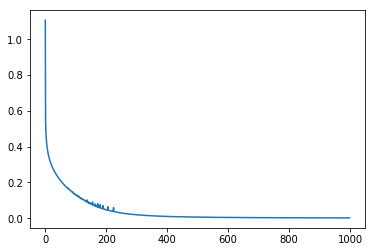

In [91]:
plt.plot(costs)

### Neural Network object 
#### NeuralNetwork(input_size, output_size, No of hidden layers, No of neurons per layer ,  activation function = "sigmoid")
 * For best results use NeuralNetwork(input_size, output_size, No of hidden layers = 2, No of neurons per layer = 500 ,  activation function = "tanh")

In [92]:
NNtanh = NeuralNetwork(X_train.shape[1] , 10, 2, 500, activation = "tanh")

### Fitting the model
#### NN.fit(Feature set, output class, epoch = 10, Learning Rate = 0.01, cost_check = False, batch = False, batch_size = -1, l2 = 0)
* For best results use NN.fit(Feature set, output class, epoch = 1000, Learning Rate = 0.01, cost_check=True, batch = True, batch_size = 500)

In [93]:
costs = NNtanh.fit(X_train, y_train_enc, 1000, 0.01, cost_check=True, batch = True, batch_size = 500)

epoch:  0 iteration:  0
epoch:  0 iteration:  1
epoch:  0 iteration:  2
epoch:  0 iteration:  3
epoch:  0 iteration:  4
epoch:  0 iteration:  5
epoch:  0 iteration:  6
epoch:  0 iteration:  7
epoch:  0 iteration:  8
epoch:  0 iteration:  9
epoch:  0 iteration:  10
epoch:  0 iteration:  11
epoch:  0 iteration:  12
epoch:  0 iteration:  13
epoch:  0 iteration:  14
epoch:  0 iteration:  15
epoch:  0 iteration:  16
epoch:  0 iteration:  17
epoch:  0 iteration:  18
epoch:  0 iteration:  19
epoch:  0 iteration:  20
epoch:  0 iteration:  21
epoch:  0 iteration:  22
epoch:  0 iteration:  23
epoch:  0 iteration:  24
epoch:  0 iteration:  25
epoch:  0 iteration:  26
epoch:  0 iteration:  27
epoch:  0 iteration:  28
epoch:  0 iteration:  29
epoch:  0 iteration:  30
epoch:  0 iteration:  31
epoch:  0 iteration:  32
epoch:  0 iteration:  33
epoch:  0 iteration:  34
epoch:  0 iteration:  35
epoch:  0 iteration:  36
epoch:  0 iteration:  37
epoch:  0 iteration:  38
epoch:  0 iteration:  39
epoch:  0 

epoch:  3 iteration:  41
epoch:  3 iteration:  42
epoch:  3 iteration:  43
epoch:  3 iteration:  44
epoch:  3 iteration:  45
epoch:  3 iteration:  46
epoch:  3 iteration:  47
epoch:  3 iteration:  48
epoch:  3 iteration:  49
epoch:  3 iteration:  50
epoch:  3 iteration:  51
epoch:  3 iteration:  52
epoch:  3 iteration:  53
epoch:  3 iteration:  54
epoch:  3 iteration:  55
epoch:  3 iteration:  56
epoch:  3 iteration:  57
epoch:  3 iteration:  58
epoch:  3 iteration:  59
epoch:  3 iteration:  60
epoch:  3 iteration:  61
epoch:  3 iteration:  62
epoch:  3 iteration:  63
epoch:  3 iteration:  64
epoch:  3 iteration:  65
epoch:  3 iteration:  66
epoch:  3 iteration:  67
epoch:  3 iteration:  68
epoch:  3 iteration:  69
epoch:  3 iteration:  70
epoch:  3 iteration:  71
epoch:  3 iteration:  72
epoch:  3 iteration:  73
epoch:  3 iteration:  74
epoch:  3 iteration:  75
epoch:  3 iteration:  76
epoch:  3 iteration:  77
epoch:  3 iteration:  78
epoch:  3 iteration:  79
epoch:  3 iteration:  80


epoch:  6 iteration:  82
epoch:  6 iteration:  83
epoch:  6 iteration:  84
epoch:  6 iteration:  85
epoch:  6 iteration:  86
epoch:  6 iteration:  87
epoch:  6 iteration:  88
epoch:  6 iteration:  89
epoch:  6 iteration:  90
epoch:  6 iteration:  91
epoch:  6 iteration:  92
epoch:  6 iteration:  93
epoch:  6 iteration:  94
epoch:  6 iteration:  95
cost[ 6 ]:  0.4852735543146452
epoch:  7 iteration:  0
epoch:  7 iteration:  1
epoch:  7 iteration:  2
epoch:  7 iteration:  3
epoch:  7 iteration:  4
epoch:  7 iteration:  5
epoch:  7 iteration:  6
epoch:  7 iteration:  7
epoch:  7 iteration:  8
epoch:  7 iteration:  9
epoch:  7 iteration:  10
epoch:  7 iteration:  11
epoch:  7 iteration:  12
epoch:  7 iteration:  13
epoch:  7 iteration:  14
epoch:  7 iteration:  15
epoch:  7 iteration:  16
epoch:  7 iteration:  17
epoch:  7 iteration:  18
epoch:  7 iteration:  19
epoch:  7 iteration:  20
epoch:  7 iteration:  21
epoch:  7 iteration:  22
epoch:  7 iteration:  23
epoch:  7 iteration:  24
epoc

epoch:  10 iteration:  30
epoch:  10 iteration:  31
epoch:  10 iteration:  32
epoch:  10 iteration:  33
epoch:  10 iteration:  34
epoch:  10 iteration:  35
epoch:  10 iteration:  36
epoch:  10 iteration:  37
epoch:  10 iteration:  38
epoch:  10 iteration:  39
epoch:  10 iteration:  40
epoch:  10 iteration:  41
epoch:  10 iteration:  42
epoch:  10 iteration:  43
epoch:  10 iteration:  44
epoch:  10 iteration:  45
epoch:  10 iteration:  46
epoch:  10 iteration:  47
epoch:  10 iteration:  48
epoch:  10 iteration:  49
epoch:  10 iteration:  50
epoch:  10 iteration:  51
epoch:  10 iteration:  52
epoch:  10 iteration:  53
epoch:  10 iteration:  54
epoch:  10 iteration:  55
epoch:  10 iteration:  56
epoch:  10 iteration:  57
epoch:  10 iteration:  58
epoch:  10 iteration:  59
epoch:  10 iteration:  60
epoch:  10 iteration:  61
epoch:  10 iteration:  62
epoch:  10 iteration:  63
epoch:  10 iteration:  64
epoch:  10 iteration:  65
epoch:  10 iteration:  66
epoch:  10 iteration:  67
epoch:  10 i

epoch:  13 iteration:  59
epoch:  13 iteration:  60
epoch:  13 iteration:  61
epoch:  13 iteration:  62
epoch:  13 iteration:  63
epoch:  13 iteration:  64
epoch:  13 iteration:  65
epoch:  13 iteration:  66
epoch:  13 iteration:  67
epoch:  13 iteration:  68
epoch:  13 iteration:  69
epoch:  13 iteration:  70
epoch:  13 iteration:  71
epoch:  13 iteration:  72
epoch:  13 iteration:  73
epoch:  13 iteration:  74
epoch:  13 iteration:  75
epoch:  13 iteration:  76
epoch:  13 iteration:  77
epoch:  13 iteration:  78
epoch:  13 iteration:  79
epoch:  13 iteration:  80
epoch:  13 iteration:  81
epoch:  13 iteration:  82
epoch:  13 iteration:  83
epoch:  13 iteration:  84
epoch:  13 iteration:  85
epoch:  13 iteration:  86
epoch:  13 iteration:  87
epoch:  13 iteration:  88
epoch:  13 iteration:  89
epoch:  13 iteration:  90
epoch:  13 iteration:  91
epoch:  13 iteration:  92
epoch:  13 iteration:  93
epoch:  13 iteration:  94
epoch:  13 iteration:  95
cost[ 13 ]:  0.4270950631547419
epoch:

epoch:  16 iteration:  91
epoch:  16 iteration:  92
epoch:  16 iteration:  93
epoch:  16 iteration:  94
epoch:  16 iteration:  95
cost[ 16 ]:  0.4133045978562717
epoch:  17 iteration:  0
epoch:  17 iteration:  1
epoch:  17 iteration:  2
epoch:  17 iteration:  3
epoch:  17 iteration:  4
epoch:  17 iteration:  5
epoch:  17 iteration:  6
epoch:  17 iteration:  7
epoch:  17 iteration:  8
epoch:  17 iteration:  9
epoch:  17 iteration:  10
epoch:  17 iteration:  11
epoch:  17 iteration:  12
epoch:  17 iteration:  13
epoch:  17 iteration:  14
epoch:  17 iteration:  15
epoch:  17 iteration:  16
epoch:  17 iteration:  17
epoch:  17 iteration:  18
epoch:  17 iteration:  19
epoch:  17 iteration:  20
epoch:  17 iteration:  21
epoch:  17 iteration:  22
epoch:  17 iteration:  23
epoch:  17 iteration:  24
epoch:  17 iteration:  25
epoch:  17 iteration:  26
epoch:  17 iteration:  27
epoch:  17 iteration:  28
epoch:  17 iteration:  29
epoch:  17 iteration:  30
epoch:  17 iteration:  31
epoch:  17 itera

epoch:  20 iteration:  19
epoch:  20 iteration:  20
epoch:  20 iteration:  21
epoch:  20 iteration:  22
epoch:  20 iteration:  23
epoch:  20 iteration:  24
epoch:  20 iteration:  25
epoch:  20 iteration:  26
epoch:  20 iteration:  27
epoch:  20 iteration:  28
epoch:  20 iteration:  29
epoch:  20 iteration:  30
epoch:  20 iteration:  31
epoch:  20 iteration:  32
epoch:  20 iteration:  33
epoch:  20 iteration:  34
epoch:  20 iteration:  35
epoch:  20 iteration:  36
epoch:  20 iteration:  37
epoch:  20 iteration:  38
epoch:  20 iteration:  39
epoch:  20 iteration:  40
epoch:  20 iteration:  41
epoch:  20 iteration:  42
epoch:  20 iteration:  43
epoch:  20 iteration:  44
epoch:  20 iteration:  45
epoch:  20 iteration:  46
epoch:  20 iteration:  47
epoch:  20 iteration:  48
epoch:  20 iteration:  49
epoch:  20 iteration:  50
epoch:  20 iteration:  51
epoch:  20 iteration:  52
epoch:  20 iteration:  53
epoch:  20 iteration:  54
epoch:  20 iteration:  55
epoch:  20 iteration:  56
epoch:  20 i

epoch:  23 iteration:  55
epoch:  23 iteration:  56
epoch:  23 iteration:  57
epoch:  23 iteration:  58
epoch:  23 iteration:  59
epoch:  23 iteration:  60
epoch:  23 iteration:  61
epoch:  23 iteration:  62
epoch:  23 iteration:  63
epoch:  23 iteration:  64
epoch:  23 iteration:  65
epoch:  23 iteration:  66
epoch:  23 iteration:  67
epoch:  23 iteration:  68
epoch:  23 iteration:  69
epoch:  23 iteration:  70
epoch:  23 iteration:  71
epoch:  23 iteration:  72
epoch:  23 iteration:  73
epoch:  23 iteration:  74
epoch:  23 iteration:  75
epoch:  23 iteration:  76
epoch:  23 iteration:  77
epoch:  23 iteration:  78
epoch:  23 iteration:  79
epoch:  23 iteration:  80
epoch:  23 iteration:  81
epoch:  23 iteration:  82
epoch:  23 iteration:  83
epoch:  23 iteration:  84
epoch:  23 iteration:  85
epoch:  23 iteration:  86
epoch:  23 iteration:  87
epoch:  23 iteration:  88
epoch:  23 iteration:  89
epoch:  23 iteration:  90
epoch:  23 iteration:  91
epoch:  23 iteration:  92
epoch:  23 i

epoch:  26 iteration:  84
epoch:  26 iteration:  85
epoch:  26 iteration:  86
epoch:  26 iteration:  87
epoch:  26 iteration:  88
epoch:  26 iteration:  89
epoch:  26 iteration:  90
epoch:  26 iteration:  91
epoch:  26 iteration:  92
epoch:  26 iteration:  93
epoch:  26 iteration:  94
epoch:  26 iteration:  95
cost[ 26 ]:  0.3974149365754743
epoch:  27 iteration:  0
epoch:  27 iteration:  1
epoch:  27 iteration:  2
epoch:  27 iteration:  3
epoch:  27 iteration:  4
epoch:  27 iteration:  5
epoch:  27 iteration:  6
epoch:  27 iteration:  7
epoch:  27 iteration:  8
epoch:  27 iteration:  9
epoch:  27 iteration:  10
epoch:  27 iteration:  11
epoch:  27 iteration:  12
epoch:  27 iteration:  13
epoch:  27 iteration:  14
epoch:  27 iteration:  15
epoch:  27 iteration:  16
epoch:  27 iteration:  17
epoch:  27 iteration:  18
epoch:  27 iteration:  19
epoch:  27 iteration:  20
epoch:  27 iteration:  21
epoch:  27 iteration:  22
epoch:  27 iteration:  23
epoch:  27 iteration:  24
epoch:  27 itera

epoch:  30 iteration:  16
epoch:  30 iteration:  17
epoch:  30 iteration:  18
epoch:  30 iteration:  19
epoch:  30 iteration:  20
epoch:  30 iteration:  21
epoch:  30 iteration:  22
epoch:  30 iteration:  23
epoch:  30 iteration:  24
epoch:  30 iteration:  25
epoch:  30 iteration:  26
epoch:  30 iteration:  27
epoch:  30 iteration:  28
epoch:  30 iteration:  29
epoch:  30 iteration:  30
epoch:  30 iteration:  31
epoch:  30 iteration:  32
epoch:  30 iteration:  33
epoch:  30 iteration:  34
epoch:  30 iteration:  35
epoch:  30 iteration:  36
epoch:  30 iteration:  37
epoch:  30 iteration:  38
epoch:  30 iteration:  39
epoch:  30 iteration:  40
epoch:  30 iteration:  41
epoch:  30 iteration:  42
epoch:  30 iteration:  43
epoch:  30 iteration:  44
epoch:  30 iteration:  45
epoch:  30 iteration:  46
epoch:  30 iteration:  47
epoch:  30 iteration:  48
epoch:  30 iteration:  49
epoch:  30 iteration:  50
epoch:  30 iteration:  51
epoch:  30 iteration:  52
epoch:  30 iteration:  53
epoch:  30 i

epoch:  33 iteration:  43
epoch:  33 iteration:  44
epoch:  33 iteration:  45
epoch:  33 iteration:  46
epoch:  33 iteration:  47
epoch:  33 iteration:  48
epoch:  33 iteration:  49
epoch:  33 iteration:  50
epoch:  33 iteration:  51
epoch:  33 iteration:  52
epoch:  33 iteration:  53
epoch:  33 iteration:  54
epoch:  33 iteration:  55
epoch:  33 iteration:  56
epoch:  33 iteration:  57
epoch:  33 iteration:  58
epoch:  33 iteration:  59
epoch:  33 iteration:  60
epoch:  33 iteration:  61
epoch:  33 iteration:  62
epoch:  33 iteration:  63
epoch:  33 iteration:  64
epoch:  33 iteration:  65
epoch:  33 iteration:  66
epoch:  33 iteration:  67
epoch:  33 iteration:  68
epoch:  33 iteration:  69
epoch:  33 iteration:  70
epoch:  33 iteration:  71
epoch:  33 iteration:  72
epoch:  33 iteration:  73
epoch:  33 iteration:  74
epoch:  33 iteration:  75
epoch:  33 iteration:  76
epoch:  33 iteration:  77
epoch:  33 iteration:  78
epoch:  33 iteration:  79
epoch:  33 iteration:  80
epoch:  33 i

epoch:  36 iteration:  70
epoch:  36 iteration:  71
epoch:  36 iteration:  72
epoch:  36 iteration:  73
epoch:  36 iteration:  74
epoch:  36 iteration:  75
epoch:  36 iteration:  76
epoch:  36 iteration:  77
epoch:  36 iteration:  78
epoch:  36 iteration:  79
epoch:  36 iteration:  80
epoch:  36 iteration:  81
epoch:  36 iteration:  82
epoch:  36 iteration:  83
epoch:  36 iteration:  84
epoch:  36 iteration:  85
epoch:  36 iteration:  86
epoch:  36 iteration:  87
epoch:  36 iteration:  88
epoch:  36 iteration:  89
epoch:  36 iteration:  90
epoch:  36 iteration:  91
epoch:  36 iteration:  92
epoch:  36 iteration:  93
epoch:  36 iteration:  94
epoch:  36 iteration:  95
cost[ 36 ]:  0.39874309801348035
epoch:  37 iteration:  0
epoch:  37 iteration:  1
epoch:  37 iteration:  2
epoch:  37 iteration:  3
epoch:  37 iteration:  4
epoch:  37 iteration:  5
epoch:  37 iteration:  6
epoch:  37 iteration:  7
epoch:  37 iteration:  8
epoch:  37 iteration:  9
epoch:  37 iteration:  10
epoch:  37 iter

epoch:  40 iteration:  6
epoch:  40 iteration:  7
epoch:  40 iteration:  8
epoch:  40 iteration:  9
epoch:  40 iteration:  10
epoch:  40 iteration:  11
epoch:  40 iteration:  12
epoch:  40 iteration:  13
epoch:  40 iteration:  14
epoch:  40 iteration:  15
epoch:  40 iteration:  16
epoch:  40 iteration:  17
epoch:  40 iteration:  18
epoch:  40 iteration:  19
epoch:  40 iteration:  20
epoch:  40 iteration:  21
epoch:  40 iteration:  22
epoch:  40 iteration:  23
epoch:  40 iteration:  24
epoch:  40 iteration:  25
epoch:  40 iteration:  26
epoch:  40 iteration:  27
epoch:  40 iteration:  28
epoch:  40 iteration:  29
epoch:  40 iteration:  30
epoch:  40 iteration:  31
epoch:  40 iteration:  32
epoch:  40 iteration:  33
epoch:  40 iteration:  34
epoch:  40 iteration:  35
epoch:  40 iteration:  36
epoch:  40 iteration:  37
epoch:  40 iteration:  38
epoch:  40 iteration:  39
epoch:  40 iteration:  40
epoch:  40 iteration:  41
epoch:  40 iteration:  42
epoch:  40 iteration:  43
epoch:  40 itera

epoch:  43 iteration:  34
epoch:  43 iteration:  35
epoch:  43 iteration:  36
epoch:  43 iteration:  37
epoch:  43 iteration:  38
epoch:  43 iteration:  39
epoch:  43 iteration:  40
epoch:  43 iteration:  41
epoch:  43 iteration:  42
epoch:  43 iteration:  43
epoch:  43 iteration:  44
epoch:  43 iteration:  45
epoch:  43 iteration:  46
epoch:  43 iteration:  47
epoch:  43 iteration:  48
epoch:  43 iteration:  49
epoch:  43 iteration:  50
epoch:  43 iteration:  51
epoch:  43 iteration:  52
epoch:  43 iteration:  53
epoch:  43 iteration:  54
epoch:  43 iteration:  55
epoch:  43 iteration:  56
epoch:  43 iteration:  57
epoch:  43 iteration:  58
epoch:  43 iteration:  59
epoch:  43 iteration:  60
epoch:  43 iteration:  61
epoch:  43 iteration:  62
epoch:  43 iteration:  63
epoch:  43 iteration:  64
epoch:  43 iteration:  65
epoch:  43 iteration:  66
epoch:  43 iteration:  67
epoch:  43 iteration:  68
epoch:  43 iteration:  69
epoch:  43 iteration:  70
epoch:  43 iteration:  71
epoch:  43 i

epoch:  46 iteration:  66
epoch:  46 iteration:  67
epoch:  46 iteration:  68
epoch:  46 iteration:  69
epoch:  46 iteration:  70
epoch:  46 iteration:  71
epoch:  46 iteration:  72
epoch:  46 iteration:  73
epoch:  46 iteration:  74
epoch:  46 iteration:  75
epoch:  46 iteration:  76
epoch:  46 iteration:  77
epoch:  46 iteration:  78
epoch:  46 iteration:  79
epoch:  46 iteration:  80
epoch:  46 iteration:  81
epoch:  46 iteration:  82
epoch:  46 iteration:  83
epoch:  46 iteration:  84
epoch:  46 iteration:  85
epoch:  46 iteration:  86
epoch:  46 iteration:  87
epoch:  46 iteration:  88
epoch:  46 iteration:  89
epoch:  46 iteration:  90
epoch:  46 iteration:  91
epoch:  46 iteration:  92
epoch:  46 iteration:  93
epoch:  46 iteration:  94
epoch:  46 iteration:  95
cost[ 46 ]:  0.39664591295185564
epoch:  47 iteration:  0
epoch:  47 iteration:  1
epoch:  47 iteration:  2
epoch:  47 iteration:  3
epoch:  47 iteration:  4
epoch:  47 iteration:  5
epoch:  47 iteration:  6
epoch:  47 i

epoch:  49 iteration:  95
cost[ 49 ]:  0.3953666719937688
epoch:  50 iteration:  0
epoch:  50 iteration:  1
epoch:  50 iteration:  2
epoch:  50 iteration:  3
epoch:  50 iteration:  4
epoch:  50 iteration:  5
epoch:  50 iteration:  6
epoch:  50 iteration:  7
epoch:  50 iteration:  8
epoch:  50 iteration:  9
epoch:  50 iteration:  10
epoch:  50 iteration:  11
epoch:  50 iteration:  12
epoch:  50 iteration:  13
epoch:  50 iteration:  14
epoch:  50 iteration:  15
epoch:  50 iteration:  16
epoch:  50 iteration:  17
epoch:  50 iteration:  18
epoch:  50 iteration:  19
epoch:  50 iteration:  20
epoch:  50 iteration:  21
epoch:  50 iteration:  22
epoch:  50 iteration:  23
epoch:  50 iteration:  24
epoch:  50 iteration:  25
epoch:  50 iteration:  26
epoch:  50 iteration:  27
epoch:  50 iteration:  28
epoch:  50 iteration:  29
epoch:  50 iteration:  30
epoch:  50 iteration:  31
epoch:  50 iteration:  32
epoch:  50 iteration:  33
epoch:  50 iteration:  34
epoch:  50 iteration:  35
epoch:  50 itera

epoch:  53 iteration:  23
epoch:  53 iteration:  24
epoch:  53 iteration:  25
epoch:  53 iteration:  26
epoch:  53 iteration:  27
epoch:  53 iteration:  28
epoch:  53 iteration:  29
epoch:  53 iteration:  30
epoch:  53 iteration:  31
epoch:  53 iteration:  32
epoch:  53 iteration:  33
epoch:  53 iteration:  34
epoch:  53 iteration:  35
epoch:  53 iteration:  36
epoch:  53 iteration:  37
epoch:  53 iteration:  38
epoch:  53 iteration:  39
epoch:  53 iteration:  40
epoch:  53 iteration:  41
epoch:  53 iteration:  42
epoch:  53 iteration:  43
epoch:  53 iteration:  44
epoch:  53 iteration:  45
epoch:  53 iteration:  46
epoch:  53 iteration:  47
epoch:  53 iteration:  48
epoch:  53 iteration:  49
epoch:  53 iteration:  50
epoch:  53 iteration:  51
epoch:  53 iteration:  52
epoch:  53 iteration:  53
epoch:  53 iteration:  54
epoch:  53 iteration:  55
epoch:  53 iteration:  56
epoch:  53 iteration:  57
epoch:  53 iteration:  58
epoch:  53 iteration:  59
epoch:  53 iteration:  60
epoch:  53 i

epoch:  56 iteration:  57
epoch:  56 iteration:  58
epoch:  56 iteration:  59
epoch:  56 iteration:  60
epoch:  56 iteration:  61
epoch:  56 iteration:  62
epoch:  56 iteration:  63
epoch:  56 iteration:  64
epoch:  56 iteration:  65
epoch:  56 iteration:  66
epoch:  56 iteration:  67
epoch:  56 iteration:  68
epoch:  56 iteration:  69
epoch:  56 iteration:  70
epoch:  56 iteration:  71
epoch:  56 iteration:  72
epoch:  56 iteration:  73
epoch:  56 iteration:  74
epoch:  56 iteration:  75
epoch:  56 iteration:  76
epoch:  56 iteration:  77
epoch:  56 iteration:  78
epoch:  56 iteration:  79
epoch:  56 iteration:  80
epoch:  56 iteration:  81
epoch:  56 iteration:  82
epoch:  56 iteration:  83
epoch:  56 iteration:  84
epoch:  56 iteration:  85
epoch:  56 iteration:  86
epoch:  56 iteration:  87
epoch:  56 iteration:  88
epoch:  56 iteration:  89
epoch:  56 iteration:  90
epoch:  56 iteration:  91
epoch:  56 iteration:  92
epoch:  56 iteration:  93
epoch:  56 iteration:  94
epoch:  56 i

epoch:  59 iteration:  85
epoch:  59 iteration:  86
epoch:  59 iteration:  87
epoch:  59 iteration:  88
epoch:  59 iteration:  89
epoch:  59 iteration:  90
epoch:  59 iteration:  91
epoch:  59 iteration:  92
epoch:  59 iteration:  93
epoch:  59 iteration:  94
epoch:  59 iteration:  95
cost[ 59 ]:  0.40321865825135556
epoch:  60 iteration:  0
epoch:  60 iteration:  1
epoch:  60 iteration:  2
epoch:  60 iteration:  3
epoch:  60 iteration:  4
epoch:  60 iteration:  5
epoch:  60 iteration:  6
epoch:  60 iteration:  7
epoch:  60 iteration:  8
epoch:  60 iteration:  9
epoch:  60 iteration:  10
epoch:  60 iteration:  11
epoch:  60 iteration:  12
epoch:  60 iteration:  13
epoch:  60 iteration:  14
epoch:  60 iteration:  15
epoch:  60 iteration:  16
epoch:  60 iteration:  17
epoch:  60 iteration:  18
epoch:  60 iteration:  19
epoch:  60 iteration:  20
epoch:  60 iteration:  21
epoch:  60 iteration:  22
epoch:  60 iteration:  23
epoch:  60 iteration:  24
epoch:  60 iteration:  25
epoch:  60 iter

epoch:  63 iteration:  22
epoch:  63 iteration:  23
epoch:  63 iteration:  24
epoch:  63 iteration:  25
epoch:  63 iteration:  26
epoch:  63 iteration:  27
epoch:  63 iteration:  28
epoch:  63 iteration:  29
epoch:  63 iteration:  30
epoch:  63 iteration:  31
epoch:  63 iteration:  32
epoch:  63 iteration:  33
epoch:  63 iteration:  34
epoch:  63 iteration:  35
epoch:  63 iteration:  36
epoch:  63 iteration:  37
epoch:  63 iteration:  38
epoch:  63 iteration:  39
epoch:  63 iteration:  40
epoch:  63 iteration:  41
epoch:  63 iteration:  42
epoch:  63 iteration:  43
epoch:  63 iteration:  44
epoch:  63 iteration:  45
epoch:  63 iteration:  46
epoch:  63 iteration:  47
epoch:  63 iteration:  48
epoch:  63 iteration:  49
epoch:  63 iteration:  50
epoch:  63 iteration:  51
epoch:  63 iteration:  52
epoch:  63 iteration:  53
epoch:  63 iteration:  54
epoch:  63 iteration:  55
epoch:  63 iteration:  56
epoch:  63 iteration:  57
epoch:  63 iteration:  58
epoch:  63 iteration:  59
epoch:  63 i

epoch:  66 iteration:  53
epoch:  66 iteration:  54
epoch:  66 iteration:  55
epoch:  66 iteration:  56
epoch:  66 iteration:  57
epoch:  66 iteration:  58
epoch:  66 iteration:  59
epoch:  66 iteration:  60
epoch:  66 iteration:  61
epoch:  66 iteration:  62
epoch:  66 iteration:  63
epoch:  66 iteration:  64
epoch:  66 iteration:  65
epoch:  66 iteration:  66
epoch:  66 iteration:  67
epoch:  66 iteration:  68
epoch:  66 iteration:  69
epoch:  66 iteration:  70
epoch:  66 iteration:  71
epoch:  66 iteration:  72
epoch:  66 iteration:  73
epoch:  66 iteration:  74
epoch:  66 iteration:  75
epoch:  66 iteration:  76
epoch:  66 iteration:  77
epoch:  66 iteration:  78
epoch:  66 iteration:  79
epoch:  66 iteration:  80
epoch:  66 iteration:  81
epoch:  66 iteration:  82
epoch:  66 iteration:  83
epoch:  66 iteration:  84
epoch:  66 iteration:  85
epoch:  66 iteration:  86
epoch:  66 iteration:  87
epoch:  66 iteration:  88
epoch:  66 iteration:  89
epoch:  66 iteration:  90
epoch:  66 i

epoch:  69 iteration:  85
epoch:  69 iteration:  86
epoch:  69 iteration:  87
epoch:  69 iteration:  88
epoch:  69 iteration:  89
epoch:  69 iteration:  90
epoch:  69 iteration:  91
epoch:  69 iteration:  92
epoch:  69 iteration:  93
epoch:  69 iteration:  94
epoch:  69 iteration:  95
cost[ 69 ]:  0.4018170160761841
epoch:  70 iteration:  0
epoch:  70 iteration:  1
epoch:  70 iteration:  2
epoch:  70 iteration:  3
epoch:  70 iteration:  4
epoch:  70 iteration:  5
epoch:  70 iteration:  6
epoch:  70 iteration:  7
epoch:  70 iteration:  8
epoch:  70 iteration:  9
epoch:  70 iteration:  10
epoch:  70 iteration:  11
epoch:  70 iteration:  12
epoch:  70 iteration:  13
epoch:  70 iteration:  14
epoch:  70 iteration:  15
epoch:  70 iteration:  16
epoch:  70 iteration:  17
epoch:  70 iteration:  18
epoch:  70 iteration:  19
epoch:  70 iteration:  20
epoch:  70 iteration:  21
epoch:  70 iteration:  22
epoch:  70 iteration:  23
epoch:  70 iteration:  24
epoch:  70 iteration:  25
epoch:  70 itera

epoch:  73 iteration:  16
epoch:  73 iteration:  17
epoch:  73 iteration:  18
epoch:  73 iteration:  19
epoch:  73 iteration:  20
epoch:  73 iteration:  21
epoch:  73 iteration:  22
epoch:  73 iteration:  23
epoch:  73 iteration:  24
epoch:  73 iteration:  25
epoch:  73 iteration:  26
epoch:  73 iteration:  27
epoch:  73 iteration:  28
epoch:  73 iteration:  29
epoch:  73 iteration:  30
epoch:  73 iteration:  31
epoch:  73 iteration:  32
epoch:  73 iteration:  33
epoch:  73 iteration:  34
epoch:  73 iteration:  35
epoch:  73 iteration:  36
epoch:  73 iteration:  37
epoch:  73 iteration:  38
epoch:  73 iteration:  39
epoch:  73 iteration:  40
epoch:  73 iteration:  41
epoch:  73 iteration:  42
epoch:  73 iteration:  43
epoch:  73 iteration:  44
epoch:  73 iteration:  45
epoch:  73 iteration:  46
epoch:  73 iteration:  47
epoch:  73 iteration:  48
epoch:  73 iteration:  49
epoch:  73 iteration:  50
epoch:  73 iteration:  51
epoch:  73 iteration:  52
epoch:  73 iteration:  53
epoch:  73 i

epoch:  76 iteration:  43
epoch:  76 iteration:  44
epoch:  76 iteration:  45
epoch:  76 iteration:  46
epoch:  76 iteration:  47
epoch:  76 iteration:  48
epoch:  76 iteration:  49
epoch:  76 iteration:  50
epoch:  76 iteration:  51
epoch:  76 iteration:  52
epoch:  76 iteration:  53
epoch:  76 iteration:  54
epoch:  76 iteration:  55
epoch:  76 iteration:  56
epoch:  76 iteration:  57
epoch:  76 iteration:  58
epoch:  76 iteration:  59
epoch:  76 iteration:  60
epoch:  76 iteration:  61
epoch:  76 iteration:  62
epoch:  76 iteration:  63
epoch:  76 iteration:  64
epoch:  76 iteration:  65
epoch:  76 iteration:  66
epoch:  76 iteration:  67
epoch:  76 iteration:  68
epoch:  76 iteration:  69
epoch:  76 iteration:  70
epoch:  76 iteration:  71
epoch:  76 iteration:  72
epoch:  76 iteration:  73
epoch:  76 iteration:  74
epoch:  76 iteration:  75
epoch:  76 iteration:  76
epoch:  76 iteration:  77
epoch:  76 iteration:  78
epoch:  76 iteration:  79
epoch:  76 iteration:  80
epoch:  76 i

epoch:  79 iteration:  68
epoch:  79 iteration:  69
epoch:  79 iteration:  70
epoch:  79 iteration:  71
epoch:  79 iteration:  72
epoch:  79 iteration:  73
epoch:  79 iteration:  74
epoch:  79 iteration:  75
epoch:  79 iteration:  76
epoch:  79 iteration:  77
epoch:  79 iteration:  78
epoch:  79 iteration:  79
epoch:  79 iteration:  80
epoch:  79 iteration:  81
epoch:  79 iteration:  82
epoch:  79 iteration:  83
epoch:  79 iteration:  84
epoch:  79 iteration:  85
epoch:  79 iteration:  86
epoch:  79 iteration:  87
epoch:  79 iteration:  88
epoch:  79 iteration:  89
epoch:  79 iteration:  90
epoch:  79 iteration:  91
epoch:  79 iteration:  92
epoch:  79 iteration:  93
epoch:  79 iteration:  94
epoch:  79 iteration:  95
cost[ 79 ]:  0.4120649829461135
epoch:  80 iteration:  0
epoch:  80 iteration:  1
epoch:  80 iteration:  2
epoch:  80 iteration:  3
epoch:  80 iteration:  4
epoch:  80 iteration:  5
epoch:  80 iteration:  6
epoch:  80 iteration:  7
epoch:  80 iteration:  8
epoch:  80 iter

cost[ 82 ]:  0.40367765585799215
epoch:  83 iteration:  0
epoch:  83 iteration:  1
epoch:  83 iteration:  2
epoch:  83 iteration:  3
epoch:  83 iteration:  4
epoch:  83 iteration:  5
epoch:  83 iteration:  6
epoch:  83 iteration:  7
epoch:  83 iteration:  8
epoch:  83 iteration:  9
epoch:  83 iteration:  10
epoch:  83 iteration:  11
epoch:  83 iteration:  12
epoch:  83 iteration:  13
epoch:  83 iteration:  14
epoch:  83 iteration:  15
epoch:  83 iteration:  16
epoch:  83 iteration:  17
epoch:  83 iteration:  18
epoch:  83 iteration:  19
epoch:  83 iteration:  20
epoch:  83 iteration:  21
epoch:  83 iteration:  22
epoch:  83 iteration:  23
epoch:  83 iteration:  24
epoch:  83 iteration:  25
epoch:  83 iteration:  26
epoch:  83 iteration:  27
epoch:  83 iteration:  28
epoch:  83 iteration:  29
epoch:  83 iteration:  30
epoch:  83 iteration:  31
epoch:  83 iteration:  32
epoch:  83 iteration:  33
epoch:  83 iteration:  34
epoch:  83 iteration:  35
epoch:  83 iteration:  36
epoch:  83 iter

epoch:  86 iteration:  24
epoch:  86 iteration:  25
epoch:  86 iteration:  26
epoch:  86 iteration:  27
epoch:  86 iteration:  28
epoch:  86 iteration:  29
epoch:  86 iteration:  30
epoch:  86 iteration:  31
epoch:  86 iteration:  32
epoch:  86 iteration:  33
epoch:  86 iteration:  34
epoch:  86 iteration:  35
epoch:  86 iteration:  36
epoch:  86 iteration:  37
epoch:  86 iteration:  38
epoch:  86 iteration:  39
epoch:  86 iteration:  40
epoch:  86 iteration:  41
epoch:  86 iteration:  42
epoch:  86 iteration:  43
epoch:  86 iteration:  44
epoch:  86 iteration:  45
epoch:  86 iteration:  46
epoch:  86 iteration:  47
epoch:  86 iteration:  48
epoch:  86 iteration:  49
epoch:  86 iteration:  50
epoch:  86 iteration:  51
epoch:  86 iteration:  52
epoch:  86 iteration:  53
epoch:  86 iteration:  54
epoch:  86 iteration:  55
epoch:  86 iteration:  56
epoch:  86 iteration:  57
epoch:  86 iteration:  58
epoch:  86 iteration:  59
epoch:  86 iteration:  60
epoch:  86 iteration:  61
epoch:  86 i

epoch:  89 iteration:  54
epoch:  89 iteration:  55
epoch:  89 iteration:  56
epoch:  89 iteration:  57
epoch:  89 iteration:  58
epoch:  89 iteration:  59
epoch:  89 iteration:  60
epoch:  89 iteration:  61
epoch:  89 iteration:  62
epoch:  89 iteration:  63
epoch:  89 iteration:  64
epoch:  89 iteration:  65
epoch:  89 iteration:  66
epoch:  89 iteration:  67
epoch:  89 iteration:  68
epoch:  89 iteration:  69
epoch:  89 iteration:  70
epoch:  89 iteration:  71
epoch:  89 iteration:  72
epoch:  89 iteration:  73
epoch:  89 iteration:  74
epoch:  89 iteration:  75
epoch:  89 iteration:  76
epoch:  89 iteration:  77
epoch:  89 iteration:  78
epoch:  89 iteration:  79
epoch:  89 iteration:  80
epoch:  89 iteration:  81
epoch:  89 iteration:  82
epoch:  89 iteration:  83
epoch:  89 iteration:  84
epoch:  89 iteration:  85
epoch:  89 iteration:  86
epoch:  89 iteration:  87
epoch:  89 iteration:  88
epoch:  89 iteration:  89
epoch:  89 iteration:  90
epoch:  89 iteration:  91
epoch:  89 i

epoch:  92 iteration:  86
epoch:  92 iteration:  87
epoch:  92 iteration:  88
epoch:  92 iteration:  89
epoch:  92 iteration:  90
epoch:  92 iteration:  91
epoch:  92 iteration:  92
epoch:  92 iteration:  93
epoch:  92 iteration:  94
epoch:  92 iteration:  95
cost[ 92 ]:  0.41745350178805274
epoch:  93 iteration:  0
epoch:  93 iteration:  1
epoch:  93 iteration:  2
epoch:  93 iteration:  3
epoch:  93 iteration:  4
epoch:  93 iteration:  5
epoch:  93 iteration:  6
epoch:  93 iteration:  7
epoch:  93 iteration:  8
epoch:  93 iteration:  9
epoch:  93 iteration:  10
epoch:  93 iteration:  11
epoch:  93 iteration:  12
epoch:  93 iteration:  13
epoch:  93 iteration:  14
epoch:  93 iteration:  15
epoch:  93 iteration:  16
epoch:  93 iteration:  17
epoch:  93 iteration:  18
epoch:  93 iteration:  19
epoch:  93 iteration:  20
epoch:  93 iteration:  21
epoch:  93 iteration:  22
epoch:  93 iteration:  23
epoch:  93 iteration:  24
epoch:  93 iteration:  25
epoch:  93 iteration:  26
epoch:  93 iter

epoch:  96 iteration:  19
epoch:  96 iteration:  20
epoch:  96 iteration:  21
epoch:  96 iteration:  22
epoch:  96 iteration:  23
epoch:  96 iteration:  24
epoch:  96 iteration:  25
epoch:  96 iteration:  26
epoch:  96 iteration:  27
epoch:  96 iteration:  28
epoch:  96 iteration:  29
epoch:  96 iteration:  30
epoch:  96 iteration:  31
epoch:  96 iteration:  32
epoch:  96 iteration:  33
epoch:  96 iteration:  34
epoch:  96 iteration:  35
epoch:  96 iteration:  36
epoch:  96 iteration:  37
epoch:  96 iteration:  38
epoch:  96 iteration:  39
epoch:  96 iteration:  40
epoch:  96 iteration:  41
epoch:  96 iteration:  42
epoch:  96 iteration:  43
epoch:  96 iteration:  44
epoch:  96 iteration:  45
epoch:  96 iteration:  46
epoch:  96 iteration:  47
epoch:  96 iteration:  48
epoch:  96 iteration:  49
epoch:  96 iteration:  50
epoch:  96 iteration:  51
epoch:  96 iteration:  52
epoch:  96 iteration:  53
epoch:  96 iteration:  54
epoch:  96 iteration:  55
epoch:  96 iteration:  56
epoch:  96 i

epoch:  99 iteration:  46
epoch:  99 iteration:  47
epoch:  99 iteration:  48
epoch:  99 iteration:  49
epoch:  99 iteration:  50
epoch:  99 iteration:  51
epoch:  99 iteration:  52
epoch:  99 iteration:  53
epoch:  99 iteration:  54
epoch:  99 iteration:  55
epoch:  99 iteration:  56
epoch:  99 iteration:  57
epoch:  99 iteration:  58
epoch:  99 iteration:  59
epoch:  99 iteration:  60
epoch:  99 iteration:  61
epoch:  99 iteration:  62
epoch:  99 iteration:  63
epoch:  99 iteration:  64
epoch:  99 iteration:  65
epoch:  99 iteration:  66
epoch:  99 iteration:  67
epoch:  99 iteration:  68
epoch:  99 iteration:  69
epoch:  99 iteration:  70
epoch:  99 iteration:  71
epoch:  99 iteration:  72
epoch:  99 iteration:  73
epoch:  99 iteration:  74
epoch:  99 iteration:  75
epoch:  99 iteration:  76
epoch:  99 iteration:  77
epoch:  99 iteration:  78
epoch:  99 iteration:  79
epoch:  99 iteration:  80
epoch:  99 iteration:  81
epoch:  99 iteration:  82
epoch:  99 iteration:  83
epoch:  99 i

epoch:  102 iteration:  66
epoch:  102 iteration:  67
epoch:  102 iteration:  68
epoch:  102 iteration:  69
epoch:  102 iteration:  70
epoch:  102 iteration:  71
epoch:  102 iteration:  72
epoch:  102 iteration:  73
epoch:  102 iteration:  74
epoch:  102 iteration:  75
epoch:  102 iteration:  76
epoch:  102 iteration:  77
epoch:  102 iteration:  78
epoch:  102 iteration:  79
epoch:  102 iteration:  80
epoch:  102 iteration:  81
epoch:  102 iteration:  82
epoch:  102 iteration:  83
epoch:  102 iteration:  84
epoch:  102 iteration:  85
epoch:  102 iteration:  86
epoch:  102 iteration:  87
epoch:  102 iteration:  88
epoch:  102 iteration:  89
epoch:  102 iteration:  90
epoch:  102 iteration:  91
epoch:  102 iteration:  92
epoch:  102 iteration:  93
epoch:  102 iteration:  94
epoch:  102 iteration:  95
cost[ 102 ]:  0.41310308786200045
epoch:  103 iteration:  0
epoch:  103 iteration:  1
epoch:  103 iteration:  2
epoch:  103 iteration:  3
epoch:  103 iteration:  4
epoch:  103 iteration:  5


epoch:  105 iteration:  82
epoch:  105 iteration:  83
epoch:  105 iteration:  84
epoch:  105 iteration:  85
epoch:  105 iteration:  86
epoch:  105 iteration:  87
epoch:  105 iteration:  88
epoch:  105 iteration:  89
epoch:  105 iteration:  90
epoch:  105 iteration:  91
epoch:  105 iteration:  92
epoch:  105 iteration:  93
epoch:  105 iteration:  94
epoch:  105 iteration:  95
cost[ 105 ]:  0.4083576905060511
epoch:  106 iteration:  0
epoch:  106 iteration:  1
epoch:  106 iteration:  2
epoch:  106 iteration:  3
epoch:  106 iteration:  4
epoch:  106 iteration:  5
epoch:  106 iteration:  6
epoch:  106 iteration:  7
epoch:  106 iteration:  8
epoch:  106 iteration:  9
epoch:  106 iteration:  10
epoch:  106 iteration:  11
epoch:  106 iteration:  12
epoch:  106 iteration:  13
epoch:  106 iteration:  14
epoch:  106 iteration:  15
epoch:  106 iteration:  16
epoch:  106 iteration:  17
epoch:  106 iteration:  18
epoch:  106 iteration:  19
epoch:  106 iteration:  20
epoch:  106 iteration:  21
epoch

epoch:  109 iteration:  5
epoch:  109 iteration:  6
epoch:  109 iteration:  7
epoch:  109 iteration:  8
epoch:  109 iteration:  9
epoch:  109 iteration:  10
epoch:  109 iteration:  11
epoch:  109 iteration:  12
epoch:  109 iteration:  13
epoch:  109 iteration:  14
epoch:  109 iteration:  15
epoch:  109 iteration:  16
epoch:  109 iteration:  17
epoch:  109 iteration:  18
epoch:  109 iteration:  19
epoch:  109 iteration:  20
epoch:  109 iteration:  21
epoch:  109 iteration:  22
epoch:  109 iteration:  23
epoch:  109 iteration:  24
epoch:  109 iteration:  25
epoch:  109 iteration:  26
epoch:  109 iteration:  27
epoch:  109 iteration:  28
epoch:  109 iteration:  29
epoch:  109 iteration:  30
epoch:  109 iteration:  31
epoch:  109 iteration:  32
epoch:  109 iteration:  33
epoch:  109 iteration:  34
epoch:  109 iteration:  35
epoch:  109 iteration:  36
epoch:  109 iteration:  37
epoch:  109 iteration:  38
epoch:  109 iteration:  39
epoch:  109 iteration:  40
epoch:  109 iteration:  41
epoch:

epoch:  112 iteration:  27
epoch:  112 iteration:  28
epoch:  112 iteration:  29
epoch:  112 iteration:  30
epoch:  112 iteration:  31
epoch:  112 iteration:  32
epoch:  112 iteration:  33
epoch:  112 iteration:  34
epoch:  112 iteration:  35
epoch:  112 iteration:  36
epoch:  112 iteration:  37
epoch:  112 iteration:  38
epoch:  112 iteration:  39
epoch:  112 iteration:  40
epoch:  112 iteration:  41
epoch:  112 iteration:  42
epoch:  112 iteration:  43
epoch:  112 iteration:  44
epoch:  112 iteration:  45
epoch:  112 iteration:  46
epoch:  112 iteration:  47
epoch:  112 iteration:  48
epoch:  112 iteration:  49
epoch:  112 iteration:  50
epoch:  112 iteration:  51
epoch:  112 iteration:  52
epoch:  112 iteration:  53
epoch:  112 iteration:  54
epoch:  112 iteration:  55
epoch:  112 iteration:  56
epoch:  112 iteration:  57
epoch:  112 iteration:  58
epoch:  112 iteration:  59
epoch:  112 iteration:  60
epoch:  112 iteration:  61
epoch:  112 iteration:  62
epoch:  112 iteration:  63
e

epoch:  115 iteration:  45
epoch:  115 iteration:  46
epoch:  115 iteration:  47
epoch:  115 iteration:  48
epoch:  115 iteration:  49
epoch:  115 iteration:  50
epoch:  115 iteration:  51
epoch:  115 iteration:  52
epoch:  115 iteration:  53
epoch:  115 iteration:  54
epoch:  115 iteration:  55
epoch:  115 iteration:  56
epoch:  115 iteration:  57
epoch:  115 iteration:  58
epoch:  115 iteration:  59
epoch:  115 iteration:  60
epoch:  115 iteration:  61
epoch:  115 iteration:  62
epoch:  115 iteration:  63
epoch:  115 iteration:  64
epoch:  115 iteration:  65
epoch:  115 iteration:  66
epoch:  115 iteration:  67
epoch:  115 iteration:  68
epoch:  115 iteration:  69
epoch:  115 iteration:  70
epoch:  115 iteration:  71
epoch:  115 iteration:  72
epoch:  115 iteration:  73
epoch:  115 iteration:  74
epoch:  115 iteration:  75
epoch:  115 iteration:  76
epoch:  115 iteration:  77
epoch:  115 iteration:  78
epoch:  115 iteration:  79
epoch:  115 iteration:  80
epoch:  115 iteration:  81
e

epoch:  118 iteration:  61
epoch:  118 iteration:  62
epoch:  118 iteration:  63
epoch:  118 iteration:  64
epoch:  118 iteration:  65
epoch:  118 iteration:  66
epoch:  118 iteration:  67
epoch:  118 iteration:  68
epoch:  118 iteration:  69
epoch:  118 iteration:  70
epoch:  118 iteration:  71
epoch:  118 iteration:  72
epoch:  118 iteration:  73
epoch:  118 iteration:  74
epoch:  118 iteration:  75
epoch:  118 iteration:  76
epoch:  118 iteration:  77
epoch:  118 iteration:  78
epoch:  118 iteration:  79
epoch:  118 iteration:  80
epoch:  118 iteration:  81
epoch:  118 iteration:  82
epoch:  118 iteration:  83
epoch:  118 iteration:  84
epoch:  118 iteration:  85
epoch:  118 iteration:  86
epoch:  118 iteration:  87
epoch:  118 iteration:  88
epoch:  118 iteration:  89
epoch:  118 iteration:  90
epoch:  118 iteration:  91
epoch:  118 iteration:  92
epoch:  118 iteration:  93
epoch:  118 iteration:  94
epoch:  118 iteration:  95
cost[ 118 ]:  0.4277971638342841
epoch:  119 iteration:

epoch:  121 iteration:  78
epoch:  121 iteration:  79
epoch:  121 iteration:  80
epoch:  121 iteration:  81
epoch:  121 iteration:  82
epoch:  121 iteration:  83
epoch:  121 iteration:  84
epoch:  121 iteration:  85
epoch:  121 iteration:  86
epoch:  121 iteration:  87
epoch:  121 iteration:  88
epoch:  121 iteration:  89
epoch:  121 iteration:  90
epoch:  121 iteration:  91
epoch:  121 iteration:  92
epoch:  121 iteration:  93
epoch:  121 iteration:  94
epoch:  121 iteration:  95
cost[ 121 ]:  0.4095751971026027
epoch:  122 iteration:  0
epoch:  122 iteration:  1
epoch:  122 iteration:  2
epoch:  122 iteration:  3
epoch:  122 iteration:  4
epoch:  122 iteration:  5
epoch:  122 iteration:  6
epoch:  122 iteration:  7
epoch:  122 iteration:  8
epoch:  122 iteration:  9
epoch:  122 iteration:  10
epoch:  122 iteration:  11
epoch:  122 iteration:  12
epoch:  122 iteration:  13
epoch:  122 iteration:  14
epoch:  122 iteration:  15
epoch:  122 iteration:  16
epoch:  122 iteration:  17
epoch

epoch:  124 iteration:  95
cost[ 124 ]:  0.4203464751322871
epoch:  125 iteration:  0
epoch:  125 iteration:  1
epoch:  125 iteration:  2
epoch:  125 iteration:  3
epoch:  125 iteration:  4
epoch:  125 iteration:  5
epoch:  125 iteration:  6
epoch:  125 iteration:  7
epoch:  125 iteration:  8
epoch:  125 iteration:  9
epoch:  125 iteration:  10
epoch:  125 iteration:  11
epoch:  125 iteration:  12
epoch:  125 iteration:  13
epoch:  125 iteration:  14
epoch:  125 iteration:  15
epoch:  125 iteration:  16
epoch:  125 iteration:  17
epoch:  125 iteration:  18
epoch:  125 iteration:  19
epoch:  125 iteration:  20
epoch:  125 iteration:  21
epoch:  125 iteration:  22
epoch:  125 iteration:  23
epoch:  125 iteration:  24
epoch:  125 iteration:  25
epoch:  125 iteration:  26
epoch:  125 iteration:  27
epoch:  125 iteration:  28
epoch:  125 iteration:  29
epoch:  125 iteration:  30
epoch:  125 iteration:  31
epoch:  125 iteration:  32
epoch:  125 iteration:  33
epoch:  125 iteration:  34
epoch

epoch:  128 iteration:  19
epoch:  128 iteration:  20
epoch:  128 iteration:  21
epoch:  128 iteration:  22
epoch:  128 iteration:  23
epoch:  128 iteration:  24
epoch:  128 iteration:  25
epoch:  128 iteration:  26
epoch:  128 iteration:  27
epoch:  128 iteration:  28
epoch:  128 iteration:  29
epoch:  128 iteration:  30
epoch:  128 iteration:  31
epoch:  128 iteration:  32
epoch:  128 iteration:  33
epoch:  128 iteration:  34
epoch:  128 iteration:  35
epoch:  128 iteration:  36
epoch:  128 iteration:  37
epoch:  128 iteration:  38
epoch:  128 iteration:  39
epoch:  128 iteration:  40
epoch:  128 iteration:  41
epoch:  128 iteration:  42
epoch:  128 iteration:  43
epoch:  128 iteration:  44
epoch:  128 iteration:  45
epoch:  128 iteration:  46
epoch:  128 iteration:  47
epoch:  128 iteration:  48
epoch:  128 iteration:  49
epoch:  128 iteration:  50
epoch:  128 iteration:  51
epoch:  128 iteration:  52
epoch:  128 iteration:  53
epoch:  128 iteration:  54
epoch:  128 iteration:  55
e

epoch:  131 iteration:  33
epoch:  131 iteration:  34
epoch:  131 iteration:  35
epoch:  131 iteration:  36
epoch:  131 iteration:  37
epoch:  131 iteration:  38
epoch:  131 iteration:  39
epoch:  131 iteration:  40
epoch:  131 iteration:  41
epoch:  131 iteration:  42
epoch:  131 iteration:  43
epoch:  131 iteration:  44
epoch:  131 iteration:  45
epoch:  131 iteration:  46
epoch:  131 iteration:  47
epoch:  131 iteration:  48
epoch:  131 iteration:  49
epoch:  131 iteration:  50
epoch:  131 iteration:  51
epoch:  131 iteration:  52
epoch:  131 iteration:  53
epoch:  131 iteration:  54
epoch:  131 iteration:  55
epoch:  131 iteration:  56
epoch:  131 iteration:  57
epoch:  131 iteration:  58
epoch:  131 iteration:  59
epoch:  131 iteration:  60
epoch:  131 iteration:  61
epoch:  131 iteration:  62
epoch:  131 iteration:  63
epoch:  131 iteration:  64
epoch:  131 iteration:  65
epoch:  131 iteration:  66
epoch:  131 iteration:  67
epoch:  131 iteration:  68
epoch:  131 iteration:  69
e

epoch:  134 iteration:  53
epoch:  134 iteration:  54
epoch:  134 iteration:  55
epoch:  134 iteration:  56
epoch:  134 iteration:  57
epoch:  134 iteration:  58
epoch:  134 iteration:  59
epoch:  134 iteration:  60
epoch:  134 iteration:  61
epoch:  134 iteration:  62
epoch:  134 iteration:  63
epoch:  134 iteration:  64
epoch:  134 iteration:  65
epoch:  134 iteration:  66
epoch:  134 iteration:  67
epoch:  134 iteration:  68
epoch:  134 iteration:  69
epoch:  134 iteration:  70
epoch:  134 iteration:  71
epoch:  134 iteration:  72
epoch:  134 iteration:  73
epoch:  134 iteration:  74
epoch:  134 iteration:  75
epoch:  134 iteration:  76
epoch:  134 iteration:  77
epoch:  134 iteration:  78
epoch:  134 iteration:  79
epoch:  134 iteration:  80
epoch:  134 iteration:  81
epoch:  134 iteration:  82
epoch:  134 iteration:  83
epoch:  134 iteration:  84
epoch:  134 iteration:  85
epoch:  134 iteration:  86
epoch:  134 iteration:  87
epoch:  134 iteration:  88
epoch:  134 iteration:  89
e

epoch:  137 iteration:  68
epoch:  137 iteration:  69
epoch:  137 iteration:  70
epoch:  137 iteration:  71
epoch:  137 iteration:  72
epoch:  137 iteration:  73
epoch:  137 iteration:  74
epoch:  137 iteration:  75
epoch:  137 iteration:  76
epoch:  137 iteration:  77
epoch:  137 iteration:  78
epoch:  137 iteration:  79
epoch:  137 iteration:  80
epoch:  137 iteration:  81
epoch:  137 iteration:  82
epoch:  137 iteration:  83
epoch:  137 iteration:  84
epoch:  137 iteration:  85
epoch:  137 iteration:  86
epoch:  137 iteration:  87
epoch:  137 iteration:  88
epoch:  137 iteration:  89
epoch:  137 iteration:  90
epoch:  137 iteration:  91
epoch:  137 iteration:  92
epoch:  137 iteration:  93
epoch:  137 iteration:  94
epoch:  137 iteration:  95
cost[ 137 ]:  0.42540347163053205
epoch:  138 iteration:  0
epoch:  138 iteration:  1
epoch:  138 iteration:  2
epoch:  138 iteration:  3
epoch:  138 iteration:  4
epoch:  138 iteration:  5
epoch:  138 iteration:  6
epoch:  138 iteration:  7
ep

epoch:  140 iteration:  83
epoch:  140 iteration:  84
epoch:  140 iteration:  85
epoch:  140 iteration:  86
epoch:  140 iteration:  87
epoch:  140 iteration:  88
epoch:  140 iteration:  89
epoch:  140 iteration:  90
epoch:  140 iteration:  91
epoch:  140 iteration:  92
epoch:  140 iteration:  93
epoch:  140 iteration:  94
epoch:  140 iteration:  95
cost[ 140 ]:  0.43682335851697707
epoch:  141 iteration:  0
epoch:  141 iteration:  1
epoch:  141 iteration:  2
epoch:  141 iteration:  3
epoch:  141 iteration:  4
epoch:  141 iteration:  5
epoch:  141 iteration:  6
epoch:  141 iteration:  7
epoch:  141 iteration:  8
epoch:  141 iteration:  9
epoch:  141 iteration:  10
epoch:  141 iteration:  11
epoch:  141 iteration:  12
epoch:  141 iteration:  13
epoch:  141 iteration:  14
epoch:  141 iteration:  15
epoch:  141 iteration:  16
epoch:  141 iteration:  17
epoch:  141 iteration:  18
epoch:  141 iteration:  19
epoch:  141 iteration:  20
epoch:  141 iteration:  21
epoch:  141 iteration:  22
epoc

epoch:  144 iteration:  7
epoch:  144 iteration:  8
epoch:  144 iteration:  9
epoch:  144 iteration:  10
epoch:  144 iteration:  11
epoch:  144 iteration:  12
epoch:  144 iteration:  13
epoch:  144 iteration:  14
epoch:  144 iteration:  15
epoch:  144 iteration:  16
epoch:  144 iteration:  17
epoch:  144 iteration:  18
epoch:  144 iteration:  19
epoch:  144 iteration:  20
epoch:  144 iteration:  21
epoch:  144 iteration:  22
epoch:  144 iteration:  23
epoch:  144 iteration:  24
epoch:  144 iteration:  25
epoch:  144 iteration:  26
epoch:  144 iteration:  27
epoch:  144 iteration:  28
epoch:  144 iteration:  29
epoch:  144 iteration:  30
epoch:  144 iteration:  31
epoch:  144 iteration:  32
epoch:  144 iteration:  33
epoch:  144 iteration:  34
epoch:  144 iteration:  35
epoch:  144 iteration:  36
epoch:  144 iteration:  37
epoch:  144 iteration:  38
epoch:  144 iteration:  39
epoch:  144 iteration:  40
epoch:  144 iteration:  41
epoch:  144 iteration:  42
epoch:  144 iteration:  43
epoc

epoch:  147 iteration:  26
epoch:  147 iteration:  27
epoch:  147 iteration:  28
epoch:  147 iteration:  29
epoch:  147 iteration:  30
epoch:  147 iteration:  31
epoch:  147 iteration:  32
epoch:  147 iteration:  33
epoch:  147 iteration:  34
epoch:  147 iteration:  35
epoch:  147 iteration:  36
epoch:  147 iteration:  37
epoch:  147 iteration:  38
epoch:  147 iteration:  39
epoch:  147 iteration:  40
epoch:  147 iteration:  41
epoch:  147 iteration:  42
epoch:  147 iteration:  43
epoch:  147 iteration:  44
epoch:  147 iteration:  45
epoch:  147 iteration:  46
epoch:  147 iteration:  47
epoch:  147 iteration:  48
epoch:  147 iteration:  49
epoch:  147 iteration:  50
epoch:  147 iteration:  51
epoch:  147 iteration:  52
epoch:  147 iteration:  53
epoch:  147 iteration:  54
epoch:  147 iteration:  55
epoch:  147 iteration:  56
epoch:  147 iteration:  57
epoch:  147 iteration:  58
epoch:  147 iteration:  59
epoch:  147 iteration:  60
epoch:  147 iteration:  61
epoch:  147 iteration:  62
e

epoch:  150 iteration:  42
epoch:  150 iteration:  43
epoch:  150 iteration:  44
epoch:  150 iteration:  45
epoch:  150 iteration:  46
epoch:  150 iteration:  47
epoch:  150 iteration:  48
epoch:  150 iteration:  49
epoch:  150 iteration:  50
epoch:  150 iteration:  51
epoch:  150 iteration:  52
epoch:  150 iteration:  53
epoch:  150 iteration:  54
epoch:  150 iteration:  55
epoch:  150 iteration:  56
epoch:  150 iteration:  57
epoch:  150 iteration:  58
epoch:  150 iteration:  59
epoch:  150 iteration:  60
epoch:  150 iteration:  61
epoch:  150 iteration:  62
epoch:  150 iteration:  63
epoch:  150 iteration:  64
epoch:  150 iteration:  65
epoch:  150 iteration:  66
epoch:  150 iteration:  67
epoch:  150 iteration:  68
epoch:  150 iteration:  69
epoch:  150 iteration:  70
epoch:  150 iteration:  71
epoch:  150 iteration:  72
epoch:  150 iteration:  73
epoch:  150 iteration:  74
epoch:  150 iteration:  75
epoch:  150 iteration:  76
epoch:  150 iteration:  77
epoch:  150 iteration:  78
e

epoch:  153 iteration:  62
epoch:  153 iteration:  63
epoch:  153 iteration:  64
epoch:  153 iteration:  65
epoch:  153 iteration:  66
epoch:  153 iteration:  67
epoch:  153 iteration:  68
epoch:  153 iteration:  69
epoch:  153 iteration:  70
epoch:  153 iteration:  71
epoch:  153 iteration:  72
epoch:  153 iteration:  73
epoch:  153 iteration:  74
epoch:  153 iteration:  75
epoch:  153 iteration:  76
epoch:  153 iteration:  77
epoch:  153 iteration:  78
epoch:  153 iteration:  79
epoch:  153 iteration:  80
epoch:  153 iteration:  81
epoch:  153 iteration:  82
epoch:  153 iteration:  83
epoch:  153 iteration:  84
epoch:  153 iteration:  85
epoch:  153 iteration:  86
epoch:  153 iteration:  87
epoch:  153 iteration:  88
epoch:  153 iteration:  89
epoch:  153 iteration:  90
epoch:  153 iteration:  91
epoch:  153 iteration:  92
epoch:  153 iteration:  93
epoch:  153 iteration:  94
epoch:  153 iteration:  95
cost[ 153 ]:  0.4297369534612039
epoch:  154 iteration:  0
epoch:  154 iteration: 

epoch:  156 iteration:  83
epoch:  156 iteration:  84
epoch:  156 iteration:  85
epoch:  156 iteration:  86
epoch:  156 iteration:  87
epoch:  156 iteration:  88
epoch:  156 iteration:  89
epoch:  156 iteration:  90
epoch:  156 iteration:  91
epoch:  156 iteration:  92
epoch:  156 iteration:  93
epoch:  156 iteration:  94
epoch:  156 iteration:  95
cost[ 156 ]:  0.4256455127790395
epoch:  157 iteration:  0
epoch:  157 iteration:  1
epoch:  157 iteration:  2
epoch:  157 iteration:  3
epoch:  157 iteration:  4
epoch:  157 iteration:  5
epoch:  157 iteration:  6
epoch:  157 iteration:  7
epoch:  157 iteration:  8
epoch:  157 iteration:  9
epoch:  157 iteration:  10
epoch:  157 iteration:  11
epoch:  157 iteration:  12
epoch:  157 iteration:  13
epoch:  157 iteration:  14
epoch:  157 iteration:  15
epoch:  157 iteration:  16
epoch:  157 iteration:  17
epoch:  157 iteration:  18
epoch:  157 iteration:  19
epoch:  157 iteration:  20
epoch:  157 iteration:  21
epoch:  157 iteration:  22
epoch

epoch:  160 iteration:  2
epoch:  160 iteration:  3
epoch:  160 iteration:  4
epoch:  160 iteration:  5
epoch:  160 iteration:  6
epoch:  160 iteration:  7
epoch:  160 iteration:  8
epoch:  160 iteration:  9
epoch:  160 iteration:  10
epoch:  160 iteration:  11
epoch:  160 iteration:  12
epoch:  160 iteration:  13
epoch:  160 iteration:  14
epoch:  160 iteration:  15
epoch:  160 iteration:  16
epoch:  160 iteration:  17
epoch:  160 iteration:  18
epoch:  160 iteration:  19
epoch:  160 iteration:  20
epoch:  160 iteration:  21
epoch:  160 iteration:  22
epoch:  160 iteration:  23
epoch:  160 iteration:  24
epoch:  160 iteration:  25
epoch:  160 iteration:  26
epoch:  160 iteration:  27
epoch:  160 iteration:  28
epoch:  160 iteration:  29
epoch:  160 iteration:  30
epoch:  160 iteration:  31
epoch:  160 iteration:  32
epoch:  160 iteration:  33
epoch:  160 iteration:  34
epoch:  160 iteration:  35
epoch:  160 iteration:  36
epoch:  160 iteration:  37
epoch:  160 iteration:  38
epoch:  1

epoch:  163 iteration:  21
epoch:  163 iteration:  22
epoch:  163 iteration:  23
epoch:  163 iteration:  24
epoch:  163 iteration:  25
epoch:  163 iteration:  26
epoch:  163 iteration:  27
epoch:  163 iteration:  28
epoch:  163 iteration:  29
epoch:  163 iteration:  30
epoch:  163 iteration:  31
epoch:  163 iteration:  32
epoch:  163 iteration:  33
epoch:  163 iteration:  34
epoch:  163 iteration:  35
epoch:  163 iteration:  36
epoch:  163 iteration:  37
epoch:  163 iteration:  38
epoch:  163 iteration:  39
epoch:  163 iteration:  40
epoch:  163 iteration:  41
epoch:  163 iteration:  42
epoch:  163 iteration:  43
epoch:  163 iteration:  44
epoch:  163 iteration:  45
epoch:  163 iteration:  46
epoch:  163 iteration:  47
epoch:  163 iteration:  48
epoch:  163 iteration:  49
epoch:  163 iteration:  50
epoch:  163 iteration:  51
epoch:  163 iteration:  52
epoch:  163 iteration:  53
epoch:  163 iteration:  54
epoch:  163 iteration:  55
epoch:  163 iteration:  56
epoch:  163 iteration:  57
e

epoch:  166 iteration:  37
epoch:  166 iteration:  38
epoch:  166 iteration:  39
epoch:  166 iteration:  40
epoch:  166 iteration:  41
epoch:  166 iteration:  42
epoch:  166 iteration:  43
epoch:  166 iteration:  44
epoch:  166 iteration:  45
epoch:  166 iteration:  46
epoch:  166 iteration:  47
epoch:  166 iteration:  48
epoch:  166 iteration:  49
epoch:  166 iteration:  50
epoch:  166 iteration:  51
epoch:  166 iteration:  52
epoch:  166 iteration:  53
epoch:  166 iteration:  54
epoch:  166 iteration:  55
epoch:  166 iteration:  56
epoch:  166 iteration:  57
epoch:  166 iteration:  58
epoch:  166 iteration:  59
epoch:  166 iteration:  60
epoch:  166 iteration:  61
epoch:  166 iteration:  62
epoch:  166 iteration:  63
epoch:  166 iteration:  64
epoch:  166 iteration:  65
epoch:  166 iteration:  66
epoch:  166 iteration:  67
epoch:  166 iteration:  68
epoch:  166 iteration:  69
epoch:  166 iteration:  70
epoch:  166 iteration:  71
epoch:  166 iteration:  72
epoch:  166 iteration:  73
e

epoch:  169 iteration:  50
epoch:  169 iteration:  51
epoch:  169 iteration:  52
epoch:  169 iteration:  53
epoch:  169 iteration:  54
epoch:  169 iteration:  55
epoch:  169 iteration:  56
epoch:  169 iteration:  57
epoch:  169 iteration:  58
epoch:  169 iteration:  59
epoch:  169 iteration:  60
epoch:  169 iteration:  61
epoch:  169 iteration:  62
epoch:  169 iteration:  63
epoch:  169 iteration:  64
epoch:  169 iteration:  65
epoch:  169 iteration:  66
epoch:  169 iteration:  67
epoch:  169 iteration:  68
epoch:  169 iteration:  69
epoch:  169 iteration:  70
epoch:  169 iteration:  71
epoch:  169 iteration:  72
epoch:  169 iteration:  73
epoch:  169 iteration:  74
epoch:  169 iteration:  75
epoch:  169 iteration:  76
epoch:  169 iteration:  77
epoch:  169 iteration:  78
epoch:  169 iteration:  79
epoch:  169 iteration:  80
epoch:  169 iteration:  81
epoch:  169 iteration:  82
epoch:  169 iteration:  83
epoch:  169 iteration:  84
epoch:  169 iteration:  85
epoch:  169 iteration:  86
e

epoch:  172 iteration:  70
epoch:  172 iteration:  71
epoch:  172 iteration:  72
epoch:  172 iteration:  73
epoch:  172 iteration:  74
epoch:  172 iteration:  75
epoch:  172 iteration:  76
epoch:  172 iteration:  77
epoch:  172 iteration:  78
epoch:  172 iteration:  79
epoch:  172 iteration:  80
epoch:  172 iteration:  81
epoch:  172 iteration:  82
epoch:  172 iteration:  83
epoch:  172 iteration:  84
epoch:  172 iteration:  85
epoch:  172 iteration:  86
epoch:  172 iteration:  87
epoch:  172 iteration:  88
epoch:  172 iteration:  89
epoch:  172 iteration:  90
epoch:  172 iteration:  91
epoch:  172 iteration:  92
epoch:  172 iteration:  93
epoch:  172 iteration:  94
epoch:  172 iteration:  95
cost[ 172 ]:  0.42091096891427554
epoch:  173 iteration:  0
epoch:  173 iteration:  1
epoch:  173 iteration:  2
epoch:  173 iteration:  3
epoch:  173 iteration:  4
epoch:  173 iteration:  5
epoch:  173 iteration:  6
epoch:  173 iteration:  7
epoch:  173 iteration:  8
epoch:  173 iteration:  9
epoc

epoch:  175 iteration:  88
epoch:  175 iteration:  89
epoch:  175 iteration:  90
epoch:  175 iteration:  91
epoch:  175 iteration:  92
epoch:  175 iteration:  93
epoch:  175 iteration:  94
epoch:  175 iteration:  95
cost[ 175 ]:  0.40474005198715207
epoch:  176 iteration:  0
epoch:  176 iteration:  1
epoch:  176 iteration:  2
epoch:  176 iteration:  3
epoch:  176 iteration:  4
epoch:  176 iteration:  5
epoch:  176 iteration:  6
epoch:  176 iteration:  7
epoch:  176 iteration:  8
epoch:  176 iteration:  9
epoch:  176 iteration:  10
epoch:  176 iteration:  11
epoch:  176 iteration:  12
epoch:  176 iteration:  13
epoch:  176 iteration:  14
epoch:  176 iteration:  15
epoch:  176 iteration:  16
epoch:  176 iteration:  17
epoch:  176 iteration:  18
epoch:  176 iteration:  19
epoch:  176 iteration:  20
epoch:  176 iteration:  21
epoch:  176 iteration:  22
epoch:  176 iteration:  23
epoch:  176 iteration:  24
epoch:  176 iteration:  25
epoch:  176 iteration:  26
epoch:  176 iteration:  27
epoc

epoch:  179 iteration:  11
epoch:  179 iteration:  12
epoch:  179 iteration:  13
epoch:  179 iteration:  14
epoch:  179 iteration:  15
epoch:  179 iteration:  16
epoch:  179 iteration:  17
epoch:  179 iteration:  18
epoch:  179 iteration:  19
epoch:  179 iteration:  20
epoch:  179 iteration:  21
epoch:  179 iteration:  22
epoch:  179 iteration:  23
epoch:  179 iteration:  24
epoch:  179 iteration:  25
epoch:  179 iteration:  26
epoch:  179 iteration:  27
epoch:  179 iteration:  28
epoch:  179 iteration:  29
epoch:  179 iteration:  30
epoch:  179 iteration:  31
epoch:  179 iteration:  32
epoch:  179 iteration:  33
epoch:  179 iteration:  34
epoch:  179 iteration:  35
epoch:  179 iteration:  36
epoch:  179 iteration:  37
epoch:  179 iteration:  38
epoch:  179 iteration:  39
epoch:  179 iteration:  40
epoch:  179 iteration:  41
epoch:  179 iteration:  42
epoch:  179 iteration:  43
epoch:  179 iteration:  44
epoch:  179 iteration:  45
epoch:  179 iteration:  46
epoch:  179 iteration:  47
e

epoch:  182 iteration:  26
epoch:  182 iteration:  27
epoch:  182 iteration:  28
epoch:  182 iteration:  29
epoch:  182 iteration:  30
epoch:  182 iteration:  31
epoch:  182 iteration:  32
epoch:  182 iteration:  33
epoch:  182 iteration:  34
epoch:  182 iteration:  35
epoch:  182 iteration:  36
epoch:  182 iteration:  37
epoch:  182 iteration:  38
epoch:  182 iteration:  39
epoch:  182 iteration:  40
epoch:  182 iteration:  41
epoch:  182 iteration:  42
epoch:  182 iteration:  43
epoch:  182 iteration:  44
epoch:  182 iteration:  45
epoch:  182 iteration:  46
epoch:  182 iteration:  47
epoch:  182 iteration:  48
epoch:  182 iteration:  49
epoch:  182 iteration:  50
epoch:  182 iteration:  51
epoch:  182 iteration:  52
epoch:  182 iteration:  53
epoch:  182 iteration:  54
epoch:  182 iteration:  55
epoch:  182 iteration:  56
epoch:  182 iteration:  57
epoch:  182 iteration:  58
epoch:  182 iteration:  59
epoch:  182 iteration:  60
epoch:  182 iteration:  61
epoch:  182 iteration:  62
e

epoch:  185 iteration:  42
epoch:  185 iteration:  43
epoch:  185 iteration:  44
epoch:  185 iteration:  45
epoch:  185 iteration:  46
epoch:  185 iteration:  47
epoch:  185 iteration:  48
epoch:  185 iteration:  49
epoch:  185 iteration:  50
epoch:  185 iteration:  51
epoch:  185 iteration:  52
epoch:  185 iteration:  53
epoch:  185 iteration:  54
epoch:  185 iteration:  55
epoch:  185 iteration:  56
epoch:  185 iteration:  57
epoch:  185 iteration:  58
epoch:  185 iteration:  59
epoch:  185 iteration:  60
epoch:  185 iteration:  61
epoch:  185 iteration:  62
epoch:  185 iteration:  63
epoch:  185 iteration:  64
epoch:  185 iteration:  65
epoch:  185 iteration:  66
epoch:  185 iteration:  67
epoch:  185 iteration:  68
epoch:  185 iteration:  69
epoch:  185 iteration:  70
epoch:  185 iteration:  71
epoch:  185 iteration:  72
epoch:  185 iteration:  73
epoch:  185 iteration:  74
epoch:  185 iteration:  75
epoch:  185 iteration:  76
epoch:  185 iteration:  77
epoch:  185 iteration:  78
e

epoch:  188 iteration:  55
epoch:  188 iteration:  56
epoch:  188 iteration:  57
epoch:  188 iteration:  58
epoch:  188 iteration:  59
epoch:  188 iteration:  60
epoch:  188 iteration:  61
epoch:  188 iteration:  62
epoch:  188 iteration:  63
epoch:  188 iteration:  64
epoch:  188 iteration:  65
epoch:  188 iteration:  66
epoch:  188 iteration:  67
epoch:  188 iteration:  68
epoch:  188 iteration:  69
epoch:  188 iteration:  70
epoch:  188 iteration:  71
epoch:  188 iteration:  72
epoch:  188 iteration:  73
epoch:  188 iteration:  74
epoch:  188 iteration:  75
epoch:  188 iteration:  76
epoch:  188 iteration:  77
epoch:  188 iteration:  78
epoch:  188 iteration:  79
epoch:  188 iteration:  80
epoch:  188 iteration:  81
epoch:  188 iteration:  82
epoch:  188 iteration:  83
epoch:  188 iteration:  84
epoch:  188 iteration:  85
epoch:  188 iteration:  86
epoch:  188 iteration:  87
epoch:  188 iteration:  88
epoch:  188 iteration:  89
epoch:  188 iteration:  90
epoch:  188 iteration:  91
e

epoch:  191 iteration:  74
epoch:  191 iteration:  75
epoch:  191 iteration:  76
epoch:  191 iteration:  77
epoch:  191 iteration:  78
epoch:  191 iteration:  79
epoch:  191 iteration:  80
epoch:  191 iteration:  81
epoch:  191 iteration:  82
epoch:  191 iteration:  83
epoch:  191 iteration:  84
epoch:  191 iteration:  85
epoch:  191 iteration:  86
epoch:  191 iteration:  87
epoch:  191 iteration:  88
epoch:  191 iteration:  89
epoch:  191 iteration:  90
epoch:  191 iteration:  91
epoch:  191 iteration:  92
epoch:  191 iteration:  93
epoch:  191 iteration:  94
epoch:  191 iteration:  95
cost[ 191 ]:  0.404738658491736
epoch:  192 iteration:  0
epoch:  192 iteration:  1
epoch:  192 iteration:  2
epoch:  192 iteration:  3
epoch:  192 iteration:  4
epoch:  192 iteration:  5
epoch:  192 iteration:  6
epoch:  192 iteration:  7
epoch:  192 iteration:  8
epoch:  192 iteration:  9
epoch:  192 iteration:  10
epoch:  192 iteration:  11
epoch:  192 iteration:  12
epoch:  192 iteration:  13
epoch:

epoch:  194 iteration:  89
epoch:  194 iteration:  90
epoch:  194 iteration:  91
epoch:  194 iteration:  92
epoch:  194 iteration:  93
epoch:  194 iteration:  94
epoch:  194 iteration:  95
cost[ 194 ]:  0.4152204714369715
epoch:  195 iteration:  0
epoch:  195 iteration:  1
epoch:  195 iteration:  2
epoch:  195 iteration:  3
epoch:  195 iteration:  4
epoch:  195 iteration:  5
epoch:  195 iteration:  6
epoch:  195 iteration:  7
epoch:  195 iteration:  8
epoch:  195 iteration:  9
epoch:  195 iteration:  10
epoch:  195 iteration:  11
epoch:  195 iteration:  12
epoch:  195 iteration:  13
epoch:  195 iteration:  14
epoch:  195 iteration:  15
epoch:  195 iteration:  16
epoch:  195 iteration:  17
epoch:  195 iteration:  18
epoch:  195 iteration:  19
epoch:  195 iteration:  20
epoch:  195 iteration:  21
epoch:  195 iteration:  22
epoch:  195 iteration:  23
epoch:  195 iteration:  24
epoch:  195 iteration:  25
epoch:  195 iteration:  26
epoch:  195 iteration:  27
epoch:  195 iteration:  28
epoch

epoch:  198 iteration:  6
epoch:  198 iteration:  7
epoch:  198 iteration:  8
epoch:  198 iteration:  9
epoch:  198 iteration:  10
epoch:  198 iteration:  11
epoch:  198 iteration:  12
epoch:  198 iteration:  13
epoch:  198 iteration:  14
epoch:  198 iteration:  15
epoch:  198 iteration:  16
epoch:  198 iteration:  17
epoch:  198 iteration:  18
epoch:  198 iteration:  19
epoch:  198 iteration:  20
epoch:  198 iteration:  21
epoch:  198 iteration:  22
epoch:  198 iteration:  23
epoch:  198 iteration:  24
epoch:  198 iteration:  25
epoch:  198 iteration:  26
epoch:  198 iteration:  27
epoch:  198 iteration:  28
epoch:  198 iteration:  29
epoch:  198 iteration:  30
epoch:  198 iteration:  31
epoch:  198 iteration:  32
epoch:  198 iteration:  33
epoch:  198 iteration:  34
epoch:  198 iteration:  35
epoch:  198 iteration:  36
epoch:  198 iteration:  37
epoch:  198 iteration:  38
epoch:  198 iteration:  39
epoch:  198 iteration:  40
epoch:  198 iteration:  41
epoch:  198 iteration:  42
epoch

epoch:  201 iteration:  20
epoch:  201 iteration:  21
epoch:  201 iteration:  22
epoch:  201 iteration:  23
epoch:  201 iteration:  24
epoch:  201 iteration:  25
epoch:  201 iteration:  26
epoch:  201 iteration:  27
epoch:  201 iteration:  28
epoch:  201 iteration:  29
epoch:  201 iteration:  30
epoch:  201 iteration:  31
epoch:  201 iteration:  32
epoch:  201 iteration:  33
epoch:  201 iteration:  34
epoch:  201 iteration:  35
epoch:  201 iteration:  36
epoch:  201 iteration:  37
epoch:  201 iteration:  38
epoch:  201 iteration:  39
epoch:  201 iteration:  40
epoch:  201 iteration:  41
epoch:  201 iteration:  42
epoch:  201 iteration:  43
epoch:  201 iteration:  44
epoch:  201 iteration:  45
epoch:  201 iteration:  46
epoch:  201 iteration:  47
epoch:  201 iteration:  48
epoch:  201 iteration:  49
epoch:  201 iteration:  50
epoch:  201 iteration:  51
epoch:  201 iteration:  52
epoch:  201 iteration:  53
epoch:  201 iteration:  54
epoch:  201 iteration:  55
epoch:  201 iteration:  56
e

epoch:  204 iteration:  40
epoch:  204 iteration:  41
epoch:  204 iteration:  42
epoch:  204 iteration:  43
epoch:  204 iteration:  44
epoch:  204 iteration:  45
epoch:  204 iteration:  46
epoch:  204 iteration:  47
epoch:  204 iteration:  48
epoch:  204 iteration:  49
epoch:  204 iteration:  50
epoch:  204 iteration:  51
epoch:  204 iteration:  52
epoch:  204 iteration:  53
epoch:  204 iteration:  54
epoch:  204 iteration:  55
epoch:  204 iteration:  56
epoch:  204 iteration:  57
epoch:  204 iteration:  58
epoch:  204 iteration:  59
epoch:  204 iteration:  60
epoch:  204 iteration:  61
epoch:  204 iteration:  62
epoch:  204 iteration:  63
epoch:  204 iteration:  64
epoch:  204 iteration:  65
epoch:  204 iteration:  66
epoch:  204 iteration:  67
epoch:  204 iteration:  68
epoch:  204 iteration:  69
epoch:  204 iteration:  70
epoch:  204 iteration:  71
epoch:  204 iteration:  72
epoch:  204 iteration:  73
epoch:  204 iteration:  74
epoch:  204 iteration:  75
epoch:  204 iteration:  76
e

epoch:  207 iteration:  54
epoch:  207 iteration:  55
epoch:  207 iteration:  56
epoch:  207 iteration:  57
epoch:  207 iteration:  58
epoch:  207 iteration:  59
epoch:  207 iteration:  60
epoch:  207 iteration:  61
epoch:  207 iteration:  62
epoch:  207 iteration:  63
epoch:  207 iteration:  64
epoch:  207 iteration:  65
epoch:  207 iteration:  66
epoch:  207 iteration:  67
epoch:  207 iteration:  68
epoch:  207 iteration:  69
epoch:  207 iteration:  70
epoch:  207 iteration:  71
epoch:  207 iteration:  72
epoch:  207 iteration:  73
epoch:  207 iteration:  74
epoch:  207 iteration:  75
epoch:  207 iteration:  76
epoch:  207 iteration:  77
epoch:  207 iteration:  78
epoch:  207 iteration:  79
epoch:  207 iteration:  80
epoch:  207 iteration:  81
epoch:  207 iteration:  82
epoch:  207 iteration:  83
epoch:  207 iteration:  84
epoch:  207 iteration:  85
epoch:  207 iteration:  86
epoch:  207 iteration:  87
epoch:  207 iteration:  88
epoch:  207 iteration:  89
epoch:  207 iteration:  90
e

epoch:  210 iteration:  73
epoch:  210 iteration:  74
epoch:  210 iteration:  75
epoch:  210 iteration:  76
epoch:  210 iteration:  77
epoch:  210 iteration:  78
epoch:  210 iteration:  79
epoch:  210 iteration:  80
epoch:  210 iteration:  81
epoch:  210 iteration:  82
epoch:  210 iteration:  83
epoch:  210 iteration:  84
epoch:  210 iteration:  85
epoch:  210 iteration:  86
epoch:  210 iteration:  87
epoch:  210 iteration:  88
epoch:  210 iteration:  89
epoch:  210 iteration:  90
epoch:  210 iteration:  91
epoch:  210 iteration:  92
epoch:  210 iteration:  93
epoch:  210 iteration:  94
epoch:  210 iteration:  95
cost[ 210 ]:  0.4113135458248321
epoch:  211 iteration:  0
epoch:  211 iteration:  1
epoch:  211 iteration:  2
epoch:  211 iteration:  3
epoch:  211 iteration:  4
epoch:  211 iteration:  5
epoch:  211 iteration:  6
epoch:  211 iteration:  7
epoch:  211 iteration:  8
epoch:  211 iteration:  9
epoch:  211 iteration:  10
epoch:  211 iteration:  11
epoch:  211 iteration:  12
epoch

epoch:  213 iteration:  86
epoch:  213 iteration:  87
epoch:  213 iteration:  88
epoch:  213 iteration:  89
epoch:  213 iteration:  90
epoch:  213 iteration:  91
epoch:  213 iteration:  92
epoch:  213 iteration:  93
epoch:  213 iteration:  94
epoch:  213 iteration:  95
cost[ 213 ]:  0.4007776868025078
epoch:  214 iteration:  0
epoch:  214 iteration:  1
epoch:  214 iteration:  2
epoch:  214 iteration:  3
epoch:  214 iteration:  4
epoch:  214 iteration:  5
epoch:  214 iteration:  6
epoch:  214 iteration:  7
epoch:  214 iteration:  8
epoch:  214 iteration:  9
epoch:  214 iteration:  10
epoch:  214 iteration:  11
epoch:  214 iteration:  12
epoch:  214 iteration:  13
epoch:  214 iteration:  14
epoch:  214 iteration:  15
epoch:  214 iteration:  16
epoch:  214 iteration:  17
epoch:  214 iteration:  18
epoch:  214 iteration:  19
epoch:  214 iteration:  20
epoch:  214 iteration:  21
epoch:  214 iteration:  22
epoch:  214 iteration:  23
epoch:  214 iteration:  24
epoch:  214 iteration:  25
epoch

epoch:  217 iteration:  7
epoch:  217 iteration:  8
epoch:  217 iteration:  9
epoch:  217 iteration:  10
epoch:  217 iteration:  11
epoch:  217 iteration:  12
epoch:  217 iteration:  13
epoch:  217 iteration:  14
epoch:  217 iteration:  15
epoch:  217 iteration:  16
epoch:  217 iteration:  17
epoch:  217 iteration:  18
epoch:  217 iteration:  19
epoch:  217 iteration:  20
epoch:  217 iteration:  21
epoch:  217 iteration:  22
epoch:  217 iteration:  23
epoch:  217 iteration:  24
epoch:  217 iteration:  25
epoch:  217 iteration:  26
epoch:  217 iteration:  27
epoch:  217 iteration:  28
epoch:  217 iteration:  29
epoch:  217 iteration:  30
epoch:  217 iteration:  31
epoch:  217 iteration:  32
epoch:  217 iteration:  33
epoch:  217 iteration:  34
epoch:  217 iteration:  35
epoch:  217 iteration:  36
epoch:  217 iteration:  37
epoch:  217 iteration:  38
epoch:  217 iteration:  39
epoch:  217 iteration:  40
epoch:  217 iteration:  41
epoch:  217 iteration:  42
epoch:  217 iteration:  43
epoc

epoch:  220 iteration:  22
epoch:  220 iteration:  23
epoch:  220 iteration:  24
epoch:  220 iteration:  25
epoch:  220 iteration:  26
epoch:  220 iteration:  27
epoch:  220 iteration:  28
epoch:  220 iteration:  29
epoch:  220 iteration:  30
epoch:  220 iteration:  31
epoch:  220 iteration:  32
epoch:  220 iteration:  33
epoch:  220 iteration:  34
epoch:  220 iteration:  35
epoch:  220 iteration:  36
epoch:  220 iteration:  37
epoch:  220 iteration:  38
epoch:  220 iteration:  39
epoch:  220 iteration:  40
epoch:  220 iteration:  41
epoch:  220 iteration:  42
epoch:  220 iteration:  43
epoch:  220 iteration:  44
epoch:  220 iteration:  45
epoch:  220 iteration:  46
epoch:  220 iteration:  47
epoch:  220 iteration:  48
epoch:  220 iteration:  49
epoch:  220 iteration:  50
epoch:  220 iteration:  51
epoch:  220 iteration:  52
epoch:  220 iteration:  53
epoch:  220 iteration:  54
epoch:  220 iteration:  55
epoch:  220 iteration:  56
epoch:  220 iteration:  57
epoch:  220 iteration:  58
e

epoch:  223 iteration:  37
epoch:  223 iteration:  38
epoch:  223 iteration:  39
epoch:  223 iteration:  40
epoch:  223 iteration:  41
epoch:  223 iteration:  42
epoch:  223 iteration:  43
epoch:  223 iteration:  44
epoch:  223 iteration:  45
epoch:  223 iteration:  46
epoch:  223 iteration:  47
epoch:  223 iteration:  48
epoch:  223 iteration:  49
epoch:  223 iteration:  50
epoch:  223 iteration:  51
epoch:  223 iteration:  52
epoch:  223 iteration:  53
epoch:  223 iteration:  54
epoch:  223 iteration:  55
epoch:  223 iteration:  56
epoch:  223 iteration:  57
epoch:  223 iteration:  58
epoch:  223 iteration:  59
epoch:  223 iteration:  60
epoch:  223 iteration:  61
epoch:  223 iteration:  62
epoch:  223 iteration:  63
epoch:  223 iteration:  64
epoch:  223 iteration:  65
epoch:  223 iteration:  66
epoch:  223 iteration:  67
epoch:  223 iteration:  68
epoch:  223 iteration:  69
epoch:  223 iteration:  70
epoch:  223 iteration:  71
epoch:  223 iteration:  72
epoch:  223 iteration:  73
e

epoch:  226 iteration:  59
epoch:  226 iteration:  60
epoch:  226 iteration:  61
epoch:  226 iteration:  62
epoch:  226 iteration:  63
epoch:  226 iteration:  64
epoch:  226 iteration:  65
epoch:  226 iteration:  66
epoch:  226 iteration:  67
epoch:  226 iteration:  68
epoch:  226 iteration:  69
epoch:  226 iteration:  70
epoch:  226 iteration:  71
epoch:  226 iteration:  72
epoch:  226 iteration:  73
epoch:  226 iteration:  74
epoch:  226 iteration:  75
epoch:  226 iteration:  76
epoch:  226 iteration:  77
epoch:  226 iteration:  78
epoch:  226 iteration:  79
epoch:  226 iteration:  80
epoch:  226 iteration:  81
epoch:  226 iteration:  82
epoch:  226 iteration:  83
epoch:  226 iteration:  84
epoch:  226 iteration:  85
epoch:  226 iteration:  86
epoch:  226 iteration:  87
epoch:  226 iteration:  88
epoch:  226 iteration:  89
epoch:  226 iteration:  90
epoch:  226 iteration:  91
epoch:  226 iteration:  92
epoch:  226 iteration:  93
epoch:  226 iteration:  94
epoch:  226 iteration:  95
c

epoch:  229 iteration:  74
epoch:  229 iteration:  75
epoch:  229 iteration:  76
epoch:  229 iteration:  77
epoch:  229 iteration:  78
epoch:  229 iteration:  79
epoch:  229 iteration:  80
epoch:  229 iteration:  81
epoch:  229 iteration:  82
epoch:  229 iteration:  83
epoch:  229 iteration:  84
epoch:  229 iteration:  85
epoch:  229 iteration:  86
epoch:  229 iteration:  87
epoch:  229 iteration:  88
epoch:  229 iteration:  89
epoch:  229 iteration:  90
epoch:  229 iteration:  91
epoch:  229 iteration:  92
epoch:  229 iteration:  93
epoch:  229 iteration:  94
epoch:  229 iteration:  95
cost[ 229 ]:  0.40077538634518534
epoch:  230 iteration:  0
epoch:  230 iteration:  1
epoch:  230 iteration:  2
epoch:  230 iteration:  3
epoch:  230 iteration:  4
epoch:  230 iteration:  5
epoch:  230 iteration:  6
epoch:  230 iteration:  7
epoch:  230 iteration:  8
epoch:  230 iteration:  9
epoch:  230 iteration:  10
epoch:  230 iteration:  11
epoch:  230 iteration:  12
epoch:  230 iteration:  13
epoc

epoch:  232 iteration:  92
epoch:  232 iteration:  93
epoch:  232 iteration:  94
epoch:  232 iteration:  95
cost[ 232 ]:  0.4077933781579749
epoch:  233 iteration:  0
epoch:  233 iteration:  1
epoch:  233 iteration:  2
epoch:  233 iteration:  3
epoch:  233 iteration:  4
epoch:  233 iteration:  5
epoch:  233 iteration:  6
epoch:  233 iteration:  7
epoch:  233 iteration:  8
epoch:  233 iteration:  9
epoch:  233 iteration:  10
epoch:  233 iteration:  11
epoch:  233 iteration:  12
epoch:  233 iteration:  13
epoch:  233 iteration:  14
epoch:  233 iteration:  15
epoch:  233 iteration:  16
epoch:  233 iteration:  17
epoch:  233 iteration:  18
epoch:  233 iteration:  19
epoch:  233 iteration:  20
epoch:  233 iteration:  21
epoch:  233 iteration:  22
epoch:  233 iteration:  23
epoch:  233 iteration:  24
epoch:  233 iteration:  25
epoch:  233 iteration:  26
epoch:  233 iteration:  27
epoch:  233 iteration:  28
epoch:  233 iteration:  29
epoch:  233 iteration:  30
epoch:  233 iteration:  31
epoch

epoch:  236 iteration:  13
epoch:  236 iteration:  14
epoch:  236 iteration:  15
epoch:  236 iteration:  16
epoch:  236 iteration:  17
epoch:  236 iteration:  18
epoch:  236 iteration:  19
epoch:  236 iteration:  20
epoch:  236 iteration:  21
epoch:  236 iteration:  22
epoch:  236 iteration:  23
epoch:  236 iteration:  24
epoch:  236 iteration:  25
epoch:  236 iteration:  26
epoch:  236 iteration:  27
epoch:  236 iteration:  28
epoch:  236 iteration:  29
epoch:  236 iteration:  30
epoch:  236 iteration:  31
epoch:  236 iteration:  32
epoch:  236 iteration:  33
epoch:  236 iteration:  34
epoch:  236 iteration:  35
epoch:  236 iteration:  36
epoch:  236 iteration:  37
epoch:  236 iteration:  38
epoch:  236 iteration:  39
epoch:  236 iteration:  40
epoch:  236 iteration:  41
epoch:  236 iteration:  42
epoch:  236 iteration:  43
epoch:  236 iteration:  44
epoch:  236 iteration:  45
epoch:  236 iteration:  46
epoch:  236 iteration:  47
epoch:  236 iteration:  48
epoch:  236 iteration:  49
e

epoch:  239 iteration:  33
epoch:  239 iteration:  34
epoch:  239 iteration:  35
epoch:  239 iteration:  36
epoch:  239 iteration:  37
epoch:  239 iteration:  38
epoch:  239 iteration:  39
epoch:  239 iteration:  40
epoch:  239 iteration:  41
epoch:  239 iteration:  42
epoch:  239 iteration:  43
epoch:  239 iteration:  44
epoch:  239 iteration:  45
epoch:  239 iteration:  46
epoch:  239 iteration:  47
epoch:  239 iteration:  48
epoch:  239 iteration:  49
epoch:  239 iteration:  50
epoch:  239 iteration:  51
epoch:  239 iteration:  52
epoch:  239 iteration:  53
epoch:  239 iteration:  54
epoch:  239 iteration:  55
epoch:  239 iteration:  56
epoch:  239 iteration:  57
epoch:  239 iteration:  58
epoch:  239 iteration:  59
epoch:  239 iteration:  60
epoch:  239 iteration:  61
epoch:  239 iteration:  62
epoch:  239 iteration:  63
epoch:  239 iteration:  64
epoch:  239 iteration:  65
epoch:  239 iteration:  66
epoch:  239 iteration:  67
epoch:  239 iteration:  68
epoch:  239 iteration:  69
e

epoch:  242 iteration:  48
epoch:  242 iteration:  49
epoch:  242 iteration:  50
epoch:  242 iteration:  51
epoch:  242 iteration:  52
epoch:  242 iteration:  53
epoch:  242 iteration:  54
epoch:  242 iteration:  55
epoch:  242 iteration:  56
epoch:  242 iteration:  57
epoch:  242 iteration:  58
epoch:  242 iteration:  59
epoch:  242 iteration:  60
epoch:  242 iteration:  61
epoch:  242 iteration:  62
epoch:  242 iteration:  63
epoch:  242 iteration:  64
epoch:  242 iteration:  65
epoch:  242 iteration:  66
epoch:  242 iteration:  67
epoch:  242 iteration:  68
epoch:  242 iteration:  69
epoch:  242 iteration:  70
epoch:  242 iteration:  71
epoch:  242 iteration:  72
epoch:  242 iteration:  73
epoch:  242 iteration:  74
epoch:  242 iteration:  75
epoch:  242 iteration:  76
epoch:  242 iteration:  77
epoch:  242 iteration:  78
epoch:  242 iteration:  79
epoch:  242 iteration:  80
epoch:  242 iteration:  81
epoch:  242 iteration:  82
epoch:  242 iteration:  83
epoch:  242 iteration:  84
e

epoch:  245 iteration:  67
epoch:  245 iteration:  68
epoch:  245 iteration:  69
epoch:  245 iteration:  70
epoch:  245 iteration:  71
epoch:  245 iteration:  72
epoch:  245 iteration:  73
epoch:  245 iteration:  74
epoch:  245 iteration:  75
epoch:  245 iteration:  76
epoch:  245 iteration:  77
epoch:  245 iteration:  78
epoch:  245 iteration:  79
epoch:  245 iteration:  80
epoch:  245 iteration:  81
epoch:  245 iteration:  82
epoch:  245 iteration:  83
epoch:  245 iteration:  84
epoch:  245 iteration:  85
epoch:  245 iteration:  86
epoch:  245 iteration:  87
epoch:  245 iteration:  88
epoch:  245 iteration:  89
epoch:  245 iteration:  90
epoch:  245 iteration:  91
epoch:  245 iteration:  92
epoch:  245 iteration:  93
epoch:  245 iteration:  94
epoch:  245 iteration:  95
cost[ 245 ]:  0.4113678627136923
epoch:  246 iteration:  0
epoch:  246 iteration:  1
epoch:  246 iteration:  2
epoch:  246 iteration:  3
epoch:  246 iteration:  4
epoch:  246 iteration:  5
epoch:  246 iteration:  6
ep

epoch:  248 iteration:  90
epoch:  248 iteration:  91
epoch:  248 iteration:  92
epoch:  248 iteration:  93
epoch:  248 iteration:  94
epoch:  248 iteration:  95
cost[ 248 ]:  0.4092586985628316
epoch:  249 iteration:  0
epoch:  249 iteration:  1
epoch:  249 iteration:  2
epoch:  249 iteration:  3
epoch:  249 iteration:  4
epoch:  249 iteration:  5
epoch:  249 iteration:  6
epoch:  249 iteration:  7
epoch:  249 iteration:  8
epoch:  249 iteration:  9
epoch:  249 iteration:  10
epoch:  249 iteration:  11
epoch:  249 iteration:  12
epoch:  249 iteration:  13
epoch:  249 iteration:  14
epoch:  249 iteration:  15
epoch:  249 iteration:  16
epoch:  249 iteration:  17
epoch:  249 iteration:  18
epoch:  249 iteration:  19
epoch:  249 iteration:  20
epoch:  249 iteration:  21
epoch:  249 iteration:  22
epoch:  249 iteration:  23
epoch:  249 iteration:  24
epoch:  249 iteration:  25
epoch:  249 iteration:  26
epoch:  249 iteration:  27
epoch:  249 iteration:  28
epoch:  249 iteration:  29
epoch

epoch:  252 iteration:  7
epoch:  252 iteration:  8
epoch:  252 iteration:  9
epoch:  252 iteration:  10
epoch:  252 iteration:  11
epoch:  252 iteration:  12
epoch:  252 iteration:  13
epoch:  252 iteration:  14
epoch:  252 iteration:  15
epoch:  252 iteration:  16
epoch:  252 iteration:  17
epoch:  252 iteration:  18
epoch:  252 iteration:  19
epoch:  252 iteration:  20
epoch:  252 iteration:  21
epoch:  252 iteration:  22
epoch:  252 iteration:  23
epoch:  252 iteration:  24
epoch:  252 iteration:  25
epoch:  252 iteration:  26
epoch:  252 iteration:  27
epoch:  252 iteration:  28
epoch:  252 iteration:  29
epoch:  252 iteration:  30
epoch:  252 iteration:  31
epoch:  252 iteration:  32
epoch:  252 iteration:  33
epoch:  252 iteration:  34
epoch:  252 iteration:  35
epoch:  252 iteration:  36
epoch:  252 iteration:  37
epoch:  252 iteration:  38
epoch:  252 iteration:  39
epoch:  252 iteration:  40
epoch:  252 iteration:  41
epoch:  252 iteration:  42
epoch:  252 iteration:  43
epoc

epoch:  255 iteration:  28
epoch:  255 iteration:  29
epoch:  255 iteration:  30
epoch:  255 iteration:  31
epoch:  255 iteration:  32
epoch:  255 iteration:  33
epoch:  255 iteration:  34
epoch:  255 iteration:  35
epoch:  255 iteration:  36
epoch:  255 iteration:  37
epoch:  255 iteration:  38
epoch:  255 iteration:  39
epoch:  255 iteration:  40
epoch:  255 iteration:  41
epoch:  255 iteration:  42
epoch:  255 iteration:  43
epoch:  255 iteration:  44
epoch:  255 iteration:  45
epoch:  255 iteration:  46
epoch:  255 iteration:  47
epoch:  255 iteration:  48
epoch:  255 iteration:  49
epoch:  255 iteration:  50
epoch:  255 iteration:  51
epoch:  255 iteration:  52
epoch:  255 iteration:  53
epoch:  255 iteration:  54
epoch:  255 iteration:  55
epoch:  255 iteration:  56
epoch:  255 iteration:  57
epoch:  255 iteration:  58
epoch:  255 iteration:  59
epoch:  255 iteration:  60
epoch:  255 iteration:  61
epoch:  255 iteration:  62
epoch:  255 iteration:  63
epoch:  255 iteration:  64
e

epoch:  258 iteration:  46
epoch:  258 iteration:  47
epoch:  258 iteration:  48
epoch:  258 iteration:  49
epoch:  258 iteration:  50
epoch:  258 iteration:  51
epoch:  258 iteration:  52
epoch:  258 iteration:  53
epoch:  258 iteration:  54
epoch:  258 iteration:  55
epoch:  258 iteration:  56
epoch:  258 iteration:  57
epoch:  258 iteration:  58
epoch:  258 iteration:  59
epoch:  258 iteration:  60
epoch:  258 iteration:  61
epoch:  258 iteration:  62
epoch:  258 iteration:  63
epoch:  258 iteration:  64
epoch:  258 iteration:  65
epoch:  258 iteration:  66
epoch:  258 iteration:  67
epoch:  258 iteration:  68
epoch:  258 iteration:  69
epoch:  258 iteration:  70
epoch:  258 iteration:  71
epoch:  258 iteration:  72
epoch:  258 iteration:  73
epoch:  258 iteration:  74
epoch:  258 iteration:  75
epoch:  258 iteration:  76
epoch:  258 iteration:  77
epoch:  258 iteration:  78
epoch:  258 iteration:  79
epoch:  258 iteration:  80
epoch:  258 iteration:  81
epoch:  258 iteration:  82
e

epoch:  261 iteration:  62
epoch:  261 iteration:  63
epoch:  261 iteration:  64
epoch:  261 iteration:  65
epoch:  261 iteration:  66
epoch:  261 iteration:  67
epoch:  261 iteration:  68
epoch:  261 iteration:  69
epoch:  261 iteration:  70
epoch:  261 iteration:  71
epoch:  261 iteration:  72
epoch:  261 iteration:  73
epoch:  261 iteration:  74
epoch:  261 iteration:  75
epoch:  261 iteration:  76
epoch:  261 iteration:  77
epoch:  261 iteration:  78
epoch:  261 iteration:  79
epoch:  261 iteration:  80
epoch:  261 iteration:  81
epoch:  261 iteration:  82
epoch:  261 iteration:  83
epoch:  261 iteration:  84
epoch:  261 iteration:  85
epoch:  261 iteration:  86
epoch:  261 iteration:  87
epoch:  261 iteration:  88
epoch:  261 iteration:  89
epoch:  261 iteration:  90
epoch:  261 iteration:  91
epoch:  261 iteration:  92
epoch:  261 iteration:  93
epoch:  261 iteration:  94
epoch:  261 iteration:  95
cost[ 261 ]:  0.411046983933477
epoch:  262 iteration:  0
epoch:  262 iteration:  

epoch:  264 iteration:  83
epoch:  264 iteration:  84
epoch:  264 iteration:  85
epoch:  264 iteration:  86
epoch:  264 iteration:  87
epoch:  264 iteration:  88
epoch:  264 iteration:  89
epoch:  264 iteration:  90
epoch:  264 iteration:  91
epoch:  264 iteration:  92
epoch:  264 iteration:  93
epoch:  264 iteration:  94
epoch:  264 iteration:  95
cost[ 264 ]:  0.4036039479644941
epoch:  265 iteration:  0
epoch:  265 iteration:  1
epoch:  265 iteration:  2
epoch:  265 iteration:  3
epoch:  265 iteration:  4
epoch:  265 iteration:  5
epoch:  265 iteration:  6
epoch:  265 iteration:  7
epoch:  265 iteration:  8
epoch:  265 iteration:  9
epoch:  265 iteration:  10
epoch:  265 iteration:  11
epoch:  265 iteration:  12
epoch:  265 iteration:  13
epoch:  265 iteration:  14
epoch:  265 iteration:  15
epoch:  265 iteration:  16
epoch:  265 iteration:  17
epoch:  265 iteration:  18
epoch:  265 iteration:  19
epoch:  265 iteration:  20
epoch:  265 iteration:  21
epoch:  265 iteration:  22
epoch

epoch:  268 iteration:  0
epoch:  268 iteration:  1
epoch:  268 iteration:  2
epoch:  268 iteration:  3
epoch:  268 iteration:  4
epoch:  268 iteration:  5
epoch:  268 iteration:  6
epoch:  268 iteration:  7
epoch:  268 iteration:  8
epoch:  268 iteration:  9
epoch:  268 iteration:  10
epoch:  268 iteration:  11
epoch:  268 iteration:  12
epoch:  268 iteration:  13
epoch:  268 iteration:  14
epoch:  268 iteration:  15
epoch:  268 iteration:  16
epoch:  268 iteration:  17
epoch:  268 iteration:  18
epoch:  268 iteration:  19
epoch:  268 iteration:  20
epoch:  268 iteration:  21
epoch:  268 iteration:  22
epoch:  268 iteration:  23
epoch:  268 iteration:  24
epoch:  268 iteration:  25
epoch:  268 iteration:  26
epoch:  268 iteration:  27
epoch:  268 iteration:  28
epoch:  268 iteration:  29
epoch:  268 iteration:  30
epoch:  268 iteration:  31
epoch:  268 iteration:  32
epoch:  268 iteration:  33
epoch:  268 iteration:  34
epoch:  268 iteration:  35
epoch:  268 iteration:  36
epoch:  268

epoch:  271 iteration:  14
epoch:  271 iteration:  15
epoch:  271 iteration:  16
epoch:  271 iteration:  17
epoch:  271 iteration:  18
epoch:  271 iteration:  19
epoch:  271 iteration:  20
epoch:  271 iteration:  21
epoch:  271 iteration:  22
epoch:  271 iteration:  23
epoch:  271 iteration:  24
epoch:  271 iteration:  25
epoch:  271 iteration:  26
epoch:  271 iteration:  27
epoch:  271 iteration:  28
epoch:  271 iteration:  29
epoch:  271 iteration:  30
epoch:  271 iteration:  31
epoch:  271 iteration:  32
epoch:  271 iteration:  33
epoch:  271 iteration:  34
epoch:  271 iteration:  35
epoch:  271 iteration:  36
epoch:  271 iteration:  37
epoch:  271 iteration:  38
epoch:  271 iteration:  39
epoch:  271 iteration:  40
epoch:  271 iteration:  41
epoch:  271 iteration:  42
epoch:  271 iteration:  43
epoch:  271 iteration:  44
epoch:  271 iteration:  45
epoch:  271 iteration:  46
epoch:  271 iteration:  47
epoch:  271 iteration:  48
epoch:  271 iteration:  49
epoch:  271 iteration:  50
e

epoch:  274 iteration:  29
epoch:  274 iteration:  30
epoch:  274 iteration:  31
epoch:  274 iteration:  32
epoch:  274 iteration:  33
epoch:  274 iteration:  34
epoch:  274 iteration:  35
epoch:  274 iteration:  36
epoch:  274 iteration:  37
epoch:  274 iteration:  38
epoch:  274 iteration:  39
epoch:  274 iteration:  40
epoch:  274 iteration:  41
epoch:  274 iteration:  42
epoch:  274 iteration:  43
epoch:  274 iteration:  44
epoch:  274 iteration:  45
epoch:  274 iteration:  46
epoch:  274 iteration:  47
epoch:  274 iteration:  48
epoch:  274 iteration:  49
epoch:  274 iteration:  50
epoch:  274 iteration:  51
epoch:  274 iteration:  52
epoch:  274 iteration:  53
epoch:  274 iteration:  54
epoch:  274 iteration:  55
epoch:  274 iteration:  56
epoch:  274 iteration:  57
epoch:  274 iteration:  58
epoch:  274 iteration:  59
epoch:  274 iteration:  60
epoch:  274 iteration:  61
epoch:  274 iteration:  62
epoch:  274 iteration:  63
epoch:  274 iteration:  64
epoch:  274 iteration:  65
e

epoch:  277 iteration:  43
epoch:  277 iteration:  44
epoch:  277 iteration:  45
epoch:  277 iteration:  46
epoch:  277 iteration:  47
epoch:  277 iteration:  48
epoch:  277 iteration:  49
epoch:  277 iteration:  50
epoch:  277 iteration:  51
epoch:  277 iteration:  52
epoch:  277 iteration:  53
epoch:  277 iteration:  54
epoch:  277 iteration:  55
epoch:  277 iteration:  56
epoch:  277 iteration:  57
epoch:  277 iteration:  58
epoch:  277 iteration:  59
epoch:  277 iteration:  60
epoch:  277 iteration:  61
epoch:  277 iteration:  62
epoch:  277 iteration:  63
epoch:  277 iteration:  64
epoch:  277 iteration:  65
epoch:  277 iteration:  66
epoch:  277 iteration:  67
epoch:  277 iteration:  68
epoch:  277 iteration:  69
epoch:  277 iteration:  70
epoch:  277 iteration:  71
epoch:  277 iteration:  72
epoch:  277 iteration:  73
epoch:  277 iteration:  74
epoch:  277 iteration:  75
epoch:  277 iteration:  76
epoch:  277 iteration:  77
epoch:  277 iteration:  78
epoch:  277 iteration:  79
e

epoch:  280 iteration:  59
epoch:  280 iteration:  60
epoch:  280 iteration:  61
epoch:  280 iteration:  62
epoch:  280 iteration:  63
epoch:  280 iteration:  64
epoch:  280 iteration:  65
epoch:  280 iteration:  66
epoch:  280 iteration:  67
epoch:  280 iteration:  68
epoch:  280 iteration:  69
epoch:  280 iteration:  70
epoch:  280 iteration:  71
epoch:  280 iteration:  72
epoch:  280 iteration:  73
epoch:  280 iteration:  74
epoch:  280 iteration:  75
epoch:  280 iteration:  76
epoch:  280 iteration:  77
epoch:  280 iteration:  78
epoch:  280 iteration:  79
epoch:  280 iteration:  80
epoch:  280 iteration:  81
epoch:  280 iteration:  82
epoch:  280 iteration:  83
epoch:  280 iteration:  84
epoch:  280 iteration:  85
epoch:  280 iteration:  86
epoch:  280 iteration:  87
epoch:  280 iteration:  88
epoch:  280 iteration:  89
epoch:  280 iteration:  90
epoch:  280 iteration:  91
epoch:  280 iteration:  92
epoch:  280 iteration:  93
epoch:  280 iteration:  94
epoch:  280 iteration:  95
c

epoch:  283 iteration:  73
epoch:  283 iteration:  74
epoch:  283 iteration:  75
epoch:  283 iteration:  76
epoch:  283 iteration:  77
epoch:  283 iteration:  78
epoch:  283 iteration:  79
epoch:  283 iteration:  80
epoch:  283 iteration:  81
epoch:  283 iteration:  82
epoch:  283 iteration:  83
epoch:  283 iteration:  84
epoch:  283 iteration:  85
epoch:  283 iteration:  86
epoch:  283 iteration:  87
epoch:  283 iteration:  88
epoch:  283 iteration:  89
epoch:  283 iteration:  90
epoch:  283 iteration:  91
epoch:  283 iteration:  92
epoch:  283 iteration:  93
epoch:  283 iteration:  94
epoch:  283 iteration:  95
cost[ 283 ]:  0.4048497902082939
epoch:  284 iteration:  0
epoch:  284 iteration:  1
epoch:  284 iteration:  2
epoch:  284 iteration:  3
epoch:  284 iteration:  4
epoch:  284 iteration:  5
epoch:  284 iteration:  6
epoch:  284 iteration:  7
epoch:  284 iteration:  8
epoch:  284 iteration:  9
epoch:  284 iteration:  10
epoch:  284 iteration:  11
epoch:  284 iteration:  12
epoch

epoch:  286 iteration:  93
epoch:  286 iteration:  94
epoch:  286 iteration:  95
cost[ 286 ]:  0.41507916869984174
epoch:  287 iteration:  0
epoch:  287 iteration:  1
epoch:  287 iteration:  2
epoch:  287 iteration:  3
epoch:  287 iteration:  4
epoch:  287 iteration:  5
epoch:  287 iteration:  6
epoch:  287 iteration:  7
epoch:  287 iteration:  8
epoch:  287 iteration:  9
epoch:  287 iteration:  10
epoch:  287 iteration:  11
epoch:  287 iteration:  12
epoch:  287 iteration:  13
epoch:  287 iteration:  14
epoch:  287 iteration:  15
epoch:  287 iteration:  16
epoch:  287 iteration:  17
epoch:  287 iteration:  18
epoch:  287 iteration:  19
epoch:  287 iteration:  20
epoch:  287 iteration:  21
epoch:  287 iteration:  22
epoch:  287 iteration:  23
epoch:  287 iteration:  24
epoch:  287 iteration:  25
epoch:  287 iteration:  26
epoch:  287 iteration:  27
epoch:  287 iteration:  28
epoch:  287 iteration:  29
epoch:  287 iteration:  30
epoch:  287 iteration:  31
epoch:  287 iteration:  32
epoc

epoch:  290 iteration:  16
epoch:  290 iteration:  17
epoch:  290 iteration:  18
epoch:  290 iteration:  19
epoch:  290 iteration:  20
epoch:  290 iteration:  21
epoch:  290 iteration:  22
epoch:  290 iteration:  23
epoch:  290 iteration:  24
epoch:  290 iteration:  25
epoch:  290 iteration:  26
epoch:  290 iteration:  27
epoch:  290 iteration:  28
epoch:  290 iteration:  29
epoch:  290 iteration:  30
epoch:  290 iteration:  31
epoch:  290 iteration:  32
epoch:  290 iteration:  33
epoch:  290 iteration:  34
epoch:  290 iteration:  35
epoch:  290 iteration:  36
epoch:  290 iteration:  37
epoch:  290 iteration:  38
epoch:  290 iteration:  39
epoch:  290 iteration:  40
epoch:  290 iteration:  41
epoch:  290 iteration:  42
epoch:  290 iteration:  43
epoch:  290 iteration:  44
epoch:  290 iteration:  45
epoch:  290 iteration:  46
epoch:  290 iteration:  47
epoch:  290 iteration:  48
epoch:  290 iteration:  49
epoch:  290 iteration:  50
epoch:  290 iteration:  51
epoch:  290 iteration:  52
e

epoch:  293 iteration:  34
epoch:  293 iteration:  35
epoch:  293 iteration:  36
epoch:  293 iteration:  37
epoch:  293 iteration:  38
epoch:  293 iteration:  39
epoch:  293 iteration:  40
epoch:  293 iteration:  41
epoch:  293 iteration:  42
epoch:  293 iteration:  43
epoch:  293 iteration:  44
epoch:  293 iteration:  45
epoch:  293 iteration:  46
epoch:  293 iteration:  47
epoch:  293 iteration:  48
epoch:  293 iteration:  49
epoch:  293 iteration:  50
epoch:  293 iteration:  51
epoch:  293 iteration:  52
epoch:  293 iteration:  53
epoch:  293 iteration:  54
epoch:  293 iteration:  55
epoch:  293 iteration:  56
epoch:  293 iteration:  57
epoch:  293 iteration:  58
epoch:  293 iteration:  59
epoch:  293 iteration:  60
epoch:  293 iteration:  61
epoch:  293 iteration:  62
epoch:  293 iteration:  63
epoch:  293 iteration:  64
epoch:  293 iteration:  65
epoch:  293 iteration:  66
epoch:  293 iteration:  67
epoch:  293 iteration:  68
epoch:  293 iteration:  69
epoch:  293 iteration:  70
e

epoch:  296 iteration:  50
epoch:  296 iteration:  51
epoch:  296 iteration:  52
epoch:  296 iteration:  53
epoch:  296 iteration:  54
epoch:  296 iteration:  55
epoch:  296 iteration:  56
epoch:  296 iteration:  57
epoch:  296 iteration:  58
epoch:  296 iteration:  59
epoch:  296 iteration:  60
epoch:  296 iteration:  61
epoch:  296 iteration:  62
epoch:  296 iteration:  63
epoch:  296 iteration:  64
epoch:  296 iteration:  65
epoch:  296 iteration:  66
epoch:  296 iteration:  67
epoch:  296 iteration:  68
epoch:  296 iteration:  69
epoch:  296 iteration:  70
epoch:  296 iteration:  71
epoch:  296 iteration:  72
epoch:  296 iteration:  73
epoch:  296 iteration:  74
epoch:  296 iteration:  75
epoch:  296 iteration:  76
epoch:  296 iteration:  77
epoch:  296 iteration:  78
epoch:  296 iteration:  79
epoch:  296 iteration:  80
epoch:  296 iteration:  81
epoch:  296 iteration:  82
epoch:  296 iteration:  83
epoch:  296 iteration:  84
epoch:  296 iteration:  85
epoch:  296 iteration:  86
e

epoch:  299 iteration:  69
epoch:  299 iteration:  70
epoch:  299 iteration:  71
epoch:  299 iteration:  72
epoch:  299 iteration:  73
epoch:  299 iteration:  74
epoch:  299 iteration:  75
epoch:  299 iteration:  76
epoch:  299 iteration:  77
epoch:  299 iteration:  78
epoch:  299 iteration:  79
epoch:  299 iteration:  80
epoch:  299 iteration:  81
epoch:  299 iteration:  82
epoch:  299 iteration:  83
epoch:  299 iteration:  84
epoch:  299 iteration:  85
epoch:  299 iteration:  86
epoch:  299 iteration:  87
epoch:  299 iteration:  88
epoch:  299 iteration:  89
epoch:  299 iteration:  90
epoch:  299 iteration:  91
epoch:  299 iteration:  92
epoch:  299 iteration:  93
epoch:  299 iteration:  94
epoch:  299 iteration:  95
cost[ 299 ]:  0.401951659572102
epoch:  300 iteration:  0
epoch:  300 iteration:  1
epoch:  300 iteration:  2
epoch:  300 iteration:  3
epoch:  300 iteration:  4
epoch:  300 iteration:  5
epoch:  300 iteration:  6
epoch:  300 iteration:  7
epoch:  300 iteration:  8
epoch

epoch:  302 iteration:  88
epoch:  302 iteration:  89
epoch:  302 iteration:  90
epoch:  302 iteration:  91
epoch:  302 iteration:  92
epoch:  302 iteration:  93
epoch:  302 iteration:  94
epoch:  302 iteration:  95
cost[ 302 ]:  0.39329171185634487
epoch:  303 iteration:  0
epoch:  303 iteration:  1
epoch:  303 iteration:  2
epoch:  303 iteration:  3
epoch:  303 iteration:  4
epoch:  303 iteration:  5
epoch:  303 iteration:  6
epoch:  303 iteration:  7
epoch:  303 iteration:  8
epoch:  303 iteration:  9
epoch:  303 iteration:  10
epoch:  303 iteration:  11
epoch:  303 iteration:  12
epoch:  303 iteration:  13
epoch:  303 iteration:  14
epoch:  303 iteration:  15
epoch:  303 iteration:  16
epoch:  303 iteration:  17
epoch:  303 iteration:  18
epoch:  303 iteration:  19
epoch:  303 iteration:  20
epoch:  303 iteration:  21
epoch:  303 iteration:  22
epoch:  303 iteration:  23
epoch:  303 iteration:  24
epoch:  303 iteration:  25
epoch:  303 iteration:  26
epoch:  303 iteration:  27
epoc

epoch:  306 iteration:  9
epoch:  306 iteration:  10
epoch:  306 iteration:  11
epoch:  306 iteration:  12
epoch:  306 iteration:  13
epoch:  306 iteration:  14
epoch:  306 iteration:  15
epoch:  306 iteration:  16
epoch:  306 iteration:  17
epoch:  306 iteration:  18
epoch:  306 iteration:  19
epoch:  306 iteration:  20
epoch:  306 iteration:  21
epoch:  306 iteration:  22
epoch:  306 iteration:  23
epoch:  306 iteration:  24
epoch:  306 iteration:  25
epoch:  306 iteration:  26
epoch:  306 iteration:  27
epoch:  306 iteration:  28
epoch:  306 iteration:  29
epoch:  306 iteration:  30
epoch:  306 iteration:  31
epoch:  306 iteration:  32
epoch:  306 iteration:  33
epoch:  306 iteration:  34
epoch:  306 iteration:  35
epoch:  306 iteration:  36
epoch:  306 iteration:  37
epoch:  306 iteration:  38
epoch:  306 iteration:  39
epoch:  306 iteration:  40
epoch:  306 iteration:  41
epoch:  306 iteration:  42
epoch:  306 iteration:  43
epoch:  306 iteration:  44
epoch:  306 iteration:  45
ep

epoch:  309 iteration:  24
epoch:  309 iteration:  25
epoch:  309 iteration:  26
epoch:  309 iteration:  27
epoch:  309 iteration:  28
epoch:  309 iteration:  29
epoch:  309 iteration:  30
epoch:  309 iteration:  31
epoch:  309 iteration:  32
epoch:  309 iteration:  33
epoch:  309 iteration:  34
epoch:  309 iteration:  35
epoch:  309 iteration:  36
epoch:  309 iteration:  37
epoch:  309 iteration:  38
epoch:  309 iteration:  39
epoch:  309 iteration:  40
epoch:  309 iteration:  41
epoch:  309 iteration:  42
epoch:  309 iteration:  43
epoch:  309 iteration:  44
epoch:  309 iteration:  45
epoch:  309 iteration:  46
epoch:  309 iteration:  47
epoch:  309 iteration:  48
epoch:  309 iteration:  49
epoch:  309 iteration:  50
epoch:  309 iteration:  51
epoch:  309 iteration:  52
epoch:  309 iteration:  53
epoch:  309 iteration:  54
epoch:  309 iteration:  55
epoch:  309 iteration:  56
epoch:  309 iteration:  57
epoch:  309 iteration:  58
epoch:  309 iteration:  59
epoch:  309 iteration:  60
e

epoch:  312 iteration:  45
epoch:  312 iteration:  46
epoch:  312 iteration:  47
epoch:  312 iteration:  48
epoch:  312 iteration:  49
epoch:  312 iteration:  50
epoch:  312 iteration:  51
epoch:  312 iteration:  52
epoch:  312 iteration:  53
epoch:  312 iteration:  54
epoch:  312 iteration:  55
epoch:  312 iteration:  56
epoch:  312 iteration:  57
epoch:  312 iteration:  58
epoch:  312 iteration:  59
epoch:  312 iteration:  60
epoch:  312 iteration:  61
epoch:  312 iteration:  62
epoch:  312 iteration:  63
epoch:  312 iteration:  64
epoch:  312 iteration:  65
epoch:  312 iteration:  66
epoch:  312 iteration:  67
epoch:  312 iteration:  68
epoch:  312 iteration:  69
epoch:  312 iteration:  70
epoch:  312 iteration:  71
epoch:  312 iteration:  72
epoch:  312 iteration:  73
epoch:  312 iteration:  74
epoch:  312 iteration:  75
epoch:  312 iteration:  76
epoch:  312 iteration:  77
epoch:  312 iteration:  78
epoch:  312 iteration:  79
epoch:  312 iteration:  80
epoch:  312 iteration:  81
e

epoch:  315 iteration:  62
epoch:  315 iteration:  63
epoch:  315 iteration:  64
epoch:  315 iteration:  65
epoch:  315 iteration:  66
epoch:  315 iteration:  67
epoch:  315 iteration:  68
epoch:  315 iteration:  69
epoch:  315 iteration:  70
epoch:  315 iteration:  71
epoch:  315 iteration:  72
epoch:  315 iteration:  73
epoch:  315 iteration:  74
epoch:  315 iteration:  75
epoch:  315 iteration:  76
epoch:  315 iteration:  77
epoch:  315 iteration:  78
epoch:  315 iteration:  79
epoch:  315 iteration:  80
epoch:  315 iteration:  81
epoch:  315 iteration:  82
epoch:  315 iteration:  83
epoch:  315 iteration:  84
epoch:  315 iteration:  85
epoch:  315 iteration:  86
epoch:  315 iteration:  87
epoch:  315 iteration:  88
epoch:  315 iteration:  89
epoch:  315 iteration:  90
epoch:  315 iteration:  91
epoch:  315 iteration:  92
epoch:  315 iteration:  93
epoch:  315 iteration:  94
epoch:  315 iteration:  95
cost[ 315 ]:  0.4032852954115189
epoch:  316 iteration:  0
epoch:  316 iteration: 

epoch:  318 iteration:  75
epoch:  318 iteration:  76
epoch:  318 iteration:  77
epoch:  318 iteration:  78
epoch:  318 iteration:  79
epoch:  318 iteration:  80
epoch:  318 iteration:  81
epoch:  318 iteration:  82
epoch:  318 iteration:  83
epoch:  318 iteration:  84
epoch:  318 iteration:  85
epoch:  318 iteration:  86
epoch:  318 iteration:  87
epoch:  318 iteration:  88
epoch:  318 iteration:  89
epoch:  318 iteration:  90
epoch:  318 iteration:  91
epoch:  318 iteration:  92
epoch:  318 iteration:  93
epoch:  318 iteration:  94
epoch:  318 iteration:  95
cost[ 318 ]:  0.39958679556270027
epoch:  319 iteration:  0
epoch:  319 iteration:  1
epoch:  319 iteration:  2
epoch:  319 iteration:  3
epoch:  319 iteration:  4
epoch:  319 iteration:  5
epoch:  319 iteration:  6
epoch:  319 iteration:  7
epoch:  319 iteration:  8
epoch:  319 iteration:  9
epoch:  319 iteration:  10
epoch:  319 iteration:  11
epoch:  319 iteration:  12
epoch:  319 iteration:  13
epoch:  319 iteration:  14
epoc

epoch:  322 iteration:  0
epoch:  322 iteration:  1
epoch:  322 iteration:  2
epoch:  322 iteration:  3
epoch:  322 iteration:  4
epoch:  322 iteration:  5
epoch:  322 iteration:  6
epoch:  322 iteration:  7
epoch:  322 iteration:  8
epoch:  322 iteration:  9
epoch:  322 iteration:  10
epoch:  322 iteration:  11
epoch:  322 iteration:  12
epoch:  322 iteration:  13
epoch:  322 iteration:  14
epoch:  322 iteration:  15
epoch:  322 iteration:  16
epoch:  322 iteration:  17
epoch:  322 iteration:  18
epoch:  322 iteration:  19
epoch:  322 iteration:  20
epoch:  322 iteration:  21
epoch:  322 iteration:  22
epoch:  322 iteration:  23
epoch:  322 iteration:  24
epoch:  322 iteration:  25
epoch:  322 iteration:  26
epoch:  322 iteration:  27
epoch:  322 iteration:  28
epoch:  322 iteration:  29
epoch:  322 iteration:  30
epoch:  322 iteration:  31
epoch:  322 iteration:  32
epoch:  322 iteration:  33
epoch:  322 iteration:  34
epoch:  322 iteration:  35
epoch:  322 iteration:  36
epoch:  322

epoch:  325 iteration:  17
epoch:  325 iteration:  18
epoch:  325 iteration:  19
epoch:  325 iteration:  20
epoch:  325 iteration:  21
epoch:  325 iteration:  22
epoch:  325 iteration:  23
epoch:  325 iteration:  24
epoch:  325 iteration:  25
epoch:  325 iteration:  26
epoch:  325 iteration:  27
epoch:  325 iteration:  28
epoch:  325 iteration:  29
epoch:  325 iteration:  30
epoch:  325 iteration:  31
epoch:  325 iteration:  32
epoch:  325 iteration:  33
epoch:  325 iteration:  34
epoch:  325 iteration:  35
epoch:  325 iteration:  36
epoch:  325 iteration:  37
epoch:  325 iteration:  38
epoch:  325 iteration:  39
epoch:  325 iteration:  40
epoch:  325 iteration:  41
epoch:  325 iteration:  42
epoch:  325 iteration:  43
epoch:  325 iteration:  44
epoch:  325 iteration:  45
epoch:  325 iteration:  46
epoch:  325 iteration:  47
epoch:  325 iteration:  48
epoch:  325 iteration:  49
epoch:  325 iteration:  50
epoch:  325 iteration:  51
epoch:  325 iteration:  52
epoch:  325 iteration:  53
e

epoch:  328 iteration:  30
epoch:  328 iteration:  31
epoch:  328 iteration:  32
epoch:  328 iteration:  33
epoch:  328 iteration:  34
epoch:  328 iteration:  35
epoch:  328 iteration:  36
epoch:  328 iteration:  37
epoch:  328 iteration:  38
epoch:  328 iteration:  39
epoch:  328 iteration:  40
epoch:  328 iteration:  41
epoch:  328 iteration:  42
epoch:  328 iteration:  43
epoch:  328 iteration:  44
epoch:  328 iteration:  45
epoch:  328 iteration:  46
epoch:  328 iteration:  47
epoch:  328 iteration:  48
epoch:  328 iteration:  49
epoch:  328 iteration:  50
epoch:  328 iteration:  51
epoch:  328 iteration:  52
epoch:  328 iteration:  53
epoch:  328 iteration:  54
epoch:  328 iteration:  55
epoch:  328 iteration:  56
epoch:  328 iteration:  57
epoch:  328 iteration:  58
epoch:  328 iteration:  59
epoch:  328 iteration:  60
epoch:  328 iteration:  61
epoch:  328 iteration:  62
epoch:  328 iteration:  63
epoch:  328 iteration:  64
epoch:  328 iteration:  65
epoch:  328 iteration:  66
e

epoch:  331 iteration:  53
epoch:  331 iteration:  54
epoch:  331 iteration:  55
epoch:  331 iteration:  56
epoch:  331 iteration:  57
epoch:  331 iteration:  58
epoch:  331 iteration:  59
epoch:  331 iteration:  60
epoch:  331 iteration:  61
epoch:  331 iteration:  62
epoch:  331 iteration:  63
epoch:  331 iteration:  64
epoch:  331 iteration:  65
epoch:  331 iteration:  66
epoch:  331 iteration:  67
epoch:  331 iteration:  68
epoch:  331 iteration:  69
epoch:  331 iteration:  70
epoch:  331 iteration:  71
epoch:  331 iteration:  72
epoch:  331 iteration:  73
epoch:  331 iteration:  74
epoch:  331 iteration:  75
epoch:  331 iteration:  76
epoch:  331 iteration:  77
epoch:  331 iteration:  78
epoch:  331 iteration:  79
epoch:  331 iteration:  80
epoch:  331 iteration:  81
epoch:  331 iteration:  82
epoch:  331 iteration:  83
epoch:  331 iteration:  84
epoch:  331 iteration:  85
epoch:  331 iteration:  86
epoch:  331 iteration:  87
epoch:  331 iteration:  88
epoch:  331 iteration:  89
e

epoch:  334 iteration:  66
epoch:  334 iteration:  67
epoch:  334 iteration:  68
epoch:  334 iteration:  69
epoch:  334 iteration:  70
epoch:  334 iteration:  71
epoch:  334 iteration:  72
epoch:  334 iteration:  73
epoch:  334 iteration:  74
epoch:  334 iteration:  75
epoch:  334 iteration:  76
epoch:  334 iteration:  77
epoch:  334 iteration:  78
epoch:  334 iteration:  79
epoch:  334 iteration:  80
epoch:  334 iteration:  81
epoch:  334 iteration:  82
epoch:  334 iteration:  83
epoch:  334 iteration:  84
epoch:  334 iteration:  85
epoch:  334 iteration:  86
epoch:  334 iteration:  87
epoch:  334 iteration:  88
epoch:  334 iteration:  89
epoch:  334 iteration:  90
epoch:  334 iteration:  91
epoch:  334 iteration:  92
epoch:  334 iteration:  93
epoch:  334 iteration:  94
epoch:  334 iteration:  95
cost[ 334 ]:  0.3886484214868056
epoch:  335 iteration:  0
epoch:  335 iteration:  1
epoch:  335 iteration:  2
epoch:  335 iteration:  3
epoch:  335 iteration:  4
epoch:  335 iteration:  5
e

epoch:  337 iteration:  80
epoch:  337 iteration:  81
epoch:  337 iteration:  82
epoch:  337 iteration:  83
epoch:  337 iteration:  84
epoch:  337 iteration:  85
epoch:  337 iteration:  86
epoch:  337 iteration:  87
epoch:  337 iteration:  88
epoch:  337 iteration:  89
epoch:  337 iteration:  90
epoch:  337 iteration:  91
epoch:  337 iteration:  92
epoch:  337 iteration:  93
epoch:  337 iteration:  94
epoch:  337 iteration:  95
cost[ 337 ]:  0.3902172093231414
epoch:  338 iteration:  0
epoch:  338 iteration:  1
epoch:  338 iteration:  2
epoch:  338 iteration:  3
epoch:  338 iteration:  4
epoch:  338 iteration:  5
epoch:  338 iteration:  6
epoch:  338 iteration:  7
epoch:  338 iteration:  8
epoch:  338 iteration:  9
epoch:  338 iteration:  10
epoch:  338 iteration:  11
epoch:  338 iteration:  12
epoch:  338 iteration:  13
epoch:  338 iteration:  14
epoch:  338 iteration:  15
epoch:  338 iteration:  16
epoch:  338 iteration:  17
epoch:  338 iteration:  18
epoch:  338 iteration:  19
epoch

epoch:  340 iteration:  93
epoch:  340 iteration:  94
epoch:  340 iteration:  95
cost[ 340 ]:  0.38555321001462844
epoch:  341 iteration:  0
epoch:  341 iteration:  1
epoch:  341 iteration:  2
epoch:  341 iteration:  3
epoch:  341 iteration:  4
epoch:  341 iteration:  5
epoch:  341 iteration:  6
epoch:  341 iteration:  7
epoch:  341 iteration:  8
epoch:  341 iteration:  9
epoch:  341 iteration:  10
epoch:  341 iteration:  11
epoch:  341 iteration:  12
epoch:  341 iteration:  13
epoch:  341 iteration:  14
epoch:  341 iteration:  15
epoch:  341 iteration:  16
epoch:  341 iteration:  17
epoch:  341 iteration:  18
epoch:  341 iteration:  19
epoch:  341 iteration:  20
epoch:  341 iteration:  21
epoch:  341 iteration:  22
epoch:  341 iteration:  23
epoch:  341 iteration:  24
epoch:  341 iteration:  25
epoch:  341 iteration:  26
epoch:  341 iteration:  27
epoch:  341 iteration:  28
epoch:  341 iteration:  29
epoch:  341 iteration:  30
epoch:  341 iteration:  31
epoch:  341 iteration:  32
epoc

epoch:  344 iteration:  13
epoch:  344 iteration:  14
epoch:  344 iteration:  15
epoch:  344 iteration:  16
epoch:  344 iteration:  17
epoch:  344 iteration:  18
epoch:  344 iteration:  19
epoch:  344 iteration:  20
epoch:  344 iteration:  21
epoch:  344 iteration:  22
epoch:  344 iteration:  23
epoch:  344 iteration:  24
epoch:  344 iteration:  25
epoch:  344 iteration:  26
epoch:  344 iteration:  27
epoch:  344 iteration:  28
epoch:  344 iteration:  29
epoch:  344 iteration:  30
epoch:  344 iteration:  31
epoch:  344 iteration:  32
epoch:  344 iteration:  33
epoch:  344 iteration:  34
epoch:  344 iteration:  35
epoch:  344 iteration:  36
epoch:  344 iteration:  37
epoch:  344 iteration:  38
epoch:  344 iteration:  39
epoch:  344 iteration:  40
epoch:  344 iteration:  41
epoch:  344 iteration:  42
epoch:  344 iteration:  43
epoch:  344 iteration:  44
epoch:  344 iteration:  45
epoch:  344 iteration:  46
epoch:  344 iteration:  47
epoch:  344 iteration:  48
epoch:  344 iteration:  49
e

epoch:  347 iteration:  33
epoch:  347 iteration:  34
epoch:  347 iteration:  35
epoch:  347 iteration:  36
epoch:  347 iteration:  37
epoch:  347 iteration:  38
epoch:  347 iteration:  39
epoch:  347 iteration:  40
epoch:  347 iteration:  41
epoch:  347 iteration:  42
epoch:  347 iteration:  43
epoch:  347 iteration:  44
epoch:  347 iteration:  45
epoch:  347 iteration:  46
epoch:  347 iteration:  47
epoch:  347 iteration:  48
epoch:  347 iteration:  49
epoch:  347 iteration:  50
epoch:  347 iteration:  51
epoch:  347 iteration:  52
epoch:  347 iteration:  53
epoch:  347 iteration:  54
epoch:  347 iteration:  55
epoch:  347 iteration:  56
epoch:  347 iteration:  57
epoch:  347 iteration:  58
epoch:  347 iteration:  59
epoch:  347 iteration:  60
epoch:  347 iteration:  61
epoch:  347 iteration:  62
epoch:  347 iteration:  63
epoch:  347 iteration:  64
epoch:  347 iteration:  65
epoch:  347 iteration:  66
epoch:  347 iteration:  67
epoch:  347 iteration:  68
epoch:  347 iteration:  69
e

epoch:  350 iteration:  52
epoch:  350 iteration:  53
epoch:  350 iteration:  54
epoch:  350 iteration:  55
epoch:  350 iteration:  56
epoch:  350 iteration:  57
epoch:  350 iteration:  58
epoch:  350 iteration:  59
epoch:  350 iteration:  60
epoch:  350 iteration:  61
epoch:  350 iteration:  62
epoch:  350 iteration:  63
epoch:  350 iteration:  64
epoch:  350 iteration:  65
epoch:  350 iteration:  66
epoch:  350 iteration:  67
epoch:  350 iteration:  68
epoch:  350 iteration:  69
epoch:  350 iteration:  70
epoch:  350 iteration:  71
epoch:  350 iteration:  72
epoch:  350 iteration:  73
epoch:  350 iteration:  74
epoch:  350 iteration:  75
epoch:  350 iteration:  76
epoch:  350 iteration:  77
epoch:  350 iteration:  78
epoch:  350 iteration:  79
epoch:  350 iteration:  80
epoch:  350 iteration:  81
epoch:  350 iteration:  82
epoch:  350 iteration:  83
epoch:  350 iteration:  84
epoch:  350 iteration:  85
epoch:  350 iteration:  86
epoch:  350 iteration:  87
epoch:  350 iteration:  88
e

epoch:  353 iteration:  66
epoch:  353 iteration:  67
epoch:  353 iteration:  68
epoch:  353 iteration:  69
epoch:  353 iteration:  70
epoch:  353 iteration:  71
epoch:  353 iteration:  72
epoch:  353 iteration:  73
epoch:  353 iteration:  74
epoch:  353 iteration:  75
epoch:  353 iteration:  76
epoch:  353 iteration:  77
epoch:  353 iteration:  78
epoch:  353 iteration:  79
epoch:  353 iteration:  80
epoch:  353 iteration:  81
epoch:  353 iteration:  82
epoch:  353 iteration:  83
epoch:  353 iteration:  84
epoch:  353 iteration:  85
epoch:  353 iteration:  86
epoch:  353 iteration:  87
epoch:  353 iteration:  88
epoch:  353 iteration:  89
epoch:  353 iteration:  90
epoch:  353 iteration:  91
epoch:  353 iteration:  92
epoch:  353 iteration:  93
epoch:  353 iteration:  94
epoch:  353 iteration:  95
cost[ 353 ]:  0.3847562534116202
epoch:  354 iteration:  0
epoch:  354 iteration:  1
epoch:  354 iteration:  2
epoch:  354 iteration:  3
epoch:  354 iteration:  4
epoch:  354 iteration:  5
e

epoch:  356 iteration:  79
epoch:  356 iteration:  80
epoch:  356 iteration:  81
epoch:  356 iteration:  82
epoch:  356 iteration:  83
epoch:  356 iteration:  84
epoch:  356 iteration:  85
epoch:  356 iteration:  86
epoch:  356 iteration:  87
epoch:  356 iteration:  88
epoch:  356 iteration:  89
epoch:  356 iteration:  90
epoch:  356 iteration:  91
epoch:  356 iteration:  92
epoch:  356 iteration:  93
epoch:  356 iteration:  94
epoch:  356 iteration:  95
cost[ 356 ]:  0.38173565109114294
epoch:  357 iteration:  0
epoch:  357 iteration:  1
epoch:  357 iteration:  2
epoch:  357 iteration:  3
epoch:  357 iteration:  4
epoch:  357 iteration:  5
epoch:  357 iteration:  6
epoch:  357 iteration:  7
epoch:  357 iteration:  8
epoch:  357 iteration:  9
epoch:  357 iteration:  10
epoch:  357 iteration:  11
epoch:  357 iteration:  12
epoch:  357 iteration:  13
epoch:  357 iteration:  14
epoch:  357 iteration:  15
epoch:  357 iteration:  16
epoch:  357 iteration:  17
epoch:  357 iteration:  18
epoc

epoch:  360 iteration:  3
epoch:  360 iteration:  4
epoch:  360 iteration:  5
epoch:  360 iteration:  6
epoch:  360 iteration:  7
epoch:  360 iteration:  8
epoch:  360 iteration:  9
epoch:  360 iteration:  10
epoch:  360 iteration:  11
epoch:  360 iteration:  12
epoch:  360 iteration:  13
epoch:  360 iteration:  14
epoch:  360 iteration:  15
epoch:  360 iteration:  16
epoch:  360 iteration:  17
epoch:  360 iteration:  18
epoch:  360 iteration:  19
epoch:  360 iteration:  20
epoch:  360 iteration:  21
epoch:  360 iteration:  22
epoch:  360 iteration:  23
epoch:  360 iteration:  24
epoch:  360 iteration:  25
epoch:  360 iteration:  26
epoch:  360 iteration:  27
epoch:  360 iteration:  28
epoch:  360 iteration:  29
epoch:  360 iteration:  30
epoch:  360 iteration:  31
epoch:  360 iteration:  32
epoch:  360 iteration:  33
epoch:  360 iteration:  34
epoch:  360 iteration:  35
epoch:  360 iteration:  36
epoch:  360 iteration:  37
epoch:  360 iteration:  38
epoch:  360 iteration:  39
epoch:  

epoch:  363 iteration:  19
epoch:  363 iteration:  20
epoch:  363 iteration:  21
epoch:  363 iteration:  22
epoch:  363 iteration:  23
epoch:  363 iteration:  24
epoch:  363 iteration:  25
epoch:  363 iteration:  26
epoch:  363 iteration:  27
epoch:  363 iteration:  28
epoch:  363 iteration:  29
epoch:  363 iteration:  30
epoch:  363 iteration:  31
epoch:  363 iteration:  32
epoch:  363 iteration:  33
epoch:  363 iteration:  34
epoch:  363 iteration:  35
epoch:  363 iteration:  36
epoch:  363 iteration:  37
epoch:  363 iteration:  38
epoch:  363 iteration:  39
epoch:  363 iteration:  40
epoch:  363 iteration:  41
epoch:  363 iteration:  42
epoch:  363 iteration:  43
epoch:  363 iteration:  44
epoch:  363 iteration:  45
epoch:  363 iteration:  46
epoch:  363 iteration:  47
epoch:  363 iteration:  48
epoch:  363 iteration:  49
epoch:  363 iteration:  50
epoch:  363 iteration:  51
epoch:  363 iteration:  52
epoch:  363 iteration:  53
epoch:  363 iteration:  54
epoch:  363 iteration:  55
e

epoch:  366 iteration:  39
epoch:  366 iteration:  40
epoch:  366 iteration:  41
epoch:  366 iteration:  42
epoch:  366 iteration:  43
epoch:  366 iteration:  44
epoch:  366 iteration:  45
epoch:  366 iteration:  46
epoch:  366 iteration:  47
epoch:  366 iteration:  48
epoch:  366 iteration:  49
epoch:  366 iteration:  50
epoch:  366 iteration:  51
epoch:  366 iteration:  52
epoch:  366 iteration:  53
epoch:  366 iteration:  54
epoch:  366 iteration:  55
epoch:  366 iteration:  56
epoch:  366 iteration:  57
epoch:  366 iteration:  58
epoch:  366 iteration:  59
epoch:  366 iteration:  60
epoch:  366 iteration:  61
epoch:  366 iteration:  62
epoch:  366 iteration:  63
epoch:  366 iteration:  64
epoch:  366 iteration:  65
epoch:  366 iteration:  66
epoch:  366 iteration:  67
epoch:  366 iteration:  68
epoch:  366 iteration:  69
epoch:  366 iteration:  70
epoch:  366 iteration:  71
epoch:  366 iteration:  72
epoch:  366 iteration:  73
epoch:  366 iteration:  74
epoch:  366 iteration:  75
e

epoch:  369 iteration:  62
epoch:  369 iteration:  63
epoch:  369 iteration:  64
epoch:  369 iteration:  65
epoch:  369 iteration:  66
epoch:  369 iteration:  67
epoch:  369 iteration:  68
epoch:  369 iteration:  69
epoch:  369 iteration:  70
epoch:  369 iteration:  71
epoch:  369 iteration:  72
epoch:  369 iteration:  73
epoch:  369 iteration:  74
epoch:  369 iteration:  75
epoch:  369 iteration:  76
epoch:  369 iteration:  77
epoch:  369 iteration:  78
epoch:  369 iteration:  79
epoch:  369 iteration:  80
epoch:  369 iteration:  81
epoch:  369 iteration:  82
epoch:  369 iteration:  83
epoch:  369 iteration:  84
epoch:  369 iteration:  85
epoch:  369 iteration:  86
epoch:  369 iteration:  87
epoch:  369 iteration:  88
epoch:  369 iteration:  89
epoch:  369 iteration:  90
epoch:  369 iteration:  91
epoch:  369 iteration:  92
epoch:  369 iteration:  93
epoch:  369 iteration:  94
epoch:  369 iteration:  95
cost[ 369 ]:  0.37979257307047015
epoch:  370 iteration:  0
epoch:  370 iteration:

epoch:  372 iteration:  75
epoch:  372 iteration:  76
epoch:  372 iteration:  77
epoch:  372 iteration:  78
epoch:  372 iteration:  79
epoch:  372 iteration:  80
epoch:  372 iteration:  81
epoch:  372 iteration:  82
epoch:  372 iteration:  83
epoch:  372 iteration:  84
epoch:  372 iteration:  85
epoch:  372 iteration:  86
epoch:  372 iteration:  87
epoch:  372 iteration:  88
epoch:  372 iteration:  89
epoch:  372 iteration:  90
epoch:  372 iteration:  91
epoch:  372 iteration:  92
epoch:  372 iteration:  93
epoch:  372 iteration:  94
epoch:  372 iteration:  95
cost[ 372 ]:  0.3810161622051208
epoch:  373 iteration:  0
epoch:  373 iteration:  1
epoch:  373 iteration:  2
epoch:  373 iteration:  3
epoch:  373 iteration:  4
epoch:  373 iteration:  5
epoch:  373 iteration:  6
epoch:  373 iteration:  7
epoch:  373 iteration:  8
epoch:  373 iteration:  9
epoch:  373 iteration:  10
epoch:  373 iteration:  11
epoch:  373 iteration:  12
epoch:  373 iteration:  13
epoch:  373 iteration:  14
epoch

epoch:  375 iteration:  93
epoch:  375 iteration:  94
epoch:  375 iteration:  95
cost[ 375 ]:  0.3856693114261015
epoch:  376 iteration:  0
epoch:  376 iteration:  1
epoch:  376 iteration:  2
epoch:  376 iteration:  3
epoch:  376 iteration:  4
epoch:  376 iteration:  5
epoch:  376 iteration:  6
epoch:  376 iteration:  7
epoch:  376 iteration:  8
epoch:  376 iteration:  9
epoch:  376 iteration:  10
epoch:  376 iteration:  11
epoch:  376 iteration:  12
epoch:  376 iteration:  13
epoch:  376 iteration:  14
epoch:  376 iteration:  15
epoch:  376 iteration:  16
epoch:  376 iteration:  17
epoch:  376 iteration:  18
epoch:  376 iteration:  19
epoch:  376 iteration:  20
epoch:  376 iteration:  21
epoch:  376 iteration:  22
epoch:  376 iteration:  23
epoch:  376 iteration:  24
epoch:  376 iteration:  25
epoch:  376 iteration:  26
epoch:  376 iteration:  27
epoch:  376 iteration:  28
epoch:  376 iteration:  29
epoch:  376 iteration:  30
epoch:  376 iteration:  31
epoch:  376 iteration:  32
epoch

epoch:  379 iteration:  13
epoch:  379 iteration:  14
epoch:  379 iteration:  15
epoch:  379 iteration:  16
epoch:  379 iteration:  17
epoch:  379 iteration:  18
epoch:  379 iteration:  19
epoch:  379 iteration:  20
epoch:  379 iteration:  21
epoch:  379 iteration:  22
epoch:  379 iteration:  23
epoch:  379 iteration:  24
epoch:  379 iteration:  25
epoch:  379 iteration:  26
epoch:  379 iteration:  27
epoch:  379 iteration:  28
epoch:  379 iteration:  29
epoch:  379 iteration:  30
epoch:  379 iteration:  31
epoch:  379 iteration:  32
epoch:  379 iteration:  33
epoch:  379 iteration:  34
epoch:  379 iteration:  35
epoch:  379 iteration:  36
epoch:  379 iteration:  37
epoch:  379 iteration:  38
epoch:  379 iteration:  39
epoch:  379 iteration:  40
epoch:  379 iteration:  41
epoch:  379 iteration:  42
epoch:  379 iteration:  43
epoch:  379 iteration:  44
epoch:  379 iteration:  45
epoch:  379 iteration:  46
epoch:  379 iteration:  47
epoch:  379 iteration:  48
epoch:  379 iteration:  49
e

epoch:  382 iteration:  27
epoch:  382 iteration:  28
epoch:  382 iteration:  29
epoch:  382 iteration:  30
epoch:  382 iteration:  31
epoch:  382 iteration:  32
epoch:  382 iteration:  33
epoch:  382 iteration:  34
epoch:  382 iteration:  35
epoch:  382 iteration:  36
epoch:  382 iteration:  37
epoch:  382 iteration:  38
epoch:  382 iteration:  39
epoch:  382 iteration:  40
epoch:  382 iteration:  41
epoch:  382 iteration:  42
epoch:  382 iteration:  43
epoch:  382 iteration:  44
epoch:  382 iteration:  45
epoch:  382 iteration:  46
epoch:  382 iteration:  47
epoch:  382 iteration:  48
epoch:  382 iteration:  49
epoch:  382 iteration:  50
epoch:  382 iteration:  51
epoch:  382 iteration:  52
epoch:  382 iteration:  53
epoch:  382 iteration:  54
epoch:  382 iteration:  55
epoch:  382 iteration:  56
epoch:  382 iteration:  57
epoch:  382 iteration:  58
epoch:  382 iteration:  59
epoch:  382 iteration:  60
epoch:  382 iteration:  61
epoch:  382 iteration:  62
epoch:  382 iteration:  63
e

epoch:  385 iteration:  49
epoch:  385 iteration:  50
epoch:  385 iteration:  51
epoch:  385 iteration:  52
epoch:  385 iteration:  53
epoch:  385 iteration:  54
epoch:  385 iteration:  55
epoch:  385 iteration:  56
epoch:  385 iteration:  57
epoch:  385 iteration:  58
epoch:  385 iteration:  59
epoch:  385 iteration:  60
epoch:  385 iteration:  61
epoch:  385 iteration:  62
epoch:  385 iteration:  63
epoch:  385 iteration:  64
epoch:  385 iteration:  65
epoch:  385 iteration:  66
epoch:  385 iteration:  67
epoch:  385 iteration:  68
epoch:  385 iteration:  69
epoch:  385 iteration:  70
epoch:  385 iteration:  71
epoch:  385 iteration:  72
epoch:  385 iteration:  73
epoch:  385 iteration:  74
epoch:  385 iteration:  75
epoch:  385 iteration:  76
epoch:  385 iteration:  77
epoch:  385 iteration:  78
epoch:  385 iteration:  79
epoch:  385 iteration:  80
epoch:  385 iteration:  81
epoch:  385 iteration:  82
epoch:  385 iteration:  83
epoch:  385 iteration:  84
epoch:  385 iteration:  85
e

epoch:  388 iteration:  62
epoch:  388 iteration:  63
epoch:  388 iteration:  64
epoch:  388 iteration:  65
epoch:  388 iteration:  66
epoch:  388 iteration:  67
epoch:  388 iteration:  68
epoch:  388 iteration:  69
epoch:  388 iteration:  70
epoch:  388 iteration:  71
epoch:  388 iteration:  72
epoch:  388 iteration:  73
epoch:  388 iteration:  74
epoch:  388 iteration:  75
epoch:  388 iteration:  76
epoch:  388 iteration:  77
epoch:  388 iteration:  78
epoch:  388 iteration:  79
epoch:  388 iteration:  80
epoch:  388 iteration:  81
epoch:  388 iteration:  82
epoch:  388 iteration:  83
epoch:  388 iteration:  84
epoch:  388 iteration:  85
epoch:  388 iteration:  86
epoch:  388 iteration:  87
epoch:  388 iteration:  88
epoch:  388 iteration:  89
epoch:  388 iteration:  90
epoch:  388 iteration:  91
epoch:  388 iteration:  92
epoch:  388 iteration:  93
epoch:  388 iteration:  94
epoch:  388 iteration:  95
cost[ 388 ]:  0.38052424071814656
epoch:  389 iteration:  0
epoch:  389 iteration:

epoch:  391 iteration:  77
epoch:  391 iteration:  78
epoch:  391 iteration:  79
epoch:  391 iteration:  80
epoch:  391 iteration:  81
epoch:  391 iteration:  82
epoch:  391 iteration:  83
epoch:  391 iteration:  84
epoch:  391 iteration:  85
epoch:  391 iteration:  86
epoch:  391 iteration:  87
epoch:  391 iteration:  88
epoch:  391 iteration:  89
epoch:  391 iteration:  90
epoch:  391 iteration:  91
epoch:  391 iteration:  92
epoch:  391 iteration:  93
epoch:  391 iteration:  94
epoch:  391 iteration:  95
cost[ 391 ]:  0.3881040957468698
epoch:  392 iteration:  0
epoch:  392 iteration:  1
epoch:  392 iteration:  2
epoch:  392 iteration:  3
epoch:  392 iteration:  4
epoch:  392 iteration:  5
epoch:  392 iteration:  6
epoch:  392 iteration:  7
epoch:  392 iteration:  8
epoch:  392 iteration:  9
epoch:  392 iteration:  10
epoch:  392 iteration:  11
epoch:  392 iteration:  12
epoch:  392 iteration:  13
epoch:  392 iteration:  14
epoch:  392 iteration:  15
epoch:  392 iteration:  16
epoch

epoch:  394 iteration:  95
cost[ 394 ]:  0.3799469459127893
epoch:  395 iteration:  0
epoch:  395 iteration:  1
epoch:  395 iteration:  2
epoch:  395 iteration:  3
epoch:  395 iteration:  4
epoch:  395 iteration:  5
epoch:  395 iteration:  6
epoch:  395 iteration:  7
epoch:  395 iteration:  8
epoch:  395 iteration:  9
epoch:  395 iteration:  10
epoch:  395 iteration:  11
epoch:  395 iteration:  12
epoch:  395 iteration:  13
epoch:  395 iteration:  14
epoch:  395 iteration:  15
epoch:  395 iteration:  16
epoch:  395 iteration:  17
epoch:  395 iteration:  18
epoch:  395 iteration:  19
epoch:  395 iteration:  20
epoch:  395 iteration:  21
epoch:  395 iteration:  22
epoch:  395 iteration:  23
epoch:  395 iteration:  24
epoch:  395 iteration:  25
epoch:  395 iteration:  26
epoch:  395 iteration:  27
epoch:  395 iteration:  28
epoch:  395 iteration:  29
epoch:  395 iteration:  30
epoch:  395 iteration:  31
epoch:  395 iteration:  32
epoch:  395 iteration:  33
epoch:  395 iteration:  34
epoch

epoch:  398 iteration:  15
epoch:  398 iteration:  16
epoch:  398 iteration:  17
epoch:  398 iteration:  18
epoch:  398 iteration:  19
epoch:  398 iteration:  20
epoch:  398 iteration:  21
epoch:  398 iteration:  22
epoch:  398 iteration:  23
epoch:  398 iteration:  24
epoch:  398 iteration:  25
epoch:  398 iteration:  26
epoch:  398 iteration:  27
epoch:  398 iteration:  28
epoch:  398 iteration:  29
epoch:  398 iteration:  30
epoch:  398 iteration:  31
epoch:  398 iteration:  32
epoch:  398 iteration:  33
epoch:  398 iteration:  34
epoch:  398 iteration:  35
epoch:  398 iteration:  36
epoch:  398 iteration:  37
epoch:  398 iteration:  38
epoch:  398 iteration:  39
epoch:  398 iteration:  40
epoch:  398 iteration:  41
epoch:  398 iteration:  42
epoch:  398 iteration:  43
epoch:  398 iteration:  44
epoch:  398 iteration:  45
epoch:  398 iteration:  46
epoch:  398 iteration:  47
epoch:  398 iteration:  48
epoch:  398 iteration:  49
epoch:  398 iteration:  50
epoch:  398 iteration:  51
e

epoch:  401 iteration:  28
epoch:  401 iteration:  29
epoch:  401 iteration:  30
epoch:  401 iteration:  31
epoch:  401 iteration:  32
epoch:  401 iteration:  33
epoch:  401 iteration:  34
epoch:  401 iteration:  35
epoch:  401 iteration:  36
epoch:  401 iteration:  37
epoch:  401 iteration:  38
epoch:  401 iteration:  39
epoch:  401 iteration:  40
epoch:  401 iteration:  41
epoch:  401 iteration:  42
epoch:  401 iteration:  43
epoch:  401 iteration:  44
epoch:  401 iteration:  45
epoch:  401 iteration:  46
epoch:  401 iteration:  47
epoch:  401 iteration:  48
epoch:  401 iteration:  49
epoch:  401 iteration:  50
epoch:  401 iteration:  51
epoch:  401 iteration:  52
epoch:  401 iteration:  53
epoch:  401 iteration:  54
epoch:  401 iteration:  55
epoch:  401 iteration:  56
epoch:  401 iteration:  57
epoch:  401 iteration:  58
epoch:  401 iteration:  59
epoch:  401 iteration:  60
epoch:  401 iteration:  61
epoch:  401 iteration:  62
epoch:  401 iteration:  63
epoch:  401 iteration:  64
e

epoch:  404 iteration:  42
epoch:  404 iteration:  43
epoch:  404 iteration:  44
epoch:  404 iteration:  45
epoch:  404 iteration:  46
epoch:  404 iteration:  47
epoch:  404 iteration:  48
epoch:  404 iteration:  49
epoch:  404 iteration:  50
epoch:  404 iteration:  51
epoch:  404 iteration:  52
epoch:  404 iteration:  53
epoch:  404 iteration:  54
epoch:  404 iteration:  55
epoch:  404 iteration:  56
epoch:  404 iteration:  57
epoch:  404 iteration:  58
epoch:  404 iteration:  59
epoch:  404 iteration:  60
epoch:  404 iteration:  61
epoch:  404 iteration:  62
epoch:  404 iteration:  63
epoch:  404 iteration:  64
epoch:  404 iteration:  65
epoch:  404 iteration:  66
epoch:  404 iteration:  67
epoch:  404 iteration:  68
epoch:  404 iteration:  69
epoch:  404 iteration:  70
epoch:  404 iteration:  71
epoch:  404 iteration:  72
epoch:  404 iteration:  73
epoch:  404 iteration:  74
epoch:  404 iteration:  75
epoch:  404 iteration:  76
epoch:  404 iteration:  77
epoch:  404 iteration:  78
e

epoch:  407 iteration:  62
epoch:  407 iteration:  63
epoch:  407 iteration:  64
epoch:  407 iteration:  65
epoch:  407 iteration:  66
epoch:  407 iteration:  67
epoch:  407 iteration:  68
epoch:  407 iteration:  69
epoch:  407 iteration:  70
epoch:  407 iteration:  71
epoch:  407 iteration:  72
epoch:  407 iteration:  73
epoch:  407 iteration:  74
epoch:  407 iteration:  75
epoch:  407 iteration:  76
epoch:  407 iteration:  77
epoch:  407 iteration:  78
epoch:  407 iteration:  79
epoch:  407 iteration:  80
epoch:  407 iteration:  81
epoch:  407 iteration:  82
epoch:  407 iteration:  83
epoch:  407 iteration:  84
epoch:  407 iteration:  85
epoch:  407 iteration:  86
epoch:  407 iteration:  87
epoch:  407 iteration:  88
epoch:  407 iteration:  89
epoch:  407 iteration:  90
epoch:  407 iteration:  91
epoch:  407 iteration:  92
epoch:  407 iteration:  93
epoch:  407 iteration:  94
epoch:  407 iteration:  95
cost[ 407 ]:  0.3897481946802671
epoch:  408 iteration:  0
epoch:  408 iteration: 

epoch:  410 iteration:  79
epoch:  410 iteration:  80
epoch:  410 iteration:  81
epoch:  410 iteration:  82
epoch:  410 iteration:  83
epoch:  410 iteration:  84
epoch:  410 iteration:  85
epoch:  410 iteration:  86
epoch:  410 iteration:  87
epoch:  410 iteration:  88
epoch:  410 iteration:  89
epoch:  410 iteration:  90
epoch:  410 iteration:  91
epoch:  410 iteration:  92
epoch:  410 iteration:  93
epoch:  410 iteration:  94
epoch:  410 iteration:  95
cost[ 410 ]:  0.39452881191813743
epoch:  411 iteration:  0
epoch:  411 iteration:  1
epoch:  411 iteration:  2
epoch:  411 iteration:  3
epoch:  411 iteration:  4
epoch:  411 iteration:  5
epoch:  411 iteration:  6
epoch:  411 iteration:  7
epoch:  411 iteration:  8
epoch:  411 iteration:  9
epoch:  411 iteration:  10
epoch:  411 iteration:  11
epoch:  411 iteration:  12
epoch:  411 iteration:  13
epoch:  411 iteration:  14
epoch:  411 iteration:  15
epoch:  411 iteration:  16
epoch:  411 iteration:  17
epoch:  411 iteration:  18
epoc

epoch:  414 iteration:  0
epoch:  414 iteration:  1
epoch:  414 iteration:  2
epoch:  414 iteration:  3
epoch:  414 iteration:  4
epoch:  414 iteration:  5
epoch:  414 iteration:  6
epoch:  414 iteration:  7
epoch:  414 iteration:  8
epoch:  414 iteration:  9
epoch:  414 iteration:  10
epoch:  414 iteration:  11
epoch:  414 iteration:  12
epoch:  414 iteration:  13
epoch:  414 iteration:  14
epoch:  414 iteration:  15
epoch:  414 iteration:  16
epoch:  414 iteration:  17
epoch:  414 iteration:  18
epoch:  414 iteration:  19
epoch:  414 iteration:  20
epoch:  414 iteration:  21
epoch:  414 iteration:  22
epoch:  414 iteration:  23
epoch:  414 iteration:  24
epoch:  414 iteration:  25
epoch:  414 iteration:  26
epoch:  414 iteration:  27
epoch:  414 iteration:  28
epoch:  414 iteration:  29
epoch:  414 iteration:  30
epoch:  414 iteration:  31
epoch:  414 iteration:  32
epoch:  414 iteration:  33
epoch:  414 iteration:  34
epoch:  414 iteration:  35
epoch:  414 iteration:  36
epoch:  414

epoch:  417 iteration:  21
epoch:  417 iteration:  22
epoch:  417 iteration:  23
epoch:  417 iteration:  24
epoch:  417 iteration:  25
epoch:  417 iteration:  26
epoch:  417 iteration:  27
epoch:  417 iteration:  28
epoch:  417 iteration:  29
epoch:  417 iteration:  30
epoch:  417 iteration:  31
epoch:  417 iteration:  32
epoch:  417 iteration:  33
epoch:  417 iteration:  34
epoch:  417 iteration:  35
epoch:  417 iteration:  36
epoch:  417 iteration:  37
epoch:  417 iteration:  38
epoch:  417 iteration:  39
epoch:  417 iteration:  40
epoch:  417 iteration:  41
epoch:  417 iteration:  42
epoch:  417 iteration:  43
epoch:  417 iteration:  44
epoch:  417 iteration:  45
epoch:  417 iteration:  46
epoch:  417 iteration:  47
epoch:  417 iteration:  48
epoch:  417 iteration:  49
epoch:  417 iteration:  50
epoch:  417 iteration:  51
epoch:  417 iteration:  52
epoch:  417 iteration:  53
epoch:  417 iteration:  54
epoch:  417 iteration:  55
epoch:  417 iteration:  56
epoch:  417 iteration:  57
e

epoch:  420 iteration:  37
epoch:  420 iteration:  38
epoch:  420 iteration:  39
epoch:  420 iteration:  40
epoch:  420 iteration:  41
epoch:  420 iteration:  42
epoch:  420 iteration:  43
epoch:  420 iteration:  44
epoch:  420 iteration:  45
epoch:  420 iteration:  46
epoch:  420 iteration:  47
epoch:  420 iteration:  48
epoch:  420 iteration:  49
epoch:  420 iteration:  50
epoch:  420 iteration:  51
epoch:  420 iteration:  52
epoch:  420 iteration:  53
epoch:  420 iteration:  54
epoch:  420 iteration:  55
epoch:  420 iteration:  56
epoch:  420 iteration:  57
epoch:  420 iteration:  58
epoch:  420 iteration:  59
epoch:  420 iteration:  60
epoch:  420 iteration:  61
epoch:  420 iteration:  62
epoch:  420 iteration:  63
epoch:  420 iteration:  64
epoch:  420 iteration:  65
epoch:  420 iteration:  66
epoch:  420 iteration:  67
epoch:  420 iteration:  68
epoch:  420 iteration:  69
epoch:  420 iteration:  70
epoch:  420 iteration:  71
epoch:  420 iteration:  72
epoch:  420 iteration:  73
e

epoch:  423 iteration:  53
epoch:  423 iteration:  54
epoch:  423 iteration:  55
epoch:  423 iteration:  56
epoch:  423 iteration:  57
epoch:  423 iteration:  58
epoch:  423 iteration:  59
epoch:  423 iteration:  60
epoch:  423 iteration:  61
epoch:  423 iteration:  62
epoch:  423 iteration:  63
epoch:  423 iteration:  64
epoch:  423 iteration:  65
epoch:  423 iteration:  66
epoch:  423 iteration:  67
epoch:  423 iteration:  68
epoch:  423 iteration:  69
epoch:  423 iteration:  70
epoch:  423 iteration:  71
epoch:  423 iteration:  72
epoch:  423 iteration:  73
epoch:  423 iteration:  74
epoch:  423 iteration:  75
epoch:  423 iteration:  76
epoch:  423 iteration:  77
epoch:  423 iteration:  78
epoch:  423 iteration:  79
epoch:  423 iteration:  80
epoch:  423 iteration:  81
epoch:  423 iteration:  82
epoch:  423 iteration:  83
epoch:  423 iteration:  84
epoch:  423 iteration:  85
epoch:  423 iteration:  86
epoch:  423 iteration:  87
epoch:  423 iteration:  88
epoch:  423 iteration:  89
e

epoch:  426 iteration:  67
epoch:  426 iteration:  68
epoch:  426 iteration:  69
epoch:  426 iteration:  70
epoch:  426 iteration:  71
epoch:  426 iteration:  72
epoch:  426 iteration:  73
epoch:  426 iteration:  74
epoch:  426 iteration:  75
epoch:  426 iteration:  76
epoch:  426 iteration:  77
epoch:  426 iteration:  78
epoch:  426 iteration:  79
epoch:  426 iteration:  80
epoch:  426 iteration:  81
epoch:  426 iteration:  82
epoch:  426 iteration:  83
epoch:  426 iteration:  84
epoch:  426 iteration:  85
epoch:  426 iteration:  86
epoch:  426 iteration:  87
epoch:  426 iteration:  88
epoch:  426 iteration:  89
epoch:  426 iteration:  90
epoch:  426 iteration:  91
epoch:  426 iteration:  92
epoch:  426 iteration:  93
epoch:  426 iteration:  94
epoch:  426 iteration:  95
cost[ 426 ]:  0.3758143624262759
epoch:  427 iteration:  0
epoch:  427 iteration:  1
epoch:  427 iteration:  2
epoch:  427 iteration:  3
epoch:  427 iteration:  4
epoch:  427 iteration:  5
epoch:  427 iteration:  6
ep

epoch:  429 iteration:  85
epoch:  429 iteration:  86
epoch:  429 iteration:  87
epoch:  429 iteration:  88
epoch:  429 iteration:  89
epoch:  429 iteration:  90
epoch:  429 iteration:  91
epoch:  429 iteration:  92
epoch:  429 iteration:  93
epoch:  429 iteration:  94
epoch:  429 iteration:  95
cost[ 429 ]:  0.38030280143308787
epoch:  430 iteration:  0
epoch:  430 iteration:  1
epoch:  430 iteration:  2
epoch:  430 iteration:  3
epoch:  430 iteration:  4
epoch:  430 iteration:  5
epoch:  430 iteration:  6
epoch:  430 iteration:  7
epoch:  430 iteration:  8
epoch:  430 iteration:  9
epoch:  430 iteration:  10
epoch:  430 iteration:  11
epoch:  430 iteration:  12
epoch:  430 iteration:  13
epoch:  430 iteration:  14
epoch:  430 iteration:  15
epoch:  430 iteration:  16
epoch:  430 iteration:  17
epoch:  430 iteration:  18
epoch:  430 iteration:  19
epoch:  430 iteration:  20
epoch:  430 iteration:  21
epoch:  430 iteration:  22
epoch:  430 iteration:  23
epoch:  430 iteration:  24
epoc

epoch:  433 iteration:  1
epoch:  433 iteration:  2
epoch:  433 iteration:  3
epoch:  433 iteration:  4
epoch:  433 iteration:  5
epoch:  433 iteration:  6
epoch:  433 iteration:  7
epoch:  433 iteration:  8
epoch:  433 iteration:  9
epoch:  433 iteration:  10
epoch:  433 iteration:  11
epoch:  433 iteration:  12
epoch:  433 iteration:  13
epoch:  433 iteration:  14
epoch:  433 iteration:  15
epoch:  433 iteration:  16
epoch:  433 iteration:  17
epoch:  433 iteration:  18
epoch:  433 iteration:  19
epoch:  433 iteration:  20
epoch:  433 iteration:  21
epoch:  433 iteration:  22
epoch:  433 iteration:  23
epoch:  433 iteration:  24
epoch:  433 iteration:  25
epoch:  433 iteration:  26
epoch:  433 iteration:  27
epoch:  433 iteration:  28
epoch:  433 iteration:  29
epoch:  433 iteration:  30
epoch:  433 iteration:  31
epoch:  433 iteration:  32
epoch:  433 iteration:  33
epoch:  433 iteration:  34
epoch:  433 iteration:  35
epoch:  433 iteration:  36
epoch:  433 iteration:  37
epoch:  43

epoch:  436 iteration:  20
epoch:  436 iteration:  21
epoch:  436 iteration:  22
epoch:  436 iteration:  23
epoch:  436 iteration:  24
epoch:  436 iteration:  25
epoch:  436 iteration:  26
epoch:  436 iteration:  27
epoch:  436 iteration:  28
epoch:  436 iteration:  29
epoch:  436 iteration:  30
epoch:  436 iteration:  31
epoch:  436 iteration:  32
epoch:  436 iteration:  33
epoch:  436 iteration:  34
epoch:  436 iteration:  35
epoch:  436 iteration:  36
epoch:  436 iteration:  37
epoch:  436 iteration:  38
epoch:  436 iteration:  39
epoch:  436 iteration:  40
epoch:  436 iteration:  41
epoch:  436 iteration:  42
epoch:  436 iteration:  43
epoch:  436 iteration:  44
epoch:  436 iteration:  45
epoch:  436 iteration:  46
epoch:  436 iteration:  47
epoch:  436 iteration:  48
epoch:  436 iteration:  49
epoch:  436 iteration:  50
epoch:  436 iteration:  51
epoch:  436 iteration:  52
epoch:  436 iteration:  53
epoch:  436 iteration:  54
epoch:  436 iteration:  55
epoch:  436 iteration:  56
e

epoch:  439 iteration:  39
epoch:  439 iteration:  40
epoch:  439 iteration:  41
epoch:  439 iteration:  42
epoch:  439 iteration:  43
epoch:  439 iteration:  44
epoch:  439 iteration:  45
epoch:  439 iteration:  46
epoch:  439 iteration:  47
epoch:  439 iteration:  48
epoch:  439 iteration:  49
epoch:  439 iteration:  50
epoch:  439 iteration:  51
epoch:  439 iteration:  52
epoch:  439 iteration:  53
epoch:  439 iteration:  54
epoch:  439 iteration:  55
epoch:  439 iteration:  56
epoch:  439 iteration:  57
epoch:  439 iteration:  58
epoch:  439 iteration:  59
epoch:  439 iteration:  60
epoch:  439 iteration:  61
epoch:  439 iteration:  62
epoch:  439 iteration:  63
epoch:  439 iteration:  64
epoch:  439 iteration:  65
epoch:  439 iteration:  66
epoch:  439 iteration:  67
epoch:  439 iteration:  68
epoch:  439 iteration:  69
epoch:  439 iteration:  70
epoch:  439 iteration:  71
epoch:  439 iteration:  72
epoch:  439 iteration:  73
epoch:  439 iteration:  74
epoch:  439 iteration:  75
e

epoch:  442 iteration:  55
epoch:  442 iteration:  56
epoch:  442 iteration:  57
epoch:  442 iteration:  58
epoch:  442 iteration:  59
epoch:  442 iteration:  60
epoch:  442 iteration:  61
epoch:  442 iteration:  62
epoch:  442 iteration:  63
epoch:  442 iteration:  64
epoch:  442 iteration:  65
epoch:  442 iteration:  66
epoch:  442 iteration:  67
epoch:  442 iteration:  68
epoch:  442 iteration:  69
epoch:  442 iteration:  70
epoch:  442 iteration:  71
epoch:  442 iteration:  72
epoch:  442 iteration:  73
epoch:  442 iteration:  74
epoch:  442 iteration:  75
epoch:  442 iteration:  76
epoch:  442 iteration:  77
epoch:  442 iteration:  78
epoch:  442 iteration:  79
epoch:  442 iteration:  80
epoch:  442 iteration:  81
epoch:  442 iteration:  82
epoch:  442 iteration:  83
epoch:  442 iteration:  84
epoch:  442 iteration:  85
epoch:  442 iteration:  86
epoch:  442 iteration:  87
epoch:  442 iteration:  88
epoch:  442 iteration:  89
epoch:  442 iteration:  90
epoch:  442 iteration:  91
e

epoch:  445 iteration:  72
epoch:  445 iteration:  73
epoch:  445 iteration:  74
epoch:  445 iteration:  75
epoch:  445 iteration:  76
epoch:  445 iteration:  77
epoch:  445 iteration:  78
epoch:  445 iteration:  79
epoch:  445 iteration:  80
epoch:  445 iteration:  81
epoch:  445 iteration:  82
epoch:  445 iteration:  83
epoch:  445 iteration:  84
epoch:  445 iteration:  85
epoch:  445 iteration:  86
epoch:  445 iteration:  87
epoch:  445 iteration:  88
epoch:  445 iteration:  89
epoch:  445 iteration:  90
epoch:  445 iteration:  91
epoch:  445 iteration:  92
epoch:  445 iteration:  93
epoch:  445 iteration:  94
epoch:  445 iteration:  95
cost[ 445 ]:  0.3693060532372893
epoch:  446 iteration:  0
epoch:  446 iteration:  1
epoch:  446 iteration:  2
epoch:  446 iteration:  3
epoch:  446 iteration:  4
epoch:  446 iteration:  5
epoch:  446 iteration:  6
epoch:  446 iteration:  7
epoch:  446 iteration:  8
epoch:  446 iteration:  9
epoch:  446 iteration:  10
epoch:  446 iteration:  11
epoch

epoch:  448 iteration:  91
epoch:  448 iteration:  92
epoch:  448 iteration:  93
epoch:  448 iteration:  94
epoch:  448 iteration:  95
cost[ 448 ]:  0.37921582628605577
epoch:  449 iteration:  0
epoch:  449 iteration:  1
epoch:  449 iteration:  2
epoch:  449 iteration:  3
epoch:  449 iteration:  4
epoch:  449 iteration:  5
epoch:  449 iteration:  6
epoch:  449 iteration:  7
epoch:  449 iteration:  8
epoch:  449 iteration:  9
epoch:  449 iteration:  10
epoch:  449 iteration:  11
epoch:  449 iteration:  12
epoch:  449 iteration:  13
epoch:  449 iteration:  14
epoch:  449 iteration:  15
epoch:  449 iteration:  16
epoch:  449 iteration:  17
epoch:  449 iteration:  18
epoch:  449 iteration:  19
epoch:  449 iteration:  20
epoch:  449 iteration:  21
epoch:  449 iteration:  22
epoch:  449 iteration:  23
epoch:  449 iteration:  24
epoch:  449 iteration:  25
epoch:  449 iteration:  26
epoch:  449 iteration:  27
epoch:  449 iteration:  28
epoch:  449 iteration:  29
epoch:  449 iteration:  30
epoc

epoch:  452 iteration:  14
epoch:  452 iteration:  15
epoch:  452 iteration:  16
epoch:  452 iteration:  17
epoch:  452 iteration:  18
epoch:  452 iteration:  19
epoch:  452 iteration:  20
epoch:  452 iteration:  21
epoch:  452 iteration:  22
epoch:  452 iteration:  23
epoch:  452 iteration:  24
epoch:  452 iteration:  25
epoch:  452 iteration:  26
epoch:  452 iteration:  27
epoch:  452 iteration:  28
epoch:  452 iteration:  29
epoch:  452 iteration:  30
epoch:  452 iteration:  31
epoch:  452 iteration:  32
epoch:  452 iteration:  33
epoch:  452 iteration:  34
epoch:  452 iteration:  35
epoch:  452 iteration:  36
epoch:  452 iteration:  37
epoch:  452 iteration:  38
epoch:  452 iteration:  39
epoch:  452 iteration:  40
epoch:  452 iteration:  41
epoch:  452 iteration:  42
epoch:  452 iteration:  43
epoch:  452 iteration:  44
epoch:  452 iteration:  45
epoch:  452 iteration:  46
epoch:  452 iteration:  47
epoch:  452 iteration:  48
epoch:  452 iteration:  49
epoch:  452 iteration:  50
e

epoch:  455 iteration:  30
epoch:  455 iteration:  31
epoch:  455 iteration:  32
epoch:  455 iteration:  33
epoch:  455 iteration:  34
epoch:  455 iteration:  35
epoch:  455 iteration:  36
epoch:  455 iteration:  37
epoch:  455 iteration:  38
epoch:  455 iteration:  39
epoch:  455 iteration:  40
epoch:  455 iteration:  41
epoch:  455 iteration:  42
epoch:  455 iteration:  43
epoch:  455 iteration:  44
epoch:  455 iteration:  45
epoch:  455 iteration:  46
epoch:  455 iteration:  47
epoch:  455 iteration:  48
epoch:  455 iteration:  49
epoch:  455 iteration:  50
epoch:  455 iteration:  51
epoch:  455 iteration:  52
epoch:  455 iteration:  53
epoch:  455 iteration:  54
epoch:  455 iteration:  55
epoch:  455 iteration:  56
epoch:  455 iteration:  57
epoch:  455 iteration:  58
epoch:  455 iteration:  59
epoch:  455 iteration:  60
epoch:  455 iteration:  61
epoch:  455 iteration:  62
epoch:  455 iteration:  63
epoch:  455 iteration:  64
epoch:  455 iteration:  65
epoch:  455 iteration:  66
e

epoch:  458 iteration:  51
epoch:  458 iteration:  52
epoch:  458 iteration:  53
epoch:  458 iteration:  54
epoch:  458 iteration:  55
epoch:  458 iteration:  56
epoch:  458 iteration:  57
epoch:  458 iteration:  58
epoch:  458 iteration:  59
epoch:  458 iteration:  60
epoch:  458 iteration:  61
epoch:  458 iteration:  62
epoch:  458 iteration:  63
epoch:  458 iteration:  64
epoch:  458 iteration:  65
epoch:  458 iteration:  66
epoch:  458 iteration:  67
epoch:  458 iteration:  68
epoch:  458 iteration:  69
epoch:  458 iteration:  70
epoch:  458 iteration:  71
epoch:  458 iteration:  72
epoch:  458 iteration:  73
epoch:  458 iteration:  74
epoch:  458 iteration:  75
epoch:  458 iteration:  76
epoch:  458 iteration:  77
epoch:  458 iteration:  78
epoch:  458 iteration:  79
epoch:  458 iteration:  80
epoch:  458 iteration:  81
epoch:  458 iteration:  82
epoch:  458 iteration:  83
epoch:  458 iteration:  84
epoch:  458 iteration:  85
epoch:  458 iteration:  86
epoch:  458 iteration:  87
e

epoch:  461 iteration:  66
epoch:  461 iteration:  67
epoch:  461 iteration:  68
epoch:  461 iteration:  69
epoch:  461 iteration:  70
epoch:  461 iteration:  71
epoch:  461 iteration:  72
epoch:  461 iteration:  73
epoch:  461 iteration:  74
epoch:  461 iteration:  75
epoch:  461 iteration:  76
epoch:  461 iteration:  77
epoch:  461 iteration:  78
epoch:  461 iteration:  79
epoch:  461 iteration:  80
epoch:  461 iteration:  81
epoch:  461 iteration:  82
epoch:  461 iteration:  83
epoch:  461 iteration:  84
epoch:  461 iteration:  85
epoch:  461 iteration:  86
epoch:  461 iteration:  87
epoch:  461 iteration:  88
epoch:  461 iteration:  89
epoch:  461 iteration:  90
epoch:  461 iteration:  91
epoch:  461 iteration:  92
epoch:  461 iteration:  93
epoch:  461 iteration:  94
epoch:  461 iteration:  95
cost[ 461 ]:  0.3692770514378302
epoch:  462 iteration:  0
epoch:  462 iteration:  1
epoch:  462 iteration:  2
epoch:  462 iteration:  3
epoch:  462 iteration:  4
epoch:  462 iteration:  5
e

epoch:  464 iteration:  81
epoch:  464 iteration:  82
epoch:  464 iteration:  83
epoch:  464 iteration:  84
epoch:  464 iteration:  85
epoch:  464 iteration:  86
epoch:  464 iteration:  87
epoch:  464 iteration:  88
epoch:  464 iteration:  89
epoch:  464 iteration:  90
epoch:  464 iteration:  91
epoch:  464 iteration:  92
epoch:  464 iteration:  93
epoch:  464 iteration:  94
epoch:  464 iteration:  95
cost[ 464 ]:  0.36581963621525204
epoch:  465 iteration:  0
epoch:  465 iteration:  1
epoch:  465 iteration:  2
epoch:  465 iteration:  3
epoch:  465 iteration:  4
epoch:  465 iteration:  5
epoch:  465 iteration:  6
epoch:  465 iteration:  7
epoch:  465 iteration:  8
epoch:  465 iteration:  9
epoch:  465 iteration:  10
epoch:  465 iteration:  11
epoch:  465 iteration:  12
epoch:  465 iteration:  13
epoch:  465 iteration:  14
epoch:  465 iteration:  15
epoch:  465 iteration:  16
epoch:  465 iteration:  17
epoch:  465 iteration:  18
epoch:  465 iteration:  19
epoch:  465 iteration:  20
epoc

epoch:  468 iteration:  5
epoch:  468 iteration:  6
epoch:  468 iteration:  7
epoch:  468 iteration:  8
epoch:  468 iteration:  9
epoch:  468 iteration:  10
epoch:  468 iteration:  11
epoch:  468 iteration:  12
epoch:  468 iteration:  13
epoch:  468 iteration:  14
epoch:  468 iteration:  15
epoch:  468 iteration:  16
epoch:  468 iteration:  17
epoch:  468 iteration:  18
epoch:  468 iteration:  19
epoch:  468 iteration:  20
epoch:  468 iteration:  21
epoch:  468 iteration:  22
epoch:  468 iteration:  23
epoch:  468 iteration:  24
epoch:  468 iteration:  25
epoch:  468 iteration:  26
epoch:  468 iteration:  27
epoch:  468 iteration:  28
epoch:  468 iteration:  29
epoch:  468 iteration:  30
epoch:  468 iteration:  31
epoch:  468 iteration:  32
epoch:  468 iteration:  33
epoch:  468 iteration:  34
epoch:  468 iteration:  35
epoch:  468 iteration:  36
epoch:  468 iteration:  37
epoch:  468 iteration:  38
epoch:  468 iteration:  39
epoch:  468 iteration:  40
epoch:  468 iteration:  41
epoch:

epoch:  471 iteration:  24
epoch:  471 iteration:  25
epoch:  471 iteration:  26
epoch:  471 iteration:  27
epoch:  471 iteration:  28
epoch:  471 iteration:  29
epoch:  471 iteration:  30
epoch:  471 iteration:  31
epoch:  471 iteration:  32
epoch:  471 iteration:  33
epoch:  471 iteration:  34
epoch:  471 iteration:  35
epoch:  471 iteration:  36
epoch:  471 iteration:  37
epoch:  471 iteration:  38
epoch:  471 iteration:  39
epoch:  471 iteration:  40
epoch:  471 iteration:  41
epoch:  471 iteration:  42
epoch:  471 iteration:  43
epoch:  471 iteration:  44
epoch:  471 iteration:  45
epoch:  471 iteration:  46
epoch:  471 iteration:  47
epoch:  471 iteration:  48
epoch:  471 iteration:  49
epoch:  471 iteration:  50
epoch:  471 iteration:  51
epoch:  471 iteration:  52
epoch:  471 iteration:  53
epoch:  471 iteration:  54
epoch:  471 iteration:  55
epoch:  471 iteration:  56
epoch:  471 iteration:  57
epoch:  471 iteration:  58
epoch:  471 iteration:  59
epoch:  471 iteration:  60
e

epoch:  474 iteration:  39
epoch:  474 iteration:  40
epoch:  474 iteration:  41
epoch:  474 iteration:  42
epoch:  474 iteration:  43
epoch:  474 iteration:  44
epoch:  474 iteration:  45
epoch:  474 iteration:  46
epoch:  474 iteration:  47
epoch:  474 iteration:  48
epoch:  474 iteration:  49
epoch:  474 iteration:  50
epoch:  474 iteration:  51
epoch:  474 iteration:  52
epoch:  474 iteration:  53
epoch:  474 iteration:  54
epoch:  474 iteration:  55
epoch:  474 iteration:  56
epoch:  474 iteration:  57
epoch:  474 iteration:  58
epoch:  474 iteration:  59
epoch:  474 iteration:  60
epoch:  474 iteration:  61
epoch:  474 iteration:  62
epoch:  474 iteration:  63
epoch:  474 iteration:  64
epoch:  474 iteration:  65
epoch:  474 iteration:  66
epoch:  474 iteration:  67
epoch:  474 iteration:  68
epoch:  474 iteration:  69
epoch:  474 iteration:  70
epoch:  474 iteration:  71
epoch:  474 iteration:  72
epoch:  474 iteration:  73
epoch:  474 iteration:  74
epoch:  474 iteration:  75
e

epoch:  477 iteration:  55
epoch:  477 iteration:  56
epoch:  477 iteration:  57
epoch:  477 iteration:  58
epoch:  477 iteration:  59
epoch:  477 iteration:  60
epoch:  477 iteration:  61
epoch:  477 iteration:  62
epoch:  477 iteration:  63
epoch:  477 iteration:  64
epoch:  477 iteration:  65
epoch:  477 iteration:  66
epoch:  477 iteration:  67
epoch:  477 iteration:  68
epoch:  477 iteration:  69
epoch:  477 iteration:  70
epoch:  477 iteration:  71
epoch:  477 iteration:  72
epoch:  477 iteration:  73
epoch:  477 iteration:  74
epoch:  477 iteration:  75
epoch:  477 iteration:  76
epoch:  477 iteration:  77
epoch:  477 iteration:  78
epoch:  477 iteration:  79
epoch:  477 iteration:  80
epoch:  477 iteration:  81
epoch:  477 iteration:  82
epoch:  477 iteration:  83
epoch:  477 iteration:  84
epoch:  477 iteration:  85
epoch:  477 iteration:  86
epoch:  477 iteration:  87
epoch:  477 iteration:  88
epoch:  477 iteration:  89
epoch:  477 iteration:  90
epoch:  477 iteration:  91
e

epoch:  480 iteration:  74
epoch:  480 iteration:  75
epoch:  480 iteration:  76
epoch:  480 iteration:  77
epoch:  480 iteration:  78
epoch:  480 iteration:  79
epoch:  480 iteration:  80
epoch:  480 iteration:  81
epoch:  480 iteration:  82
epoch:  480 iteration:  83
epoch:  480 iteration:  84
epoch:  480 iteration:  85
epoch:  480 iteration:  86
epoch:  480 iteration:  87
epoch:  480 iteration:  88
epoch:  480 iteration:  89
epoch:  480 iteration:  90
epoch:  480 iteration:  91
epoch:  480 iteration:  92
epoch:  480 iteration:  93
epoch:  480 iteration:  94
epoch:  480 iteration:  95
cost[ 480 ]:  0.3487285382524372
epoch:  481 iteration:  0
epoch:  481 iteration:  1
epoch:  481 iteration:  2
epoch:  481 iteration:  3
epoch:  481 iteration:  4
epoch:  481 iteration:  5
epoch:  481 iteration:  6
epoch:  481 iteration:  7
epoch:  481 iteration:  8
epoch:  481 iteration:  9
epoch:  481 iteration:  10
epoch:  481 iteration:  11
epoch:  481 iteration:  12
epoch:  481 iteration:  13
epoch

cost[ 483 ]:  0.3662842156070673
epoch:  484 iteration:  0
epoch:  484 iteration:  1
epoch:  484 iteration:  2
epoch:  484 iteration:  3
epoch:  484 iteration:  4
epoch:  484 iteration:  5
epoch:  484 iteration:  6
epoch:  484 iteration:  7
epoch:  484 iteration:  8
epoch:  484 iteration:  9
epoch:  484 iteration:  10
epoch:  484 iteration:  11
epoch:  484 iteration:  12
epoch:  484 iteration:  13
epoch:  484 iteration:  14
epoch:  484 iteration:  15
epoch:  484 iteration:  16
epoch:  484 iteration:  17
epoch:  484 iteration:  18
epoch:  484 iteration:  19
epoch:  484 iteration:  20
epoch:  484 iteration:  21
epoch:  484 iteration:  22
epoch:  484 iteration:  23
epoch:  484 iteration:  24
epoch:  484 iteration:  25
epoch:  484 iteration:  26
epoch:  484 iteration:  27
epoch:  484 iteration:  28
epoch:  484 iteration:  29
epoch:  484 iteration:  30
epoch:  484 iteration:  31
epoch:  484 iteration:  32
epoch:  484 iteration:  33
epoch:  484 iteration:  34
epoch:  484 iteration:  35
epoch

epoch:  487 iteration:  15
epoch:  487 iteration:  16
epoch:  487 iteration:  17
epoch:  487 iteration:  18
epoch:  487 iteration:  19
epoch:  487 iteration:  20
epoch:  487 iteration:  21
epoch:  487 iteration:  22
epoch:  487 iteration:  23
epoch:  487 iteration:  24
epoch:  487 iteration:  25
epoch:  487 iteration:  26
epoch:  487 iteration:  27
epoch:  487 iteration:  28
epoch:  487 iteration:  29
epoch:  487 iteration:  30
epoch:  487 iteration:  31
epoch:  487 iteration:  32
epoch:  487 iteration:  33
epoch:  487 iteration:  34
epoch:  487 iteration:  35
epoch:  487 iteration:  36
epoch:  487 iteration:  37
epoch:  487 iteration:  38
epoch:  487 iteration:  39
epoch:  487 iteration:  40
epoch:  487 iteration:  41
epoch:  487 iteration:  42
epoch:  487 iteration:  43
epoch:  487 iteration:  44
epoch:  487 iteration:  45
epoch:  487 iteration:  46
epoch:  487 iteration:  47
epoch:  487 iteration:  48
epoch:  487 iteration:  49
epoch:  487 iteration:  50
epoch:  487 iteration:  51
e

epoch:  490 iteration:  32
epoch:  490 iteration:  33
epoch:  490 iteration:  34
epoch:  490 iteration:  35
epoch:  490 iteration:  36
epoch:  490 iteration:  37
epoch:  490 iteration:  38
epoch:  490 iteration:  39
epoch:  490 iteration:  40
epoch:  490 iteration:  41
epoch:  490 iteration:  42
epoch:  490 iteration:  43
epoch:  490 iteration:  44
epoch:  490 iteration:  45
epoch:  490 iteration:  46
epoch:  490 iteration:  47
epoch:  490 iteration:  48
epoch:  490 iteration:  49
epoch:  490 iteration:  50
epoch:  490 iteration:  51
epoch:  490 iteration:  52
epoch:  490 iteration:  53
epoch:  490 iteration:  54
epoch:  490 iteration:  55
epoch:  490 iteration:  56
epoch:  490 iteration:  57
epoch:  490 iteration:  58
epoch:  490 iteration:  59
epoch:  490 iteration:  60
epoch:  490 iteration:  61
epoch:  490 iteration:  62
epoch:  490 iteration:  63
epoch:  490 iteration:  64
epoch:  490 iteration:  65
epoch:  490 iteration:  66
epoch:  490 iteration:  67
epoch:  490 iteration:  68
e

epoch:  493 iteration:  48
epoch:  493 iteration:  49
epoch:  493 iteration:  50
epoch:  493 iteration:  51
epoch:  493 iteration:  52
epoch:  493 iteration:  53
epoch:  493 iteration:  54
epoch:  493 iteration:  55
epoch:  493 iteration:  56
epoch:  493 iteration:  57
epoch:  493 iteration:  58
epoch:  493 iteration:  59
epoch:  493 iteration:  60
epoch:  493 iteration:  61
epoch:  493 iteration:  62
epoch:  493 iteration:  63
epoch:  493 iteration:  64
epoch:  493 iteration:  65
epoch:  493 iteration:  66
epoch:  493 iteration:  67
epoch:  493 iteration:  68
epoch:  493 iteration:  69
epoch:  493 iteration:  70
epoch:  493 iteration:  71
epoch:  493 iteration:  72
epoch:  493 iteration:  73
epoch:  493 iteration:  74
epoch:  493 iteration:  75
epoch:  493 iteration:  76
epoch:  493 iteration:  77
epoch:  493 iteration:  78
epoch:  493 iteration:  79
epoch:  493 iteration:  80
epoch:  493 iteration:  81
epoch:  493 iteration:  82
epoch:  493 iteration:  83
epoch:  493 iteration:  84
e

epoch:  496 iteration:  65
epoch:  496 iteration:  66
epoch:  496 iteration:  67
epoch:  496 iteration:  68
epoch:  496 iteration:  69
epoch:  496 iteration:  70
epoch:  496 iteration:  71
epoch:  496 iteration:  72
epoch:  496 iteration:  73
epoch:  496 iteration:  74
epoch:  496 iteration:  75
epoch:  496 iteration:  76
epoch:  496 iteration:  77
epoch:  496 iteration:  78
epoch:  496 iteration:  79
epoch:  496 iteration:  80
epoch:  496 iteration:  81
epoch:  496 iteration:  82
epoch:  496 iteration:  83
epoch:  496 iteration:  84
epoch:  496 iteration:  85
epoch:  496 iteration:  86
epoch:  496 iteration:  87
epoch:  496 iteration:  88
epoch:  496 iteration:  89
epoch:  496 iteration:  90
epoch:  496 iteration:  91
epoch:  496 iteration:  92
epoch:  496 iteration:  93
epoch:  496 iteration:  94
epoch:  496 iteration:  95
cost[ 496 ]:  0.3486684876347617
epoch:  497 iteration:  0
epoch:  497 iteration:  1
epoch:  497 iteration:  2
epoch:  497 iteration:  3
epoch:  497 iteration:  4


epoch:  499 iteration:  78
epoch:  499 iteration:  79
epoch:  499 iteration:  80
epoch:  499 iteration:  81
epoch:  499 iteration:  82
epoch:  499 iteration:  83
epoch:  499 iteration:  84
epoch:  499 iteration:  85
epoch:  499 iteration:  86
epoch:  499 iteration:  87
epoch:  499 iteration:  88
epoch:  499 iteration:  89
epoch:  499 iteration:  90
epoch:  499 iteration:  91
epoch:  499 iteration:  92
epoch:  499 iteration:  93
epoch:  499 iteration:  94
epoch:  499 iteration:  95
cost[ 499 ]:  0.356545090445585
epoch:  500 iteration:  0
epoch:  500 iteration:  1
epoch:  500 iteration:  2
epoch:  500 iteration:  3
epoch:  500 iteration:  4
epoch:  500 iteration:  5
epoch:  500 iteration:  6
epoch:  500 iteration:  7
epoch:  500 iteration:  8
epoch:  500 iteration:  9
epoch:  500 iteration:  10
epoch:  500 iteration:  11
epoch:  500 iteration:  12
epoch:  500 iteration:  13
epoch:  500 iteration:  14
epoch:  500 iteration:  15
epoch:  500 iteration:  16
epoch:  500 iteration:  17
epoch:

epoch:  502 iteration:  91
epoch:  502 iteration:  92
epoch:  502 iteration:  93
epoch:  502 iteration:  94
epoch:  502 iteration:  95
cost[ 502 ]:  0.351160358484058
epoch:  503 iteration:  0
epoch:  503 iteration:  1
epoch:  503 iteration:  2
epoch:  503 iteration:  3
epoch:  503 iteration:  4
epoch:  503 iteration:  5
epoch:  503 iteration:  6
epoch:  503 iteration:  7
epoch:  503 iteration:  8
epoch:  503 iteration:  9
epoch:  503 iteration:  10
epoch:  503 iteration:  11
epoch:  503 iteration:  12
epoch:  503 iteration:  13
epoch:  503 iteration:  14
epoch:  503 iteration:  15
epoch:  503 iteration:  16
epoch:  503 iteration:  17
epoch:  503 iteration:  18
epoch:  503 iteration:  19
epoch:  503 iteration:  20
epoch:  503 iteration:  21
epoch:  503 iteration:  22
epoch:  503 iteration:  23
epoch:  503 iteration:  24
epoch:  503 iteration:  25
epoch:  503 iteration:  26
epoch:  503 iteration:  27
epoch:  503 iteration:  28
epoch:  503 iteration:  29
epoch:  503 iteration:  30
epoch:

epoch:  506 iteration:  9
epoch:  506 iteration:  10
epoch:  506 iteration:  11
epoch:  506 iteration:  12
epoch:  506 iteration:  13
epoch:  506 iteration:  14
epoch:  506 iteration:  15
epoch:  506 iteration:  16
epoch:  506 iteration:  17
epoch:  506 iteration:  18
epoch:  506 iteration:  19
epoch:  506 iteration:  20
epoch:  506 iteration:  21
epoch:  506 iteration:  22
epoch:  506 iteration:  23
epoch:  506 iteration:  24
epoch:  506 iteration:  25
epoch:  506 iteration:  26
epoch:  506 iteration:  27
epoch:  506 iteration:  28
epoch:  506 iteration:  29
epoch:  506 iteration:  30
epoch:  506 iteration:  31
epoch:  506 iteration:  32
epoch:  506 iteration:  33
epoch:  506 iteration:  34
epoch:  506 iteration:  35
epoch:  506 iteration:  36
epoch:  506 iteration:  37
epoch:  506 iteration:  38
epoch:  506 iteration:  39
epoch:  506 iteration:  40
epoch:  506 iteration:  41
epoch:  506 iteration:  42
epoch:  506 iteration:  43
epoch:  506 iteration:  44
epoch:  506 iteration:  45
ep

epoch:  509 iteration:  30
epoch:  509 iteration:  31
epoch:  509 iteration:  32
epoch:  509 iteration:  33
epoch:  509 iteration:  34
epoch:  509 iteration:  35
epoch:  509 iteration:  36
epoch:  509 iteration:  37
epoch:  509 iteration:  38
epoch:  509 iteration:  39
epoch:  509 iteration:  40
epoch:  509 iteration:  41
epoch:  509 iteration:  42
epoch:  509 iteration:  43
epoch:  509 iteration:  44
epoch:  509 iteration:  45
epoch:  509 iteration:  46
epoch:  509 iteration:  47
epoch:  509 iteration:  48
epoch:  509 iteration:  49
epoch:  509 iteration:  50
epoch:  509 iteration:  51
epoch:  509 iteration:  52
epoch:  509 iteration:  53
epoch:  509 iteration:  54
epoch:  509 iteration:  55
epoch:  509 iteration:  56
epoch:  509 iteration:  57
epoch:  509 iteration:  58
epoch:  509 iteration:  59
epoch:  509 iteration:  60
epoch:  509 iteration:  61
epoch:  509 iteration:  62
epoch:  509 iteration:  63
epoch:  509 iteration:  64
epoch:  509 iteration:  65
epoch:  509 iteration:  66
e

epoch:  512 iteration:  48
epoch:  512 iteration:  49
epoch:  512 iteration:  50
epoch:  512 iteration:  51
epoch:  512 iteration:  52
epoch:  512 iteration:  53
epoch:  512 iteration:  54
epoch:  512 iteration:  55
epoch:  512 iteration:  56
epoch:  512 iteration:  57
epoch:  512 iteration:  58
epoch:  512 iteration:  59
epoch:  512 iteration:  60
epoch:  512 iteration:  61
epoch:  512 iteration:  62
epoch:  512 iteration:  63
epoch:  512 iteration:  64
epoch:  512 iteration:  65
epoch:  512 iteration:  66
epoch:  512 iteration:  67
epoch:  512 iteration:  68
epoch:  512 iteration:  69
epoch:  512 iteration:  70
epoch:  512 iteration:  71
epoch:  512 iteration:  72
epoch:  512 iteration:  73
epoch:  512 iteration:  74
epoch:  512 iteration:  75
epoch:  512 iteration:  76
epoch:  512 iteration:  77
epoch:  512 iteration:  78
epoch:  512 iteration:  79
epoch:  512 iteration:  80
epoch:  512 iteration:  81
epoch:  512 iteration:  82
epoch:  512 iteration:  83
epoch:  512 iteration:  84
e

epoch:  515 iteration:  68
epoch:  515 iteration:  69
epoch:  515 iteration:  70
epoch:  515 iteration:  71
epoch:  515 iteration:  72
epoch:  515 iteration:  73
epoch:  515 iteration:  74
epoch:  515 iteration:  75
epoch:  515 iteration:  76
epoch:  515 iteration:  77
epoch:  515 iteration:  78
epoch:  515 iteration:  79
epoch:  515 iteration:  80
epoch:  515 iteration:  81
epoch:  515 iteration:  82
epoch:  515 iteration:  83
epoch:  515 iteration:  84
epoch:  515 iteration:  85
epoch:  515 iteration:  86
epoch:  515 iteration:  87
epoch:  515 iteration:  88
epoch:  515 iteration:  89
epoch:  515 iteration:  90
epoch:  515 iteration:  91
epoch:  515 iteration:  92
epoch:  515 iteration:  93
epoch:  515 iteration:  94
epoch:  515 iteration:  95
cost[ 515 ]:  0.35387234457404826
epoch:  516 iteration:  0
epoch:  516 iteration:  1
epoch:  516 iteration:  2
epoch:  516 iteration:  3
epoch:  516 iteration:  4
epoch:  516 iteration:  5
epoch:  516 iteration:  6
epoch:  516 iteration:  7
ep

epoch:  518 iteration:  86
epoch:  518 iteration:  87
epoch:  518 iteration:  88
epoch:  518 iteration:  89
epoch:  518 iteration:  90
epoch:  518 iteration:  91
epoch:  518 iteration:  92
epoch:  518 iteration:  93
epoch:  518 iteration:  94
epoch:  518 iteration:  95
cost[ 518 ]:  0.3499949152069946
epoch:  519 iteration:  0
epoch:  519 iteration:  1
epoch:  519 iteration:  2
epoch:  519 iteration:  3
epoch:  519 iteration:  4
epoch:  519 iteration:  5
epoch:  519 iteration:  6
epoch:  519 iteration:  7
epoch:  519 iteration:  8
epoch:  519 iteration:  9
epoch:  519 iteration:  10
epoch:  519 iteration:  11
epoch:  519 iteration:  12
epoch:  519 iteration:  13
epoch:  519 iteration:  14
epoch:  519 iteration:  15
epoch:  519 iteration:  16
epoch:  519 iteration:  17
epoch:  519 iteration:  18
epoch:  519 iteration:  19
epoch:  519 iteration:  20
epoch:  519 iteration:  21
epoch:  519 iteration:  22
epoch:  519 iteration:  23
epoch:  519 iteration:  24
epoch:  519 iteration:  25
epoch

epoch:  522 iteration:  5
epoch:  522 iteration:  6
epoch:  522 iteration:  7
epoch:  522 iteration:  8
epoch:  522 iteration:  9
epoch:  522 iteration:  10
epoch:  522 iteration:  11
epoch:  522 iteration:  12
epoch:  522 iteration:  13
epoch:  522 iteration:  14
epoch:  522 iteration:  15
epoch:  522 iteration:  16
epoch:  522 iteration:  17
epoch:  522 iteration:  18
epoch:  522 iteration:  19
epoch:  522 iteration:  20
epoch:  522 iteration:  21
epoch:  522 iteration:  22
epoch:  522 iteration:  23
epoch:  522 iteration:  24
epoch:  522 iteration:  25
epoch:  522 iteration:  26
epoch:  522 iteration:  27
epoch:  522 iteration:  28
epoch:  522 iteration:  29
epoch:  522 iteration:  30
epoch:  522 iteration:  31
epoch:  522 iteration:  32
epoch:  522 iteration:  33
epoch:  522 iteration:  34
epoch:  522 iteration:  35
epoch:  522 iteration:  36
epoch:  522 iteration:  37
epoch:  522 iteration:  38
epoch:  522 iteration:  39
epoch:  522 iteration:  40
epoch:  522 iteration:  41
epoch:

epoch:  525 iteration:  24
epoch:  525 iteration:  25
epoch:  525 iteration:  26
epoch:  525 iteration:  27
epoch:  525 iteration:  28
epoch:  525 iteration:  29
epoch:  525 iteration:  30
epoch:  525 iteration:  31
epoch:  525 iteration:  32
epoch:  525 iteration:  33
epoch:  525 iteration:  34
epoch:  525 iteration:  35
epoch:  525 iteration:  36
epoch:  525 iteration:  37
epoch:  525 iteration:  38
epoch:  525 iteration:  39
epoch:  525 iteration:  40
epoch:  525 iteration:  41
epoch:  525 iteration:  42
epoch:  525 iteration:  43
epoch:  525 iteration:  44
epoch:  525 iteration:  45
epoch:  525 iteration:  46
epoch:  525 iteration:  47
epoch:  525 iteration:  48
epoch:  525 iteration:  49
epoch:  525 iteration:  50
epoch:  525 iteration:  51
epoch:  525 iteration:  52
epoch:  525 iteration:  53
epoch:  525 iteration:  54
epoch:  525 iteration:  55
epoch:  525 iteration:  56
epoch:  525 iteration:  57
epoch:  525 iteration:  58
epoch:  525 iteration:  59
epoch:  525 iteration:  60
e

epoch:  528 iteration:  37
epoch:  528 iteration:  38
epoch:  528 iteration:  39
epoch:  528 iteration:  40
epoch:  528 iteration:  41
epoch:  528 iteration:  42
epoch:  528 iteration:  43
epoch:  528 iteration:  44
epoch:  528 iteration:  45
epoch:  528 iteration:  46
epoch:  528 iteration:  47
epoch:  528 iteration:  48
epoch:  528 iteration:  49
epoch:  528 iteration:  50
epoch:  528 iteration:  51
epoch:  528 iteration:  52
epoch:  528 iteration:  53
epoch:  528 iteration:  54
epoch:  528 iteration:  55
epoch:  528 iteration:  56
epoch:  528 iteration:  57
epoch:  528 iteration:  58
epoch:  528 iteration:  59
epoch:  528 iteration:  60
epoch:  528 iteration:  61
epoch:  528 iteration:  62
epoch:  528 iteration:  63
epoch:  528 iteration:  64
epoch:  528 iteration:  65
epoch:  528 iteration:  66
epoch:  528 iteration:  67
epoch:  528 iteration:  68
epoch:  528 iteration:  69
epoch:  528 iteration:  70
epoch:  528 iteration:  71
epoch:  528 iteration:  72
epoch:  528 iteration:  73
e

epoch:  531 iteration:  57
epoch:  531 iteration:  58
epoch:  531 iteration:  59
epoch:  531 iteration:  60
epoch:  531 iteration:  61
epoch:  531 iteration:  62
epoch:  531 iteration:  63
epoch:  531 iteration:  64
epoch:  531 iteration:  65
epoch:  531 iteration:  66
epoch:  531 iteration:  67
epoch:  531 iteration:  68
epoch:  531 iteration:  69
epoch:  531 iteration:  70
epoch:  531 iteration:  71
epoch:  531 iteration:  72
epoch:  531 iteration:  73
epoch:  531 iteration:  74
epoch:  531 iteration:  75
epoch:  531 iteration:  76
epoch:  531 iteration:  77
epoch:  531 iteration:  78
epoch:  531 iteration:  79
epoch:  531 iteration:  80
epoch:  531 iteration:  81
epoch:  531 iteration:  82
epoch:  531 iteration:  83
epoch:  531 iteration:  84
epoch:  531 iteration:  85
epoch:  531 iteration:  86
epoch:  531 iteration:  87
epoch:  531 iteration:  88
epoch:  531 iteration:  89
epoch:  531 iteration:  90
epoch:  531 iteration:  91
epoch:  531 iteration:  92
epoch:  531 iteration:  93
e

epoch:  534 iteration:  71
epoch:  534 iteration:  72
epoch:  534 iteration:  73
epoch:  534 iteration:  74
epoch:  534 iteration:  75
epoch:  534 iteration:  76
epoch:  534 iteration:  77
epoch:  534 iteration:  78
epoch:  534 iteration:  79
epoch:  534 iteration:  80
epoch:  534 iteration:  81
epoch:  534 iteration:  82
epoch:  534 iteration:  83
epoch:  534 iteration:  84
epoch:  534 iteration:  85
epoch:  534 iteration:  86
epoch:  534 iteration:  87
epoch:  534 iteration:  88
epoch:  534 iteration:  89
epoch:  534 iteration:  90
epoch:  534 iteration:  91
epoch:  534 iteration:  92
epoch:  534 iteration:  93
epoch:  534 iteration:  94
epoch:  534 iteration:  95
cost[ 534 ]:  0.3474905733573939
epoch:  535 iteration:  0
epoch:  535 iteration:  1
epoch:  535 iteration:  2
epoch:  535 iteration:  3
epoch:  535 iteration:  4
epoch:  535 iteration:  5
epoch:  535 iteration:  6
epoch:  535 iteration:  7
epoch:  535 iteration:  8
epoch:  535 iteration:  9
epoch:  535 iteration:  10
epoch

epoch:  537 iteration:  86
epoch:  537 iteration:  87
epoch:  537 iteration:  88
epoch:  537 iteration:  89
epoch:  537 iteration:  90
epoch:  537 iteration:  91
epoch:  537 iteration:  92
epoch:  537 iteration:  93
epoch:  537 iteration:  94
epoch:  537 iteration:  95
cost[ 537 ]:  0.3539934583609611
epoch:  538 iteration:  0
epoch:  538 iteration:  1
epoch:  538 iteration:  2
epoch:  538 iteration:  3
epoch:  538 iteration:  4
epoch:  538 iteration:  5
epoch:  538 iteration:  6
epoch:  538 iteration:  7
epoch:  538 iteration:  8
epoch:  538 iteration:  9
epoch:  538 iteration:  10
epoch:  538 iteration:  11
epoch:  538 iteration:  12
epoch:  538 iteration:  13
epoch:  538 iteration:  14
epoch:  538 iteration:  15
epoch:  538 iteration:  16
epoch:  538 iteration:  17
epoch:  538 iteration:  18
epoch:  538 iteration:  19
epoch:  538 iteration:  20
epoch:  538 iteration:  21
epoch:  538 iteration:  22
epoch:  538 iteration:  23
epoch:  538 iteration:  24
epoch:  538 iteration:  25
epoch

epoch:  541 iteration:  5
epoch:  541 iteration:  6
epoch:  541 iteration:  7
epoch:  541 iteration:  8
epoch:  541 iteration:  9
epoch:  541 iteration:  10
epoch:  541 iteration:  11
epoch:  541 iteration:  12
epoch:  541 iteration:  13
epoch:  541 iteration:  14
epoch:  541 iteration:  15
epoch:  541 iteration:  16
epoch:  541 iteration:  17
epoch:  541 iteration:  18
epoch:  541 iteration:  19
epoch:  541 iteration:  20
epoch:  541 iteration:  21
epoch:  541 iteration:  22
epoch:  541 iteration:  23
epoch:  541 iteration:  24
epoch:  541 iteration:  25
epoch:  541 iteration:  26
epoch:  541 iteration:  27
epoch:  541 iteration:  28
epoch:  541 iteration:  29
epoch:  541 iteration:  30
epoch:  541 iteration:  31
epoch:  541 iteration:  32
epoch:  541 iteration:  33
epoch:  541 iteration:  34
epoch:  541 iteration:  35
epoch:  541 iteration:  36
epoch:  541 iteration:  37
epoch:  541 iteration:  38
epoch:  541 iteration:  39
epoch:  541 iteration:  40
epoch:  541 iteration:  41
epoch:

epoch:  544 iteration:  20
epoch:  544 iteration:  21
epoch:  544 iteration:  22
epoch:  544 iteration:  23
epoch:  544 iteration:  24
epoch:  544 iteration:  25
epoch:  544 iteration:  26
epoch:  544 iteration:  27
epoch:  544 iteration:  28
epoch:  544 iteration:  29
epoch:  544 iteration:  30
epoch:  544 iteration:  31
epoch:  544 iteration:  32
epoch:  544 iteration:  33
epoch:  544 iteration:  34
epoch:  544 iteration:  35
epoch:  544 iteration:  36
epoch:  544 iteration:  37
epoch:  544 iteration:  38
epoch:  544 iteration:  39
epoch:  544 iteration:  40
epoch:  544 iteration:  41
epoch:  544 iteration:  42
epoch:  544 iteration:  43
epoch:  544 iteration:  44
epoch:  544 iteration:  45
epoch:  544 iteration:  46
epoch:  544 iteration:  47
epoch:  544 iteration:  48
epoch:  544 iteration:  49
epoch:  544 iteration:  50
epoch:  544 iteration:  51
epoch:  544 iteration:  52
epoch:  544 iteration:  53
epoch:  544 iteration:  54
epoch:  544 iteration:  55
epoch:  544 iteration:  56
e

epoch:  547 iteration:  41
epoch:  547 iteration:  42
epoch:  547 iteration:  43
epoch:  547 iteration:  44
epoch:  547 iteration:  45
epoch:  547 iteration:  46
epoch:  547 iteration:  47
epoch:  547 iteration:  48
epoch:  547 iteration:  49
epoch:  547 iteration:  50
epoch:  547 iteration:  51
epoch:  547 iteration:  52
epoch:  547 iteration:  53
epoch:  547 iteration:  54
epoch:  547 iteration:  55
epoch:  547 iteration:  56
epoch:  547 iteration:  57
epoch:  547 iteration:  58
epoch:  547 iteration:  59
epoch:  547 iteration:  60
epoch:  547 iteration:  61
epoch:  547 iteration:  62
epoch:  547 iteration:  63
epoch:  547 iteration:  64
epoch:  547 iteration:  65
epoch:  547 iteration:  66
epoch:  547 iteration:  67
epoch:  547 iteration:  68
epoch:  547 iteration:  69
epoch:  547 iteration:  70
epoch:  547 iteration:  71
epoch:  547 iteration:  72
epoch:  547 iteration:  73
epoch:  547 iteration:  74
epoch:  547 iteration:  75
epoch:  547 iteration:  76
epoch:  547 iteration:  77
e

epoch:  550 iteration:  61
epoch:  550 iteration:  62
epoch:  550 iteration:  63
epoch:  550 iteration:  64
epoch:  550 iteration:  65
epoch:  550 iteration:  66
epoch:  550 iteration:  67
epoch:  550 iteration:  68
epoch:  550 iteration:  69
epoch:  550 iteration:  70
epoch:  550 iteration:  71
epoch:  550 iteration:  72
epoch:  550 iteration:  73
epoch:  550 iteration:  74
epoch:  550 iteration:  75
epoch:  550 iteration:  76
epoch:  550 iteration:  77
epoch:  550 iteration:  78
epoch:  550 iteration:  79
epoch:  550 iteration:  80
epoch:  550 iteration:  81
epoch:  550 iteration:  82
epoch:  550 iteration:  83
epoch:  550 iteration:  84
epoch:  550 iteration:  85
epoch:  550 iteration:  86
epoch:  550 iteration:  87
epoch:  550 iteration:  88
epoch:  550 iteration:  89
epoch:  550 iteration:  90
epoch:  550 iteration:  91
epoch:  550 iteration:  92
epoch:  550 iteration:  93
epoch:  550 iteration:  94
epoch:  550 iteration:  95
cost[ 550 ]:  0.3524202636808337
epoch:  551 iteration:

epoch:  553 iteration:  75
epoch:  553 iteration:  76
epoch:  553 iteration:  77
epoch:  553 iteration:  78
epoch:  553 iteration:  79
epoch:  553 iteration:  80
epoch:  553 iteration:  81
epoch:  553 iteration:  82
epoch:  553 iteration:  83
epoch:  553 iteration:  84
epoch:  553 iteration:  85
epoch:  553 iteration:  86
epoch:  553 iteration:  87
epoch:  553 iteration:  88
epoch:  553 iteration:  89
epoch:  553 iteration:  90
epoch:  553 iteration:  91
epoch:  553 iteration:  92
epoch:  553 iteration:  93
epoch:  553 iteration:  94
epoch:  553 iteration:  95
cost[ 553 ]:  0.3497683902844848
epoch:  554 iteration:  0
epoch:  554 iteration:  1
epoch:  554 iteration:  2
epoch:  554 iteration:  3
epoch:  554 iteration:  4
epoch:  554 iteration:  5
epoch:  554 iteration:  6
epoch:  554 iteration:  7
epoch:  554 iteration:  8
epoch:  554 iteration:  9
epoch:  554 iteration:  10
epoch:  554 iteration:  11
epoch:  554 iteration:  12
epoch:  554 iteration:  13
epoch:  554 iteration:  14
epoch

epoch:  556 iteration:  89
epoch:  556 iteration:  90
epoch:  556 iteration:  91
epoch:  556 iteration:  92
epoch:  556 iteration:  93
epoch:  556 iteration:  94
epoch:  556 iteration:  95
cost[ 556 ]:  0.34603698494755364
epoch:  557 iteration:  0
epoch:  557 iteration:  1
epoch:  557 iteration:  2
epoch:  557 iteration:  3
epoch:  557 iteration:  4
epoch:  557 iteration:  5
epoch:  557 iteration:  6
epoch:  557 iteration:  7
epoch:  557 iteration:  8
epoch:  557 iteration:  9
epoch:  557 iteration:  10
epoch:  557 iteration:  11
epoch:  557 iteration:  12
epoch:  557 iteration:  13
epoch:  557 iteration:  14
epoch:  557 iteration:  15
epoch:  557 iteration:  16
epoch:  557 iteration:  17
epoch:  557 iteration:  18
epoch:  557 iteration:  19
epoch:  557 iteration:  20
epoch:  557 iteration:  21
epoch:  557 iteration:  22
epoch:  557 iteration:  23
epoch:  557 iteration:  24
epoch:  557 iteration:  25
epoch:  557 iteration:  26
epoch:  557 iteration:  27
epoch:  557 iteration:  28
epoc

epoch:  560 iteration:  8
epoch:  560 iteration:  9
epoch:  560 iteration:  10
epoch:  560 iteration:  11
epoch:  560 iteration:  12
epoch:  560 iteration:  13
epoch:  560 iteration:  14
epoch:  560 iteration:  15
epoch:  560 iteration:  16
epoch:  560 iteration:  17
epoch:  560 iteration:  18
epoch:  560 iteration:  19
epoch:  560 iteration:  20
epoch:  560 iteration:  21
epoch:  560 iteration:  22
epoch:  560 iteration:  23
epoch:  560 iteration:  24
epoch:  560 iteration:  25
epoch:  560 iteration:  26
epoch:  560 iteration:  27
epoch:  560 iteration:  28
epoch:  560 iteration:  29
epoch:  560 iteration:  30
epoch:  560 iteration:  31
epoch:  560 iteration:  32
epoch:  560 iteration:  33
epoch:  560 iteration:  34
epoch:  560 iteration:  35
epoch:  560 iteration:  36
epoch:  560 iteration:  37
epoch:  560 iteration:  38
epoch:  560 iteration:  39
epoch:  560 iteration:  40
epoch:  560 iteration:  41
epoch:  560 iteration:  42
epoch:  560 iteration:  43
epoch:  560 iteration:  44
epo

epoch:  563 iteration:  21
epoch:  563 iteration:  22
epoch:  563 iteration:  23
epoch:  563 iteration:  24
epoch:  563 iteration:  25
epoch:  563 iteration:  26
epoch:  563 iteration:  27
epoch:  563 iteration:  28
epoch:  563 iteration:  29
epoch:  563 iteration:  30
epoch:  563 iteration:  31
epoch:  563 iteration:  32
epoch:  563 iteration:  33
epoch:  563 iteration:  34
epoch:  563 iteration:  35
epoch:  563 iteration:  36
epoch:  563 iteration:  37
epoch:  563 iteration:  38
epoch:  563 iteration:  39
epoch:  563 iteration:  40
epoch:  563 iteration:  41
epoch:  563 iteration:  42
epoch:  563 iteration:  43
epoch:  563 iteration:  44
epoch:  563 iteration:  45
epoch:  563 iteration:  46
epoch:  563 iteration:  47
epoch:  563 iteration:  48
epoch:  563 iteration:  49
epoch:  563 iteration:  50
epoch:  563 iteration:  51
epoch:  563 iteration:  52
epoch:  563 iteration:  53
epoch:  563 iteration:  54
epoch:  563 iteration:  55
epoch:  563 iteration:  56
epoch:  563 iteration:  57
e

epoch:  566 iteration:  38
epoch:  566 iteration:  39
epoch:  566 iteration:  40
epoch:  566 iteration:  41
epoch:  566 iteration:  42
epoch:  566 iteration:  43
epoch:  566 iteration:  44
epoch:  566 iteration:  45
epoch:  566 iteration:  46
epoch:  566 iteration:  47
epoch:  566 iteration:  48
epoch:  566 iteration:  49
epoch:  566 iteration:  50
epoch:  566 iteration:  51
epoch:  566 iteration:  52
epoch:  566 iteration:  53
epoch:  566 iteration:  54
epoch:  566 iteration:  55
epoch:  566 iteration:  56
epoch:  566 iteration:  57
epoch:  566 iteration:  58
epoch:  566 iteration:  59
epoch:  566 iteration:  60
epoch:  566 iteration:  61
epoch:  566 iteration:  62
epoch:  566 iteration:  63
epoch:  566 iteration:  64
epoch:  566 iteration:  65
epoch:  566 iteration:  66
epoch:  566 iteration:  67
epoch:  566 iteration:  68
epoch:  566 iteration:  69
epoch:  566 iteration:  70
epoch:  566 iteration:  71
epoch:  566 iteration:  72
epoch:  566 iteration:  73
epoch:  566 iteration:  74
e

epoch:  569 iteration:  57
epoch:  569 iteration:  58
epoch:  569 iteration:  59
epoch:  569 iteration:  60
epoch:  569 iteration:  61
epoch:  569 iteration:  62
epoch:  569 iteration:  63
epoch:  569 iteration:  64
epoch:  569 iteration:  65
epoch:  569 iteration:  66
epoch:  569 iteration:  67
epoch:  569 iteration:  68
epoch:  569 iteration:  69
epoch:  569 iteration:  70
epoch:  569 iteration:  71
epoch:  569 iteration:  72
epoch:  569 iteration:  73
epoch:  569 iteration:  74
epoch:  569 iteration:  75
epoch:  569 iteration:  76
epoch:  569 iteration:  77
epoch:  569 iteration:  78
epoch:  569 iteration:  79
epoch:  569 iteration:  80
epoch:  569 iteration:  81
epoch:  569 iteration:  82
epoch:  569 iteration:  83
epoch:  569 iteration:  84
epoch:  569 iteration:  85
epoch:  569 iteration:  86
epoch:  569 iteration:  87
epoch:  569 iteration:  88
epoch:  569 iteration:  89
epoch:  569 iteration:  90
epoch:  569 iteration:  91
epoch:  569 iteration:  92
epoch:  569 iteration:  93
e

epoch:  572 iteration:  76
epoch:  572 iteration:  77
epoch:  572 iteration:  78
epoch:  572 iteration:  79
epoch:  572 iteration:  80
epoch:  572 iteration:  81
epoch:  572 iteration:  82
epoch:  572 iteration:  83
epoch:  572 iteration:  84
epoch:  572 iteration:  85
epoch:  572 iteration:  86
epoch:  572 iteration:  87
epoch:  572 iteration:  88
epoch:  572 iteration:  89
epoch:  572 iteration:  90
epoch:  572 iteration:  91
epoch:  572 iteration:  92
epoch:  572 iteration:  93
epoch:  572 iteration:  94
epoch:  572 iteration:  95
cost[ 572 ]:  0.3555365271435058
epoch:  573 iteration:  0
epoch:  573 iteration:  1
epoch:  573 iteration:  2
epoch:  573 iteration:  3
epoch:  573 iteration:  4
epoch:  573 iteration:  5
epoch:  573 iteration:  6
epoch:  573 iteration:  7
epoch:  573 iteration:  8
epoch:  573 iteration:  9
epoch:  573 iteration:  10
epoch:  573 iteration:  11
epoch:  573 iteration:  12
epoch:  573 iteration:  13
epoch:  573 iteration:  14
epoch:  573 iteration:  15
epoch

epoch:  575 iteration:  95
cost[ 575 ]:  0.3573864075542529
epoch:  576 iteration:  0
epoch:  576 iteration:  1
epoch:  576 iteration:  2
epoch:  576 iteration:  3
epoch:  576 iteration:  4
epoch:  576 iteration:  5
epoch:  576 iteration:  6
epoch:  576 iteration:  7
epoch:  576 iteration:  8
epoch:  576 iteration:  9
epoch:  576 iteration:  10
epoch:  576 iteration:  11
epoch:  576 iteration:  12
epoch:  576 iteration:  13
epoch:  576 iteration:  14
epoch:  576 iteration:  15
epoch:  576 iteration:  16
epoch:  576 iteration:  17
epoch:  576 iteration:  18
epoch:  576 iteration:  19
epoch:  576 iteration:  20
epoch:  576 iteration:  21
epoch:  576 iteration:  22
epoch:  576 iteration:  23
epoch:  576 iteration:  24
epoch:  576 iteration:  25
epoch:  576 iteration:  26
epoch:  576 iteration:  27
epoch:  576 iteration:  28
epoch:  576 iteration:  29
epoch:  576 iteration:  30
epoch:  576 iteration:  31
epoch:  576 iteration:  32
epoch:  576 iteration:  33
epoch:  576 iteration:  34
epoch

epoch:  579 iteration:  19
epoch:  579 iteration:  20
epoch:  579 iteration:  21
epoch:  579 iteration:  22
epoch:  579 iteration:  23
epoch:  579 iteration:  24
epoch:  579 iteration:  25
epoch:  579 iteration:  26
epoch:  579 iteration:  27
epoch:  579 iteration:  28
epoch:  579 iteration:  29
epoch:  579 iteration:  30
epoch:  579 iteration:  31
epoch:  579 iteration:  32
epoch:  579 iteration:  33
epoch:  579 iteration:  34
epoch:  579 iteration:  35
epoch:  579 iteration:  36
epoch:  579 iteration:  37
epoch:  579 iteration:  38
epoch:  579 iteration:  39
epoch:  579 iteration:  40
epoch:  579 iteration:  41
epoch:  579 iteration:  42
epoch:  579 iteration:  43
epoch:  579 iteration:  44
epoch:  579 iteration:  45
epoch:  579 iteration:  46
epoch:  579 iteration:  47
epoch:  579 iteration:  48
epoch:  579 iteration:  49
epoch:  579 iteration:  50
epoch:  579 iteration:  51
epoch:  579 iteration:  52
epoch:  579 iteration:  53
epoch:  579 iteration:  54
epoch:  579 iteration:  55
e

epoch:  582 iteration:  35
epoch:  582 iteration:  36
epoch:  582 iteration:  37
epoch:  582 iteration:  38
epoch:  582 iteration:  39
epoch:  582 iteration:  40
epoch:  582 iteration:  41
epoch:  582 iteration:  42
epoch:  582 iteration:  43
epoch:  582 iteration:  44
epoch:  582 iteration:  45
epoch:  582 iteration:  46
epoch:  582 iteration:  47
epoch:  582 iteration:  48
epoch:  582 iteration:  49
epoch:  582 iteration:  50
epoch:  582 iteration:  51
epoch:  582 iteration:  52
epoch:  582 iteration:  53
epoch:  582 iteration:  54
epoch:  582 iteration:  55
epoch:  582 iteration:  56
epoch:  582 iteration:  57
epoch:  582 iteration:  58
epoch:  582 iteration:  59
epoch:  582 iteration:  60
epoch:  582 iteration:  61
epoch:  582 iteration:  62
epoch:  582 iteration:  63
epoch:  582 iteration:  64
epoch:  582 iteration:  65
epoch:  582 iteration:  66
epoch:  582 iteration:  67
epoch:  582 iteration:  68
epoch:  582 iteration:  69
epoch:  582 iteration:  70
epoch:  582 iteration:  71
e

epoch:  585 iteration:  49
epoch:  585 iteration:  50
epoch:  585 iteration:  51
epoch:  585 iteration:  52
epoch:  585 iteration:  53
epoch:  585 iteration:  54
epoch:  585 iteration:  55
epoch:  585 iteration:  56
epoch:  585 iteration:  57
epoch:  585 iteration:  58
epoch:  585 iteration:  59
epoch:  585 iteration:  60
epoch:  585 iteration:  61
epoch:  585 iteration:  62
epoch:  585 iteration:  63
epoch:  585 iteration:  64
epoch:  585 iteration:  65
epoch:  585 iteration:  66
epoch:  585 iteration:  67
epoch:  585 iteration:  68
epoch:  585 iteration:  69
epoch:  585 iteration:  70
epoch:  585 iteration:  71
epoch:  585 iteration:  72
epoch:  585 iteration:  73
epoch:  585 iteration:  74
epoch:  585 iteration:  75
epoch:  585 iteration:  76
epoch:  585 iteration:  77
epoch:  585 iteration:  78
epoch:  585 iteration:  79
epoch:  585 iteration:  80
epoch:  585 iteration:  81
epoch:  585 iteration:  82
epoch:  585 iteration:  83
epoch:  585 iteration:  84
epoch:  585 iteration:  85
e

epoch:  588 iteration:  63
epoch:  588 iteration:  64
epoch:  588 iteration:  65
epoch:  588 iteration:  66
epoch:  588 iteration:  67
epoch:  588 iteration:  68
epoch:  588 iteration:  69
epoch:  588 iteration:  70
epoch:  588 iteration:  71
epoch:  588 iteration:  72
epoch:  588 iteration:  73
epoch:  588 iteration:  74
epoch:  588 iteration:  75
epoch:  588 iteration:  76
epoch:  588 iteration:  77
epoch:  588 iteration:  78
epoch:  588 iteration:  79
epoch:  588 iteration:  80
epoch:  588 iteration:  81
epoch:  588 iteration:  82
epoch:  588 iteration:  83
epoch:  588 iteration:  84
epoch:  588 iteration:  85
epoch:  588 iteration:  86
epoch:  588 iteration:  87
epoch:  588 iteration:  88
epoch:  588 iteration:  89
epoch:  588 iteration:  90
epoch:  588 iteration:  91
epoch:  588 iteration:  92
epoch:  588 iteration:  93
epoch:  588 iteration:  94
epoch:  588 iteration:  95
cost[ 588 ]:  0.34967181126041924
epoch:  589 iteration:  0
epoch:  589 iteration:  1
epoch:  589 iteration: 

epoch:  591 iteration:  78
epoch:  591 iteration:  79
epoch:  591 iteration:  80
epoch:  591 iteration:  81
epoch:  591 iteration:  82
epoch:  591 iteration:  83
epoch:  591 iteration:  84
epoch:  591 iteration:  85
epoch:  591 iteration:  86
epoch:  591 iteration:  87
epoch:  591 iteration:  88
epoch:  591 iteration:  89
epoch:  591 iteration:  90
epoch:  591 iteration:  91
epoch:  591 iteration:  92
epoch:  591 iteration:  93
epoch:  591 iteration:  94
epoch:  591 iteration:  95
cost[ 591 ]:  0.34808366703456933
epoch:  592 iteration:  0
epoch:  592 iteration:  1
epoch:  592 iteration:  2
epoch:  592 iteration:  3
epoch:  592 iteration:  4
epoch:  592 iteration:  5
epoch:  592 iteration:  6
epoch:  592 iteration:  7
epoch:  592 iteration:  8
epoch:  592 iteration:  9
epoch:  592 iteration:  10
epoch:  592 iteration:  11
epoch:  592 iteration:  12
epoch:  592 iteration:  13
epoch:  592 iteration:  14
epoch:  592 iteration:  15
epoch:  592 iteration:  16
epoch:  592 iteration:  17
epoc

epoch:  594 iteration:  93
epoch:  594 iteration:  94
epoch:  594 iteration:  95
cost[ 594 ]:  0.34645406692044084
epoch:  595 iteration:  0
epoch:  595 iteration:  1
epoch:  595 iteration:  2
epoch:  595 iteration:  3
epoch:  595 iteration:  4
epoch:  595 iteration:  5
epoch:  595 iteration:  6
epoch:  595 iteration:  7
epoch:  595 iteration:  8
epoch:  595 iteration:  9
epoch:  595 iteration:  10
epoch:  595 iteration:  11
epoch:  595 iteration:  12
epoch:  595 iteration:  13
epoch:  595 iteration:  14
epoch:  595 iteration:  15
epoch:  595 iteration:  16
epoch:  595 iteration:  17
epoch:  595 iteration:  18
epoch:  595 iteration:  19
epoch:  595 iteration:  20
epoch:  595 iteration:  21
epoch:  595 iteration:  22
epoch:  595 iteration:  23
epoch:  595 iteration:  24
epoch:  595 iteration:  25
epoch:  595 iteration:  26
epoch:  595 iteration:  27
epoch:  595 iteration:  28
epoch:  595 iteration:  29
epoch:  595 iteration:  30
epoch:  595 iteration:  31
epoch:  595 iteration:  32
epoc

epoch:  598 iteration:  14
epoch:  598 iteration:  15
epoch:  598 iteration:  16
epoch:  598 iteration:  17
epoch:  598 iteration:  18
epoch:  598 iteration:  19
epoch:  598 iteration:  20
epoch:  598 iteration:  21
epoch:  598 iteration:  22
epoch:  598 iteration:  23
epoch:  598 iteration:  24
epoch:  598 iteration:  25
epoch:  598 iteration:  26
epoch:  598 iteration:  27
epoch:  598 iteration:  28
epoch:  598 iteration:  29
epoch:  598 iteration:  30
epoch:  598 iteration:  31
epoch:  598 iteration:  32
epoch:  598 iteration:  33
epoch:  598 iteration:  34
epoch:  598 iteration:  35
epoch:  598 iteration:  36
epoch:  598 iteration:  37
epoch:  598 iteration:  38
epoch:  598 iteration:  39
epoch:  598 iteration:  40
epoch:  598 iteration:  41
epoch:  598 iteration:  42
epoch:  598 iteration:  43
epoch:  598 iteration:  44
epoch:  598 iteration:  45
epoch:  598 iteration:  46
epoch:  598 iteration:  47
epoch:  598 iteration:  48
epoch:  598 iteration:  49
epoch:  598 iteration:  50
e

epoch:  601 iteration:  32
epoch:  601 iteration:  33
epoch:  601 iteration:  34
epoch:  601 iteration:  35
epoch:  601 iteration:  36
epoch:  601 iteration:  37
epoch:  601 iteration:  38
epoch:  601 iteration:  39
epoch:  601 iteration:  40
epoch:  601 iteration:  41
epoch:  601 iteration:  42
epoch:  601 iteration:  43
epoch:  601 iteration:  44
epoch:  601 iteration:  45
epoch:  601 iteration:  46
epoch:  601 iteration:  47
epoch:  601 iteration:  48
epoch:  601 iteration:  49
epoch:  601 iteration:  50
epoch:  601 iteration:  51
epoch:  601 iteration:  52
epoch:  601 iteration:  53
epoch:  601 iteration:  54
epoch:  601 iteration:  55
epoch:  601 iteration:  56
epoch:  601 iteration:  57
epoch:  601 iteration:  58
epoch:  601 iteration:  59
epoch:  601 iteration:  60
epoch:  601 iteration:  61
epoch:  601 iteration:  62
epoch:  601 iteration:  63
epoch:  601 iteration:  64
epoch:  601 iteration:  65
epoch:  601 iteration:  66
epoch:  601 iteration:  67
epoch:  601 iteration:  68
e

epoch:  604 iteration:  50
epoch:  604 iteration:  51
epoch:  604 iteration:  52
epoch:  604 iteration:  53
epoch:  604 iteration:  54
epoch:  604 iteration:  55
epoch:  604 iteration:  56
epoch:  604 iteration:  57
epoch:  604 iteration:  58
epoch:  604 iteration:  59
epoch:  604 iteration:  60
epoch:  604 iteration:  61
epoch:  604 iteration:  62
epoch:  604 iteration:  63
epoch:  604 iteration:  64
epoch:  604 iteration:  65
epoch:  604 iteration:  66
epoch:  604 iteration:  67
epoch:  604 iteration:  68
epoch:  604 iteration:  69
epoch:  604 iteration:  70
epoch:  604 iteration:  71
epoch:  604 iteration:  72
epoch:  604 iteration:  73
epoch:  604 iteration:  74
epoch:  604 iteration:  75
epoch:  604 iteration:  76
epoch:  604 iteration:  77
epoch:  604 iteration:  78
epoch:  604 iteration:  79
epoch:  604 iteration:  80
epoch:  604 iteration:  81
epoch:  604 iteration:  82
epoch:  604 iteration:  83
epoch:  604 iteration:  84
epoch:  604 iteration:  85
epoch:  604 iteration:  86
e

epoch:  607 iteration:  67
epoch:  607 iteration:  68
epoch:  607 iteration:  69
epoch:  607 iteration:  70
epoch:  607 iteration:  71
epoch:  607 iteration:  72
epoch:  607 iteration:  73
epoch:  607 iteration:  74
epoch:  607 iteration:  75
epoch:  607 iteration:  76
epoch:  607 iteration:  77
epoch:  607 iteration:  78
epoch:  607 iteration:  79
epoch:  607 iteration:  80
epoch:  607 iteration:  81
epoch:  607 iteration:  82
epoch:  607 iteration:  83
epoch:  607 iteration:  84
epoch:  607 iteration:  85
epoch:  607 iteration:  86
epoch:  607 iteration:  87
epoch:  607 iteration:  88
epoch:  607 iteration:  89
epoch:  607 iteration:  90
epoch:  607 iteration:  91
epoch:  607 iteration:  92
epoch:  607 iteration:  93
epoch:  607 iteration:  94
epoch:  607 iteration:  95
cost[ 607 ]:  0.3400096203800844
epoch:  608 iteration:  0
epoch:  608 iteration:  1
epoch:  608 iteration:  2
epoch:  608 iteration:  3
epoch:  608 iteration:  4
epoch:  608 iteration:  5
epoch:  608 iteration:  6
ep

epoch:  610 iteration:  83
epoch:  610 iteration:  84
epoch:  610 iteration:  85
epoch:  610 iteration:  86
epoch:  610 iteration:  87
epoch:  610 iteration:  88
epoch:  610 iteration:  89
epoch:  610 iteration:  90
epoch:  610 iteration:  91
epoch:  610 iteration:  92
epoch:  610 iteration:  93
epoch:  610 iteration:  94
epoch:  610 iteration:  95
cost[ 610 ]:  0.35030823036064546
epoch:  611 iteration:  0
epoch:  611 iteration:  1
epoch:  611 iteration:  2
epoch:  611 iteration:  3
epoch:  611 iteration:  4
epoch:  611 iteration:  5
epoch:  611 iteration:  6
epoch:  611 iteration:  7
epoch:  611 iteration:  8
epoch:  611 iteration:  9
epoch:  611 iteration:  10
epoch:  611 iteration:  11
epoch:  611 iteration:  12
epoch:  611 iteration:  13
epoch:  611 iteration:  14
epoch:  611 iteration:  15
epoch:  611 iteration:  16
epoch:  611 iteration:  17
epoch:  611 iteration:  18
epoch:  611 iteration:  19
epoch:  611 iteration:  20
epoch:  611 iteration:  21
epoch:  611 iteration:  22
epoc

epoch:  614 iteration:  8
epoch:  614 iteration:  9
epoch:  614 iteration:  10
epoch:  614 iteration:  11
epoch:  614 iteration:  12
epoch:  614 iteration:  13
epoch:  614 iteration:  14
epoch:  614 iteration:  15
epoch:  614 iteration:  16
epoch:  614 iteration:  17
epoch:  614 iteration:  18
epoch:  614 iteration:  19
epoch:  614 iteration:  20
epoch:  614 iteration:  21
epoch:  614 iteration:  22
epoch:  614 iteration:  23
epoch:  614 iteration:  24
epoch:  614 iteration:  25
epoch:  614 iteration:  26
epoch:  614 iteration:  27
epoch:  614 iteration:  28
epoch:  614 iteration:  29
epoch:  614 iteration:  30
epoch:  614 iteration:  31
epoch:  614 iteration:  32
epoch:  614 iteration:  33
epoch:  614 iteration:  34
epoch:  614 iteration:  35
epoch:  614 iteration:  36
epoch:  614 iteration:  37
epoch:  614 iteration:  38
epoch:  614 iteration:  39
epoch:  614 iteration:  40
epoch:  614 iteration:  41
epoch:  614 iteration:  42
epoch:  614 iteration:  43
epoch:  614 iteration:  44
epo

epoch:  617 iteration:  25
epoch:  617 iteration:  26
epoch:  617 iteration:  27
epoch:  617 iteration:  28
epoch:  617 iteration:  29
epoch:  617 iteration:  30
epoch:  617 iteration:  31
epoch:  617 iteration:  32
epoch:  617 iteration:  33
epoch:  617 iteration:  34
epoch:  617 iteration:  35
epoch:  617 iteration:  36
epoch:  617 iteration:  37
epoch:  617 iteration:  38
epoch:  617 iteration:  39
epoch:  617 iteration:  40
epoch:  617 iteration:  41
epoch:  617 iteration:  42
epoch:  617 iteration:  43
epoch:  617 iteration:  44
epoch:  617 iteration:  45
epoch:  617 iteration:  46
epoch:  617 iteration:  47
epoch:  617 iteration:  48
epoch:  617 iteration:  49
epoch:  617 iteration:  50
epoch:  617 iteration:  51
epoch:  617 iteration:  52
epoch:  617 iteration:  53
epoch:  617 iteration:  54
epoch:  617 iteration:  55
epoch:  617 iteration:  56
epoch:  617 iteration:  57
epoch:  617 iteration:  58
epoch:  617 iteration:  59
epoch:  617 iteration:  60
epoch:  617 iteration:  61
e

epoch:  620 iteration:  41
epoch:  620 iteration:  42
epoch:  620 iteration:  43
epoch:  620 iteration:  44
epoch:  620 iteration:  45
epoch:  620 iteration:  46
epoch:  620 iteration:  47
epoch:  620 iteration:  48
epoch:  620 iteration:  49
epoch:  620 iteration:  50
epoch:  620 iteration:  51
epoch:  620 iteration:  52
epoch:  620 iteration:  53
epoch:  620 iteration:  54
epoch:  620 iteration:  55
epoch:  620 iteration:  56
epoch:  620 iteration:  57
epoch:  620 iteration:  58
epoch:  620 iteration:  59
epoch:  620 iteration:  60
epoch:  620 iteration:  61
epoch:  620 iteration:  62
epoch:  620 iteration:  63
epoch:  620 iteration:  64
epoch:  620 iteration:  65
epoch:  620 iteration:  66
epoch:  620 iteration:  67
epoch:  620 iteration:  68
epoch:  620 iteration:  69
epoch:  620 iteration:  70
epoch:  620 iteration:  71
epoch:  620 iteration:  72
epoch:  620 iteration:  73
epoch:  620 iteration:  74
epoch:  620 iteration:  75
epoch:  620 iteration:  76
epoch:  620 iteration:  77
e

epoch:  623 iteration:  55
epoch:  623 iteration:  56
epoch:  623 iteration:  57
epoch:  623 iteration:  58
epoch:  623 iteration:  59
epoch:  623 iteration:  60
epoch:  623 iteration:  61
epoch:  623 iteration:  62
epoch:  623 iteration:  63
epoch:  623 iteration:  64
epoch:  623 iteration:  65
epoch:  623 iteration:  66
epoch:  623 iteration:  67
epoch:  623 iteration:  68
epoch:  623 iteration:  69
epoch:  623 iteration:  70
epoch:  623 iteration:  71
epoch:  623 iteration:  72
epoch:  623 iteration:  73
epoch:  623 iteration:  74
epoch:  623 iteration:  75
epoch:  623 iteration:  76
epoch:  623 iteration:  77
epoch:  623 iteration:  78
epoch:  623 iteration:  79
epoch:  623 iteration:  80
epoch:  623 iteration:  81
epoch:  623 iteration:  82
epoch:  623 iteration:  83
epoch:  623 iteration:  84
epoch:  623 iteration:  85
epoch:  623 iteration:  86
epoch:  623 iteration:  87
epoch:  623 iteration:  88
epoch:  623 iteration:  89
epoch:  623 iteration:  90
epoch:  623 iteration:  91
e

epoch:  626 iteration:  75
epoch:  626 iteration:  76
epoch:  626 iteration:  77
epoch:  626 iteration:  78
epoch:  626 iteration:  79
epoch:  626 iteration:  80
epoch:  626 iteration:  81
epoch:  626 iteration:  82
epoch:  626 iteration:  83
epoch:  626 iteration:  84
epoch:  626 iteration:  85
epoch:  626 iteration:  86
epoch:  626 iteration:  87
epoch:  626 iteration:  88
epoch:  626 iteration:  89
epoch:  626 iteration:  90
epoch:  626 iteration:  91
epoch:  626 iteration:  92
epoch:  626 iteration:  93
epoch:  626 iteration:  94
epoch:  626 iteration:  95
cost[ 626 ]:  0.3393260425616616
epoch:  627 iteration:  0
epoch:  627 iteration:  1
epoch:  627 iteration:  2
epoch:  627 iteration:  3
epoch:  627 iteration:  4
epoch:  627 iteration:  5
epoch:  627 iteration:  6
epoch:  627 iteration:  7
epoch:  627 iteration:  8
epoch:  627 iteration:  9
epoch:  627 iteration:  10
epoch:  627 iteration:  11
epoch:  627 iteration:  12
epoch:  627 iteration:  13
epoch:  627 iteration:  14
epoch

epoch:  630 iteration:  0
epoch:  630 iteration:  1
epoch:  630 iteration:  2
epoch:  630 iteration:  3
epoch:  630 iteration:  4
epoch:  630 iteration:  5
epoch:  630 iteration:  6
epoch:  630 iteration:  7
epoch:  630 iteration:  8
epoch:  630 iteration:  9
epoch:  630 iteration:  10
epoch:  630 iteration:  11
epoch:  630 iteration:  12
epoch:  630 iteration:  13
epoch:  630 iteration:  14
epoch:  630 iteration:  15
epoch:  630 iteration:  16
epoch:  630 iteration:  17
epoch:  630 iteration:  18
epoch:  630 iteration:  19
epoch:  630 iteration:  20
epoch:  630 iteration:  21
epoch:  630 iteration:  22
epoch:  630 iteration:  23
epoch:  630 iteration:  24
epoch:  630 iteration:  25
epoch:  630 iteration:  26
epoch:  630 iteration:  27
epoch:  630 iteration:  28
epoch:  630 iteration:  29
epoch:  630 iteration:  30
epoch:  630 iteration:  31
epoch:  630 iteration:  32
epoch:  630 iteration:  33
epoch:  630 iteration:  34
epoch:  630 iteration:  35
epoch:  630 iteration:  36
epoch:  630

epoch:  633 iteration:  21
epoch:  633 iteration:  22
epoch:  633 iteration:  23
epoch:  633 iteration:  24
epoch:  633 iteration:  25
epoch:  633 iteration:  26
epoch:  633 iteration:  27
epoch:  633 iteration:  28
epoch:  633 iteration:  29
epoch:  633 iteration:  30
epoch:  633 iteration:  31
epoch:  633 iteration:  32
epoch:  633 iteration:  33
epoch:  633 iteration:  34
epoch:  633 iteration:  35
epoch:  633 iteration:  36
epoch:  633 iteration:  37
epoch:  633 iteration:  38
epoch:  633 iteration:  39
epoch:  633 iteration:  40
epoch:  633 iteration:  41
epoch:  633 iteration:  42
epoch:  633 iteration:  43
epoch:  633 iteration:  44
epoch:  633 iteration:  45
epoch:  633 iteration:  46
epoch:  633 iteration:  47
epoch:  633 iteration:  48
epoch:  633 iteration:  49
epoch:  633 iteration:  50
epoch:  633 iteration:  51
epoch:  633 iteration:  52
epoch:  633 iteration:  53
epoch:  633 iteration:  54
epoch:  633 iteration:  55
epoch:  633 iteration:  56
epoch:  633 iteration:  57
e

epoch:  636 iteration:  38
epoch:  636 iteration:  39
epoch:  636 iteration:  40
epoch:  636 iteration:  41
epoch:  636 iteration:  42
epoch:  636 iteration:  43
epoch:  636 iteration:  44
epoch:  636 iteration:  45
epoch:  636 iteration:  46
epoch:  636 iteration:  47
epoch:  636 iteration:  48
epoch:  636 iteration:  49
epoch:  636 iteration:  50
epoch:  636 iteration:  51
epoch:  636 iteration:  52
epoch:  636 iteration:  53
epoch:  636 iteration:  54
epoch:  636 iteration:  55
epoch:  636 iteration:  56
epoch:  636 iteration:  57
epoch:  636 iteration:  58
epoch:  636 iteration:  59
epoch:  636 iteration:  60
epoch:  636 iteration:  61
epoch:  636 iteration:  62
epoch:  636 iteration:  63
epoch:  636 iteration:  64
epoch:  636 iteration:  65
epoch:  636 iteration:  66
epoch:  636 iteration:  67
epoch:  636 iteration:  68
epoch:  636 iteration:  69
epoch:  636 iteration:  70
epoch:  636 iteration:  71
epoch:  636 iteration:  72
epoch:  636 iteration:  73
epoch:  636 iteration:  74
e

epoch:  639 iteration:  55
epoch:  639 iteration:  56
epoch:  639 iteration:  57
epoch:  639 iteration:  58
epoch:  639 iteration:  59
epoch:  639 iteration:  60
epoch:  639 iteration:  61
epoch:  639 iteration:  62
epoch:  639 iteration:  63
epoch:  639 iteration:  64
epoch:  639 iteration:  65
epoch:  639 iteration:  66
epoch:  639 iteration:  67
epoch:  639 iteration:  68
epoch:  639 iteration:  69
epoch:  639 iteration:  70
epoch:  639 iteration:  71
epoch:  639 iteration:  72
epoch:  639 iteration:  73
epoch:  639 iteration:  74
epoch:  639 iteration:  75
epoch:  639 iteration:  76
epoch:  639 iteration:  77
epoch:  639 iteration:  78
epoch:  639 iteration:  79
epoch:  639 iteration:  80
epoch:  639 iteration:  81
epoch:  639 iteration:  82
epoch:  639 iteration:  83
epoch:  639 iteration:  84
epoch:  639 iteration:  85
epoch:  639 iteration:  86
epoch:  639 iteration:  87
epoch:  639 iteration:  88
epoch:  639 iteration:  89
epoch:  639 iteration:  90
epoch:  639 iteration:  91
e

epoch:  642 iteration:  74
epoch:  642 iteration:  75
epoch:  642 iteration:  76
epoch:  642 iteration:  77
epoch:  642 iteration:  78
epoch:  642 iteration:  79
epoch:  642 iteration:  80
epoch:  642 iteration:  81
epoch:  642 iteration:  82
epoch:  642 iteration:  83
epoch:  642 iteration:  84
epoch:  642 iteration:  85
epoch:  642 iteration:  86
epoch:  642 iteration:  87
epoch:  642 iteration:  88
epoch:  642 iteration:  89
epoch:  642 iteration:  90
epoch:  642 iteration:  91
epoch:  642 iteration:  92
epoch:  642 iteration:  93
epoch:  642 iteration:  94
epoch:  642 iteration:  95
cost[ 642 ]:  0.34730611464574584
epoch:  643 iteration:  0
epoch:  643 iteration:  1
epoch:  643 iteration:  2
epoch:  643 iteration:  3
epoch:  643 iteration:  4
epoch:  643 iteration:  5
epoch:  643 iteration:  6
epoch:  643 iteration:  7
epoch:  643 iteration:  8
epoch:  643 iteration:  9
epoch:  643 iteration:  10
epoch:  643 iteration:  11
epoch:  643 iteration:  12
epoch:  643 iteration:  13
epoc

epoch:  645 iteration:  90
epoch:  645 iteration:  91
epoch:  645 iteration:  92
epoch:  645 iteration:  93
epoch:  645 iteration:  94
epoch:  645 iteration:  95
cost[ 645 ]:  0.3431041896855531
epoch:  646 iteration:  0
epoch:  646 iteration:  1
epoch:  646 iteration:  2
epoch:  646 iteration:  3
epoch:  646 iteration:  4
epoch:  646 iteration:  5
epoch:  646 iteration:  6
epoch:  646 iteration:  7
epoch:  646 iteration:  8
epoch:  646 iteration:  9
epoch:  646 iteration:  10
epoch:  646 iteration:  11
epoch:  646 iteration:  12
epoch:  646 iteration:  13
epoch:  646 iteration:  14
epoch:  646 iteration:  15
epoch:  646 iteration:  16
epoch:  646 iteration:  17
epoch:  646 iteration:  18
epoch:  646 iteration:  19
epoch:  646 iteration:  20
epoch:  646 iteration:  21
epoch:  646 iteration:  22
epoch:  646 iteration:  23
epoch:  646 iteration:  24
epoch:  646 iteration:  25
epoch:  646 iteration:  26
epoch:  646 iteration:  27
epoch:  646 iteration:  28
epoch:  646 iteration:  29
epoch

epoch:  649 iteration:  15
epoch:  649 iteration:  16
epoch:  649 iteration:  17
epoch:  649 iteration:  18
epoch:  649 iteration:  19
epoch:  649 iteration:  20
epoch:  649 iteration:  21
epoch:  649 iteration:  22
epoch:  649 iteration:  23
epoch:  649 iteration:  24
epoch:  649 iteration:  25
epoch:  649 iteration:  26
epoch:  649 iteration:  27
epoch:  649 iteration:  28
epoch:  649 iteration:  29
epoch:  649 iteration:  30
epoch:  649 iteration:  31
epoch:  649 iteration:  32
epoch:  649 iteration:  33
epoch:  649 iteration:  34
epoch:  649 iteration:  35
epoch:  649 iteration:  36
epoch:  649 iteration:  37
epoch:  649 iteration:  38
epoch:  649 iteration:  39
epoch:  649 iteration:  40
epoch:  649 iteration:  41
epoch:  649 iteration:  42
epoch:  649 iteration:  43
epoch:  649 iteration:  44
epoch:  649 iteration:  45
epoch:  649 iteration:  46
epoch:  649 iteration:  47
epoch:  649 iteration:  48
epoch:  649 iteration:  49
epoch:  649 iteration:  50
epoch:  649 iteration:  51
e

epoch:  652 iteration:  29
epoch:  652 iteration:  30
epoch:  652 iteration:  31
epoch:  652 iteration:  32
epoch:  652 iteration:  33
epoch:  652 iteration:  34
epoch:  652 iteration:  35
epoch:  652 iteration:  36
epoch:  652 iteration:  37
epoch:  652 iteration:  38
epoch:  652 iteration:  39
epoch:  652 iteration:  40
epoch:  652 iteration:  41
epoch:  652 iteration:  42
epoch:  652 iteration:  43
epoch:  652 iteration:  44
epoch:  652 iteration:  45
epoch:  652 iteration:  46
epoch:  652 iteration:  47
epoch:  652 iteration:  48
epoch:  652 iteration:  49
epoch:  652 iteration:  50
epoch:  652 iteration:  51
epoch:  652 iteration:  52
epoch:  652 iteration:  53
epoch:  652 iteration:  54
epoch:  652 iteration:  55
epoch:  652 iteration:  56
epoch:  652 iteration:  57
epoch:  652 iteration:  58
epoch:  652 iteration:  59
epoch:  652 iteration:  60
epoch:  652 iteration:  61
epoch:  652 iteration:  62
epoch:  652 iteration:  63
epoch:  652 iteration:  64
epoch:  652 iteration:  65
e

epoch:  655 iteration:  47
epoch:  655 iteration:  48
epoch:  655 iteration:  49
epoch:  655 iteration:  50
epoch:  655 iteration:  51
epoch:  655 iteration:  52
epoch:  655 iteration:  53
epoch:  655 iteration:  54
epoch:  655 iteration:  55
epoch:  655 iteration:  56
epoch:  655 iteration:  57
epoch:  655 iteration:  58
epoch:  655 iteration:  59
epoch:  655 iteration:  60
epoch:  655 iteration:  61
epoch:  655 iteration:  62
epoch:  655 iteration:  63
epoch:  655 iteration:  64
epoch:  655 iteration:  65
epoch:  655 iteration:  66
epoch:  655 iteration:  67
epoch:  655 iteration:  68
epoch:  655 iteration:  69
epoch:  655 iteration:  70
epoch:  655 iteration:  71
epoch:  655 iteration:  72
epoch:  655 iteration:  73
epoch:  655 iteration:  74
epoch:  655 iteration:  75
epoch:  655 iteration:  76
epoch:  655 iteration:  77
epoch:  655 iteration:  78
epoch:  655 iteration:  79
epoch:  655 iteration:  80
epoch:  655 iteration:  81
epoch:  655 iteration:  82
epoch:  655 iteration:  83
e

epoch:  658 iteration:  63
epoch:  658 iteration:  64
epoch:  658 iteration:  65
epoch:  658 iteration:  66
epoch:  658 iteration:  67
epoch:  658 iteration:  68
epoch:  658 iteration:  69
epoch:  658 iteration:  70
epoch:  658 iteration:  71
epoch:  658 iteration:  72
epoch:  658 iteration:  73
epoch:  658 iteration:  74
epoch:  658 iteration:  75
epoch:  658 iteration:  76
epoch:  658 iteration:  77
epoch:  658 iteration:  78
epoch:  658 iteration:  79
epoch:  658 iteration:  80
epoch:  658 iteration:  81
epoch:  658 iteration:  82
epoch:  658 iteration:  83
epoch:  658 iteration:  84
epoch:  658 iteration:  85
epoch:  658 iteration:  86
epoch:  658 iteration:  87
epoch:  658 iteration:  88
epoch:  658 iteration:  89
epoch:  658 iteration:  90
epoch:  658 iteration:  91
epoch:  658 iteration:  92
epoch:  658 iteration:  93
epoch:  658 iteration:  94
epoch:  658 iteration:  95
cost[ 658 ]:  0.3445542185996434
epoch:  659 iteration:  0
epoch:  659 iteration:  1
epoch:  659 iteration:  

epoch:  661 iteration:  78
epoch:  661 iteration:  79
epoch:  661 iteration:  80
epoch:  661 iteration:  81
epoch:  661 iteration:  82
epoch:  661 iteration:  83
epoch:  661 iteration:  84
epoch:  661 iteration:  85
epoch:  661 iteration:  86
epoch:  661 iteration:  87
epoch:  661 iteration:  88
epoch:  661 iteration:  89
epoch:  661 iteration:  90
epoch:  661 iteration:  91
epoch:  661 iteration:  92
epoch:  661 iteration:  93
epoch:  661 iteration:  94
epoch:  661 iteration:  95
cost[ 661 ]:  0.3420019655625935
epoch:  662 iteration:  0
epoch:  662 iteration:  1
epoch:  662 iteration:  2
epoch:  662 iteration:  3
epoch:  662 iteration:  4
epoch:  662 iteration:  5
epoch:  662 iteration:  6
epoch:  662 iteration:  7
epoch:  662 iteration:  8
epoch:  662 iteration:  9
epoch:  662 iteration:  10
epoch:  662 iteration:  11
epoch:  662 iteration:  12
epoch:  662 iteration:  13
epoch:  662 iteration:  14
epoch:  662 iteration:  15
epoch:  662 iteration:  16
epoch:  662 iteration:  17
epoch

epoch:  664 iteration:  93
epoch:  664 iteration:  94
epoch:  664 iteration:  95
cost[ 664 ]:  0.34345401767318995
epoch:  665 iteration:  0
epoch:  665 iteration:  1
epoch:  665 iteration:  2
epoch:  665 iteration:  3
epoch:  665 iteration:  4
epoch:  665 iteration:  5
epoch:  665 iteration:  6
epoch:  665 iteration:  7
epoch:  665 iteration:  8
epoch:  665 iteration:  9
epoch:  665 iteration:  10
epoch:  665 iteration:  11
epoch:  665 iteration:  12
epoch:  665 iteration:  13
epoch:  665 iteration:  14
epoch:  665 iteration:  15
epoch:  665 iteration:  16
epoch:  665 iteration:  17
epoch:  665 iteration:  18
epoch:  665 iteration:  19
epoch:  665 iteration:  20
epoch:  665 iteration:  21
epoch:  665 iteration:  22
epoch:  665 iteration:  23
epoch:  665 iteration:  24
epoch:  665 iteration:  25
epoch:  665 iteration:  26
epoch:  665 iteration:  27
epoch:  665 iteration:  28
epoch:  665 iteration:  29
epoch:  665 iteration:  30
epoch:  665 iteration:  31
epoch:  665 iteration:  32
epoc

epoch:  668 iteration:  17
epoch:  668 iteration:  18
epoch:  668 iteration:  19
epoch:  668 iteration:  20
epoch:  668 iteration:  21
epoch:  668 iteration:  22
epoch:  668 iteration:  23
epoch:  668 iteration:  24
epoch:  668 iteration:  25
epoch:  668 iteration:  26
epoch:  668 iteration:  27
epoch:  668 iteration:  28
epoch:  668 iteration:  29
epoch:  668 iteration:  30
epoch:  668 iteration:  31
epoch:  668 iteration:  32
epoch:  668 iteration:  33
epoch:  668 iteration:  34
epoch:  668 iteration:  35
epoch:  668 iteration:  36
epoch:  668 iteration:  37
epoch:  668 iteration:  38
epoch:  668 iteration:  39
epoch:  668 iteration:  40
epoch:  668 iteration:  41
epoch:  668 iteration:  42
epoch:  668 iteration:  43
epoch:  668 iteration:  44
epoch:  668 iteration:  45
epoch:  668 iteration:  46
epoch:  668 iteration:  47
epoch:  668 iteration:  48
epoch:  668 iteration:  49
epoch:  668 iteration:  50
epoch:  668 iteration:  51
epoch:  668 iteration:  52
epoch:  668 iteration:  53
e

epoch:  671 iteration:  37
epoch:  671 iteration:  38
epoch:  671 iteration:  39
epoch:  671 iteration:  40
epoch:  671 iteration:  41
epoch:  671 iteration:  42
epoch:  671 iteration:  43
epoch:  671 iteration:  44
epoch:  671 iteration:  45
epoch:  671 iteration:  46
epoch:  671 iteration:  47
epoch:  671 iteration:  48
epoch:  671 iteration:  49
epoch:  671 iteration:  50
epoch:  671 iteration:  51
epoch:  671 iteration:  52
epoch:  671 iteration:  53
epoch:  671 iteration:  54
epoch:  671 iteration:  55
epoch:  671 iteration:  56
epoch:  671 iteration:  57
epoch:  671 iteration:  58
epoch:  671 iteration:  59
epoch:  671 iteration:  60
epoch:  671 iteration:  61
epoch:  671 iteration:  62
epoch:  671 iteration:  63
epoch:  671 iteration:  64
epoch:  671 iteration:  65
epoch:  671 iteration:  66
epoch:  671 iteration:  67
epoch:  671 iteration:  68
epoch:  671 iteration:  69
epoch:  671 iteration:  70
epoch:  671 iteration:  71
epoch:  671 iteration:  72
epoch:  671 iteration:  73
e

epoch:  674 iteration:  57
epoch:  674 iteration:  58
epoch:  674 iteration:  59
epoch:  674 iteration:  60
epoch:  674 iteration:  61
epoch:  674 iteration:  62
epoch:  674 iteration:  63
epoch:  674 iteration:  64
epoch:  674 iteration:  65
epoch:  674 iteration:  66
epoch:  674 iteration:  67
epoch:  674 iteration:  68
epoch:  674 iteration:  69
epoch:  674 iteration:  70
epoch:  674 iteration:  71
epoch:  674 iteration:  72
epoch:  674 iteration:  73
epoch:  674 iteration:  74
epoch:  674 iteration:  75
epoch:  674 iteration:  76
epoch:  674 iteration:  77
epoch:  674 iteration:  78
epoch:  674 iteration:  79
epoch:  674 iteration:  80
epoch:  674 iteration:  81
epoch:  674 iteration:  82
epoch:  674 iteration:  83
epoch:  674 iteration:  84
epoch:  674 iteration:  85
epoch:  674 iteration:  86
epoch:  674 iteration:  87
epoch:  674 iteration:  88
epoch:  674 iteration:  89
epoch:  674 iteration:  90
epoch:  674 iteration:  91
epoch:  674 iteration:  92
epoch:  674 iteration:  93
e

epoch:  677 iteration:  73
epoch:  677 iteration:  74
epoch:  677 iteration:  75
epoch:  677 iteration:  76
epoch:  677 iteration:  77
epoch:  677 iteration:  78
epoch:  677 iteration:  79
epoch:  677 iteration:  80
epoch:  677 iteration:  81
epoch:  677 iteration:  82
epoch:  677 iteration:  83
epoch:  677 iteration:  84
epoch:  677 iteration:  85
epoch:  677 iteration:  86
epoch:  677 iteration:  87
epoch:  677 iteration:  88
epoch:  677 iteration:  89
epoch:  677 iteration:  90
epoch:  677 iteration:  91
epoch:  677 iteration:  92
epoch:  677 iteration:  93
epoch:  677 iteration:  94
epoch:  677 iteration:  95
cost[ 677 ]:  0.3505039849971234
epoch:  678 iteration:  0
epoch:  678 iteration:  1
epoch:  678 iteration:  2
epoch:  678 iteration:  3
epoch:  678 iteration:  4
epoch:  678 iteration:  5
epoch:  678 iteration:  6
epoch:  678 iteration:  7
epoch:  678 iteration:  8
epoch:  678 iteration:  9
epoch:  678 iteration:  10
epoch:  678 iteration:  11
epoch:  678 iteration:  12
epoch

epoch:  680 iteration:  93
epoch:  680 iteration:  94
epoch:  680 iteration:  95
cost[ 680 ]:  0.35420936777121514
epoch:  681 iteration:  0
epoch:  681 iteration:  1
epoch:  681 iteration:  2
epoch:  681 iteration:  3
epoch:  681 iteration:  4
epoch:  681 iteration:  5
epoch:  681 iteration:  6
epoch:  681 iteration:  7
epoch:  681 iteration:  8
epoch:  681 iteration:  9
epoch:  681 iteration:  10
epoch:  681 iteration:  11
epoch:  681 iteration:  12
epoch:  681 iteration:  13
epoch:  681 iteration:  14
epoch:  681 iteration:  15
epoch:  681 iteration:  16
epoch:  681 iteration:  17
epoch:  681 iteration:  18
epoch:  681 iteration:  19
epoch:  681 iteration:  20
epoch:  681 iteration:  21
epoch:  681 iteration:  22
epoch:  681 iteration:  23
epoch:  681 iteration:  24
epoch:  681 iteration:  25
epoch:  681 iteration:  26
epoch:  681 iteration:  27
epoch:  681 iteration:  28
epoch:  681 iteration:  29
epoch:  681 iteration:  30
epoch:  681 iteration:  31
epoch:  681 iteration:  32
epoc

epoch:  684 iteration:  16
epoch:  684 iteration:  17
epoch:  684 iteration:  18
epoch:  684 iteration:  19
epoch:  684 iteration:  20
epoch:  684 iteration:  21
epoch:  684 iteration:  22
epoch:  684 iteration:  23
epoch:  684 iteration:  24
epoch:  684 iteration:  25
epoch:  684 iteration:  26
epoch:  684 iteration:  27
epoch:  684 iteration:  28
epoch:  684 iteration:  29
epoch:  684 iteration:  30
epoch:  684 iteration:  31
epoch:  684 iteration:  32
epoch:  684 iteration:  33
epoch:  684 iteration:  34
epoch:  684 iteration:  35
epoch:  684 iteration:  36
epoch:  684 iteration:  37
epoch:  684 iteration:  38
epoch:  684 iteration:  39
epoch:  684 iteration:  40
epoch:  684 iteration:  41
epoch:  684 iteration:  42
epoch:  684 iteration:  43
epoch:  684 iteration:  44
epoch:  684 iteration:  45
epoch:  684 iteration:  46
epoch:  684 iteration:  47
epoch:  684 iteration:  48
epoch:  684 iteration:  49
epoch:  684 iteration:  50
epoch:  684 iteration:  51
epoch:  684 iteration:  52
e

epoch:  687 iteration:  36
epoch:  687 iteration:  37
epoch:  687 iteration:  38
epoch:  687 iteration:  39
epoch:  687 iteration:  40
epoch:  687 iteration:  41
epoch:  687 iteration:  42
epoch:  687 iteration:  43
epoch:  687 iteration:  44
epoch:  687 iteration:  45
epoch:  687 iteration:  46
epoch:  687 iteration:  47
epoch:  687 iteration:  48
epoch:  687 iteration:  49
epoch:  687 iteration:  50
epoch:  687 iteration:  51
epoch:  687 iteration:  52
epoch:  687 iteration:  53
epoch:  687 iteration:  54
epoch:  687 iteration:  55
epoch:  687 iteration:  56
epoch:  687 iteration:  57
epoch:  687 iteration:  58
epoch:  687 iteration:  59
epoch:  687 iteration:  60
epoch:  687 iteration:  61
epoch:  687 iteration:  62
epoch:  687 iteration:  63
epoch:  687 iteration:  64
epoch:  687 iteration:  65
epoch:  687 iteration:  66
epoch:  687 iteration:  67
epoch:  687 iteration:  68
epoch:  687 iteration:  69
epoch:  687 iteration:  70
epoch:  687 iteration:  71
epoch:  687 iteration:  72
e

epoch:  690 iteration:  54
epoch:  690 iteration:  55
epoch:  690 iteration:  56
epoch:  690 iteration:  57
epoch:  690 iteration:  58
epoch:  690 iteration:  59
epoch:  690 iteration:  60
epoch:  690 iteration:  61
epoch:  690 iteration:  62
epoch:  690 iteration:  63
epoch:  690 iteration:  64
epoch:  690 iteration:  65
epoch:  690 iteration:  66
epoch:  690 iteration:  67
epoch:  690 iteration:  68
epoch:  690 iteration:  69
epoch:  690 iteration:  70
epoch:  690 iteration:  71
epoch:  690 iteration:  72
epoch:  690 iteration:  73
epoch:  690 iteration:  74
epoch:  690 iteration:  75
epoch:  690 iteration:  76
epoch:  690 iteration:  77
epoch:  690 iteration:  78
epoch:  690 iteration:  79
epoch:  690 iteration:  80
epoch:  690 iteration:  81
epoch:  690 iteration:  82
epoch:  690 iteration:  83
epoch:  690 iteration:  84
epoch:  690 iteration:  85
epoch:  690 iteration:  86
epoch:  690 iteration:  87
epoch:  690 iteration:  88
epoch:  690 iteration:  89
epoch:  690 iteration:  90
e

epoch:  693 iteration:  75
epoch:  693 iteration:  76
epoch:  693 iteration:  77
epoch:  693 iteration:  78
epoch:  693 iteration:  79
epoch:  693 iteration:  80
epoch:  693 iteration:  81
epoch:  693 iteration:  82
epoch:  693 iteration:  83
epoch:  693 iteration:  84
epoch:  693 iteration:  85
epoch:  693 iteration:  86
epoch:  693 iteration:  87
epoch:  693 iteration:  88
epoch:  693 iteration:  89
epoch:  693 iteration:  90
epoch:  693 iteration:  91
epoch:  693 iteration:  92
epoch:  693 iteration:  93
epoch:  693 iteration:  94
epoch:  693 iteration:  95
cost[ 693 ]:  0.3574965916311029
epoch:  694 iteration:  0
epoch:  694 iteration:  1
epoch:  694 iteration:  2
epoch:  694 iteration:  3
epoch:  694 iteration:  4
epoch:  694 iteration:  5
epoch:  694 iteration:  6
epoch:  694 iteration:  7
epoch:  694 iteration:  8
epoch:  694 iteration:  9
epoch:  694 iteration:  10
epoch:  694 iteration:  11
epoch:  694 iteration:  12
epoch:  694 iteration:  13
epoch:  694 iteration:  14
epoch

epoch:  696 iteration:  88
epoch:  696 iteration:  89
epoch:  696 iteration:  90
epoch:  696 iteration:  91
epoch:  696 iteration:  92
epoch:  696 iteration:  93
epoch:  696 iteration:  94
epoch:  696 iteration:  95
cost[ 696 ]:  0.3436408621345864
epoch:  697 iteration:  0
epoch:  697 iteration:  1
epoch:  697 iteration:  2
epoch:  697 iteration:  3
epoch:  697 iteration:  4
epoch:  697 iteration:  5
epoch:  697 iteration:  6
epoch:  697 iteration:  7
epoch:  697 iteration:  8
epoch:  697 iteration:  9
epoch:  697 iteration:  10
epoch:  697 iteration:  11
epoch:  697 iteration:  12
epoch:  697 iteration:  13
epoch:  697 iteration:  14
epoch:  697 iteration:  15
epoch:  697 iteration:  16
epoch:  697 iteration:  17
epoch:  697 iteration:  18
epoch:  697 iteration:  19
epoch:  697 iteration:  20
epoch:  697 iteration:  21
epoch:  697 iteration:  22
epoch:  697 iteration:  23
epoch:  697 iteration:  24
epoch:  697 iteration:  25
epoch:  697 iteration:  26
epoch:  697 iteration:  27
epoch

epoch:  700 iteration:  7
epoch:  700 iteration:  8
epoch:  700 iteration:  9
epoch:  700 iteration:  10
epoch:  700 iteration:  11
epoch:  700 iteration:  12
epoch:  700 iteration:  13
epoch:  700 iteration:  14
epoch:  700 iteration:  15
epoch:  700 iteration:  16
epoch:  700 iteration:  17
epoch:  700 iteration:  18
epoch:  700 iteration:  19
epoch:  700 iteration:  20
epoch:  700 iteration:  21
epoch:  700 iteration:  22
epoch:  700 iteration:  23
epoch:  700 iteration:  24
epoch:  700 iteration:  25
epoch:  700 iteration:  26
epoch:  700 iteration:  27
epoch:  700 iteration:  28
epoch:  700 iteration:  29
epoch:  700 iteration:  30
epoch:  700 iteration:  31
epoch:  700 iteration:  32
epoch:  700 iteration:  33
epoch:  700 iteration:  34
epoch:  700 iteration:  35
epoch:  700 iteration:  36
epoch:  700 iteration:  37
epoch:  700 iteration:  38
epoch:  700 iteration:  39
epoch:  700 iteration:  40
epoch:  700 iteration:  41
epoch:  700 iteration:  42
epoch:  700 iteration:  43
epoc

epoch:  703 iteration:  29
epoch:  703 iteration:  30
epoch:  703 iteration:  31
epoch:  703 iteration:  32
epoch:  703 iteration:  33
epoch:  703 iteration:  34
epoch:  703 iteration:  35
epoch:  703 iteration:  36
epoch:  703 iteration:  37
epoch:  703 iteration:  38
epoch:  703 iteration:  39
epoch:  703 iteration:  40
epoch:  703 iteration:  41
epoch:  703 iteration:  42
epoch:  703 iteration:  43
epoch:  703 iteration:  44
epoch:  703 iteration:  45
epoch:  703 iteration:  46
epoch:  703 iteration:  47
epoch:  703 iteration:  48
epoch:  703 iteration:  49
epoch:  703 iteration:  50
epoch:  703 iteration:  51
epoch:  703 iteration:  52
epoch:  703 iteration:  53
epoch:  703 iteration:  54
epoch:  703 iteration:  55
epoch:  703 iteration:  56
epoch:  703 iteration:  57
epoch:  703 iteration:  58
epoch:  703 iteration:  59
epoch:  703 iteration:  60
epoch:  703 iteration:  61
epoch:  703 iteration:  62
epoch:  703 iteration:  63
epoch:  703 iteration:  64
epoch:  703 iteration:  65
e

epoch:  706 iteration:  44
epoch:  706 iteration:  45
epoch:  706 iteration:  46
epoch:  706 iteration:  47
epoch:  706 iteration:  48
epoch:  706 iteration:  49
epoch:  706 iteration:  50
epoch:  706 iteration:  51
epoch:  706 iteration:  52
epoch:  706 iteration:  53
epoch:  706 iteration:  54
epoch:  706 iteration:  55
epoch:  706 iteration:  56
epoch:  706 iteration:  57
epoch:  706 iteration:  58
epoch:  706 iteration:  59
epoch:  706 iteration:  60
epoch:  706 iteration:  61
epoch:  706 iteration:  62
epoch:  706 iteration:  63
epoch:  706 iteration:  64
epoch:  706 iteration:  65
epoch:  706 iteration:  66
epoch:  706 iteration:  67
epoch:  706 iteration:  68
epoch:  706 iteration:  69
epoch:  706 iteration:  70
epoch:  706 iteration:  71
epoch:  706 iteration:  72
epoch:  706 iteration:  73
epoch:  706 iteration:  74
epoch:  706 iteration:  75
epoch:  706 iteration:  76
epoch:  706 iteration:  77
epoch:  706 iteration:  78
epoch:  706 iteration:  79
epoch:  706 iteration:  80
e

epoch:  709 iteration:  60
epoch:  709 iteration:  61
epoch:  709 iteration:  62
epoch:  709 iteration:  63
epoch:  709 iteration:  64
epoch:  709 iteration:  65
epoch:  709 iteration:  66
epoch:  709 iteration:  67
epoch:  709 iteration:  68
epoch:  709 iteration:  69
epoch:  709 iteration:  70
epoch:  709 iteration:  71
epoch:  709 iteration:  72
epoch:  709 iteration:  73
epoch:  709 iteration:  74
epoch:  709 iteration:  75
epoch:  709 iteration:  76
epoch:  709 iteration:  77
epoch:  709 iteration:  78
epoch:  709 iteration:  79
epoch:  709 iteration:  80
epoch:  709 iteration:  81
epoch:  709 iteration:  82
epoch:  709 iteration:  83
epoch:  709 iteration:  84
epoch:  709 iteration:  85
epoch:  709 iteration:  86
epoch:  709 iteration:  87
epoch:  709 iteration:  88
epoch:  709 iteration:  89
epoch:  709 iteration:  90
epoch:  709 iteration:  91
epoch:  709 iteration:  92
epoch:  709 iteration:  93
epoch:  709 iteration:  94
epoch:  709 iteration:  95
cost[ 709 ]:  0.321632871819

epoch:  712 iteration:  73
epoch:  712 iteration:  74
epoch:  712 iteration:  75
epoch:  712 iteration:  76
epoch:  712 iteration:  77
epoch:  712 iteration:  78
epoch:  712 iteration:  79
epoch:  712 iteration:  80
epoch:  712 iteration:  81
epoch:  712 iteration:  82
epoch:  712 iteration:  83
epoch:  712 iteration:  84
epoch:  712 iteration:  85
epoch:  712 iteration:  86
epoch:  712 iteration:  87
epoch:  712 iteration:  88
epoch:  712 iteration:  89
epoch:  712 iteration:  90
epoch:  712 iteration:  91
epoch:  712 iteration:  92
epoch:  712 iteration:  93
epoch:  712 iteration:  94
epoch:  712 iteration:  95
cost[ 712 ]:  0.31960187525305583
epoch:  713 iteration:  0
epoch:  713 iteration:  1
epoch:  713 iteration:  2
epoch:  713 iteration:  3
epoch:  713 iteration:  4
epoch:  713 iteration:  5
epoch:  713 iteration:  6
epoch:  713 iteration:  7
epoch:  713 iteration:  8
epoch:  713 iteration:  9
epoch:  713 iteration:  10
epoch:  713 iteration:  11
epoch:  713 iteration:  12
epoc

epoch:  715 iteration:  88
epoch:  715 iteration:  89
epoch:  715 iteration:  90
epoch:  715 iteration:  91
epoch:  715 iteration:  92
epoch:  715 iteration:  93
epoch:  715 iteration:  94
epoch:  715 iteration:  95
cost[ 715 ]:  0.3300525759607439
epoch:  716 iteration:  0
epoch:  716 iteration:  1
epoch:  716 iteration:  2
epoch:  716 iteration:  3
epoch:  716 iteration:  4
epoch:  716 iteration:  5
epoch:  716 iteration:  6
epoch:  716 iteration:  7
epoch:  716 iteration:  8
epoch:  716 iteration:  9
epoch:  716 iteration:  10
epoch:  716 iteration:  11
epoch:  716 iteration:  12
epoch:  716 iteration:  13
epoch:  716 iteration:  14
epoch:  716 iteration:  15
epoch:  716 iteration:  16
epoch:  716 iteration:  17
epoch:  716 iteration:  18
epoch:  716 iteration:  19
epoch:  716 iteration:  20
epoch:  716 iteration:  21
epoch:  716 iteration:  22
epoch:  716 iteration:  23
epoch:  716 iteration:  24
epoch:  716 iteration:  25
epoch:  716 iteration:  26
epoch:  716 iteration:  27
epoch

epoch:  719 iteration:  11
epoch:  719 iteration:  12
epoch:  719 iteration:  13
epoch:  719 iteration:  14
epoch:  719 iteration:  15
epoch:  719 iteration:  16
epoch:  719 iteration:  17
epoch:  719 iteration:  18
epoch:  719 iteration:  19
epoch:  719 iteration:  20
epoch:  719 iteration:  21
epoch:  719 iteration:  22
epoch:  719 iteration:  23
epoch:  719 iteration:  24
epoch:  719 iteration:  25
epoch:  719 iteration:  26
epoch:  719 iteration:  27
epoch:  719 iteration:  28
epoch:  719 iteration:  29
epoch:  719 iteration:  30
epoch:  719 iteration:  31
epoch:  719 iteration:  32
epoch:  719 iteration:  33
epoch:  719 iteration:  34
epoch:  719 iteration:  35
epoch:  719 iteration:  36
epoch:  719 iteration:  37
epoch:  719 iteration:  38
epoch:  719 iteration:  39
epoch:  719 iteration:  40
epoch:  719 iteration:  41
epoch:  719 iteration:  42
epoch:  719 iteration:  43
epoch:  719 iteration:  44
epoch:  719 iteration:  45
epoch:  719 iteration:  46
epoch:  719 iteration:  47
e

epoch:  722 iteration:  24
epoch:  722 iteration:  25
epoch:  722 iteration:  26
epoch:  722 iteration:  27
epoch:  722 iteration:  28
epoch:  722 iteration:  29
epoch:  722 iteration:  30
epoch:  722 iteration:  31
epoch:  722 iteration:  32
epoch:  722 iteration:  33
epoch:  722 iteration:  34
epoch:  722 iteration:  35
epoch:  722 iteration:  36
epoch:  722 iteration:  37
epoch:  722 iteration:  38
epoch:  722 iteration:  39
epoch:  722 iteration:  40
epoch:  722 iteration:  41
epoch:  722 iteration:  42
epoch:  722 iteration:  43
epoch:  722 iteration:  44
epoch:  722 iteration:  45
epoch:  722 iteration:  46
epoch:  722 iteration:  47
epoch:  722 iteration:  48
epoch:  722 iteration:  49
epoch:  722 iteration:  50
epoch:  722 iteration:  51
epoch:  722 iteration:  52
epoch:  722 iteration:  53
epoch:  722 iteration:  54
epoch:  722 iteration:  55
epoch:  722 iteration:  56
epoch:  722 iteration:  57
epoch:  722 iteration:  58
epoch:  722 iteration:  59
epoch:  722 iteration:  60
e

epoch:  725 iteration:  37
epoch:  725 iteration:  38
epoch:  725 iteration:  39
epoch:  725 iteration:  40
epoch:  725 iteration:  41
epoch:  725 iteration:  42
epoch:  725 iteration:  43
epoch:  725 iteration:  44
epoch:  725 iteration:  45
epoch:  725 iteration:  46
epoch:  725 iteration:  47
epoch:  725 iteration:  48
epoch:  725 iteration:  49
epoch:  725 iteration:  50
epoch:  725 iteration:  51
epoch:  725 iteration:  52
epoch:  725 iteration:  53
epoch:  725 iteration:  54
epoch:  725 iteration:  55
epoch:  725 iteration:  56
epoch:  725 iteration:  57
epoch:  725 iteration:  58
epoch:  725 iteration:  59
epoch:  725 iteration:  60
epoch:  725 iteration:  61
epoch:  725 iteration:  62
epoch:  725 iteration:  63
epoch:  725 iteration:  64
epoch:  725 iteration:  65
epoch:  725 iteration:  66
epoch:  725 iteration:  67
epoch:  725 iteration:  68
epoch:  725 iteration:  69
epoch:  725 iteration:  70
epoch:  725 iteration:  71
epoch:  725 iteration:  72
epoch:  725 iteration:  73
e

epoch:  728 iteration:  54
epoch:  728 iteration:  55
epoch:  728 iteration:  56
epoch:  728 iteration:  57
epoch:  728 iteration:  58
epoch:  728 iteration:  59
epoch:  728 iteration:  60
epoch:  728 iteration:  61
epoch:  728 iteration:  62
epoch:  728 iteration:  63
epoch:  728 iteration:  64
epoch:  728 iteration:  65
epoch:  728 iteration:  66
epoch:  728 iteration:  67
epoch:  728 iteration:  68
epoch:  728 iteration:  69
epoch:  728 iteration:  70
epoch:  728 iteration:  71
epoch:  728 iteration:  72
epoch:  728 iteration:  73
epoch:  728 iteration:  74
epoch:  728 iteration:  75
epoch:  728 iteration:  76
epoch:  728 iteration:  77
epoch:  728 iteration:  78
epoch:  728 iteration:  79
epoch:  728 iteration:  80
epoch:  728 iteration:  81
epoch:  728 iteration:  82
epoch:  728 iteration:  83
epoch:  728 iteration:  84
epoch:  728 iteration:  85
epoch:  728 iteration:  86
epoch:  728 iteration:  87
epoch:  728 iteration:  88
epoch:  728 iteration:  89
epoch:  728 iteration:  90
e

epoch:  731 iteration:  74
epoch:  731 iteration:  75
epoch:  731 iteration:  76
epoch:  731 iteration:  77
epoch:  731 iteration:  78
epoch:  731 iteration:  79
epoch:  731 iteration:  80
epoch:  731 iteration:  81
epoch:  731 iteration:  82
epoch:  731 iteration:  83
epoch:  731 iteration:  84
epoch:  731 iteration:  85
epoch:  731 iteration:  86
epoch:  731 iteration:  87
epoch:  731 iteration:  88
epoch:  731 iteration:  89
epoch:  731 iteration:  90
epoch:  731 iteration:  91
epoch:  731 iteration:  92
epoch:  731 iteration:  93
epoch:  731 iteration:  94
epoch:  731 iteration:  95
cost[ 731 ]:  0.32348758551772033
epoch:  732 iteration:  0
epoch:  732 iteration:  1
epoch:  732 iteration:  2
epoch:  732 iteration:  3
epoch:  732 iteration:  4
epoch:  732 iteration:  5
epoch:  732 iteration:  6
epoch:  732 iteration:  7
epoch:  732 iteration:  8
epoch:  732 iteration:  9
epoch:  732 iteration:  10
epoch:  732 iteration:  11
epoch:  732 iteration:  12
epoch:  732 iteration:  13
epoc

epoch:  734 iteration:  87
epoch:  734 iteration:  88
epoch:  734 iteration:  89
epoch:  734 iteration:  90
epoch:  734 iteration:  91
epoch:  734 iteration:  92
epoch:  734 iteration:  93
epoch:  734 iteration:  94
epoch:  734 iteration:  95
cost[ 734 ]:  0.3327948099966479
epoch:  735 iteration:  0
epoch:  735 iteration:  1
epoch:  735 iteration:  2
epoch:  735 iteration:  3
epoch:  735 iteration:  4
epoch:  735 iteration:  5
epoch:  735 iteration:  6
epoch:  735 iteration:  7
epoch:  735 iteration:  8
epoch:  735 iteration:  9
epoch:  735 iteration:  10
epoch:  735 iteration:  11
epoch:  735 iteration:  12
epoch:  735 iteration:  13
epoch:  735 iteration:  14
epoch:  735 iteration:  15
epoch:  735 iteration:  16
epoch:  735 iteration:  17
epoch:  735 iteration:  18
epoch:  735 iteration:  19
epoch:  735 iteration:  20
epoch:  735 iteration:  21
epoch:  735 iteration:  22
epoch:  735 iteration:  23
epoch:  735 iteration:  24
epoch:  735 iteration:  25
epoch:  735 iteration:  26
epoch

epoch:  738 iteration:  9
epoch:  738 iteration:  10
epoch:  738 iteration:  11
epoch:  738 iteration:  12
epoch:  738 iteration:  13
epoch:  738 iteration:  14
epoch:  738 iteration:  15
epoch:  738 iteration:  16
epoch:  738 iteration:  17
epoch:  738 iteration:  18
epoch:  738 iteration:  19
epoch:  738 iteration:  20
epoch:  738 iteration:  21
epoch:  738 iteration:  22
epoch:  738 iteration:  23
epoch:  738 iteration:  24
epoch:  738 iteration:  25
epoch:  738 iteration:  26
epoch:  738 iteration:  27
epoch:  738 iteration:  28
epoch:  738 iteration:  29
epoch:  738 iteration:  30
epoch:  738 iteration:  31
epoch:  738 iteration:  32
epoch:  738 iteration:  33
epoch:  738 iteration:  34
epoch:  738 iteration:  35
epoch:  738 iteration:  36
epoch:  738 iteration:  37
epoch:  738 iteration:  38
epoch:  738 iteration:  39
epoch:  738 iteration:  40
epoch:  738 iteration:  41
epoch:  738 iteration:  42
epoch:  738 iteration:  43
epoch:  738 iteration:  44
epoch:  738 iteration:  45
ep

epoch:  741 iteration:  24
epoch:  741 iteration:  25
epoch:  741 iteration:  26
epoch:  741 iteration:  27
epoch:  741 iteration:  28
epoch:  741 iteration:  29
epoch:  741 iteration:  30
epoch:  741 iteration:  31
epoch:  741 iteration:  32
epoch:  741 iteration:  33
epoch:  741 iteration:  34
epoch:  741 iteration:  35
epoch:  741 iteration:  36
epoch:  741 iteration:  37
epoch:  741 iteration:  38
epoch:  741 iteration:  39
epoch:  741 iteration:  40
epoch:  741 iteration:  41
epoch:  741 iteration:  42
epoch:  741 iteration:  43
epoch:  741 iteration:  44
epoch:  741 iteration:  45
epoch:  741 iteration:  46
epoch:  741 iteration:  47
epoch:  741 iteration:  48
epoch:  741 iteration:  49
epoch:  741 iteration:  50
epoch:  741 iteration:  51
epoch:  741 iteration:  52
epoch:  741 iteration:  53
epoch:  741 iteration:  54
epoch:  741 iteration:  55
epoch:  741 iteration:  56
epoch:  741 iteration:  57
epoch:  741 iteration:  58
epoch:  741 iteration:  59
epoch:  741 iteration:  60
e

epoch:  744 iteration:  42
epoch:  744 iteration:  43
epoch:  744 iteration:  44
epoch:  744 iteration:  45
epoch:  744 iteration:  46
epoch:  744 iteration:  47
epoch:  744 iteration:  48
epoch:  744 iteration:  49
epoch:  744 iteration:  50
epoch:  744 iteration:  51
epoch:  744 iteration:  52
epoch:  744 iteration:  53
epoch:  744 iteration:  54
epoch:  744 iteration:  55
epoch:  744 iteration:  56
epoch:  744 iteration:  57
epoch:  744 iteration:  58
epoch:  744 iteration:  59
epoch:  744 iteration:  60
epoch:  744 iteration:  61
epoch:  744 iteration:  62
epoch:  744 iteration:  63
epoch:  744 iteration:  64
epoch:  744 iteration:  65
epoch:  744 iteration:  66
epoch:  744 iteration:  67
epoch:  744 iteration:  68
epoch:  744 iteration:  69
epoch:  744 iteration:  70
epoch:  744 iteration:  71
epoch:  744 iteration:  72
epoch:  744 iteration:  73
epoch:  744 iteration:  74
epoch:  744 iteration:  75
epoch:  744 iteration:  76
epoch:  744 iteration:  77
epoch:  744 iteration:  78
e

epoch:  747 iteration:  55
epoch:  747 iteration:  56
epoch:  747 iteration:  57
epoch:  747 iteration:  58
epoch:  747 iteration:  59
epoch:  747 iteration:  60
epoch:  747 iteration:  61
epoch:  747 iteration:  62
epoch:  747 iteration:  63
epoch:  747 iteration:  64
epoch:  747 iteration:  65
epoch:  747 iteration:  66
epoch:  747 iteration:  67
epoch:  747 iteration:  68
epoch:  747 iteration:  69
epoch:  747 iteration:  70
epoch:  747 iteration:  71
epoch:  747 iteration:  72
epoch:  747 iteration:  73
epoch:  747 iteration:  74
epoch:  747 iteration:  75
epoch:  747 iteration:  76
epoch:  747 iteration:  77
epoch:  747 iteration:  78
epoch:  747 iteration:  79
epoch:  747 iteration:  80
epoch:  747 iteration:  81
epoch:  747 iteration:  82
epoch:  747 iteration:  83
epoch:  747 iteration:  84
epoch:  747 iteration:  85
epoch:  747 iteration:  86
epoch:  747 iteration:  87
epoch:  747 iteration:  88
epoch:  747 iteration:  89
epoch:  747 iteration:  90
epoch:  747 iteration:  91
e

epoch:  750 iteration:  69
epoch:  750 iteration:  70
epoch:  750 iteration:  71
epoch:  750 iteration:  72
epoch:  750 iteration:  73
epoch:  750 iteration:  74
epoch:  750 iteration:  75
epoch:  750 iteration:  76
epoch:  750 iteration:  77
epoch:  750 iteration:  78
epoch:  750 iteration:  79
epoch:  750 iteration:  80
epoch:  750 iteration:  81
epoch:  750 iteration:  82
epoch:  750 iteration:  83
epoch:  750 iteration:  84
epoch:  750 iteration:  85
epoch:  750 iteration:  86
epoch:  750 iteration:  87
epoch:  750 iteration:  88
epoch:  750 iteration:  89
epoch:  750 iteration:  90
epoch:  750 iteration:  91
epoch:  750 iteration:  92
epoch:  750 iteration:  93
epoch:  750 iteration:  94
epoch:  750 iteration:  95
cost[ 750 ]:  0.33875095481727124
epoch:  751 iteration:  0
epoch:  751 iteration:  1
epoch:  751 iteration:  2
epoch:  751 iteration:  3
epoch:  751 iteration:  4
epoch:  751 iteration:  5
epoch:  751 iteration:  6
epoch:  751 iteration:  7
epoch:  751 iteration:  8
epo

epoch:  753 iteration:  90
epoch:  753 iteration:  91
epoch:  753 iteration:  92
epoch:  753 iteration:  93
epoch:  753 iteration:  94
epoch:  753 iteration:  95
cost[ 753 ]:  0.3298747918732387
epoch:  754 iteration:  0
epoch:  754 iteration:  1
epoch:  754 iteration:  2
epoch:  754 iteration:  3
epoch:  754 iteration:  4
epoch:  754 iteration:  5
epoch:  754 iteration:  6
epoch:  754 iteration:  7
epoch:  754 iteration:  8
epoch:  754 iteration:  9
epoch:  754 iteration:  10
epoch:  754 iteration:  11
epoch:  754 iteration:  12
epoch:  754 iteration:  13
epoch:  754 iteration:  14
epoch:  754 iteration:  15
epoch:  754 iteration:  16
epoch:  754 iteration:  17
epoch:  754 iteration:  18
epoch:  754 iteration:  19
epoch:  754 iteration:  20
epoch:  754 iteration:  21
epoch:  754 iteration:  22
epoch:  754 iteration:  23
epoch:  754 iteration:  24
epoch:  754 iteration:  25
epoch:  754 iteration:  26
epoch:  754 iteration:  27
epoch:  754 iteration:  28
epoch:  754 iteration:  29
epoch

epoch:  757 iteration:  13
epoch:  757 iteration:  14
epoch:  757 iteration:  15
epoch:  757 iteration:  16
epoch:  757 iteration:  17
epoch:  757 iteration:  18
epoch:  757 iteration:  19
epoch:  757 iteration:  20
epoch:  757 iteration:  21
epoch:  757 iteration:  22
epoch:  757 iteration:  23
epoch:  757 iteration:  24
epoch:  757 iteration:  25
epoch:  757 iteration:  26
epoch:  757 iteration:  27
epoch:  757 iteration:  28
epoch:  757 iteration:  29
epoch:  757 iteration:  30
epoch:  757 iteration:  31
epoch:  757 iteration:  32
epoch:  757 iteration:  33
epoch:  757 iteration:  34
epoch:  757 iteration:  35
epoch:  757 iteration:  36
epoch:  757 iteration:  37
epoch:  757 iteration:  38
epoch:  757 iteration:  39
epoch:  757 iteration:  40
epoch:  757 iteration:  41
epoch:  757 iteration:  42
epoch:  757 iteration:  43
epoch:  757 iteration:  44
epoch:  757 iteration:  45
epoch:  757 iteration:  46
epoch:  757 iteration:  47
epoch:  757 iteration:  48
epoch:  757 iteration:  49
e

epoch:  760 iteration:  34
epoch:  760 iteration:  35
epoch:  760 iteration:  36
epoch:  760 iteration:  37
epoch:  760 iteration:  38
epoch:  760 iteration:  39
epoch:  760 iteration:  40
epoch:  760 iteration:  41
epoch:  760 iteration:  42
epoch:  760 iteration:  43
epoch:  760 iteration:  44
epoch:  760 iteration:  45
epoch:  760 iteration:  46
epoch:  760 iteration:  47
epoch:  760 iteration:  48
epoch:  760 iteration:  49
epoch:  760 iteration:  50
epoch:  760 iteration:  51
epoch:  760 iteration:  52
epoch:  760 iteration:  53
epoch:  760 iteration:  54
epoch:  760 iteration:  55
epoch:  760 iteration:  56
epoch:  760 iteration:  57
epoch:  760 iteration:  58
epoch:  760 iteration:  59
epoch:  760 iteration:  60
epoch:  760 iteration:  61
epoch:  760 iteration:  62
epoch:  760 iteration:  63
epoch:  760 iteration:  64
epoch:  760 iteration:  65
epoch:  760 iteration:  66
epoch:  760 iteration:  67
epoch:  760 iteration:  68
epoch:  760 iteration:  69
epoch:  760 iteration:  70
e

epoch:  763 iteration:  55
epoch:  763 iteration:  56
epoch:  763 iteration:  57
epoch:  763 iteration:  58
epoch:  763 iteration:  59
epoch:  763 iteration:  60
epoch:  763 iteration:  61
epoch:  763 iteration:  62
epoch:  763 iteration:  63
epoch:  763 iteration:  64
epoch:  763 iteration:  65
epoch:  763 iteration:  66
epoch:  763 iteration:  67
epoch:  763 iteration:  68
epoch:  763 iteration:  69
epoch:  763 iteration:  70
epoch:  763 iteration:  71
epoch:  763 iteration:  72
epoch:  763 iteration:  73
epoch:  763 iteration:  74
epoch:  763 iteration:  75
epoch:  763 iteration:  76
epoch:  763 iteration:  77
epoch:  763 iteration:  78
epoch:  763 iteration:  79
epoch:  763 iteration:  80
epoch:  763 iteration:  81
epoch:  763 iteration:  82
epoch:  763 iteration:  83
epoch:  763 iteration:  84
epoch:  763 iteration:  85
epoch:  763 iteration:  86
epoch:  763 iteration:  87
epoch:  763 iteration:  88
epoch:  763 iteration:  89
epoch:  763 iteration:  90
epoch:  763 iteration:  91
e

epoch:  766 iteration:  74
epoch:  766 iteration:  75
epoch:  766 iteration:  76
epoch:  766 iteration:  77
epoch:  766 iteration:  78
epoch:  766 iteration:  79
epoch:  766 iteration:  80
epoch:  766 iteration:  81
epoch:  766 iteration:  82
epoch:  766 iteration:  83
epoch:  766 iteration:  84
epoch:  766 iteration:  85
epoch:  766 iteration:  86
epoch:  766 iteration:  87
epoch:  766 iteration:  88
epoch:  766 iteration:  89
epoch:  766 iteration:  90
epoch:  766 iteration:  91
epoch:  766 iteration:  92
epoch:  766 iteration:  93
epoch:  766 iteration:  94
epoch:  766 iteration:  95
cost[ 766 ]:  0.325610824758658
epoch:  767 iteration:  0
epoch:  767 iteration:  1
epoch:  767 iteration:  2
epoch:  767 iteration:  3
epoch:  767 iteration:  4
epoch:  767 iteration:  5
epoch:  767 iteration:  6
epoch:  767 iteration:  7
epoch:  767 iteration:  8
epoch:  767 iteration:  9
epoch:  767 iteration:  10
epoch:  767 iteration:  11
epoch:  767 iteration:  12
epoch:  767 iteration:  13
epoch:

cost[ 769 ]:  0.32100064802115885
epoch:  770 iteration:  0
epoch:  770 iteration:  1
epoch:  770 iteration:  2
epoch:  770 iteration:  3
epoch:  770 iteration:  4
epoch:  770 iteration:  5
epoch:  770 iteration:  6
epoch:  770 iteration:  7
epoch:  770 iteration:  8
epoch:  770 iteration:  9
epoch:  770 iteration:  10
epoch:  770 iteration:  11
epoch:  770 iteration:  12
epoch:  770 iteration:  13
epoch:  770 iteration:  14
epoch:  770 iteration:  15
epoch:  770 iteration:  16
epoch:  770 iteration:  17
epoch:  770 iteration:  18
epoch:  770 iteration:  19
epoch:  770 iteration:  20
epoch:  770 iteration:  21
epoch:  770 iteration:  22
epoch:  770 iteration:  23
epoch:  770 iteration:  24
epoch:  770 iteration:  25
epoch:  770 iteration:  26
epoch:  770 iteration:  27
epoch:  770 iteration:  28
epoch:  770 iteration:  29
epoch:  770 iteration:  30
epoch:  770 iteration:  31
epoch:  770 iteration:  32
epoch:  770 iteration:  33
epoch:  770 iteration:  34
epoch:  770 iteration:  35
epoc

epoch:  773 iteration:  23
epoch:  773 iteration:  24
epoch:  773 iteration:  25
epoch:  773 iteration:  26
epoch:  773 iteration:  27
epoch:  773 iteration:  28
epoch:  773 iteration:  29
epoch:  773 iteration:  30
epoch:  773 iteration:  31
epoch:  773 iteration:  32
epoch:  773 iteration:  33
epoch:  773 iteration:  34
epoch:  773 iteration:  35
epoch:  773 iteration:  36
epoch:  773 iteration:  37
epoch:  773 iteration:  38
epoch:  773 iteration:  39
epoch:  773 iteration:  40
epoch:  773 iteration:  41
epoch:  773 iteration:  42
epoch:  773 iteration:  43
epoch:  773 iteration:  44
epoch:  773 iteration:  45
epoch:  773 iteration:  46
epoch:  773 iteration:  47
epoch:  773 iteration:  48
epoch:  773 iteration:  49
epoch:  773 iteration:  50
epoch:  773 iteration:  51
epoch:  773 iteration:  52
epoch:  773 iteration:  53
epoch:  773 iteration:  54
epoch:  773 iteration:  55
epoch:  773 iteration:  56
epoch:  773 iteration:  57
epoch:  773 iteration:  58
epoch:  773 iteration:  59
e

epoch:  776 iteration:  40
epoch:  776 iteration:  41
epoch:  776 iteration:  42
epoch:  776 iteration:  43
epoch:  776 iteration:  44
epoch:  776 iteration:  45
epoch:  776 iteration:  46
epoch:  776 iteration:  47
epoch:  776 iteration:  48
epoch:  776 iteration:  49
epoch:  776 iteration:  50
epoch:  776 iteration:  51
epoch:  776 iteration:  52
epoch:  776 iteration:  53
epoch:  776 iteration:  54
epoch:  776 iteration:  55
epoch:  776 iteration:  56
epoch:  776 iteration:  57
epoch:  776 iteration:  58
epoch:  776 iteration:  59
epoch:  776 iteration:  60
epoch:  776 iteration:  61
epoch:  776 iteration:  62
epoch:  776 iteration:  63
epoch:  776 iteration:  64
epoch:  776 iteration:  65
epoch:  776 iteration:  66
epoch:  776 iteration:  67
epoch:  776 iteration:  68
epoch:  776 iteration:  69
epoch:  776 iteration:  70
epoch:  776 iteration:  71
epoch:  776 iteration:  72
epoch:  776 iteration:  73
epoch:  776 iteration:  74
epoch:  776 iteration:  75
epoch:  776 iteration:  76
e

epoch:  779 iteration:  54
epoch:  779 iteration:  55
epoch:  779 iteration:  56
epoch:  779 iteration:  57
epoch:  779 iteration:  58
epoch:  779 iteration:  59
epoch:  779 iteration:  60
epoch:  779 iteration:  61
epoch:  779 iteration:  62
epoch:  779 iteration:  63
epoch:  779 iteration:  64
epoch:  779 iteration:  65
epoch:  779 iteration:  66
epoch:  779 iteration:  67
epoch:  779 iteration:  68
epoch:  779 iteration:  69
epoch:  779 iteration:  70
epoch:  779 iteration:  71
epoch:  779 iteration:  72
epoch:  779 iteration:  73
epoch:  779 iteration:  74
epoch:  779 iteration:  75
epoch:  779 iteration:  76
epoch:  779 iteration:  77
epoch:  779 iteration:  78
epoch:  779 iteration:  79
epoch:  779 iteration:  80
epoch:  779 iteration:  81
epoch:  779 iteration:  82
epoch:  779 iteration:  83
epoch:  779 iteration:  84
epoch:  779 iteration:  85
epoch:  779 iteration:  86
epoch:  779 iteration:  87
epoch:  779 iteration:  88
epoch:  779 iteration:  89
epoch:  779 iteration:  90
e

epoch:  782 iteration:  75
epoch:  782 iteration:  76
epoch:  782 iteration:  77
epoch:  782 iteration:  78
epoch:  782 iteration:  79
epoch:  782 iteration:  80
epoch:  782 iteration:  81
epoch:  782 iteration:  82
epoch:  782 iteration:  83
epoch:  782 iteration:  84
epoch:  782 iteration:  85
epoch:  782 iteration:  86
epoch:  782 iteration:  87
epoch:  782 iteration:  88
epoch:  782 iteration:  89
epoch:  782 iteration:  90
epoch:  782 iteration:  91
epoch:  782 iteration:  92
epoch:  782 iteration:  93
epoch:  782 iteration:  94
epoch:  782 iteration:  95
cost[ 782 ]:  0.33070897708962466
epoch:  783 iteration:  0
epoch:  783 iteration:  1
epoch:  783 iteration:  2
epoch:  783 iteration:  3
epoch:  783 iteration:  4
epoch:  783 iteration:  5
epoch:  783 iteration:  6
epoch:  783 iteration:  7
epoch:  783 iteration:  8
epoch:  783 iteration:  9
epoch:  783 iteration:  10
epoch:  783 iteration:  11
epoch:  783 iteration:  12
epoch:  783 iteration:  13
epoch:  783 iteration:  14
epoc

epoch:  785 iteration:  95
cost[ 785 ]:  0.33290475906190536
epoch:  786 iteration:  0
epoch:  786 iteration:  1
epoch:  786 iteration:  2
epoch:  786 iteration:  3
epoch:  786 iteration:  4
epoch:  786 iteration:  5
epoch:  786 iteration:  6
epoch:  786 iteration:  7
epoch:  786 iteration:  8
epoch:  786 iteration:  9
epoch:  786 iteration:  10
epoch:  786 iteration:  11
epoch:  786 iteration:  12
epoch:  786 iteration:  13
epoch:  786 iteration:  14
epoch:  786 iteration:  15
epoch:  786 iteration:  16
epoch:  786 iteration:  17
epoch:  786 iteration:  18
epoch:  786 iteration:  19
epoch:  786 iteration:  20
epoch:  786 iteration:  21
epoch:  786 iteration:  22
epoch:  786 iteration:  23
epoch:  786 iteration:  24
epoch:  786 iteration:  25
epoch:  786 iteration:  26
epoch:  786 iteration:  27
epoch:  786 iteration:  28
epoch:  786 iteration:  29
epoch:  786 iteration:  30
epoch:  786 iteration:  31
epoch:  786 iteration:  32
epoch:  786 iteration:  33
epoch:  786 iteration:  34
epoc

epoch:  789 iteration:  11
epoch:  789 iteration:  12
epoch:  789 iteration:  13
epoch:  789 iteration:  14
epoch:  789 iteration:  15
epoch:  789 iteration:  16
epoch:  789 iteration:  17
epoch:  789 iteration:  18
epoch:  789 iteration:  19
epoch:  789 iteration:  20
epoch:  789 iteration:  21
epoch:  789 iteration:  22
epoch:  789 iteration:  23
epoch:  789 iteration:  24
epoch:  789 iteration:  25
epoch:  789 iteration:  26
epoch:  789 iteration:  27
epoch:  789 iteration:  28
epoch:  789 iteration:  29
epoch:  789 iteration:  30
epoch:  789 iteration:  31
epoch:  789 iteration:  32
epoch:  789 iteration:  33
epoch:  789 iteration:  34
epoch:  789 iteration:  35
epoch:  789 iteration:  36
epoch:  789 iteration:  37
epoch:  789 iteration:  38
epoch:  789 iteration:  39
epoch:  789 iteration:  40
epoch:  789 iteration:  41
epoch:  789 iteration:  42
epoch:  789 iteration:  43
epoch:  789 iteration:  44
epoch:  789 iteration:  45
epoch:  789 iteration:  46
epoch:  789 iteration:  47
e

epoch:  792 iteration:  32
epoch:  792 iteration:  33
epoch:  792 iteration:  34
epoch:  792 iteration:  35
epoch:  792 iteration:  36
epoch:  792 iteration:  37
epoch:  792 iteration:  38
epoch:  792 iteration:  39
epoch:  792 iteration:  40
epoch:  792 iteration:  41
epoch:  792 iteration:  42
epoch:  792 iteration:  43
epoch:  792 iteration:  44
epoch:  792 iteration:  45
epoch:  792 iteration:  46
epoch:  792 iteration:  47
epoch:  792 iteration:  48
epoch:  792 iteration:  49
epoch:  792 iteration:  50
epoch:  792 iteration:  51
epoch:  792 iteration:  52
epoch:  792 iteration:  53
epoch:  792 iteration:  54
epoch:  792 iteration:  55
epoch:  792 iteration:  56
epoch:  792 iteration:  57
epoch:  792 iteration:  58
epoch:  792 iteration:  59
epoch:  792 iteration:  60
epoch:  792 iteration:  61
epoch:  792 iteration:  62
epoch:  792 iteration:  63
epoch:  792 iteration:  64
epoch:  792 iteration:  65
epoch:  792 iteration:  66
epoch:  792 iteration:  67
epoch:  792 iteration:  68
e

epoch:  795 iteration:  49
epoch:  795 iteration:  50
epoch:  795 iteration:  51
epoch:  795 iteration:  52
epoch:  795 iteration:  53
epoch:  795 iteration:  54
epoch:  795 iteration:  55
epoch:  795 iteration:  56
epoch:  795 iteration:  57
epoch:  795 iteration:  58
epoch:  795 iteration:  59
epoch:  795 iteration:  60
epoch:  795 iteration:  61
epoch:  795 iteration:  62
epoch:  795 iteration:  63
epoch:  795 iteration:  64
epoch:  795 iteration:  65
epoch:  795 iteration:  66
epoch:  795 iteration:  67
epoch:  795 iteration:  68
epoch:  795 iteration:  69
epoch:  795 iteration:  70
epoch:  795 iteration:  71
epoch:  795 iteration:  72
epoch:  795 iteration:  73
epoch:  795 iteration:  74
epoch:  795 iteration:  75
epoch:  795 iteration:  76
epoch:  795 iteration:  77
epoch:  795 iteration:  78
epoch:  795 iteration:  79
epoch:  795 iteration:  80
epoch:  795 iteration:  81
epoch:  795 iteration:  82
epoch:  795 iteration:  83
epoch:  795 iteration:  84
epoch:  795 iteration:  85
e

epoch:  798 iteration:  64
epoch:  798 iteration:  65
epoch:  798 iteration:  66
epoch:  798 iteration:  67
epoch:  798 iteration:  68
epoch:  798 iteration:  69
epoch:  798 iteration:  70
epoch:  798 iteration:  71
epoch:  798 iteration:  72
epoch:  798 iteration:  73
epoch:  798 iteration:  74
epoch:  798 iteration:  75
epoch:  798 iteration:  76
epoch:  798 iteration:  77
epoch:  798 iteration:  78
epoch:  798 iteration:  79
epoch:  798 iteration:  80
epoch:  798 iteration:  81
epoch:  798 iteration:  82
epoch:  798 iteration:  83
epoch:  798 iteration:  84
epoch:  798 iteration:  85
epoch:  798 iteration:  86
epoch:  798 iteration:  87
epoch:  798 iteration:  88
epoch:  798 iteration:  89
epoch:  798 iteration:  90
epoch:  798 iteration:  91
epoch:  798 iteration:  92
epoch:  798 iteration:  93
epoch:  798 iteration:  94
epoch:  798 iteration:  95
cost[ 798 ]:  0.3346519375476489
epoch:  799 iteration:  0
epoch:  799 iteration:  1
epoch:  799 iteration:  2
epoch:  799 iteration:  3

epoch:  801 iteration:  84
epoch:  801 iteration:  85
epoch:  801 iteration:  86
epoch:  801 iteration:  87
epoch:  801 iteration:  88
epoch:  801 iteration:  89
epoch:  801 iteration:  90
epoch:  801 iteration:  91
epoch:  801 iteration:  92
epoch:  801 iteration:  93
epoch:  801 iteration:  94
epoch:  801 iteration:  95
cost[ 801 ]:  0.3425790491405718
epoch:  802 iteration:  0
epoch:  802 iteration:  1
epoch:  802 iteration:  2
epoch:  802 iteration:  3
epoch:  802 iteration:  4
epoch:  802 iteration:  5
epoch:  802 iteration:  6
epoch:  802 iteration:  7
epoch:  802 iteration:  8
epoch:  802 iteration:  9
epoch:  802 iteration:  10
epoch:  802 iteration:  11
epoch:  802 iteration:  12
epoch:  802 iteration:  13
epoch:  802 iteration:  14
epoch:  802 iteration:  15
epoch:  802 iteration:  16
epoch:  802 iteration:  17
epoch:  802 iteration:  18
epoch:  802 iteration:  19
epoch:  802 iteration:  20
epoch:  802 iteration:  21
epoch:  802 iteration:  22
epoch:  802 iteration:  23
epoch

epoch:  805 iteration:  6
epoch:  805 iteration:  7
epoch:  805 iteration:  8
epoch:  805 iteration:  9
epoch:  805 iteration:  10
epoch:  805 iteration:  11
epoch:  805 iteration:  12
epoch:  805 iteration:  13
epoch:  805 iteration:  14
epoch:  805 iteration:  15
epoch:  805 iteration:  16
epoch:  805 iteration:  17
epoch:  805 iteration:  18
epoch:  805 iteration:  19
epoch:  805 iteration:  20
epoch:  805 iteration:  21
epoch:  805 iteration:  22
epoch:  805 iteration:  23
epoch:  805 iteration:  24
epoch:  805 iteration:  25
epoch:  805 iteration:  26
epoch:  805 iteration:  27
epoch:  805 iteration:  28
epoch:  805 iteration:  29
epoch:  805 iteration:  30
epoch:  805 iteration:  31
epoch:  805 iteration:  32
epoch:  805 iteration:  33
epoch:  805 iteration:  34
epoch:  805 iteration:  35
epoch:  805 iteration:  36
epoch:  805 iteration:  37
epoch:  805 iteration:  38
epoch:  805 iteration:  39
epoch:  805 iteration:  40
epoch:  805 iteration:  41
epoch:  805 iteration:  42
epoch

epoch:  808 iteration:  23
epoch:  808 iteration:  24
epoch:  808 iteration:  25
epoch:  808 iteration:  26
epoch:  808 iteration:  27
epoch:  808 iteration:  28
epoch:  808 iteration:  29
epoch:  808 iteration:  30
epoch:  808 iteration:  31
epoch:  808 iteration:  32
epoch:  808 iteration:  33
epoch:  808 iteration:  34
epoch:  808 iteration:  35
epoch:  808 iteration:  36
epoch:  808 iteration:  37
epoch:  808 iteration:  38
epoch:  808 iteration:  39
epoch:  808 iteration:  40
epoch:  808 iteration:  41
epoch:  808 iteration:  42
epoch:  808 iteration:  43
epoch:  808 iteration:  44
epoch:  808 iteration:  45
epoch:  808 iteration:  46
epoch:  808 iteration:  47
epoch:  808 iteration:  48
epoch:  808 iteration:  49
epoch:  808 iteration:  50
epoch:  808 iteration:  51
epoch:  808 iteration:  52
epoch:  808 iteration:  53
epoch:  808 iteration:  54
epoch:  808 iteration:  55
epoch:  808 iteration:  56
epoch:  808 iteration:  57
epoch:  808 iteration:  58
epoch:  808 iteration:  59
e

epoch:  811 iteration:  42
epoch:  811 iteration:  43
epoch:  811 iteration:  44
epoch:  811 iteration:  45
epoch:  811 iteration:  46
epoch:  811 iteration:  47
epoch:  811 iteration:  48
epoch:  811 iteration:  49
epoch:  811 iteration:  50
epoch:  811 iteration:  51
epoch:  811 iteration:  52
epoch:  811 iteration:  53
epoch:  811 iteration:  54
epoch:  811 iteration:  55
epoch:  811 iteration:  56
epoch:  811 iteration:  57
epoch:  811 iteration:  58
epoch:  811 iteration:  59
epoch:  811 iteration:  60
epoch:  811 iteration:  61
epoch:  811 iteration:  62
epoch:  811 iteration:  63
epoch:  811 iteration:  64
epoch:  811 iteration:  65
epoch:  811 iteration:  66
epoch:  811 iteration:  67
epoch:  811 iteration:  68
epoch:  811 iteration:  69
epoch:  811 iteration:  70
epoch:  811 iteration:  71
epoch:  811 iteration:  72
epoch:  811 iteration:  73
epoch:  811 iteration:  74
epoch:  811 iteration:  75
epoch:  811 iteration:  76
epoch:  811 iteration:  77
epoch:  811 iteration:  78
e

epoch:  814 iteration:  55
epoch:  814 iteration:  56
epoch:  814 iteration:  57
epoch:  814 iteration:  58
epoch:  814 iteration:  59
epoch:  814 iteration:  60
epoch:  814 iteration:  61
epoch:  814 iteration:  62
epoch:  814 iteration:  63
epoch:  814 iteration:  64
epoch:  814 iteration:  65
epoch:  814 iteration:  66
epoch:  814 iteration:  67
epoch:  814 iteration:  68
epoch:  814 iteration:  69
epoch:  814 iteration:  70
epoch:  814 iteration:  71
epoch:  814 iteration:  72
epoch:  814 iteration:  73
epoch:  814 iteration:  74
epoch:  814 iteration:  75
epoch:  814 iteration:  76
epoch:  814 iteration:  77
epoch:  814 iteration:  78
epoch:  814 iteration:  79
epoch:  814 iteration:  80
epoch:  814 iteration:  81
epoch:  814 iteration:  82
epoch:  814 iteration:  83
epoch:  814 iteration:  84
epoch:  814 iteration:  85
epoch:  814 iteration:  86
epoch:  814 iteration:  87
epoch:  814 iteration:  88
epoch:  814 iteration:  89
epoch:  814 iteration:  90
epoch:  814 iteration:  91
e

epoch:  817 iteration:  71
epoch:  817 iteration:  72
epoch:  817 iteration:  73
epoch:  817 iteration:  74
epoch:  817 iteration:  75
epoch:  817 iteration:  76
epoch:  817 iteration:  77
epoch:  817 iteration:  78
epoch:  817 iteration:  79
epoch:  817 iteration:  80
epoch:  817 iteration:  81
epoch:  817 iteration:  82
epoch:  817 iteration:  83
epoch:  817 iteration:  84
epoch:  817 iteration:  85
epoch:  817 iteration:  86
epoch:  817 iteration:  87
epoch:  817 iteration:  88
epoch:  817 iteration:  89
epoch:  817 iteration:  90
epoch:  817 iteration:  91
epoch:  817 iteration:  92
epoch:  817 iteration:  93
epoch:  817 iteration:  94
epoch:  817 iteration:  95
cost[ 817 ]:  0.3279585324080873
epoch:  818 iteration:  0
epoch:  818 iteration:  1
epoch:  818 iteration:  2
epoch:  818 iteration:  3
epoch:  818 iteration:  4
epoch:  818 iteration:  5
epoch:  818 iteration:  6
epoch:  818 iteration:  7
epoch:  818 iteration:  8
epoch:  818 iteration:  9
epoch:  818 iteration:  10
epoch

epoch:  820 iteration:  88
epoch:  820 iteration:  89
epoch:  820 iteration:  90
epoch:  820 iteration:  91
epoch:  820 iteration:  92
epoch:  820 iteration:  93
epoch:  820 iteration:  94
epoch:  820 iteration:  95
cost[ 820 ]:  0.32878943739710426
epoch:  821 iteration:  0
epoch:  821 iteration:  1
epoch:  821 iteration:  2
epoch:  821 iteration:  3
epoch:  821 iteration:  4
epoch:  821 iteration:  5
epoch:  821 iteration:  6
epoch:  821 iteration:  7
epoch:  821 iteration:  8
epoch:  821 iteration:  9
epoch:  821 iteration:  10
epoch:  821 iteration:  11
epoch:  821 iteration:  12
epoch:  821 iteration:  13
epoch:  821 iteration:  14
epoch:  821 iteration:  15
epoch:  821 iteration:  16
epoch:  821 iteration:  17
epoch:  821 iteration:  18
epoch:  821 iteration:  19
epoch:  821 iteration:  20
epoch:  821 iteration:  21
epoch:  821 iteration:  22
epoch:  821 iteration:  23
epoch:  821 iteration:  24
epoch:  821 iteration:  25
epoch:  821 iteration:  26
epoch:  821 iteration:  27
epoc

epoch:  824 iteration:  12
epoch:  824 iteration:  13
epoch:  824 iteration:  14
epoch:  824 iteration:  15
epoch:  824 iteration:  16
epoch:  824 iteration:  17
epoch:  824 iteration:  18
epoch:  824 iteration:  19
epoch:  824 iteration:  20
epoch:  824 iteration:  21
epoch:  824 iteration:  22
epoch:  824 iteration:  23
epoch:  824 iteration:  24
epoch:  824 iteration:  25
epoch:  824 iteration:  26
epoch:  824 iteration:  27
epoch:  824 iteration:  28
epoch:  824 iteration:  29
epoch:  824 iteration:  30
epoch:  824 iteration:  31
epoch:  824 iteration:  32
epoch:  824 iteration:  33
epoch:  824 iteration:  34
epoch:  824 iteration:  35
epoch:  824 iteration:  36
epoch:  824 iteration:  37
epoch:  824 iteration:  38
epoch:  824 iteration:  39
epoch:  824 iteration:  40
epoch:  824 iteration:  41
epoch:  824 iteration:  42
epoch:  824 iteration:  43
epoch:  824 iteration:  44
epoch:  824 iteration:  45
epoch:  824 iteration:  46
epoch:  824 iteration:  47
epoch:  824 iteration:  48
e

epoch:  827 iteration:  27
epoch:  827 iteration:  28
epoch:  827 iteration:  29
epoch:  827 iteration:  30
epoch:  827 iteration:  31
epoch:  827 iteration:  32
epoch:  827 iteration:  33
epoch:  827 iteration:  34
epoch:  827 iteration:  35
epoch:  827 iteration:  36
epoch:  827 iteration:  37
epoch:  827 iteration:  38
epoch:  827 iteration:  39
epoch:  827 iteration:  40
epoch:  827 iteration:  41
epoch:  827 iteration:  42
epoch:  827 iteration:  43
epoch:  827 iteration:  44
epoch:  827 iteration:  45
epoch:  827 iteration:  46
epoch:  827 iteration:  47
epoch:  827 iteration:  48
epoch:  827 iteration:  49
epoch:  827 iteration:  50
epoch:  827 iteration:  51
epoch:  827 iteration:  52
epoch:  827 iteration:  53
epoch:  827 iteration:  54
epoch:  827 iteration:  55
epoch:  827 iteration:  56
epoch:  827 iteration:  57
epoch:  827 iteration:  58
epoch:  827 iteration:  59
epoch:  827 iteration:  60
epoch:  827 iteration:  61
epoch:  827 iteration:  62
epoch:  827 iteration:  63
e

epoch:  830 iteration:  45
epoch:  830 iteration:  46
epoch:  830 iteration:  47
epoch:  830 iteration:  48
epoch:  830 iteration:  49
epoch:  830 iteration:  50
epoch:  830 iteration:  51
epoch:  830 iteration:  52
epoch:  830 iteration:  53
epoch:  830 iteration:  54
epoch:  830 iteration:  55
epoch:  830 iteration:  56
epoch:  830 iteration:  57
epoch:  830 iteration:  58
epoch:  830 iteration:  59
epoch:  830 iteration:  60
epoch:  830 iteration:  61
epoch:  830 iteration:  62
epoch:  830 iteration:  63
epoch:  830 iteration:  64
epoch:  830 iteration:  65
epoch:  830 iteration:  66
epoch:  830 iteration:  67
epoch:  830 iteration:  68
epoch:  830 iteration:  69
epoch:  830 iteration:  70
epoch:  830 iteration:  71
epoch:  830 iteration:  72
epoch:  830 iteration:  73
epoch:  830 iteration:  74
epoch:  830 iteration:  75
epoch:  830 iteration:  76
epoch:  830 iteration:  77
epoch:  830 iteration:  78
epoch:  830 iteration:  79
epoch:  830 iteration:  80
epoch:  830 iteration:  81
e

epoch:  833 iteration:  67
epoch:  833 iteration:  68
epoch:  833 iteration:  69
epoch:  833 iteration:  70
epoch:  833 iteration:  71
epoch:  833 iteration:  72
epoch:  833 iteration:  73
epoch:  833 iteration:  74
epoch:  833 iteration:  75
epoch:  833 iteration:  76
epoch:  833 iteration:  77
epoch:  833 iteration:  78
epoch:  833 iteration:  79
epoch:  833 iteration:  80
epoch:  833 iteration:  81
epoch:  833 iteration:  82
epoch:  833 iteration:  83
epoch:  833 iteration:  84
epoch:  833 iteration:  85
epoch:  833 iteration:  86
epoch:  833 iteration:  87
epoch:  833 iteration:  88
epoch:  833 iteration:  89
epoch:  833 iteration:  90
epoch:  833 iteration:  91
epoch:  833 iteration:  92
epoch:  833 iteration:  93
epoch:  833 iteration:  94
epoch:  833 iteration:  95
cost[ 833 ]:  0.3347661228820848
epoch:  834 iteration:  0
epoch:  834 iteration:  1
epoch:  834 iteration:  2
epoch:  834 iteration:  3
epoch:  834 iteration:  4
epoch:  834 iteration:  5
epoch:  834 iteration:  6
ep

epoch:  836 iteration:  84
epoch:  836 iteration:  85
epoch:  836 iteration:  86
epoch:  836 iteration:  87
epoch:  836 iteration:  88
epoch:  836 iteration:  89
epoch:  836 iteration:  90
epoch:  836 iteration:  91
epoch:  836 iteration:  92
epoch:  836 iteration:  93
epoch:  836 iteration:  94
epoch:  836 iteration:  95
cost[ 836 ]:  0.3310975975087957
epoch:  837 iteration:  0
epoch:  837 iteration:  1
epoch:  837 iteration:  2
epoch:  837 iteration:  3
epoch:  837 iteration:  4
epoch:  837 iteration:  5
epoch:  837 iteration:  6
epoch:  837 iteration:  7
epoch:  837 iteration:  8
epoch:  837 iteration:  9
epoch:  837 iteration:  10
epoch:  837 iteration:  11
epoch:  837 iteration:  12
epoch:  837 iteration:  13
epoch:  837 iteration:  14
epoch:  837 iteration:  15
epoch:  837 iteration:  16
epoch:  837 iteration:  17
epoch:  837 iteration:  18
epoch:  837 iteration:  19
epoch:  837 iteration:  20
epoch:  837 iteration:  21
epoch:  837 iteration:  22
epoch:  837 iteration:  23
epoch

epoch:  840 iteration:  5
epoch:  840 iteration:  6
epoch:  840 iteration:  7
epoch:  840 iteration:  8
epoch:  840 iteration:  9
epoch:  840 iteration:  10
epoch:  840 iteration:  11
epoch:  840 iteration:  12
epoch:  840 iteration:  13
epoch:  840 iteration:  14
epoch:  840 iteration:  15
epoch:  840 iteration:  16
epoch:  840 iteration:  17
epoch:  840 iteration:  18
epoch:  840 iteration:  19
epoch:  840 iteration:  20
epoch:  840 iteration:  21
epoch:  840 iteration:  22
epoch:  840 iteration:  23
epoch:  840 iteration:  24
epoch:  840 iteration:  25
epoch:  840 iteration:  26
epoch:  840 iteration:  27
epoch:  840 iteration:  28
epoch:  840 iteration:  29
epoch:  840 iteration:  30
epoch:  840 iteration:  31
epoch:  840 iteration:  32
epoch:  840 iteration:  33
epoch:  840 iteration:  34
epoch:  840 iteration:  35
epoch:  840 iteration:  36
epoch:  840 iteration:  37
epoch:  840 iteration:  38
epoch:  840 iteration:  39
epoch:  840 iteration:  40
epoch:  840 iteration:  41
epoch:

epoch:  843 iteration:  29
epoch:  843 iteration:  30
epoch:  843 iteration:  31
epoch:  843 iteration:  32
epoch:  843 iteration:  33
epoch:  843 iteration:  34
epoch:  843 iteration:  35
epoch:  843 iteration:  36
epoch:  843 iteration:  37
epoch:  843 iteration:  38
epoch:  843 iteration:  39
epoch:  843 iteration:  40
epoch:  843 iteration:  41
epoch:  843 iteration:  42
epoch:  843 iteration:  43
epoch:  843 iteration:  44
epoch:  843 iteration:  45
epoch:  843 iteration:  46
epoch:  843 iteration:  47
epoch:  843 iteration:  48
epoch:  843 iteration:  49
epoch:  843 iteration:  50
epoch:  843 iteration:  51
epoch:  843 iteration:  52
epoch:  843 iteration:  53
epoch:  843 iteration:  54
epoch:  843 iteration:  55
epoch:  843 iteration:  56
epoch:  843 iteration:  57
epoch:  843 iteration:  58
epoch:  843 iteration:  59
epoch:  843 iteration:  60
epoch:  843 iteration:  61
epoch:  843 iteration:  62
epoch:  843 iteration:  63
epoch:  843 iteration:  64
epoch:  843 iteration:  65
e

epoch:  846 iteration:  42
epoch:  846 iteration:  43
epoch:  846 iteration:  44
epoch:  846 iteration:  45
epoch:  846 iteration:  46
epoch:  846 iteration:  47
epoch:  846 iteration:  48
epoch:  846 iteration:  49
epoch:  846 iteration:  50
epoch:  846 iteration:  51
epoch:  846 iteration:  52
epoch:  846 iteration:  53
epoch:  846 iteration:  54
epoch:  846 iteration:  55
epoch:  846 iteration:  56
epoch:  846 iteration:  57
epoch:  846 iteration:  58
epoch:  846 iteration:  59
epoch:  846 iteration:  60
epoch:  846 iteration:  61
epoch:  846 iteration:  62
epoch:  846 iteration:  63
epoch:  846 iteration:  64
epoch:  846 iteration:  65
epoch:  846 iteration:  66
epoch:  846 iteration:  67
epoch:  846 iteration:  68
epoch:  846 iteration:  69
epoch:  846 iteration:  70
epoch:  846 iteration:  71
epoch:  846 iteration:  72
epoch:  846 iteration:  73
epoch:  846 iteration:  74
epoch:  846 iteration:  75
epoch:  846 iteration:  76
epoch:  846 iteration:  77
epoch:  846 iteration:  78
e

epoch:  849 iteration:  55
epoch:  849 iteration:  56
epoch:  849 iteration:  57
epoch:  849 iteration:  58
epoch:  849 iteration:  59
epoch:  849 iteration:  60
epoch:  849 iteration:  61
epoch:  849 iteration:  62
epoch:  849 iteration:  63
epoch:  849 iteration:  64
epoch:  849 iteration:  65
epoch:  849 iteration:  66
epoch:  849 iteration:  67
epoch:  849 iteration:  68
epoch:  849 iteration:  69
epoch:  849 iteration:  70
epoch:  849 iteration:  71
epoch:  849 iteration:  72
epoch:  849 iteration:  73
epoch:  849 iteration:  74
epoch:  849 iteration:  75
epoch:  849 iteration:  76
epoch:  849 iteration:  77
epoch:  849 iteration:  78
epoch:  849 iteration:  79
epoch:  849 iteration:  80
epoch:  849 iteration:  81
epoch:  849 iteration:  82
epoch:  849 iteration:  83
epoch:  849 iteration:  84
epoch:  849 iteration:  85
epoch:  849 iteration:  86
epoch:  849 iteration:  87
epoch:  849 iteration:  88
epoch:  849 iteration:  89
epoch:  849 iteration:  90
epoch:  849 iteration:  91
e

epoch:  852 iteration:  72
epoch:  852 iteration:  73
epoch:  852 iteration:  74
epoch:  852 iteration:  75
epoch:  852 iteration:  76
epoch:  852 iteration:  77
epoch:  852 iteration:  78
epoch:  852 iteration:  79
epoch:  852 iteration:  80
epoch:  852 iteration:  81
epoch:  852 iteration:  82
epoch:  852 iteration:  83
epoch:  852 iteration:  84
epoch:  852 iteration:  85
epoch:  852 iteration:  86
epoch:  852 iteration:  87
epoch:  852 iteration:  88
epoch:  852 iteration:  89
epoch:  852 iteration:  90
epoch:  852 iteration:  91
epoch:  852 iteration:  92
epoch:  852 iteration:  93
epoch:  852 iteration:  94
epoch:  852 iteration:  95
cost[ 852 ]:  0.3498881759525604
epoch:  853 iteration:  0
epoch:  853 iteration:  1
epoch:  853 iteration:  2
epoch:  853 iteration:  3
epoch:  853 iteration:  4
epoch:  853 iteration:  5
epoch:  853 iteration:  6
epoch:  853 iteration:  7
epoch:  853 iteration:  8
epoch:  853 iteration:  9
epoch:  853 iteration:  10
epoch:  853 iteration:  11
epoch

epoch:  855 iteration:  87
epoch:  855 iteration:  88
epoch:  855 iteration:  89
epoch:  855 iteration:  90
epoch:  855 iteration:  91
epoch:  855 iteration:  92
epoch:  855 iteration:  93
epoch:  855 iteration:  94
epoch:  855 iteration:  95
cost[ 855 ]:  0.32416048576901924
epoch:  856 iteration:  0
epoch:  856 iteration:  1
epoch:  856 iteration:  2
epoch:  856 iteration:  3
epoch:  856 iteration:  4
epoch:  856 iteration:  5
epoch:  856 iteration:  6
epoch:  856 iteration:  7
epoch:  856 iteration:  8
epoch:  856 iteration:  9
epoch:  856 iteration:  10
epoch:  856 iteration:  11
epoch:  856 iteration:  12
epoch:  856 iteration:  13
epoch:  856 iteration:  14
epoch:  856 iteration:  15
epoch:  856 iteration:  16
epoch:  856 iteration:  17
epoch:  856 iteration:  18
epoch:  856 iteration:  19
epoch:  856 iteration:  20
epoch:  856 iteration:  21
epoch:  856 iteration:  22
epoch:  856 iteration:  23
epoch:  856 iteration:  24
epoch:  856 iteration:  25
epoch:  856 iteration:  26
epoc

epoch:  859 iteration:  11
epoch:  859 iteration:  12
epoch:  859 iteration:  13
epoch:  859 iteration:  14
epoch:  859 iteration:  15
epoch:  859 iteration:  16
epoch:  859 iteration:  17
epoch:  859 iteration:  18
epoch:  859 iteration:  19
epoch:  859 iteration:  20
epoch:  859 iteration:  21
epoch:  859 iteration:  22
epoch:  859 iteration:  23
epoch:  859 iteration:  24
epoch:  859 iteration:  25
epoch:  859 iteration:  26
epoch:  859 iteration:  27
epoch:  859 iteration:  28
epoch:  859 iteration:  29
epoch:  859 iteration:  30
epoch:  859 iteration:  31
epoch:  859 iteration:  32
epoch:  859 iteration:  33
epoch:  859 iteration:  34
epoch:  859 iteration:  35
epoch:  859 iteration:  36
epoch:  859 iteration:  37
epoch:  859 iteration:  38
epoch:  859 iteration:  39
epoch:  859 iteration:  40
epoch:  859 iteration:  41
epoch:  859 iteration:  42
epoch:  859 iteration:  43
epoch:  859 iteration:  44
epoch:  859 iteration:  45
epoch:  859 iteration:  46
epoch:  859 iteration:  47
e

epoch:  862 iteration:  33
epoch:  862 iteration:  34
epoch:  862 iteration:  35
epoch:  862 iteration:  36
epoch:  862 iteration:  37
epoch:  862 iteration:  38
epoch:  862 iteration:  39
epoch:  862 iteration:  40
epoch:  862 iteration:  41
epoch:  862 iteration:  42
epoch:  862 iteration:  43
epoch:  862 iteration:  44
epoch:  862 iteration:  45
epoch:  862 iteration:  46
epoch:  862 iteration:  47
epoch:  862 iteration:  48
epoch:  862 iteration:  49
epoch:  862 iteration:  50
epoch:  862 iteration:  51
epoch:  862 iteration:  52
epoch:  862 iteration:  53
epoch:  862 iteration:  54
epoch:  862 iteration:  55
epoch:  862 iteration:  56
epoch:  862 iteration:  57
epoch:  862 iteration:  58
epoch:  862 iteration:  59
epoch:  862 iteration:  60
epoch:  862 iteration:  61
epoch:  862 iteration:  62
epoch:  862 iteration:  63
epoch:  862 iteration:  64
epoch:  862 iteration:  65
epoch:  862 iteration:  66
epoch:  862 iteration:  67
epoch:  862 iteration:  68
epoch:  862 iteration:  69
e

epoch:  865 iteration:  53
epoch:  865 iteration:  54
epoch:  865 iteration:  55
epoch:  865 iteration:  56
epoch:  865 iteration:  57
epoch:  865 iteration:  58
epoch:  865 iteration:  59
epoch:  865 iteration:  60
epoch:  865 iteration:  61
epoch:  865 iteration:  62
epoch:  865 iteration:  63
epoch:  865 iteration:  64
epoch:  865 iteration:  65
epoch:  865 iteration:  66
epoch:  865 iteration:  67
epoch:  865 iteration:  68
epoch:  865 iteration:  69
epoch:  865 iteration:  70
epoch:  865 iteration:  71
epoch:  865 iteration:  72
epoch:  865 iteration:  73
epoch:  865 iteration:  74
epoch:  865 iteration:  75
epoch:  865 iteration:  76
epoch:  865 iteration:  77
epoch:  865 iteration:  78
epoch:  865 iteration:  79
epoch:  865 iteration:  80
epoch:  865 iteration:  81
epoch:  865 iteration:  82
epoch:  865 iteration:  83
epoch:  865 iteration:  84
epoch:  865 iteration:  85
epoch:  865 iteration:  86
epoch:  865 iteration:  87
epoch:  865 iteration:  88
epoch:  865 iteration:  89
e

epoch:  868 iteration:  71
epoch:  868 iteration:  72
epoch:  868 iteration:  73
epoch:  868 iteration:  74
epoch:  868 iteration:  75
epoch:  868 iteration:  76
epoch:  868 iteration:  77
epoch:  868 iteration:  78
epoch:  868 iteration:  79
epoch:  868 iteration:  80
epoch:  868 iteration:  81
epoch:  868 iteration:  82
epoch:  868 iteration:  83
epoch:  868 iteration:  84
epoch:  868 iteration:  85
epoch:  868 iteration:  86
epoch:  868 iteration:  87
epoch:  868 iteration:  88
epoch:  868 iteration:  89
epoch:  868 iteration:  90
epoch:  868 iteration:  91
epoch:  868 iteration:  92
epoch:  868 iteration:  93
epoch:  868 iteration:  94
epoch:  868 iteration:  95
cost[ 868 ]:  0.3262878024723696
epoch:  869 iteration:  0
epoch:  869 iteration:  1
epoch:  869 iteration:  2
epoch:  869 iteration:  3
epoch:  869 iteration:  4
epoch:  869 iteration:  5
epoch:  869 iteration:  6
epoch:  869 iteration:  7
epoch:  869 iteration:  8
epoch:  869 iteration:  9
epoch:  869 iteration:  10
epoch

epoch:  871 iteration:  84
epoch:  871 iteration:  85
epoch:  871 iteration:  86
epoch:  871 iteration:  87
epoch:  871 iteration:  88
epoch:  871 iteration:  89
epoch:  871 iteration:  90
epoch:  871 iteration:  91
epoch:  871 iteration:  92
epoch:  871 iteration:  93
epoch:  871 iteration:  94
epoch:  871 iteration:  95
cost[ 871 ]:  0.32104422414124684
epoch:  872 iteration:  0
epoch:  872 iteration:  1
epoch:  872 iteration:  2
epoch:  872 iteration:  3
epoch:  872 iteration:  4
epoch:  872 iteration:  5
epoch:  872 iteration:  6
epoch:  872 iteration:  7
epoch:  872 iteration:  8
epoch:  872 iteration:  9
epoch:  872 iteration:  10
epoch:  872 iteration:  11
epoch:  872 iteration:  12
epoch:  872 iteration:  13
epoch:  872 iteration:  14
epoch:  872 iteration:  15
epoch:  872 iteration:  16
epoch:  872 iteration:  17
epoch:  872 iteration:  18
epoch:  872 iteration:  19
epoch:  872 iteration:  20
epoch:  872 iteration:  21
epoch:  872 iteration:  22
epoch:  872 iteration:  23
epoc

epoch:  875 iteration:  8
epoch:  875 iteration:  9
epoch:  875 iteration:  10
epoch:  875 iteration:  11
epoch:  875 iteration:  12
epoch:  875 iteration:  13
epoch:  875 iteration:  14
epoch:  875 iteration:  15
epoch:  875 iteration:  16
epoch:  875 iteration:  17
epoch:  875 iteration:  18
epoch:  875 iteration:  19
epoch:  875 iteration:  20
epoch:  875 iteration:  21
epoch:  875 iteration:  22
epoch:  875 iteration:  23
epoch:  875 iteration:  24
epoch:  875 iteration:  25
epoch:  875 iteration:  26
epoch:  875 iteration:  27
epoch:  875 iteration:  28
epoch:  875 iteration:  29
epoch:  875 iteration:  30
epoch:  875 iteration:  31
epoch:  875 iteration:  32
epoch:  875 iteration:  33
epoch:  875 iteration:  34
epoch:  875 iteration:  35
epoch:  875 iteration:  36
epoch:  875 iteration:  37
epoch:  875 iteration:  38
epoch:  875 iteration:  39
epoch:  875 iteration:  40
epoch:  875 iteration:  41
epoch:  875 iteration:  42
epoch:  875 iteration:  43
epoch:  875 iteration:  44
epo

epoch:  878 iteration:  26
epoch:  878 iteration:  27
epoch:  878 iteration:  28
epoch:  878 iteration:  29
epoch:  878 iteration:  30
epoch:  878 iteration:  31
epoch:  878 iteration:  32
epoch:  878 iteration:  33
epoch:  878 iteration:  34
epoch:  878 iteration:  35
epoch:  878 iteration:  36
epoch:  878 iteration:  37
epoch:  878 iteration:  38
epoch:  878 iteration:  39
epoch:  878 iteration:  40
epoch:  878 iteration:  41
epoch:  878 iteration:  42
epoch:  878 iteration:  43
epoch:  878 iteration:  44
epoch:  878 iteration:  45
epoch:  878 iteration:  46
epoch:  878 iteration:  47
epoch:  878 iteration:  48
epoch:  878 iteration:  49
epoch:  878 iteration:  50
epoch:  878 iteration:  51
epoch:  878 iteration:  52
epoch:  878 iteration:  53
epoch:  878 iteration:  54
epoch:  878 iteration:  55
epoch:  878 iteration:  56
epoch:  878 iteration:  57
epoch:  878 iteration:  58
epoch:  878 iteration:  59
epoch:  878 iteration:  60
epoch:  878 iteration:  61
epoch:  878 iteration:  62
e

epoch:  881 iteration:  39
epoch:  881 iteration:  40
epoch:  881 iteration:  41
epoch:  881 iteration:  42
epoch:  881 iteration:  43
epoch:  881 iteration:  44
epoch:  881 iteration:  45
epoch:  881 iteration:  46
epoch:  881 iteration:  47
epoch:  881 iteration:  48
epoch:  881 iteration:  49
epoch:  881 iteration:  50
epoch:  881 iteration:  51
epoch:  881 iteration:  52
epoch:  881 iteration:  53
epoch:  881 iteration:  54
epoch:  881 iteration:  55
epoch:  881 iteration:  56
epoch:  881 iteration:  57
epoch:  881 iteration:  58
epoch:  881 iteration:  59
epoch:  881 iteration:  60
epoch:  881 iteration:  61
epoch:  881 iteration:  62
epoch:  881 iteration:  63
epoch:  881 iteration:  64
epoch:  881 iteration:  65
epoch:  881 iteration:  66
epoch:  881 iteration:  67
epoch:  881 iteration:  68
epoch:  881 iteration:  69
epoch:  881 iteration:  70
epoch:  881 iteration:  71
epoch:  881 iteration:  72
epoch:  881 iteration:  73
epoch:  881 iteration:  74
epoch:  881 iteration:  75
e

epoch:  884 iteration:  53
epoch:  884 iteration:  54
epoch:  884 iteration:  55
epoch:  884 iteration:  56
epoch:  884 iteration:  57
epoch:  884 iteration:  58
epoch:  884 iteration:  59
epoch:  884 iteration:  60
epoch:  884 iteration:  61
epoch:  884 iteration:  62
epoch:  884 iteration:  63
epoch:  884 iteration:  64
epoch:  884 iteration:  65
epoch:  884 iteration:  66
epoch:  884 iteration:  67
epoch:  884 iteration:  68
epoch:  884 iteration:  69
epoch:  884 iteration:  70
epoch:  884 iteration:  71
epoch:  884 iteration:  72
epoch:  884 iteration:  73
epoch:  884 iteration:  74
epoch:  884 iteration:  75
epoch:  884 iteration:  76
epoch:  884 iteration:  77
epoch:  884 iteration:  78
epoch:  884 iteration:  79
epoch:  884 iteration:  80
epoch:  884 iteration:  81
epoch:  884 iteration:  82
epoch:  884 iteration:  83
epoch:  884 iteration:  84
epoch:  884 iteration:  85
epoch:  884 iteration:  86
epoch:  884 iteration:  87
epoch:  884 iteration:  88
epoch:  884 iteration:  89
e

epoch:  887 iteration:  75
epoch:  887 iteration:  76
epoch:  887 iteration:  77
epoch:  887 iteration:  78
epoch:  887 iteration:  79
epoch:  887 iteration:  80
epoch:  887 iteration:  81
epoch:  887 iteration:  82
epoch:  887 iteration:  83
epoch:  887 iteration:  84
epoch:  887 iteration:  85
epoch:  887 iteration:  86
epoch:  887 iteration:  87
epoch:  887 iteration:  88
epoch:  887 iteration:  89
epoch:  887 iteration:  90
epoch:  887 iteration:  91
epoch:  887 iteration:  92
epoch:  887 iteration:  93
epoch:  887 iteration:  94
epoch:  887 iteration:  95
cost[ 887 ]:  0.3354133443649072
epoch:  888 iteration:  0
epoch:  888 iteration:  1
epoch:  888 iteration:  2
epoch:  888 iteration:  3
epoch:  888 iteration:  4
epoch:  888 iteration:  5
epoch:  888 iteration:  6
epoch:  888 iteration:  7
epoch:  888 iteration:  8
epoch:  888 iteration:  9
epoch:  888 iteration:  10
epoch:  888 iteration:  11
epoch:  888 iteration:  12
epoch:  888 iteration:  13
epoch:  888 iteration:  14
epoch

epoch:  890 iteration:  88
epoch:  890 iteration:  89
epoch:  890 iteration:  90
epoch:  890 iteration:  91
epoch:  890 iteration:  92
epoch:  890 iteration:  93
epoch:  890 iteration:  94
epoch:  890 iteration:  95
cost[ 890 ]:  0.3402698323300404
epoch:  891 iteration:  0
epoch:  891 iteration:  1
epoch:  891 iteration:  2
epoch:  891 iteration:  3
epoch:  891 iteration:  4
epoch:  891 iteration:  5
epoch:  891 iteration:  6
epoch:  891 iteration:  7
epoch:  891 iteration:  8
epoch:  891 iteration:  9
epoch:  891 iteration:  10
epoch:  891 iteration:  11
epoch:  891 iteration:  12
epoch:  891 iteration:  13
epoch:  891 iteration:  14
epoch:  891 iteration:  15
epoch:  891 iteration:  16
epoch:  891 iteration:  17
epoch:  891 iteration:  18
epoch:  891 iteration:  19
epoch:  891 iteration:  20
epoch:  891 iteration:  21
epoch:  891 iteration:  22
epoch:  891 iteration:  23
epoch:  891 iteration:  24
epoch:  891 iteration:  25
epoch:  891 iteration:  26
epoch:  891 iteration:  27
epoch

epoch:  894 iteration:  5
epoch:  894 iteration:  6
epoch:  894 iteration:  7
epoch:  894 iteration:  8
epoch:  894 iteration:  9
epoch:  894 iteration:  10
epoch:  894 iteration:  11
epoch:  894 iteration:  12
epoch:  894 iteration:  13
epoch:  894 iteration:  14
epoch:  894 iteration:  15
epoch:  894 iteration:  16
epoch:  894 iteration:  17
epoch:  894 iteration:  18
epoch:  894 iteration:  19
epoch:  894 iteration:  20
epoch:  894 iteration:  21
epoch:  894 iteration:  22
epoch:  894 iteration:  23
epoch:  894 iteration:  24
epoch:  894 iteration:  25
epoch:  894 iteration:  26
epoch:  894 iteration:  27
epoch:  894 iteration:  28
epoch:  894 iteration:  29
epoch:  894 iteration:  30
epoch:  894 iteration:  31
epoch:  894 iteration:  32
epoch:  894 iteration:  33
epoch:  894 iteration:  34
epoch:  894 iteration:  35
epoch:  894 iteration:  36
epoch:  894 iteration:  37
epoch:  894 iteration:  38
epoch:  894 iteration:  39
epoch:  894 iteration:  40
epoch:  894 iteration:  41
epoch:

epoch:  897 iteration:  26
epoch:  897 iteration:  27
epoch:  897 iteration:  28
epoch:  897 iteration:  29
epoch:  897 iteration:  30
epoch:  897 iteration:  31
epoch:  897 iteration:  32
epoch:  897 iteration:  33
epoch:  897 iteration:  34
epoch:  897 iteration:  35
epoch:  897 iteration:  36
epoch:  897 iteration:  37
epoch:  897 iteration:  38
epoch:  897 iteration:  39
epoch:  897 iteration:  40
epoch:  897 iteration:  41
epoch:  897 iteration:  42
epoch:  897 iteration:  43
epoch:  897 iteration:  44
epoch:  897 iteration:  45
epoch:  897 iteration:  46
epoch:  897 iteration:  47
epoch:  897 iteration:  48
epoch:  897 iteration:  49
epoch:  897 iteration:  50
epoch:  897 iteration:  51
epoch:  897 iteration:  52
epoch:  897 iteration:  53
epoch:  897 iteration:  54
epoch:  897 iteration:  55
epoch:  897 iteration:  56
epoch:  897 iteration:  57
epoch:  897 iteration:  58
epoch:  897 iteration:  59
epoch:  897 iteration:  60
epoch:  897 iteration:  61
epoch:  897 iteration:  62
e

epoch:  900 iteration:  44
epoch:  900 iteration:  45
epoch:  900 iteration:  46
epoch:  900 iteration:  47
epoch:  900 iteration:  48
epoch:  900 iteration:  49
epoch:  900 iteration:  50
epoch:  900 iteration:  51
epoch:  900 iteration:  52
epoch:  900 iteration:  53
epoch:  900 iteration:  54
epoch:  900 iteration:  55
epoch:  900 iteration:  56
epoch:  900 iteration:  57
epoch:  900 iteration:  58
epoch:  900 iteration:  59
epoch:  900 iteration:  60
epoch:  900 iteration:  61
epoch:  900 iteration:  62
epoch:  900 iteration:  63
epoch:  900 iteration:  64
epoch:  900 iteration:  65
epoch:  900 iteration:  66
epoch:  900 iteration:  67
epoch:  900 iteration:  68
epoch:  900 iteration:  69
epoch:  900 iteration:  70
epoch:  900 iteration:  71
epoch:  900 iteration:  72
epoch:  900 iteration:  73
epoch:  900 iteration:  74
epoch:  900 iteration:  75
epoch:  900 iteration:  76
epoch:  900 iteration:  77
epoch:  900 iteration:  78
epoch:  900 iteration:  79
epoch:  900 iteration:  80
e

epoch:  903 iteration:  66
epoch:  903 iteration:  67
epoch:  903 iteration:  68
epoch:  903 iteration:  69
epoch:  903 iteration:  70
epoch:  903 iteration:  71
epoch:  903 iteration:  72
epoch:  903 iteration:  73
epoch:  903 iteration:  74
epoch:  903 iteration:  75
epoch:  903 iteration:  76
epoch:  903 iteration:  77
epoch:  903 iteration:  78
epoch:  903 iteration:  79
epoch:  903 iteration:  80
epoch:  903 iteration:  81
epoch:  903 iteration:  82
epoch:  903 iteration:  83
epoch:  903 iteration:  84
epoch:  903 iteration:  85
epoch:  903 iteration:  86
epoch:  903 iteration:  87
epoch:  903 iteration:  88
epoch:  903 iteration:  89
epoch:  903 iteration:  90
epoch:  903 iteration:  91
epoch:  903 iteration:  92
epoch:  903 iteration:  93
epoch:  903 iteration:  94
epoch:  903 iteration:  95
cost[ 903 ]:  0.31802152113980303
epoch:  904 iteration:  0
epoch:  904 iteration:  1
epoch:  904 iteration:  2
epoch:  904 iteration:  3
epoch:  904 iteration:  4
epoch:  904 iteration:  5


epoch:  906 iteration:  79
epoch:  906 iteration:  80
epoch:  906 iteration:  81
epoch:  906 iteration:  82
epoch:  906 iteration:  83
epoch:  906 iteration:  84
epoch:  906 iteration:  85
epoch:  906 iteration:  86
epoch:  906 iteration:  87
epoch:  906 iteration:  88
epoch:  906 iteration:  89
epoch:  906 iteration:  90
epoch:  906 iteration:  91
epoch:  906 iteration:  92
epoch:  906 iteration:  93
epoch:  906 iteration:  94
epoch:  906 iteration:  95
cost[ 906 ]:  0.32270145750770923
epoch:  907 iteration:  0
epoch:  907 iteration:  1
epoch:  907 iteration:  2
epoch:  907 iteration:  3
epoch:  907 iteration:  4
epoch:  907 iteration:  5
epoch:  907 iteration:  6
epoch:  907 iteration:  7
epoch:  907 iteration:  8
epoch:  907 iteration:  9
epoch:  907 iteration:  10
epoch:  907 iteration:  11
epoch:  907 iteration:  12
epoch:  907 iteration:  13
epoch:  907 iteration:  14
epoch:  907 iteration:  15
epoch:  907 iteration:  16
epoch:  907 iteration:  17
epoch:  907 iteration:  18
epoc

cost[ 909 ]:  0.3191812567134727
epoch:  910 iteration:  0
epoch:  910 iteration:  1
epoch:  910 iteration:  2
epoch:  910 iteration:  3
epoch:  910 iteration:  4
epoch:  910 iteration:  5
epoch:  910 iteration:  6
epoch:  910 iteration:  7
epoch:  910 iteration:  8
epoch:  910 iteration:  9
epoch:  910 iteration:  10
epoch:  910 iteration:  11
epoch:  910 iteration:  12
epoch:  910 iteration:  13
epoch:  910 iteration:  14
epoch:  910 iteration:  15
epoch:  910 iteration:  16
epoch:  910 iteration:  17
epoch:  910 iteration:  18
epoch:  910 iteration:  19
epoch:  910 iteration:  20
epoch:  910 iteration:  21
epoch:  910 iteration:  22
epoch:  910 iteration:  23
epoch:  910 iteration:  24
epoch:  910 iteration:  25
epoch:  910 iteration:  26
epoch:  910 iteration:  27
epoch:  910 iteration:  28
epoch:  910 iteration:  29
epoch:  910 iteration:  30
epoch:  910 iteration:  31
epoch:  910 iteration:  32
epoch:  910 iteration:  33
epoch:  910 iteration:  34
epoch:  910 iteration:  35
epoch

epoch:  913 iteration:  19
epoch:  913 iteration:  20
epoch:  913 iteration:  21
epoch:  913 iteration:  22
epoch:  913 iteration:  23
epoch:  913 iteration:  24
epoch:  913 iteration:  25
epoch:  913 iteration:  26
epoch:  913 iteration:  27
epoch:  913 iteration:  28
epoch:  913 iteration:  29
epoch:  913 iteration:  30
epoch:  913 iteration:  31
epoch:  913 iteration:  32
epoch:  913 iteration:  33
epoch:  913 iteration:  34
epoch:  913 iteration:  35
epoch:  913 iteration:  36
epoch:  913 iteration:  37
epoch:  913 iteration:  38
epoch:  913 iteration:  39
epoch:  913 iteration:  40
epoch:  913 iteration:  41
epoch:  913 iteration:  42
epoch:  913 iteration:  43
epoch:  913 iteration:  44
epoch:  913 iteration:  45
epoch:  913 iteration:  46
epoch:  913 iteration:  47
epoch:  913 iteration:  48
epoch:  913 iteration:  49
epoch:  913 iteration:  50
epoch:  913 iteration:  51
epoch:  913 iteration:  52
epoch:  913 iteration:  53
epoch:  913 iteration:  54
epoch:  913 iteration:  55
e

epoch:  916 iteration:  34
epoch:  916 iteration:  35
epoch:  916 iteration:  36
epoch:  916 iteration:  37
epoch:  916 iteration:  38
epoch:  916 iteration:  39
epoch:  916 iteration:  40
epoch:  916 iteration:  41
epoch:  916 iteration:  42
epoch:  916 iteration:  43
epoch:  916 iteration:  44
epoch:  916 iteration:  45
epoch:  916 iteration:  46
epoch:  916 iteration:  47
epoch:  916 iteration:  48
epoch:  916 iteration:  49
epoch:  916 iteration:  50
epoch:  916 iteration:  51
epoch:  916 iteration:  52
epoch:  916 iteration:  53
epoch:  916 iteration:  54
epoch:  916 iteration:  55
epoch:  916 iteration:  56
epoch:  916 iteration:  57
epoch:  916 iteration:  58
epoch:  916 iteration:  59
epoch:  916 iteration:  60
epoch:  916 iteration:  61
epoch:  916 iteration:  62
epoch:  916 iteration:  63
epoch:  916 iteration:  64
epoch:  916 iteration:  65
epoch:  916 iteration:  66
epoch:  916 iteration:  67
epoch:  916 iteration:  68
epoch:  916 iteration:  69
epoch:  916 iteration:  70
e

epoch:  919 iteration:  51
epoch:  919 iteration:  52
epoch:  919 iteration:  53
epoch:  919 iteration:  54
epoch:  919 iteration:  55
epoch:  919 iteration:  56
epoch:  919 iteration:  57
epoch:  919 iteration:  58
epoch:  919 iteration:  59
epoch:  919 iteration:  60
epoch:  919 iteration:  61
epoch:  919 iteration:  62
epoch:  919 iteration:  63
epoch:  919 iteration:  64
epoch:  919 iteration:  65
epoch:  919 iteration:  66
epoch:  919 iteration:  67
epoch:  919 iteration:  68
epoch:  919 iteration:  69
epoch:  919 iteration:  70
epoch:  919 iteration:  71
epoch:  919 iteration:  72
epoch:  919 iteration:  73
epoch:  919 iteration:  74
epoch:  919 iteration:  75
epoch:  919 iteration:  76
epoch:  919 iteration:  77
epoch:  919 iteration:  78
epoch:  919 iteration:  79
epoch:  919 iteration:  80
epoch:  919 iteration:  81
epoch:  919 iteration:  82
epoch:  919 iteration:  83
epoch:  919 iteration:  84
epoch:  919 iteration:  85
epoch:  919 iteration:  86
epoch:  919 iteration:  87
e

epoch:  922 iteration:  67
epoch:  922 iteration:  68
epoch:  922 iteration:  69
epoch:  922 iteration:  70
epoch:  922 iteration:  71
epoch:  922 iteration:  72
epoch:  922 iteration:  73
epoch:  922 iteration:  74
epoch:  922 iteration:  75
epoch:  922 iteration:  76
epoch:  922 iteration:  77
epoch:  922 iteration:  78
epoch:  922 iteration:  79
epoch:  922 iteration:  80
epoch:  922 iteration:  81
epoch:  922 iteration:  82
epoch:  922 iteration:  83
epoch:  922 iteration:  84
epoch:  922 iteration:  85
epoch:  922 iteration:  86
epoch:  922 iteration:  87
epoch:  922 iteration:  88
epoch:  922 iteration:  89
epoch:  922 iteration:  90
epoch:  922 iteration:  91
epoch:  922 iteration:  92
epoch:  922 iteration:  93
epoch:  922 iteration:  94
epoch:  922 iteration:  95
cost[ 922 ]:  0.31436068128066763
epoch:  923 iteration:  0
epoch:  923 iteration:  1
epoch:  923 iteration:  2
epoch:  923 iteration:  3
epoch:  923 iteration:  4
epoch:  923 iteration:  5
epoch:  923 iteration:  6
e

epoch:  925 iteration:  88
epoch:  925 iteration:  89
epoch:  925 iteration:  90
epoch:  925 iteration:  91
epoch:  925 iteration:  92
epoch:  925 iteration:  93
epoch:  925 iteration:  94
epoch:  925 iteration:  95
cost[ 925 ]:  0.32122849030424616
epoch:  926 iteration:  0
epoch:  926 iteration:  1
epoch:  926 iteration:  2
epoch:  926 iteration:  3
epoch:  926 iteration:  4
epoch:  926 iteration:  5
epoch:  926 iteration:  6
epoch:  926 iteration:  7
epoch:  926 iteration:  8
epoch:  926 iteration:  9
epoch:  926 iteration:  10
epoch:  926 iteration:  11
epoch:  926 iteration:  12
epoch:  926 iteration:  13
epoch:  926 iteration:  14
epoch:  926 iteration:  15
epoch:  926 iteration:  16
epoch:  926 iteration:  17
epoch:  926 iteration:  18
epoch:  926 iteration:  19
epoch:  926 iteration:  20
epoch:  926 iteration:  21
epoch:  926 iteration:  22
epoch:  926 iteration:  23
epoch:  926 iteration:  24
epoch:  926 iteration:  25
epoch:  926 iteration:  26
epoch:  926 iteration:  27
epoc

epoch:  929 iteration:  8
epoch:  929 iteration:  9
epoch:  929 iteration:  10
epoch:  929 iteration:  11
epoch:  929 iteration:  12
epoch:  929 iteration:  13
epoch:  929 iteration:  14
epoch:  929 iteration:  15
epoch:  929 iteration:  16
epoch:  929 iteration:  17
epoch:  929 iteration:  18
epoch:  929 iteration:  19
epoch:  929 iteration:  20
epoch:  929 iteration:  21
epoch:  929 iteration:  22
epoch:  929 iteration:  23
epoch:  929 iteration:  24
epoch:  929 iteration:  25
epoch:  929 iteration:  26
epoch:  929 iteration:  27
epoch:  929 iteration:  28
epoch:  929 iteration:  29
epoch:  929 iteration:  30
epoch:  929 iteration:  31
epoch:  929 iteration:  32
epoch:  929 iteration:  33
epoch:  929 iteration:  34
epoch:  929 iteration:  35
epoch:  929 iteration:  36
epoch:  929 iteration:  37
epoch:  929 iteration:  38
epoch:  929 iteration:  39
epoch:  929 iteration:  40
epoch:  929 iteration:  41
epoch:  929 iteration:  42
epoch:  929 iteration:  43
epoch:  929 iteration:  44
epo

epoch:  932 iteration:  29
epoch:  932 iteration:  30
epoch:  932 iteration:  31
epoch:  932 iteration:  32
epoch:  932 iteration:  33
epoch:  932 iteration:  34
epoch:  932 iteration:  35
epoch:  932 iteration:  36
epoch:  932 iteration:  37
epoch:  932 iteration:  38
epoch:  932 iteration:  39
epoch:  932 iteration:  40
epoch:  932 iteration:  41
epoch:  932 iteration:  42
epoch:  932 iteration:  43
epoch:  932 iteration:  44
epoch:  932 iteration:  45
epoch:  932 iteration:  46
epoch:  932 iteration:  47
epoch:  932 iteration:  48
epoch:  932 iteration:  49
epoch:  932 iteration:  50
epoch:  932 iteration:  51
epoch:  932 iteration:  52
epoch:  932 iteration:  53
epoch:  932 iteration:  54
epoch:  932 iteration:  55
epoch:  932 iteration:  56
epoch:  932 iteration:  57
epoch:  932 iteration:  58
epoch:  932 iteration:  59
epoch:  932 iteration:  60
epoch:  932 iteration:  61
epoch:  932 iteration:  62
epoch:  932 iteration:  63
epoch:  932 iteration:  64
epoch:  932 iteration:  65
e

epoch:  935 iteration:  48
epoch:  935 iteration:  49
epoch:  935 iteration:  50
epoch:  935 iteration:  51
epoch:  935 iteration:  52
epoch:  935 iteration:  53
epoch:  935 iteration:  54
epoch:  935 iteration:  55
epoch:  935 iteration:  56
epoch:  935 iteration:  57
epoch:  935 iteration:  58
epoch:  935 iteration:  59
epoch:  935 iteration:  60
epoch:  935 iteration:  61
epoch:  935 iteration:  62
epoch:  935 iteration:  63
epoch:  935 iteration:  64
epoch:  935 iteration:  65
epoch:  935 iteration:  66
epoch:  935 iteration:  67
epoch:  935 iteration:  68
epoch:  935 iteration:  69
epoch:  935 iteration:  70
epoch:  935 iteration:  71
epoch:  935 iteration:  72
epoch:  935 iteration:  73
epoch:  935 iteration:  74
epoch:  935 iteration:  75
epoch:  935 iteration:  76
epoch:  935 iteration:  77
epoch:  935 iteration:  78
epoch:  935 iteration:  79
epoch:  935 iteration:  80
epoch:  935 iteration:  81
epoch:  935 iteration:  82
epoch:  935 iteration:  83
epoch:  935 iteration:  84
e

epoch:  938 iteration:  63
epoch:  938 iteration:  64
epoch:  938 iteration:  65
epoch:  938 iteration:  66
epoch:  938 iteration:  67
epoch:  938 iteration:  68
epoch:  938 iteration:  69
epoch:  938 iteration:  70
epoch:  938 iteration:  71
epoch:  938 iteration:  72
epoch:  938 iteration:  73
epoch:  938 iteration:  74
epoch:  938 iteration:  75
epoch:  938 iteration:  76
epoch:  938 iteration:  77
epoch:  938 iteration:  78
epoch:  938 iteration:  79
epoch:  938 iteration:  80
epoch:  938 iteration:  81
epoch:  938 iteration:  82
epoch:  938 iteration:  83
epoch:  938 iteration:  84
epoch:  938 iteration:  85
epoch:  938 iteration:  86
epoch:  938 iteration:  87
epoch:  938 iteration:  88
epoch:  938 iteration:  89
epoch:  938 iteration:  90
epoch:  938 iteration:  91
epoch:  938 iteration:  92
epoch:  938 iteration:  93
epoch:  938 iteration:  94
epoch:  938 iteration:  95
cost[ 938 ]:  0.32806285399839463
epoch:  939 iteration:  0
epoch:  939 iteration:  1
epoch:  939 iteration: 

epoch:  941 iteration:  82
epoch:  941 iteration:  83
epoch:  941 iteration:  84
epoch:  941 iteration:  85
epoch:  941 iteration:  86
epoch:  941 iteration:  87
epoch:  941 iteration:  88
epoch:  941 iteration:  89
epoch:  941 iteration:  90
epoch:  941 iteration:  91
epoch:  941 iteration:  92
epoch:  941 iteration:  93
epoch:  941 iteration:  94
epoch:  941 iteration:  95
cost[ 941 ]:  0.32446283900087836
epoch:  942 iteration:  0
epoch:  942 iteration:  1
epoch:  942 iteration:  2
epoch:  942 iteration:  3
epoch:  942 iteration:  4
epoch:  942 iteration:  5
epoch:  942 iteration:  6
epoch:  942 iteration:  7
epoch:  942 iteration:  8
epoch:  942 iteration:  9
epoch:  942 iteration:  10
epoch:  942 iteration:  11
epoch:  942 iteration:  12
epoch:  942 iteration:  13
epoch:  942 iteration:  14
epoch:  942 iteration:  15
epoch:  942 iteration:  16
epoch:  942 iteration:  17
epoch:  942 iteration:  18
epoch:  942 iteration:  19
epoch:  942 iteration:  20
epoch:  942 iteration:  21
epoc

epoch:  945 iteration:  1
epoch:  945 iteration:  2
epoch:  945 iteration:  3
epoch:  945 iteration:  4
epoch:  945 iteration:  5
epoch:  945 iteration:  6
epoch:  945 iteration:  7
epoch:  945 iteration:  8
epoch:  945 iteration:  9
epoch:  945 iteration:  10
epoch:  945 iteration:  11
epoch:  945 iteration:  12
epoch:  945 iteration:  13
epoch:  945 iteration:  14
epoch:  945 iteration:  15
epoch:  945 iteration:  16
epoch:  945 iteration:  17
epoch:  945 iteration:  18
epoch:  945 iteration:  19
epoch:  945 iteration:  20
epoch:  945 iteration:  21
epoch:  945 iteration:  22
epoch:  945 iteration:  23
epoch:  945 iteration:  24
epoch:  945 iteration:  25
epoch:  945 iteration:  26
epoch:  945 iteration:  27
epoch:  945 iteration:  28
epoch:  945 iteration:  29
epoch:  945 iteration:  30
epoch:  945 iteration:  31
epoch:  945 iteration:  32
epoch:  945 iteration:  33
epoch:  945 iteration:  34
epoch:  945 iteration:  35
epoch:  945 iteration:  36
epoch:  945 iteration:  37
epoch:  94

epoch:  948 iteration:  19
epoch:  948 iteration:  20
epoch:  948 iteration:  21
epoch:  948 iteration:  22
epoch:  948 iteration:  23
epoch:  948 iteration:  24
epoch:  948 iteration:  25
epoch:  948 iteration:  26
epoch:  948 iteration:  27
epoch:  948 iteration:  28
epoch:  948 iteration:  29
epoch:  948 iteration:  30
epoch:  948 iteration:  31
epoch:  948 iteration:  32
epoch:  948 iteration:  33
epoch:  948 iteration:  34
epoch:  948 iteration:  35
epoch:  948 iteration:  36
epoch:  948 iteration:  37
epoch:  948 iteration:  38
epoch:  948 iteration:  39
epoch:  948 iteration:  40
epoch:  948 iteration:  41
epoch:  948 iteration:  42
epoch:  948 iteration:  43
epoch:  948 iteration:  44
epoch:  948 iteration:  45
epoch:  948 iteration:  46
epoch:  948 iteration:  47
epoch:  948 iteration:  48
epoch:  948 iteration:  49
epoch:  948 iteration:  50
epoch:  948 iteration:  51
epoch:  948 iteration:  52
epoch:  948 iteration:  53
epoch:  948 iteration:  54
epoch:  948 iteration:  55
e

epoch:  951 iteration:  37
epoch:  951 iteration:  38
epoch:  951 iteration:  39
epoch:  951 iteration:  40
epoch:  951 iteration:  41
epoch:  951 iteration:  42
epoch:  951 iteration:  43
epoch:  951 iteration:  44
epoch:  951 iteration:  45
epoch:  951 iteration:  46
epoch:  951 iteration:  47
epoch:  951 iteration:  48
epoch:  951 iteration:  49
epoch:  951 iteration:  50
epoch:  951 iteration:  51
epoch:  951 iteration:  52
epoch:  951 iteration:  53
epoch:  951 iteration:  54
epoch:  951 iteration:  55
epoch:  951 iteration:  56
epoch:  951 iteration:  57
epoch:  951 iteration:  58
epoch:  951 iteration:  59
epoch:  951 iteration:  60
epoch:  951 iteration:  61
epoch:  951 iteration:  62
epoch:  951 iteration:  63
epoch:  951 iteration:  64
epoch:  951 iteration:  65
epoch:  951 iteration:  66
epoch:  951 iteration:  67
epoch:  951 iteration:  68
epoch:  951 iteration:  69
epoch:  951 iteration:  70
epoch:  951 iteration:  71
epoch:  951 iteration:  72
epoch:  951 iteration:  73
e

epoch:  954 iteration:  53
epoch:  954 iteration:  54
epoch:  954 iteration:  55
epoch:  954 iteration:  56
epoch:  954 iteration:  57
epoch:  954 iteration:  58
epoch:  954 iteration:  59
epoch:  954 iteration:  60
epoch:  954 iteration:  61
epoch:  954 iteration:  62
epoch:  954 iteration:  63
epoch:  954 iteration:  64
epoch:  954 iteration:  65
epoch:  954 iteration:  66
epoch:  954 iteration:  67
epoch:  954 iteration:  68
epoch:  954 iteration:  69
epoch:  954 iteration:  70
epoch:  954 iteration:  71
epoch:  954 iteration:  72
epoch:  954 iteration:  73
epoch:  954 iteration:  74
epoch:  954 iteration:  75
epoch:  954 iteration:  76
epoch:  954 iteration:  77
epoch:  954 iteration:  78
epoch:  954 iteration:  79
epoch:  954 iteration:  80
epoch:  954 iteration:  81
epoch:  954 iteration:  82
epoch:  954 iteration:  83
epoch:  954 iteration:  84
epoch:  954 iteration:  85
epoch:  954 iteration:  86
epoch:  954 iteration:  87
epoch:  954 iteration:  88
epoch:  954 iteration:  89
e

epoch:  957 iteration:  69
epoch:  957 iteration:  70
epoch:  957 iteration:  71
epoch:  957 iteration:  72
epoch:  957 iteration:  73
epoch:  957 iteration:  74
epoch:  957 iteration:  75
epoch:  957 iteration:  76
epoch:  957 iteration:  77
epoch:  957 iteration:  78
epoch:  957 iteration:  79
epoch:  957 iteration:  80
epoch:  957 iteration:  81
epoch:  957 iteration:  82
epoch:  957 iteration:  83
epoch:  957 iteration:  84
epoch:  957 iteration:  85
epoch:  957 iteration:  86
epoch:  957 iteration:  87
epoch:  957 iteration:  88
epoch:  957 iteration:  89
epoch:  957 iteration:  90
epoch:  957 iteration:  91
epoch:  957 iteration:  92
epoch:  957 iteration:  93
epoch:  957 iteration:  94
epoch:  957 iteration:  95
cost[ 957 ]:  0.33246548519095614
epoch:  958 iteration:  0
epoch:  958 iteration:  1
epoch:  958 iteration:  2
epoch:  958 iteration:  3
epoch:  958 iteration:  4
epoch:  958 iteration:  5
epoch:  958 iteration:  6
epoch:  958 iteration:  7
epoch:  958 iteration:  8
epo

epoch:  960 iteration:  84
epoch:  960 iteration:  85
epoch:  960 iteration:  86
epoch:  960 iteration:  87
epoch:  960 iteration:  88
epoch:  960 iteration:  89
epoch:  960 iteration:  90
epoch:  960 iteration:  91
epoch:  960 iteration:  92
epoch:  960 iteration:  93
epoch:  960 iteration:  94
epoch:  960 iteration:  95
cost[ 960 ]:  0.32818418699995483
epoch:  961 iteration:  0
epoch:  961 iteration:  1
epoch:  961 iteration:  2
epoch:  961 iteration:  3
epoch:  961 iteration:  4
epoch:  961 iteration:  5
epoch:  961 iteration:  6
epoch:  961 iteration:  7
epoch:  961 iteration:  8
epoch:  961 iteration:  9
epoch:  961 iteration:  10
epoch:  961 iteration:  11
epoch:  961 iteration:  12
epoch:  961 iteration:  13
epoch:  961 iteration:  14
epoch:  961 iteration:  15
epoch:  961 iteration:  16
epoch:  961 iteration:  17
epoch:  961 iteration:  18
epoch:  961 iteration:  19
epoch:  961 iteration:  20
epoch:  961 iteration:  21
epoch:  961 iteration:  22
epoch:  961 iteration:  23
epoc

epoch:  964 iteration:  2
epoch:  964 iteration:  3
epoch:  964 iteration:  4
epoch:  964 iteration:  5
epoch:  964 iteration:  6
epoch:  964 iteration:  7
epoch:  964 iteration:  8
epoch:  964 iteration:  9
epoch:  964 iteration:  10
epoch:  964 iteration:  11
epoch:  964 iteration:  12
epoch:  964 iteration:  13
epoch:  964 iteration:  14
epoch:  964 iteration:  15
epoch:  964 iteration:  16
epoch:  964 iteration:  17
epoch:  964 iteration:  18
epoch:  964 iteration:  19
epoch:  964 iteration:  20
epoch:  964 iteration:  21
epoch:  964 iteration:  22
epoch:  964 iteration:  23
epoch:  964 iteration:  24
epoch:  964 iteration:  25
epoch:  964 iteration:  26
epoch:  964 iteration:  27
epoch:  964 iteration:  28
epoch:  964 iteration:  29
epoch:  964 iteration:  30
epoch:  964 iteration:  31
epoch:  964 iteration:  32
epoch:  964 iteration:  33
epoch:  964 iteration:  34
epoch:  964 iteration:  35
epoch:  964 iteration:  36
epoch:  964 iteration:  37
epoch:  964 iteration:  38
epoch:  9

epoch:  967 iteration:  25
epoch:  967 iteration:  26
epoch:  967 iteration:  27
epoch:  967 iteration:  28
epoch:  967 iteration:  29
epoch:  967 iteration:  30
epoch:  967 iteration:  31
epoch:  967 iteration:  32
epoch:  967 iteration:  33
epoch:  967 iteration:  34
epoch:  967 iteration:  35
epoch:  967 iteration:  36
epoch:  967 iteration:  37
epoch:  967 iteration:  38
epoch:  967 iteration:  39
epoch:  967 iteration:  40
epoch:  967 iteration:  41
epoch:  967 iteration:  42
epoch:  967 iteration:  43
epoch:  967 iteration:  44
epoch:  967 iteration:  45
epoch:  967 iteration:  46
epoch:  967 iteration:  47
epoch:  967 iteration:  48
epoch:  967 iteration:  49
epoch:  967 iteration:  50
epoch:  967 iteration:  51
epoch:  967 iteration:  52
epoch:  967 iteration:  53
epoch:  967 iteration:  54
epoch:  967 iteration:  55
epoch:  967 iteration:  56
epoch:  967 iteration:  57
epoch:  967 iteration:  58
epoch:  967 iteration:  59
epoch:  967 iteration:  60
epoch:  967 iteration:  61
e

epoch:  970 iteration:  43
epoch:  970 iteration:  44
epoch:  970 iteration:  45
epoch:  970 iteration:  46
epoch:  970 iteration:  47
epoch:  970 iteration:  48
epoch:  970 iteration:  49
epoch:  970 iteration:  50
epoch:  970 iteration:  51
epoch:  970 iteration:  52
epoch:  970 iteration:  53
epoch:  970 iteration:  54
epoch:  970 iteration:  55
epoch:  970 iteration:  56
epoch:  970 iteration:  57
epoch:  970 iteration:  58
epoch:  970 iteration:  59
epoch:  970 iteration:  60
epoch:  970 iteration:  61
epoch:  970 iteration:  62
epoch:  970 iteration:  63
epoch:  970 iteration:  64
epoch:  970 iteration:  65
epoch:  970 iteration:  66
epoch:  970 iteration:  67
epoch:  970 iteration:  68
epoch:  970 iteration:  69
epoch:  970 iteration:  70
epoch:  970 iteration:  71
epoch:  970 iteration:  72
epoch:  970 iteration:  73
epoch:  970 iteration:  74
epoch:  970 iteration:  75
epoch:  970 iteration:  76
epoch:  970 iteration:  77
epoch:  970 iteration:  78
epoch:  970 iteration:  79
e

epoch:  973 iteration:  66
epoch:  973 iteration:  67
epoch:  973 iteration:  68
epoch:  973 iteration:  69
epoch:  973 iteration:  70
epoch:  973 iteration:  71
epoch:  973 iteration:  72
epoch:  973 iteration:  73
epoch:  973 iteration:  74
epoch:  973 iteration:  75
epoch:  973 iteration:  76
epoch:  973 iteration:  77
epoch:  973 iteration:  78
epoch:  973 iteration:  79
epoch:  973 iteration:  80
epoch:  973 iteration:  81
epoch:  973 iteration:  82
epoch:  973 iteration:  83
epoch:  973 iteration:  84
epoch:  973 iteration:  85
epoch:  973 iteration:  86
epoch:  973 iteration:  87
epoch:  973 iteration:  88
epoch:  973 iteration:  89
epoch:  973 iteration:  90
epoch:  973 iteration:  91
epoch:  973 iteration:  92
epoch:  973 iteration:  93
epoch:  973 iteration:  94
epoch:  973 iteration:  95
cost[ 973 ]:  0.32120273904547053
epoch:  974 iteration:  0
epoch:  974 iteration:  1
epoch:  974 iteration:  2
epoch:  974 iteration:  3
epoch:  974 iteration:  4
epoch:  974 iteration:  5


epoch:  976 iteration:  86
epoch:  976 iteration:  87
epoch:  976 iteration:  88
epoch:  976 iteration:  89
epoch:  976 iteration:  90
epoch:  976 iteration:  91
epoch:  976 iteration:  92
epoch:  976 iteration:  93
epoch:  976 iteration:  94
epoch:  976 iteration:  95
cost[ 976 ]:  0.3108410504764155
epoch:  977 iteration:  0
epoch:  977 iteration:  1
epoch:  977 iteration:  2
epoch:  977 iteration:  3
epoch:  977 iteration:  4
epoch:  977 iteration:  5
epoch:  977 iteration:  6
epoch:  977 iteration:  7
epoch:  977 iteration:  8
epoch:  977 iteration:  9
epoch:  977 iteration:  10
epoch:  977 iteration:  11
epoch:  977 iteration:  12
epoch:  977 iteration:  13
epoch:  977 iteration:  14
epoch:  977 iteration:  15
epoch:  977 iteration:  16
epoch:  977 iteration:  17
epoch:  977 iteration:  18
epoch:  977 iteration:  19
epoch:  977 iteration:  20
epoch:  977 iteration:  21
epoch:  977 iteration:  22
epoch:  977 iteration:  23
epoch:  977 iteration:  24
epoch:  977 iteration:  25
epoch

epoch:  980 iteration:  8
epoch:  980 iteration:  9
epoch:  980 iteration:  10
epoch:  980 iteration:  11
epoch:  980 iteration:  12
epoch:  980 iteration:  13
epoch:  980 iteration:  14
epoch:  980 iteration:  15
epoch:  980 iteration:  16
epoch:  980 iteration:  17
epoch:  980 iteration:  18
epoch:  980 iteration:  19
epoch:  980 iteration:  20
epoch:  980 iteration:  21
epoch:  980 iteration:  22
epoch:  980 iteration:  23
epoch:  980 iteration:  24
epoch:  980 iteration:  25
epoch:  980 iteration:  26
epoch:  980 iteration:  27
epoch:  980 iteration:  28
epoch:  980 iteration:  29
epoch:  980 iteration:  30
epoch:  980 iteration:  31
epoch:  980 iteration:  32
epoch:  980 iteration:  33
epoch:  980 iteration:  34
epoch:  980 iteration:  35
epoch:  980 iteration:  36
epoch:  980 iteration:  37
epoch:  980 iteration:  38
epoch:  980 iteration:  39
epoch:  980 iteration:  40
epoch:  980 iteration:  41
epoch:  980 iteration:  42
epoch:  980 iteration:  43
epoch:  980 iteration:  44
epo

epoch:  983 iteration:  29
epoch:  983 iteration:  30
epoch:  983 iteration:  31
epoch:  983 iteration:  32
epoch:  983 iteration:  33
epoch:  983 iteration:  34
epoch:  983 iteration:  35
epoch:  983 iteration:  36
epoch:  983 iteration:  37
epoch:  983 iteration:  38
epoch:  983 iteration:  39
epoch:  983 iteration:  40
epoch:  983 iteration:  41
epoch:  983 iteration:  42
epoch:  983 iteration:  43
epoch:  983 iteration:  44
epoch:  983 iteration:  45
epoch:  983 iteration:  46
epoch:  983 iteration:  47
epoch:  983 iteration:  48
epoch:  983 iteration:  49
epoch:  983 iteration:  50
epoch:  983 iteration:  51
epoch:  983 iteration:  52
epoch:  983 iteration:  53
epoch:  983 iteration:  54
epoch:  983 iteration:  55
epoch:  983 iteration:  56
epoch:  983 iteration:  57
epoch:  983 iteration:  58
epoch:  983 iteration:  59
epoch:  983 iteration:  60
epoch:  983 iteration:  61
epoch:  983 iteration:  62
epoch:  983 iteration:  63
epoch:  983 iteration:  64
epoch:  983 iteration:  65
e

epoch:  986 iteration:  49
epoch:  986 iteration:  50
epoch:  986 iteration:  51
epoch:  986 iteration:  52
epoch:  986 iteration:  53
epoch:  986 iteration:  54
epoch:  986 iteration:  55
epoch:  986 iteration:  56
epoch:  986 iteration:  57
epoch:  986 iteration:  58
epoch:  986 iteration:  59
epoch:  986 iteration:  60
epoch:  986 iteration:  61
epoch:  986 iteration:  62
epoch:  986 iteration:  63
epoch:  986 iteration:  64
epoch:  986 iteration:  65
epoch:  986 iteration:  66
epoch:  986 iteration:  67
epoch:  986 iteration:  68
epoch:  986 iteration:  69
epoch:  986 iteration:  70
epoch:  986 iteration:  71
epoch:  986 iteration:  72
epoch:  986 iteration:  73
epoch:  986 iteration:  74
epoch:  986 iteration:  75
epoch:  986 iteration:  76
epoch:  986 iteration:  77
epoch:  986 iteration:  78
epoch:  986 iteration:  79
epoch:  986 iteration:  80
epoch:  986 iteration:  81
epoch:  986 iteration:  82
epoch:  986 iteration:  83
epoch:  986 iteration:  84
epoch:  986 iteration:  85
e

epoch:  989 iteration:  67
epoch:  989 iteration:  68
epoch:  989 iteration:  69
epoch:  989 iteration:  70
epoch:  989 iteration:  71
epoch:  989 iteration:  72
epoch:  989 iteration:  73
epoch:  989 iteration:  74
epoch:  989 iteration:  75
epoch:  989 iteration:  76
epoch:  989 iteration:  77
epoch:  989 iteration:  78
epoch:  989 iteration:  79
epoch:  989 iteration:  80
epoch:  989 iteration:  81
epoch:  989 iteration:  82
epoch:  989 iteration:  83
epoch:  989 iteration:  84
epoch:  989 iteration:  85
epoch:  989 iteration:  86
epoch:  989 iteration:  87
epoch:  989 iteration:  88
epoch:  989 iteration:  89
epoch:  989 iteration:  90
epoch:  989 iteration:  91
epoch:  989 iteration:  92
epoch:  989 iteration:  93
epoch:  989 iteration:  94
epoch:  989 iteration:  95
cost[ 989 ]:  0.3078510491401132
epoch:  990 iteration:  0
epoch:  990 iteration:  1
epoch:  990 iteration:  2
epoch:  990 iteration:  3
epoch:  990 iteration:  4
epoch:  990 iteration:  5
epoch:  990 iteration:  6
ep

epoch:  992 iteration:  86
epoch:  992 iteration:  87
epoch:  992 iteration:  88
epoch:  992 iteration:  89
epoch:  992 iteration:  90
epoch:  992 iteration:  91
epoch:  992 iteration:  92
epoch:  992 iteration:  93
epoch:  992 iteration:  94
epoch:  992 iteration:  95
cost[ 992 ]:  0.3076576349977404
epoch:  993 iteration:  0
epoch:  993 iteration:  1
epoch:  993 iteration:  2
epoch:  993 iteration:  3
epoch:  993 iteration:  4
epoch:  993 iteration:  5
epoch:  993 iteration:  6
epoch:  993 iteration:  7
epoch:  993 iteration:  8
epoch:  993 iteration:  9
epoch:  993 iteration:  10
epoch:  993 iteration:  11
epoch:  993 iteration:  12
epoch:  993 iteration:  13
epoch:  993 iteration:  14
epoch:  993 iteration:  15
epoch:  993 iteration:  16
epoch:  993 iteration:  17
epoch:  993 iteration:  18
epoch:  993 iteration:  19
epoch:  993 iteration:  20
epoch:  993 iteration:  21
epoch:  993 iteration:  22
epoch:  993 iteration:  23
epoch:  993 iteration:  24
epoch:  993 iteration:  25
epoch

epoch:  996 iteration:  9
epoch:  996 iteration:  10
epoch:  996 iteration:  11
epoch:  996 iteration:  12
epoch:  996 iteration:  13
epoch:  996 iteration:  14
epoch:  996 iteration:  15
epoch:  996 iteration:  16
epoch:  996 iteration:  17
epoch:  996 iteration:  18
epoch:  996 iteration:  19
epoch:  996 iteration:  20
epoch:  996 iteration:  21
epoch:  996 iteration:  22
epoch:  996 iteration:  23
epoch:  996 iteration:  24
epoch:  996 iteration:  25
epoch:  996 iteration:  26
epoch:  996 iteration:  27
epoch:  996 iteration:  28
epoch:  996 iteration:  29
epoch:  996 iteration:  30
epoch:  996 iteration:  31
epoch:  996 iteration:  32
epoch:  996 iteration:  33
epoch:  996 iteration:  34
epoch:  996 iteration:  35
epoch:  996 iteration:  36
epoch:  996 iteration:  37
epoch:  996 iteration:  38
epoch:  996 iteration:  39
epoch:  996 iteration:  40
epoch:  996 iteration:  41
epoch:  996 iteration:  42
epoch:  996 iteration:  43
epoch:  996 iteration:  44
epoch:  996 iteration:  45
ep

epoch:  999 iteration:  25
epoch:  999 iteration:  26
epoch:  999 iteration:  27
epoch:  999 iteration:  28
epoch:  999 iteration:  29
epoch:  999 iteration:  30
epoch:  999 iteration:  31
epoch:  999 iteration:  32
epoch:  999 iteration:  33
epoch:  999 iteration:  34
epoch:  999 iteration:  35
epoch:  999 iteration:  36
epoch:  999 iteration:  37
epoch:  999 iteration:  38
epoch:  999 iteration:  39
epoch:  999 iteration:  40
epoch:  999 iteration:  41
epoch:  999 iteration:  42
epoch:  999 iteration:  43
epoch:  999 iteration:  44
epoch:  999 iteration:  45
epoch:  999 iteration:  46
epoch:  999 iteration:  47
epoch:  999 iteration:  48
epoch:  999 iteration:  49
epoch:  999 iteration:  50
epoch:  999 iteration:  51
epoch:  999 iteration:  52
epoch:  999 iteration:  53
epoch:  999 iteration:  54
epoch:  999 iteration:  55
epoch:  999 iteration:  56
epoch:  999 iteration:  57
epoch:  999 iteration:  58
epoch:  999 iteration:  59
epoch:  999 iteration:  60
epoch:  999 iteration:  61
e

### Predicting the test data

In [94]:
y_hat = NNtanh.predict(X_test)
y_hat

array([8, 5, 8, ..., 6, 6, 2])

In [95]:
y_test

array([[8],
       [5],
       [8],
       ...,
       [6],
       [6],
       [2]])

### Accuracy for tanh

In [96]:
accuracy_score(y_test, y_hat)

0.85875

### Cost vs epochs

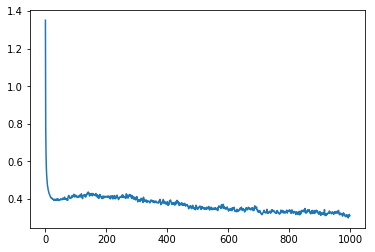

In [97]:
plt.plot(costs)

## TEST YOUR DATA HERE...


In [35]:
testDataSetPath = "./../input_data/Apparel/apparel-test.csv"

In [36]:
testDataSet = pd.read_csv(testDataSetPath)


In [39]:
y_pred= NNReLU.predict(testDataSet)
y_pred

array([6, 1, 2, ..., 4, 2, 2])

In [40]:
predDF = pd.DataFrame(data = y_pred)

In [41]:
predictedDataSetPath = "./../output_data/2018201040_prediction.csv"
predDF.to_csv(predictedDataSetPath)
